In [1]:
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost
#!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import opendatasets as od
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import xgboost
import lightgbm 
import catboost
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
import sklearn
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt

In [3]:
train_df = pd.read_csv("clean_data.csv")
test_df = clean = pd.read_csv("clean_test.csv")
test = pd.read_csv("test.csv")

sample_sub = pd.read_csv("sample_submission.csv")


In [4]:
passenger_id = test['PassengerId']

In [5]:
train_df.head()

HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  FoodCourt  \
0           1          0            2  39.0    0          0.0        0.0   
1           0          0            2  24.0    0        109.0        9.0   
2           1          0            2  58.0    1         43.0     3576.0   
3           1          0            2  33.0    0          0.0     1283.0   
4           0          0            2  16.0    0        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported  deck_cabin  num_cabin  \
0           0.0     0.0     0.0            0           1          0   
1          25.0   549.0    44.0            1           5          0   
2           0.0  6715.0    49.0            0           0          0   
3         371.0  3329.0   193.0            0           0          0   
4         151.0   565.0     2.0            1           5          1   

   side_cabin  
0           0  
1           1  
2           1  
3           1  
4           1

In [6]:
test_df.head()

HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  FoodCourt  \
0           0          1            2  27.0    0          0.0        0.0   
1           0          0            2  19.0    0          0.0        9.0   
2           1          1            0  31.0    0          0.0        0.0   
3           1          0            2  38.0    0          0.0     6652.0   
4           0          0            2  20.0    0         10.0        0.0   

   ShoppingMall     Spa  VRDeck  deck_cabin  num_cabin  side_cabin  
0           0.0     0.0     0.0           6          3           1  
1           0.0  2823.0     0.0           5          4           1  
2           0.0     0.0     0.0           2          0           1  
3           0.0   181.0   585.0           2          1           1  
4         635.0     0.0     0.0           5          5           1

In [7]:
#Splitting train data into train and validation sets 

X = train_df.drop(['CryoSleep', 'num_cabin', 'Transported'],axis=1)
#X = pd.get_dummies(x)
y = train_df['Transported']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

In [8]:
def model_pred(model):
    """
    Get accuracy score on validation data from a model
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy  = accuracy_score(y_pred, y_val)
    
    return accuracy

In [9]:
#Searching for the best number of n_neighbors

knn = KNeighborsClassifier()
param_grid = {'n_neighbors':np.arange(2,15)}
knn_p = GridSearchCV(knn, param_grid, cv=5)
knn_p.fit(X_train,y_train)
knn_p.best_params_

{'n_neighbors': 13}

In [10]:
models = [KNeighborsClassifier(n_neighbors = 13), LGBMClassifier(), CatBoostClassifier(verbose = False), XGBClassifier()]

for i in models:
    accuracy = model_pred(i)
    print(f"{i} Accuracy : \n {accuracy}")
    print('___________________')

KNeighborsClassifier(n_neighbors=13) Accuracy : 
 0.771264367816092
___________________
LGBMClassifier() Accuracy : 
 0.8149425287356322
___________________
<catboost.core.CatBoostClassifier object at 0x000001A3A3031340> Accuracy : 
 0.8045977011494253
___________________
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None,

In [11]:
#LightGBM OPTUNA 

def objective(trial):
    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = LGBMClassifier(**param)  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
    return accuracy
    
study_LGBM = optuna.create_study(direction="maximize")
study_LGBM.optimize(objective, n_trials=100, show_progress_bar=True)

print("Number of finished trials: {}".format(len(study_LGBM.trials)))

print("Best trial:")
trial_LGBM = study_LGBM.best_trial

print("  Value: {}".format(trial_LGBM.value))

print("  Params: ")
for key, value in trial_LGBM.params.items():
    print("    {}: {}".format(key, value))

[I 2023-04-04 19:05:48,542] A new study created in memory with name: no-name-c9f0a470-cf52-4578-b0ce-33a2d6527b71
C:\Users\agnie\anaconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.935563021372711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.935563021372711
[LightGBM] [Warning] lambda_l1 is set=4.322493758706945e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.322493758706945e-08
[LightGBM] [Warning] bagging_fraction is set=0.9715155546211489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9715155546211489
[LightGBM] [Warning] lambda_l2 is set=0.0006661954025024313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006661954025024313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2023-04-04 19:05:48,954] Trial 0 finished with value: 0.8137931034482758 and parameters: {'lambda_l1': 4.322493758706945e-08, 'lambda_l2': 0.0006661954025024313, 'num_leaves': 189, 'feature_fraction': 0.935563021372711, 'bagging_fraction': 0.9715155546211489, 'bagging_freq': 1, 'min_child_samples': 40}. Best i

[LightGBM] [Warning] lambda_l1 is set=0.002522990211305755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002522990211305755
[LightGBM] [Warning] bagging_fraction is set=0.4951187082694296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4951187082694296
[LightGBM] [Warning] lambda_l2 is set=5.362000282753305e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.362000282753305e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[I 2023-04-04 19:05:50,840] Trial 8 finished with value: 0.7977011494252874 and parameters: {'lambda_l1': 0.002522990211305755, 'lambda_l2': 5.362000282753305e-06, 'num_leaves': 59, 'feature_fraction': 0.6200259704971242, 'bagging_fraction': 0.4951187082694296, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 0 with value: 0.8137931034482758.
[LightGBM] [Warning] feature_fraction is set=0.7448034133982692, colsample_bytree=1.0 will be ignored. Current va

[I 2023-04-04 19:05:53,901] Trial 16 finished with value: 0.7931034482758621 and parameters: {'lambda_l1': 6.87012730279709e-05, 'lambda_l2': 0.014085175942637978, 'num_leaves': 215, 'feature_fraction': 0.812437359168557, 'bagging_fraction': 0.7950967000727973, 'bagging_freq': 1, 'min_child_samples': 59}. Best is trial 13 with value: 0.8172413793103448.
[LightGBM] [Warning] feature_fraction is set=0.9348843305877211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9348843305877211
[LightGBM] [Warning] lambda_l1 is set=4.078735818897718e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.078735818897718e-06
[LightGBM] [Warning] bagging_fraction is set=0.8206082072139388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8206082072139388
[LightGBM] [Warning] lambda_l2 is set=5.8268702540225246e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8268702540225246e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 w

[I 2023-04-04 19:05:57,225] Trial 24 finished with value: 0.803448275862069 and parameters: {'lambda_l1': 0.03482095524790958, 'lambda_l2': 1.9264642657497707e-06, 'num_leaves': 147, 'feature_fraction': 0.9884115894780532, 'bagging_fraction': 0.911261560246172, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 13 with value: 0.8172413793103448.
[LightGBM] [Warning] feature_fraction is set=0.9428135869507616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9428135869507616
[LightGBM] [Warning] lambda_l1 is set=0.1047893473510332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1047893473510332
[LightGBM] [Warning] bagging_fraction is set=0.9836224848318705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9836224848318705
[LightGBM] [Warning] lambda_l2 is set=0.00018695597542200403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018695597542200403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[I 2023-04-04 19:06:00,478] Trial 32 finished with value: 0.8057471264367816 and parameters: {'lambda_l1': 0.8175598662284747, 'lambda_l2': 3.0891227734301565e-06, 'num_leaves': 217, 'feature_fraction': 0.9998736666773339, 'bagging_fraction': 0.9680600767618487, 'bagging_freq': 2, 'min_child_samples': 36}. Best is trial 13 with value: 0.8172413793103448.
[LightGBM] [Warning] feature_fraction is set=0.900822614679735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900822614679735
[LightGBM] [Warning] lambda_l1 is set=2.5800965690822806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5800965690822806
[LightGBM] [Warning] bagging_fraction is set=0.890914174408076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.890914174408076
[LightGBM] [Warning] lambda_l2 is set=1.3327930006913836e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3327930006913836e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ig

[I 2023-04-04 19:06:03,213] Trial 40 finished with value: 0.8022988505747126 and parameters: {'lambda_l1': 6.904235681340892e-07, 'lambda_l2': 2.006988376186667e-05, 'num_leaves': 144, 'feature_fraction': 0.7233019132483339, 'bagging_fraction': 0.9110650346603165, 'bagging_freq': 1, 'min_child_samples': 41}. Best is trial 13 with value: 0.8172413793103448.
[LightGBM] [Warning] feature_fraction is set=0.9241550482856089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9241550482856089
[LightGBM] [Warning] lambda_l1 is set=0.6550494328360615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6550494328360615
[LightGBM] [Warning] bagging_fraction is set=0.9540804761032224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9540804761032224
[LightGBM] [Warning] lambda_l2 is set=7.906910238069513e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.906910238069513e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will b

[LightGBM] [Warning] feature_fraction is set=0.8672248160651093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8672248160651093
[LightGBM] [Warning] lambda_l1 is set=5.37726058578722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.37726058578722
[LightGBM] [Warning] bagging_fraction is set=0.9095307367956004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9095307367956004
[LightGBM] [Warning] lambda_l2 is set=9.235981766508656e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.235981766508656e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[I 2023-04-04 19:06:05,520] Trial 49 finished with value: 0.8057471264367816 and parameters: {'lambda_l1': 5.37726058578722, 'lambda_l2': 9.235981766508656e-07, 'num_leaves': 243, 'feature_fraction': 0.8672248160651093, 'bagging_fraction': 0.9095307367956004, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 13 

[I 2023-04-04 19:06:07,695] Trial 57 finished with value: 0.8022988505747126 and parameters: {'lambda_l1': 1.958601461205778, 'lambda_l2': 3.4075846546930444e-05, 'num_leaves': 223, 'feature_fraction': 0.8253218520751698, 'bagging_fraction': 0.9196305076548229, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 13 with value: 0.8172413793103448.
[LightGBM] [Warning] feature_fraction is set=0.8551761549735928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8551761549735928
[LightGBM] [Warning] lambda_l1 is set=0.10314802162941908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10314802162941908
[LightGBM] [Warning] bagging_fraction is set=0.9468372672748434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9468372672748434
[LightGBM] [Warning] lambda_l2 is set=3.309838899535944e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.309838899535944e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be

[LightGBM] [Warning] feature_fraction is set=0.9966279760142999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9966279760142999
[LightGBM] [Warning] lambda_l1 is set=3.9036208021553485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9036208021553485
[LightGBM] [Warning] bagging_fraction is set=0.9331146523652323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9331146523652323
[LightGBM] [Warning] lambda_l2 is set=0.00023504418489770572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023504418489770572
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2023-04-04 19:06:10,218] Trial 66 finished with value: 0.8045977011494253 and parameters: {'lambda_l1': 3.9036208021553485, 'lambda_l2': 0.00023504418489770572, 'num_leaves': 154, 'feature_fraction': 0.9966279760142999, 'bagging_fraction': 0.9331146523652323, 'bagging_freq': 2, 'min_child_samples': 43}. Best is 

[I 2023-04-04 19:06:12,997] Trial 74 finished with value: 0.8080459770114943 and parameters: {'lambda_l1': 2.128757973834283, 'lambda_l2': 0.0002952474187664395, 'num_leaves': 182, 'feature_fraction': 0.9844251219929964, 'bagging_fraction': 0.8979605547844968, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 13 with value: 0.8172413793103448.
[LightGBM] [Warning] feature_fraction is set=0.9521883300131003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9521883300131003
[LightGBM] [Warning] lambda_l1 is set=5.879693334087907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.879693334087907
[LightGBM] [Warning] bagging_fraction is set=0.9838037531817961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9838037531817961
[LightGBM] [Warning] lambda_l2 is set=0.00012135140040538942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012135140040538942
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ig

[I 2023-04-04 19:06:15,121] Trial 82 finished with value: 0.8080459770114943 and parameters: {'lambda_l1': 2.0685875593287735, 'lambda_l2': 0.0006990099639523691, 'num_leaves': 192, 'feature_fraction': 0.9697659150275391, 'bagging_fraction': 0.9435340471000051, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 13 with value: 0.8172413793103448.
[LightGBM] [Warning] feature_fraction is set=0.9466479659768667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9466479659768667
[LightGBM] [Warning] lambda_l1 is set=6.9090208918269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.9090208918269
[LightGBM] [Warning] bagging_fraction is set=0.9575767733523657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9575767733523657
[LightGBM] [Warning] lambda_l2 is set=0.00020577687541159165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020577687541159165
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignor

[I 2023-04-04 19:06:18,506] Trial 90 finished with value: 0.8 and parameters: {'lambda_l1': 0.9453426101245391, 'lambda_l2': 5.6890291051138146e-05, 'num_leaves': 238, 'feature_fraction': 0.8856658281838422, 'bagging_fraction': 0.919226369577877, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 13 with value: 0.8172413793103448.
[LightGBM] [Warning] feature_fraction is set=0.9407973403005436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9407973403005436
[LightGBM] [Warning] lambda_l1 is set=1.4318773748396063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4318773748396063
[LightGBM] [Warning] bagging_fraction is set=0.9719238720088237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9719238720088237
[LightGBM] [Warning] lambda_l2 is set=0.0002412189786114465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002412189786114465
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current

[I 2023-04-04 19:06:21,080] Trial 98 finished with value: 0.8137931034482758 and parameters: {'lambda_l1': 2.438809196620834, 'lambda_l2': 0.00021192636198638152, 'num_leaves': 201, 'feature_fraction': 0.9716027924560409, 'bagging_fraction': 0.9606872620175321, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 13 with value: 0.8172413793103448.
[LightGBM] [Warning] feature_fraction is set=0.9677341297584152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9677341297584152
[LightGBM] [Warning] lambda_l1 is set=0.7323565682313837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7323565682313837
[LightGBM] [Warning] bagging_fraction is set=0.9788907144606527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9788907144606527
[LightGBM] [Warning] lambda_l2 is set=1.1806916203189666e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1806916203189666e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be

In [12]:
#CATBoost OPTUNA 

from optuna.integration import CatBoostPruningCallback

def objective(trial: optuna.Trial) -> float:

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "3gb",
        "eval_metric": "Accuracy",
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators'  : trial.suggest_int('n_estimators', 2000, 8000),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True)
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    model = CatBoostClassifier(**param, one_hot_max_size=254, early_stopping_rounds=100)  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
    return accuracy


study_CBC = optuna.create_study(direction="maximize")

study_CBC.optimize(objective, n_trials=100, timeout=600, show_progress_bar=True)



print("Number of finished trials: {}".format(len(study_CBC.trials)))

print("Best trial:")
trial_CBC = study_CBC.best_trial

print("  Value: {}".format(trial_CBC.value))

print("  Params: ")
for key, value in trial_CBC.params.items():
    print("    {}: {}".format(key, value))

[I 2023-04-04 19:06:21,535] A new study created in memory with name: no-name-fdc4a9d1-8bc8-4aae-a334-c9b9b6ca1611
C:\Users\agnie\anaconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

0:	learn: 0.6583152	total: 15.1ms	remaining: 56.4s
1:	learn: 0.6583152	total: 25.2ms	remaining: 46.8s
2:	learn: 0.6583152	total: 32.4ms	remaining: 40.2s
3:	learn: 0.6583152	total: 39.2ms	remaining: 36.4s
4:	learn: 0.6583152	total: 46ms	remaining: 34.2s
5:	learn: 0.6583152	total: 53.6ms	remaining: 33.3s
6:	learn: 0.7111083	total: 60.4ms	remaining: 32.1s
7:	learn: 0.7111083	total: 67.4ms	remaining: 31.3s
8:	learn: 0.7111083	total: 74ms	remaining: 30.5s
9:	learn: 0.7111083	total: 80.9ms	remaining: 30.1s
10:	learn: 0.7111083	total: 87.4ms	remaining: 29.5s
11:	learn: 0.7111083	total: 93.9ms	remaining: 29.1s
12:	learn: 0.7111083	total: 101ms	remaining: 28.7s
13:	learn: 0.7111083	total: 107ms	remaining: 28.3s
14:	learn: 0.7111083	total: 113ms	remaining: 27.9s
15:	learn: 0.7111083	total: 119ms	remaining: 27.6s
16:	learn: 0.7111083	total: 127ms	remaining: 27.6s
17:	learn: 0.7111083	total: 133ms	remaining: 27.3s
18:	learn: 0.7111083	total: 139ms	remaining: 27.1s
19:	learn: 0.7111083	total: 144ms

164:	learn: 0.7417870	total: 1.1s	remaining: 23.8s
165:	learn: 0.7417870	total: 1.11s	remaining: 23.8s
166:	learn: 0.7417870	total: 1.12s	remaining: 23.8s
167:	learn: 0.7417870	total: 1.12s	remaining: 23.8s
168:	learn: 0.7417870	total: 1.13s	remaining: 23.8s
169:	learn: 0.7417870	total: 1.14s	remaining: 23.8s
170:	learn: 0.7417870	total: 1.14s	remaining: 23.8s
171:	learn: 0.7417870	total: 1.15s	remaining: 23.7s
172:	learn: 0.7417870	total: 1.16s	remaining: 23.9s
173:	learn: 0.7417870	total: 1.17s	remaining: 23.9s
174:	learn: 0.7417870	total: 1.18s	remaining: 23.9s
175:	learn: 0.7417870	total: 1.18s	remaining: 23.9s
176:	learn: 0.7417870	total: 1.19s	remaining: 23.9s
177:	learn: 0.7417870	total: 1.2s	remaining: 23.9s
178:	learn: 0.7417870	total: 1.21s	remaining: 23.9s
179:	learn: 0.7417870	total: 1.21s	remaining: 23.9s
180:	learn: 0.7417870	total: 1.22s	remaining: 23.9s
181:	learn: 0.7417870	total: 1.23s	remaining: 23.9s
182:	learn: 0.7417870	total: 1.23s	remaining: 23.8s
183:	learn: 0.

325:	learn: 0.7655631	total: 2.22s	remaining: 23.1s
326:	learn: 0.7655631	total: 2.22s	remaining: 23.1s
327:	learn: 0.7655631	total: 2.23s	remaining: 23.1s
328:	learn: 0.7655631	total: 2.23s	remaining: 23.1s
329:	learn: 0.7655631	total: 2.24s	remaining: 23.1s
330:	learn: 0.7655631	total: 2.25s	remaining: 23.1s
331:	learn: 0.7655631	total: 2.25s	remaining: 23s
332:	learn: 0.7659466	total: 2.26s	remaining: 23s
333:	learn: 0.7659466	total: 2.27s	remaining: 23s
334:	learn: 0.7659466	total: 2.27s	remaining: 23s
335:	learn: 0.7659466	total: 2.28s	remaining: 23s
336:	learn: 0.7659466	total: 2.29s	remaining: 23s
337:	learn: 0.7659466	total: 2.29s	remaining: 23s
338:	learn: 0.7683753	total: 2.3s	remaining: 23s
339:	learn: 0.7683753	total: 2.31s	remaining: 23s
340:	learn: 0.7697814	total: 2.32s	remaining: 23s
341:	learn: 0.7697814	total: 2.32s	remaining: 23s
342:	learn: 0.7697814	total: 2.33s	remaining: 23s
343:	learn: 0.7697814	total: 2.34s	remaining: 23s
344:	learn: 0.7697814	total: 2.34s	rema

502:	learn: 0.7800077	total: 3.45s	remaining: 22.1s
503:	learn: 0.7800077	total: 3.45s	remaining: 22.1s
504:	learn: 0.7803912	total: 3.46s	remaining: 22.1s
505:	learn: 0.7803912	total: 3.47s	remaining: 22.1s
506:	learn: 0.7807746	total: 3.48s	remaining: 22.1s
507:	learn: 0.7816694	total: 3.48s	remaining: 22.1s
508:	learn: 0.7816694	total: 3.49s	remaining: 22.1s
509:	learn: 0.7817973	total: 3.5s	remaining: 22.1s
510:	learn: 0.7817973	total: 3.5s	remaining: 22s
511:	learn: 0.7817973	total: 3.51s	remaining: 22s
512:	learn: 0.7817973	total: 3.52s	remaining: 22s
513:	learn: 0.7817973	total: 3.52s	remaining: 22s
514:	learn: 0.7819251	total: 3.53s	remaining: 22s
515:	learn: 0.7819251	total: 3.54s	remaining: 22s
516:	learn: 0.7819251	total: 3.54s	remaining: 22s
517:	learn: 0.7819251	total: 3.55s	remaining: 22s
518:	learn: 0.7817973	total: 3.56s	remaining: 22s
519:	learn: 0.7807746	total: 3.56s	remaining: 22s
520:	learn: 0.7807746	total: 3.57s	remaining: 22s
521:	learn: 0.7807746	total: 3.58s	r

676:	learn: 0.7826921	total: 4.71s	remaining: 21.2s
677:	learn: 0.7826921	total: 4.72s	remaining: 21.2s
678:	learn: 0.7826921	total: 4.72s	remaining: 21.2s
679:	learn: 0.7861434	total: 4.73s	remaining: 21.2s
680:	learn: 0.7861434	total: 4.74s	remaining: 21.2s
681:	learn: 0.7861434	total: 4.75s	remaining: 21.2s
682:	learn: 0.7861434	total: 4.76s	remaining: 21.2s
683:	learn: 0.7861434	total: 4.76s	remaining: 21.2s
684:	learn: 0.7861434	total: 4.77s	remaining: 21.2s
685:	learn: 0.7861434	total: 4.78s	remaining: 21.2s
686:	learn: 0.7857599	total: 4.79s	remaining: 21.2s
687:	learn: 0.7857599	total: 4.79s	remaining: 21.2s
688:	learn: 0.7857599	total: 4.8s	remaining: 21.2s
689:	learn: 0.7860156	total: 4.81s	remaining: 21.2s
690:	learn: 0.7860156	total: 4.82s	remaining: 21.2s
691:	learn: 0.7860156	total: 4.83s	remaining: 21.2s
692:	learn: 0.7862713	total: 4.83s	remaining: 21.2s
693:	learn: 0.7862713	total: 4.84s	remaining: 21.2s
694:	learn: 0.7862713	total: 4.85s	remaining: 21.2s
695:	learn: 0

851:	learn: 0.7870382	total: 5.98s	remaining: 20.2s
852:	learn: 0.7874217	total: 5.99s	remaining: 20.2s
853:	learn: 0.7874217	total: 6s	remaining: 20.2s
854:	learn: 0.7874217	total: 6s	remaining: 20.2s
855:	learn: 0.7874217	total: 6.01s	remaining: 20.2s
856:	learn: 0.7874217	total: 6.02s	remaining: 20.1s
857:	learn: 0.7874217	total: 6.03s	remaining: 20.1s
858:	learn: 0.7874217	total: 6.03s	remaining: 20.1s
859:	learn: 0.7874217	total: 6.04s	remaining: 20.1s
860:	learn: 0.7874217	total: 6.05s	remaining: 20.1s
861:	learn: 0.7871660	total: 6.05s	remaining: 20.1s
862:	learn: 0.7871660	total: 6.06s	remaining: 20.1s
863:	learn: 0.7887000	total: 6.07s	remaining: 20.1s
864:	learn: 0.7885722	total: 6.08s	remaining: 20.1s
865:	learn: 0.7893391	total: 6.09s	remaining: 20.1s
866:	learn: 0.7893391	total: 6.09s	remaining: 20.1s
867:	learn: 0.7893391	total: 6.1s	remaining: 20.1s
868:	learn: 0.7893391	total: 6.11s	remaining: 20.1s
869:	learn: 0.7893391	total: 6.11s	remaining: 20.1s
870:	learn: 0.78933

1035:	learn: 0.7915122	total: 7.24s	remaining: 18.8s
1036:	learn: 0.7915122	total: 7.25s	remaining: 18.8s
1037:	learn: 0.7915122	total: 7.25s	remaining: 18.8s
1038:	learn: 0.7920235	total: 7.26s	remaining: 18.8s
1039:	learn: 0.7920235	total: 7.27s	remaining: 18.8s
1040:	learn: 0.7920235	total: 7.27s	remaining: 18.8s
1041:	learn: 0.7920235	total: 7.28s	remaining: 18.8s
1042:	learn: 0.7920235	total: 7.29s	remaining: 18.7s
1043:	learn: 0.7920235	total: 7.29s	remaining: 18.7s
1044:	learn: 0.7920235	total: 7.3s	remaining: 18.7s
1045:	learn: 0.7921513	total: 7.31s	remaining: 18.7s
1046:	learn: 0.7921513	total: 7.31s	remaining: 18.7s
1047:	learn: 0.7921513	total: 7.32s	remaining: 18.7s
1048:	learn: 0.7921513	total: 7.33s	remaining: 18.7s
1049:	learn: 0.7921513	total: 7.33s	remaining: 18.7s
1050:	learn: 0.7917679	total: 7.34s	remaining: 18.7s
1051:	learn: 0.7917679	total: 7.34s	remaining: 18.7s
1052:	learn: 0.7917679	total: 7.35s	remaining: 18.7s
1053:	learn: 0.7917679	total: 7.36s	remaining: 

1201:	learn: 0.7945801	total: 8.33s	remaining: 17.5s
1202:	learn: 0.7945801	total: 8.34s	remaining: 17.5s
1203:	learn: 0.7943244	total: 8.35s	remaining: 17.5s
1204:	learn: 0.7943244	total: 8.35s	remaining: 17.5s
1205:	learn: 0.7944523	total: 8.36s	remaining: 17.5s
1206:	learn: 0.7944523	total: 8.37s	remaining: 17.5s
1207:	learn: 0.7947079	total: 8.37s	remaining: 17.5s
1208:	learn: 0.7947079	total: 8.38s	remaining: 17.4s
1209:	learn: 0.7947079	total: 8.39s	remaining: 17.4s
1210:	learn: 0.7947079	total: 8.39s	remaining: 17.4s
1211:	learn: 0.7947079	total: 8.4s	remaining: 17.4s
1212:	learn: 0.7947079	total: 8.41s	remaining: 17.4s
1213:	learn: 0.7947079	total: 8.41s	remaining: 17.4s
1214:	learn: 0.7948357	total: 8.42s	remaining: 17.4s
1215:	learn: 0.7948357	total: 8.43s	remaining: 17.4s
1216:	learn: 0.7947079	total: 8.43s	remaining: 17.4s
1217:	learn: 0.7947079	total: 8.44s	remaining: 17.4s
1218:	learn: 0.7947079	total: 8.45s	remaining: 17.4s
1219:	learn: 0.7947079	total: 8.45s	remaining: 

1372:	learn: 0.7954749	total: 9.41s	remaining: 16.1s
1373:	learn: 0.7954749	total: 9.41s	remaining: 16.1s
1374:	learn: 0.7954749	total: 9.42s	remaining: 16.1s
1375:	learn: 0.7954749	total: 9.43s	remaining: 16.1s
1376:	learn: 0.7954749	total: 9.43s	remaining: 16.1s
1377:	learn: 0.7954749	total: 9.44s	remaining: 16.1s
1378:	learn: 0.7954749	total: 9.44s	remaining: 16.1s
1379:	learn: 0.7956027	total: 9.45s	remaining: 16.1s
1380:	learn: 0.7956027	total: 9.46s	remaining: 16.1s
1381:	learn: 0.7956027	total: 9.46s	remaining: 16s
1382:	learn: 0.7953471	total: 9.47s	remaining: 16s
1383:	learn: 0.7953471	total: 9.47s	remaining: 16s
1384:	learn: 0.7953471	total: 9.48s	remaining: 16s
1385:	learn: 0.7953471	total: 9.49s	remaining: 16s
1386:	learn: 0.7953471	total: 9.49s	remaining: 16s
1387:	learn: 0.7953471	total: 9.5s	remaining: 16s
1388:	learn: 0.7953471	total: 9.51s	remaining: 16s
1389:	learn: 0.7953471	total: 9.51s	remaining: 16s
1390:	learn: 0.7957305	total: 9.52s	remaining: 16s
1391:	learn: 0

1540:	learn: 0.7961140	total: 10.5s	remaining: 14.9s
1541:	learn: 0.7959862	total: 10.5s	remaining: 14.9s
1542:	learn: 0.7959862	total: 10.5s	remaining: 14.8s
1543:	learn: 0.7959862	total: 10.5s	remaining: 14.8s
1544:	learn: 0.7959862	total: 10.5s	remaining: 14.8s
1545:	learn: 0.7959862	total: 10.5s	remaining: 14.8s
1546:	learn: 0.7959862	total: 10.5s	remaining: 14.8s
1547:	learn: 0.7959862	total: 10.5s	remaining: 14.8s
1548:	learn: 0.7959862	total: 10.5s	remaining: 14.8s
1549:	learn: 0.7961140	total: 10.5s	remaining: 14.8s
1550:	learn: 0.7961140	total: 10.5s	remaining: 14.8s
1551:	learn: 0.7961140	total: 10.6s	remaining: 14.8s
1552:	learn: 0.7961140	total: 10.6s	remaining: 14.8s
1553:	learn: 0.7961140	total: 10.6s	remaining: 14.8s
1554:	learn: 0.7961140	total: 10.6s	remaining: 14.8s
1555:	learn: 0.7961140	total: 10.6s	remaining: 14.8s
1556:	learn: 0.7961140	total: 10.6s	remaining: 14.7s
1557:	learn: 0.7961140	total: 10.6s	remaining: 14.7s
1558:	learn: 0.7961140	total: 10.6s	remaining:

1708:	learn: 0.7957305	total: 11.5s	remaining: 13.6s
1709:	learn: 0.7957305	total: 11.6s	remaining: 13.6s
1710:	learn: 0.7957305	total: 11.6s	remaining: 13.6s
1711:	learn: 0.7957305	total: 11.6s	remaining: 13.6s
1712:	learn: 0.7957305	total: 11.6s	remaining: 13.6s
1713:	learn: 0.7958584	total: 11.6s	remaining: 13.6s
1714:	learn: 0.7958584	total: 11.6s	remaining: 13.6s
1715:	learn: 0.7958584	total: 11.6s	remaining: 13.6s
1716:	learn: 0.7958584	total: 11.6s	remaining: 13.6s
1717:	learn: 0.7958584	total: 11.6s	remaining: 13.6s
1718:	learn: 0.7958584	total: 11.6s	remaining: 13.6s
1719:	learn: 0.7958584	total: 11.6s	remaining: 13.6s
1720:	learn: 0.7958584	total: 11.6s	remaining: 13.5s
1721:	learn: 0.7958584	total: 11.6s	remaining: 13.5s
1722:	learn: 0.7958584	total: 11.6s	remaining: 13.5s
1723:	learn: 0.7958584	total: 11.6s	remaining: 13.5s
1724:	learn: 0.7958584	total: 11.7s	remaining: 13.5s
1725:	learn: 0.7958584	total: 11.7s	remaining: 13.5s
1726:	learn: 0.7957305	total: 11.7s	remaining:

1873:	learn: 0.7959862	total: 12.6s	remaining: 12.5s
1874:	learn: 0.7959862	total: 12.6s	remaining: 12.5s
1875:	learn: 0.7959862	total: 12.6s	remaining: 12.5s
1876:	learn: 0.7959862	total: 12.6s	remaining: 12.5s
1877:	learn: 0.7959862	total: 12.6s	remaining: 12.4s
1878:	learn: 0.7959862	total: 12.7s	remaining: 12.4s
1879:	learn: 0.7959862	total: 12.7s	remaining: 12.4s
1880:	learn: 0.7961140	total: 12.7s	remaining: 12.4s
1881:	learn: 0.7961140	total: 12.7s	remaining: 12.4s
1882:	learn: 0.7961140	total: 12.7s	remaining: 12.4s
1883:	learn: 0.7961140	total: 12.7s	remaining: 12.4s
1884:	learn: 0.7961140	total: 12.7s	remaining: 12.4s
1885:	learn: 0.7961140	total: 12.7s	remaining: 12.4s
1886:	learn: 0.7961140	total: 12.7s	remaining: 12.4s
1887:	learn: 0.7961140	total: 12.7s	remaining: 12.4s
1888:	learn: 0.7961140	total: 12.7s	remaining: 12.4s
1889:	learn: 0.7961140	total: 12.7s	remaining: 12.4s
1890:	learn: 0.7961140	total: 12.7s	remaining: 12.3s
1891:	learn: 0.7961140	total: 12.7s	remaining:

2047:	learn: 0.7967532	total: 13.7s	remaining: 11.2s
2048:	learn: 0.7970088	total: 13.7s	remaining: 11.2s
2049:	learn: 0.7970088	total: 13.7s	remaining: 11.2s
2050:	learn: 0.7970088	total: 13.7s	remaining: 11.2s
2051:	learn: 0.7970088	total: 13.7s	remaining: 11.2s
2052:	learn: 0.7970088	total: 13.7s	remaining: 11.2s
2053:	learn: 0.7970088	total: 13.7s	remaining: 11.2s
2054:	learn: 0.7970088	total: 13.7s	remaining: 11.2s
2055:	learn: 0.7970088	total: 13.8s	remaining: 11.2s
2056:	learn: 0.7970088	total: 13.8s	remaining: 11.2s
2057:	learn: 0.7967532	total: 13.8s	remaining: 11.2s
2058:	learn: 0.7967532	total: 13.8s	remaining: 11.1s
2059:	learn: 0.7967532	total: 13.8s	remaining: 11.1s
2060:	learn: 0.7967532	total: 13.8s	remaining: 11.1s
2061:	learn: 0.7967532	total: 13.8s	remaining: 11.1s
2062:	learn: 0.7967532	total: 13.8s	remaining: 11.1s
2063:	learn: 0.7967532	total: 13.8s	remaining: 11.1s
2064:	learn: 0.7967532	total: 13.8s	remaining: 11.1s
2065:	learn: 0.7967532	total: 13.8s	remaining:

2205:	learn: 0.7964975	total: 14.8s	remaining: 10.2s
2206:	learn: 0.7964975	total: 14.8s	remaining: 10.2s
2207:	learn: 0.7964975	total: 14.8s	remaining: 10.2s
2208:	learn: 0.7964975	total: 14.8s	remaining: 10.2s
2209:	learn: 0.7964975	total: 14.8s	remaining: 10.2s
2210:	learn: 0.7966253	total: 14.8s	remaining: 10.1s
2211:	learn: 0.7966253	total: 14.8s	remaining: 10.1s
2212:	learn: 0.7966253	total: 14.8s	remaining: 10.1s
2213:	learn: 0.7966253	total: 14.8s	remaining: 10.1s
2214:	learn: 0.7966253	total: 14.8s	remaining: 10.1s
2215:	learn: 0.7966253	total: 14.8s	remaining: 10.1s
2216:	learn: 0.7966253	total: 14.9s	remaining: 10.1s
2217:	learn: 0.7966253	total: 14.9s	remaining: 10.1s
2218:	learn: 0.7966253	total: 14.9s	remaining: 10.1s
2219:	learn: 0.7966253	total: 14.9s	remaining: 10.1s
2220:	learn: 0.7971366	total: 14.9s	remaining: 10.1s
2221:	learn: 0.7971366	total: 14.9s	remaining: 10.1s
2222:	learn: 0.7971366	total: 14.9s	remaining: 10.1s
2223:	learn: 0.7971366	total: 14.9s	remaining:

2369:	learn: 0.7967532	total: 15.9s	remaining: 9.07s
2370:	learn: 0.7967532	total: 15.9s	remaining: 9.06s
2371:	learn: 0.7967532	total: 15.9s	remaining: 9.06s
2372:	learn: 0.7967532	total: 15.9s	remaining: 9.05s
2373:	learn: 0.7967532	total: 15.9s	remaining: 9.04s
2374:	learn: 0.7967532	total: 15.9s	remaining: 9.04s
2375:	learn: 0.7967532	total: 15.9s	remaining: 9.03s
2376:	learn: 0.7967532	total: 15.9s	remaining: 9.02s
2377:	learn: 0.7967532	total: 15.9s	remaining: 9.02s
2378:	learn: 0.7967532	total: 15.9s	remaining: 9.01s
2379:	learn: 0.7967532	total: 15.9s	remaining: 9s
2380:	learn: 0.7964975	total: 15.9s	remaining: 9s
2381:	learn: 0.7964975	total: 15.9s	remaining: 8.99s
2382:	learn: 0.7964975	total: 15.9s	remaining: 8.98s
2383:	learn: 0.7964975	total: 15.9s	remaining: 8.98s
2384:	learn: 0.7964975	total: 16s	remaining: 8.97s
2385:	learn: 0.7964975	total: 16s	remaining: 8.96s
2386:	learn: 0.7963697	total: 16s	remaining: 8.96s
2387:	learn: 0.7963697	total: 16s	remaining: 8.95s
2388:	l

2525:	learn: 0.7981593	total: 16.9s	remaining: 8.04s
2526:	learn: 0.7980314	total: 16.9s	remaining: 8.04s
2527:	learn: 0.7980314	total: 16.9s	remaining: 8.03s
2528:	learn: 0.7980314	total: 17s	remaining: 8.02s
2529:	learn: 0.7980314	total: 17s	remaining: 8.02s
2530:	learn: 0.7980314	total: 17s	remaining: 8.01s
2531:	learn: 0.7980314	total: 17s	remaining: 8s
2532:	learn: 0.7980314	total: 17s	remaining: 8s
2533:	learn: 0.7980314	total: 17s	remaining: 7.99s
2534:	learn: 0.7980314	total: 17s	remaining: 7.98s
2535:	learn: 0.7977758	total: 17s	remaining: 7.98s
2536:	learn: 0.7977758	total: 17s	remaining: 7.97s
2537:	learn: 0.7977758	total: 17s	remaining: 7.96s
2538:	learn: 0.7977758	total: 17s	remaining: 7.96s
2539:	learn: 0.7977758	total: 17s	remaining: 7.95s
2540:	learn: 0.7977758	total: 17s	remaining: 7.95s
2541:	learn: 0.7977758	total: 17s	remaining: 7.94s
2542:	learn: 0.7977758	total: 17s	remaining: 7.93s
2543:	learn: 0.7977758	total: 17.1s	remaining: 7.92s
2544:	learn: 0.7977758	total:

2705:	learn: 0.7980314	total: 18.2s	remaining: 6.86s
2706:	learn: 0.7979036	total: 18.2s	remaining: 6.86s
2707:	learn: 0.7979036	total: 18.2s	remaining: 6.85s
2708:	learn: 0.7979036	total: 18.2s	remaining: 6.84s
2709:	learn: 0.7980314	total: 18.2s	remaining: 6.84s
2710:	learn: 0.7980314	total: 18.2s	remaining: 6.83s
2711:	learn: 0.7980314	total: 18.3s	remaining: 6.83s
2712:	learn: 0.7980314	total: 18.3s	remaining: 6.82s
2713:	learn: 0.7979036	total: 18.3s	remaining: 6.81s
2714:	learn: 0.7979036	total: 18.3s	remaining: 6.8s
2715:	learn: 0.7979036	total: 18.3s	remaining: 6.8s
2716:	learn: 0.7979036	total: 18.3s	remaining: 6.79s
2717:	learn: 0.7980314	total: 18.3s	remaining: 6.79s
2718:	learn: 0.7979036	total: 18.3s	remaining: 6.78s
2719:	learn: 0.7979036	total: 18.3s	remaining: 6.77s
2720:	learn: 0.7979036	total: 18.3s	remaining: 6.77s
2721:	learn: 0.7980314	total: 18.3s	remaining: 6.76s
2722:	learn: 0.7980314	total: 18.3s	remaining: 6.75s
2723:	learn: 0.7980314	total: 18.3s	remaining: 6

2882:	learn: 0.7985428	total: 19.5s	remaining: 5.69s
2883:	learn: 0.7985428	total: 19.5s	remaining: 5.68s
2884:	learn: 0.7985428	total: 19.5s	remaining: 5.68s
2885:	learn: 0.7985428	total: 19.5s	remaining: 5.67s
2886:	learn: 0.7985428	total: 19.5s	remaining: 5.67s
2887:	learn: 0.7985428	total: 19.5s	remaining: 5.66s
2888:	learn: 0.7985428	total: 19.5s	remaining: 5.65s
2889:	learn: 0.7985428	total: 19.5s	remaining: 5.64s
2890:	learn: 0.7985428	total: 19.5s	remaining: 5.64s
2891:	learn: 0.7985428	total: 19.5s	remaining: 5.63s
2892:	learn: 0.7985428	total: 19.5s	remaining: 5.62s
2893:	learn: 0.7985428	total: 19.5s	remaining: 5.62s
2894:	learn: 0.7987984	total: 19.5s	remaining: 5.61s
2895:	learn: 0.7987984	total: 19.6s	remaining: 5.6s
2896:	learn: 0.7987984	total: 19.6s	remaining: 5.6s
2897:	learn: 0.7987984	total: 19.6s	remaining: 5.59s
2898:	learn: 0.7985428	total: 19.6s	remaining: 5.58s
2899:	learn: 0.7985428	total: 19.6s	remaining: 5.58s
2900:	learn: 0.7985428	total: 19.6s	remaining: 5

3058:	learn: 0.7991819	total: 20.7s	remaining: 4.52s
3059:	learn: 0.7991819	total: 20.7s	remaining: 4.51s
3060:	learn: 0.7991819	total: 20.7s	remaining: 4.5s
3061:	learn: 0.7991819	total: 20.7s	remaining: 4.5s
3062:	learn: 0.7991819	total: 20.8s	remaining: 4.49s
3063:	learn: 0.7991819	total: 20.8s	remaining: 4.49s
3064:	learn: 0.7991819	total: 20.8s	remaining: 4.48s
3065:	learn: 0.7991819	total: 20.8s	remaining: 4.47s
3066:	learn: 0.7991819	total: 20.8s	remaining: 4.46s
3067:	learn: 0.7991819	total: 20.8s	remaining: 4.46s
3068:	learn: 0.7991819	total: 20.8s	remaining: 4.45s
3069:	learn: 0.7991819	total: 20.8s	remaining: 4.45s
3070:	learn: 0.7991819	total: 20.8s	remaining: 4.44s
3071:	learn: 0.7991819	total: 20.8s	remaining: 4.43s
3072:	learn: 0.7991819	total: 20.8s	remaining: 4.42s
3073:	learn: 0.7991819	total: 20.8s	remaining: 4.42s
3074:	learn: 0.7991819	total: 20.8s	remaining: 4.41s
3075:	learn: 0.7991819	total: 20.8s	remaining: 4.4s
3076:	learn: 0.7991819	total: 20.9s	remaining: 4.

3216:	learn: 0.7990541	total: 21.8s	remaining: 3.45s
3217:	learn: 0.7990541	total: 21.8s	remaining: 3.44s
3218:	learn: 0.7990541	total: 21.8s	remaining: 3.44s
3219:	learn: 0.7990541	total: 21.8s	remaining: 3.43s
3220:	learn: 0.7990541	total: 21.8s	remaining: 3.42s
3221:	learn: 0.7990541	total: 21.8s	remaining: 3.42s
3222:	learn: 0.7990541	total: 21.8s	remaining: 3.41s
3223:	learn: 0.7990541	total: 21.8s	remaining: 3.4s
3224:	learn: 0.7990541	total: 21.9s	remaining: 3.4s
3225:	learn: 0.7990541	total: 21.9s	remaining: 3.39s
3226:	learn: 0.7990541	total: 21.9s	remaining: 3.38s
3227:	learn: 0.7990541	total: 21.9s	remaining: 3.38s
3228:	learn: 0.7990541	total: 21.9s	remaining: 3.37s
3229:	learn: 0.7990541	total: 21.9s	remaining: 3.36s
3230:	learn: 0.7990541	total: 21.9s	remaining: 3.35s
3231:	learn: 0.7990541	total: 21.9s	remaining: 3.35s
3232:	learn: 0.7990541	total: 21.9s	remaining: 3.34s
3233:	learn: 0.7990541	total: 21.9s	remaining: 3.33s
3234:	learn: 0.7990541	total: 21.9s	remaining: 3

3393:	learn: 0.7993097	total: 23.1s	remaining: 2.26s
3394:	learn: 0.7993097	total: 23.1s	remaining: 2.25s
3395:	learn: 0.7993097	total: 23.1s	remaining: 2.24s
3396:	learn: 0.7993097	total: 23.1s	remaining: 2.24s
3397:	learn: 0.7993097	total: 23.1s	remaining: 2.23s
3398:	learn: 0.7993097	total: 23.1s	remaining: 2.22s
3399:	learn: 0.7993097	total: 23.1s	remaining: 2.22s
3400:	learn: 0.7993097	total: 23.1s	remaining: 2.21s
3401:	learn: 0.7994376	total: 23.1s	remaining: 2.2s
3402:	learn: 0.7994376	total: 23.1s	remaining: 2.2s
3403:	learn: 0.7994376	total: 23.2s	remaining: 2.19s
3404:	learn: 0.7995654	total: 23.2s	remaining: 2.18s
3405:	learn: 0.7995654	total: 23.2s	remaining: 2.18s
3406:	learn: 0.7995654	total: 23.2s	remaining: 2.17s
3407:	learn: 0.7995654	total: 23.2s	remaining: 2.16s
3408:	learn: 0.7995654	total: 23.2s	remaining: 2.16s
3409:	learn: 0.7995654	total: 23.2s	remaining: 2.15s
3410:	learn: 0.7995654	total: 23.2s	remaining: 2.14s
3411:	learn: 0.7995654	total: 23.2s	remaining: 2

3563:	learn: 0.8021219	total: 24.4s	remaining: 1.11s
3564:	learn: 0.8021219	total: 24.4s	remaining: 1.1s
3565:	learn: 0.8021219	total: 24.4s	remaining: 1.09s
3566:	learn: 0.8021219	total: 24.4s	remaining: 1.09s
3567:	learn: 0.8021219	total: 24.4s	remaining: 1.08s
3568:	learn: 0.8021219	total: 24.4s	remaining: 1.07s
3569:	learn: 0.8021219	total: 24.4s	remaining: 1.06s
3570:	learn: 0.8021219	total: 24.4s	remaining: 1.06s
3571:	learn: 0.8021219	total: 24.4s	remaining: 1.05s
3572:	learn: 0.8021219	total: 24.4s	remaining: 1.04s
3573:	learn: 0.8021219	total: 24.4s	remaining: 1.04s
3574:	learn: 0.8021219	total: 24.4s	remaining: 1.03s
3575:	learn: 0.8021219	total: 24.4s	remaining: 1.02s
3576:	learn: 0.8021219	total: 24.4s	remaining: 1.02s
3577:	learn: 0.8021219	total: 24.4s	remaining: 1.01s
3578:	learn: 0.8021219	total: 24.5s	remaining: 1s
3579:	learn: 0.8021219	total: 24.5s	remaining: 998ms
3580:	learn: 0.8021219	total: 24.5s	remaining: 991ms
3581:	learn: 0.8021219	total: 24.5s	remaining: 984

3721:	learn: 0.8023776	total: 25.5s	remaining: 27.4ms
3722:	learn: 0.8022498	total: 25.5s	remaining: 20.5ms
3723:	learn: 0.8022498	total: 25.5s	remaining: 13.7ms
3724:	learn: 0.8022498	total: 25.5s	remaining: 6.84ms
3725:	learn: 0.8022498	total: 25.5s	remaining: 0us
[I 2023-04-04 19:06:48,225] Trial 0 finished with value: 0.7954022988505747 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.017942894800984866, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'learning_rate': 0.08, 'n_estimators': 3726, 'max_bin': 335, 'min_data_in_leaf': 42, 'l2_leaf_reg': 0.19710023300133447}. Best is trial 0 with value: 0.7954022988505747.
0:	learn: 0.5044101	total: 7.26ms	remaining: 40.7s
1:	learn: 0.5044101	total: 14.6ms	remaining: 41s
2:	learn: 0.5044101	total: 22.6ms	remaining: 42.2s
3:	learn: 0.5044101	total: 29.1ms	remaining: 40.8s
4:	learn: 0.5104180	total: 36.6ms	remaining: 41s
5:	learn: 0.5104180	total: 43ms	remaining: 40.1s
6:	learn: 0.5104180	total: 49.4ms	rem

157:	learn: 0.7137927	total: 1.17s	remaining: 40.2s
158:	learn: 0.7137927	total: 1.17s	remaining: 40.2s
159:	learn: 0.7137927	total: 1.18s	remaining: 40.2s
160:	learn: 0.7137927	total: 1.19s	remaining: 40.2s
161:	learn: 0.7137927	total: 1.2s	remaining: 40.3s
162:	learn: 0.7137927	total: 1.2s	remaining: 40.2s
163:	learn: 0.7137927	total: 1.21s	remaining: 40.3s
164:	learn: 0.7137927	total: 1.22s	remaining: 40.3s
165:	learn: 0.7137927	total: 1.23s	remaining: 40.2s
166:	learn: 0.7137927	total: 1.23s	remaining: 40.2s
167:	learn: 0.7137927	total: 1.24s	remaining: 40.2s
168:	learn: 0.7137927	total: 1.25s	remaining: 40.2s
169:	learn: 0.7137927	total: 1.26s	remaining: 40.2s
170:	learn: 0.7151988	total: 1.26s	remaining: 40.2s
171:	learn: 0.7151988	total: 1.27s	remaining: 40.2s
172:	learn: 0.7151988	total: 1.28s	remaining: 40.2s
173:	learn: 0.7151988	total: 1.29s	remaining: 40.2s
174:	learn: 0.7151988	total: 1.29s	remaining: 40.2s
175:	learn: 0.7151988	total: 1.3s	remaining: 40.2s
176:	learn: 0.7

330:	learn: 0.7601943	total: 2.44s	remaining: 38.9s
331:	learn: 0.7601943	total: 2.44s	remaining: 38.9s
332:	learn: 0.7601943	total: 2.45s	remaining: 38.8s
333:	learn: 0.7603221	total: 2.46s	remaining: 38.8s
334:	learn: 0.7603221	total: 2.46s	remaining: 38.8s
335:	learn: 0.7603221	total: 2.47s	remaining: 38.8s
336:	learn: 0.7609613	total: 2.48s	remaining: 38.8s
337:	learn: 0.7609613	total: 2.49s	remaining: 38.8s
338:	learn: 0.7609613	total: 2.49s	remaining: 38.8s
339:	learn: 0.7609613	total: 2.5s	remaining: 38.8s
340:	learn: 0.7610891	total: 2.51s	remaining: 38.8s
341:	learn: 0.7612169	total: 2.52s	remaining: 38.8s
342:	learn: 0.7612169	total: 2.52s	remaining: 38.7s
343:	learn: 0.7612169	total: 2.53s	remaining: 38.7s
344:	learn: 0.7608334	total: 2.54s	remaining: 38.7s
345:	learn: 0.7608334	total: 2.54s	remaining: 38.7s
346:	learn: 0.7599386	total: 2.55s	remaining: 38.7s
347:	learn: 0.7599386	total: 2.56s	remaining: 38.7s
348:	learn: 0.7600665	total: 2.57s	remaining: 38.7s
349:	learn: 0

499:	learn: 0.7677362	total: 3.7s	remaining: 37.8s
500:	learn: 0.7677362	total: 3.71s	remaining: 37.8s
501:	learn: 0.7677362	total: 3.71s	remaining: 37.8s
502:	learn: 0.7677362	total: 3.72s	remaining: 37.8s
503:	learn: 0.7677362	total: 3.73s	remaining: 37.8s
504:	learn: 0.7677362	total: 3.73s	remaining: 37.8s
505:	learn: 0.7677362	total: 3.74s	remaining: 37.8s
506:	learn: 0.7662022	total: 3.75s	remaining: 37.8s
507:	learn: 0.7662022	total: 3.76s	remaining: 37.7s
508:	learn: 0.7662022	total: 3.77s	remaining: 37.7s
509:	learn: 0.7662022	total: 3.77s	remaining: 37.7s
510:	learn: 0.7662022	total: 3.78s	remaining: 37.7s
511:	learn: 0.7662022	total: 3.79s	remaining: 37.7s
512:	learn: 0.7660744	total: 3.79s	remaining: 37.7s
513:	learn: 0.7660744	total: 3.8s	remaining: 37.7s
514:	learn: 0.7660744	total: 3.81s	remaining: 37.7s
515:	learn: 0.7660744	total: 3.82s	remaining: 37.7s
516:	learn: 0.7660744	total: 3.83s	remaining: 37.7s
517:	learn: 0.7660744	total: 3.83s	remaining: 37.7s
518:	learn: 0.

668:	learn: 0.7722101	total: 4.97s	remaining: 36.7s
669:	learn: 0.7722101	total: 4.98s	remaining: 36.7s
670:	learn: 0.7722101	total: 4.99s	remaining: 36.7s
671:	learn: 0.7722101	total: 4.99s	remaining: 36.7s
672:	learn: 0.7722101	total: 5s	remaining: 36.7s
673:	learn: 0.7722101	total: 5.01s	remaining: 36.7s
674:	learn: 0.7722101	total: 5.02s	remaining: 36.7s
675:	learn: 0.7708040	total: 5.02s	remaining: 36.7s
676:	learn: 0.7708040	total: 5.03s	remaining: 36.7s
677:	learn: 0.7708040	total: 5.04s	remaining: 36.7s
678:	learn: 0.7708040	total: 5.05s	remaining: 36.6s
679:	learn: 0.7708040	total: 5.05s	remaining: 36.6s
680:	learn: 0.7710597	total: 5.06s	remaining: 36.6s
681:	learn: 0.7710597	total: 5.07s	remaining: 36.6s
682:	learn: 0.7710597	total: 5.08s	remaining: 36.6s
683:	learn: 0.7711875	total: 5.08s	remaining: 36.6s
684:	learn: 0.7711875	total: 5.09s	remaining: 36.6s
685:	learn: 0.7711875	total: 5.1s	remaining: 36.6s
686:	learn: 0.7711875	total: 5.11s	remaining: 36.6s
687:	learn: 0.77

840:	learn: 0.7725936	total: 6.24s	remaining: 35.4s
841:	learn: 0.7725936	total: 6.25s	remaining: 35.4s
842:	learn: 0.7725936	total: 6.25s	remaining: 35.4s
843:	learn: 0.7725936	total: 6.26s	remaining: 35.3s
844:	learn: 0.7725936	total: 6.27s	remaining: 35.3s
845:	learn: 0.7725936	total: 6.27s	remaining: 35.3s
846:	learn: 0.7725936	total: 6.28s	remaining: 35.3s
847:	learn: 0.7725936	total: 6.29s	remaining: 35.3s
848:	learn: 0.7725936	total: 6.3s	remaining: 35.3s
849:	learn: 0.7725936	total: 6.3s	remaining: 35.3s
850:	learn: 0.7725936	total: 6.31s	remaining: 35.3s
851:	learn: 0.7725936	total: 6.32s	remaining: 35.3s
852:	learn: 0.7725936	total: 6.33s	remaining: 35.3s
853:	learn: 0.7738719	total: 6.33s	remaining: 35.3s
854:	learn: 0.7738719	total: 6.34s	remaining: 35.3s
855:	learn: 0.7738719	total: 6.35s	remaining: 35.3s
856:	learn: 0.7738719	total: 6.36s	remaining: 35.3s
857:	learn: 0.7738719	total: 6.37s	remaining: 35.2s
858:	learn: 0.7738719	total: 6.37s	remaining: 35.2s
859:	learn: 0.

1016:	learn: 0.7777068	total: 7.52s	remaining: 33.9s
1017:	learn: 0.7777068	total: 7.53s	remaining: 33.9s
1018:	learn: 0.7777068	total: 7.53s	remaining: 33.9s
1019:	learn: 0.7777068	total: 7.54s	remaining: 33.9s
1020:	learn: 0.7777068	total: 7.55s	remaining: 33.9s
1021:	learn: 0.7779624	total: 7.55s	remaining: 33.9s
1022:	learn: 0.7779624	total: 7.56s	remaining: 33.9s
1023:	learn: 0.7779624	total: 7.57s	remaining: 33.9s
1024:	learn: 0.7779624	total: 7.58s	remaining: 33.9s
1025:	learn: 0.7779624	total: 7.58s	remaining: 33.9s
1026:	learn: 0.7779624	total: 7.59s	remaining: 33.9s
1027:	learn: 0.7784737	total: 7.6s	remaining: 33.9s
1028:	learn: 0.7784737	total: 7.61s	remaining: 33.9s
1029:	learn: 0.7784737	total: 7.62s	remaining: 33.9s
1030:	learn: 0.7784737	total: 7.62s	remaining: 33.9s
1031:	learn: 0.7784737	total: 7.63s	remaining: 33.8s
1032:	learn: 0.7784737	total: 7.64s	remaining: 33.8s
1033:	learn: 0.7784737	total: 7.64s	remaining: 33.8s
1034:	learn: 0.7784737	total: 7.65s	remaining: 

1193:	learn: 0.7807746	total: 8.78s	remaining: 32.5s
1194:	learn: 0.7807746	total: 8.79s	remaining: 32.5s
1195:	learn: 0.7814138	total: 8.79s	remaining: 32.4s
1196:	learn: 0.7814138	total: 8.8s	remaining: 32.4s
1197:	learn: 0.7814138	total: 8.81s	remaining: 32.4s
1198:	learn: 0.7814138	total: 8.81s	remaining: 32.4s
1199:	learn: 0.7812860	total: 8.82s	remaining: 32.4s
1200:	learn: 0.7812860	total: 8.83s	remaining: 32.4s
1201:	learn: 0.7812860	total: 8.83s	remaining: 32.4s
1202:	learn: 0.7812860	total: 8.84s	remaining: 32.4s
1203:	learn: 0.7812860	total: 8.85s	remaining: 32.4s
1204:	learn: 0.7812860	total: 8.86s	remaining: 32.4s
1205:	learn: 0.7812860	total: 8.86s	remaining: 32.4s
1206:	learn: 0.7812860	total: 8.87s	remaining: 32.3s
1207:	learn: 0.7812860	total: 8.88s	remaining: 32.3s
1208:	learn: 0.7812860	total: 8.88s	remaining: 32.3s
1209:	learn: 0.7812860	total: 8.89s	remaining: 32.3s
1210:	learn: 0.7812860	total: 8.9s	remaining: 32.3s
1211:	learn: 0.7816694	total: 8.9s	remaining: 32

1350:	learn: 0.7819251	total: 9.85s	remaining: 31s
1351:	learn: 0.7819251	total: 9.85s	remaining: 31s
1352:	learn: 0.7819251	total: 9.86s	remaining: 31s
1353:	learn: 0.7819251	total: 9.87s	remaining: 31s
1354:	learn: 0.7819251	total: 9.87s	remaining: 31s
1355:	learn: 0.7819251	total: 9.88s	remaining: 31s
1356:	learn: 0.7819251	total: 9.89s	remaining: 31s
1357:	learn: 0.7819251	total: 9.89s	remaining: 31s
1358:	learn: 0.7819251	total: 9.9s	remaining: 31s
1359:	learn: 0.7819251	total: 9.91s	remaining: 31s
1360:	learn: 0.7819251	total: 9.91s	remaining: 30.9s
1361:	learn: 0.7819251	total: 9.92s	remaining: 30.9s
1362:	learn: 0.7819251	total: 9.93s	remaining: 30.9s
1363:	learn: 0.7819251	total: 9.94s	remaining: 30.9s
1364:	learn: 0.7819251	total: 9.94s	remaining: 30.9s
1365:	learn: 0.7817973	total: 9.95s	remaining: 30.9s
1366:	learn: 0.7817973	total: 9.96s	remaining: 30.9s
1367:	learn: 0.7817973	total: 9.96s	remaining: 30.9s
1368:	learn: 0.7821807	total: 9.97s	remaining: 30.9s
1369:	learn: 0

1507:	learn: 0.7846095	total: 10.9s	remaining: 29.7s
1508:	learn: 0.7846095	total: 10.9s	remaining: 29.7s
1509:	learn: 0.7846095	total: 10.9s	remaining: 29.7s
1510:	learn: 0.7846095	total: 10.9s	remaining: 29.7s
1511:	learn: 0.7846095	total: 11s	remaining: 29.7s
1512:	learn: 0.7846095	total: 11s	remaining: 29.7s
1513:	learn: 0.7846095	total: 11s	remaining: 29.7s
1514:	learn: 0.7846095	total: 11s	remaining: 29.7s
1515:	learn: 0.7843538	total: 11s	remaining: 29.6s
1516:	learn: 0.7843538	total: 11s	remaining: 29.6s
1517:	learn: 0.7843538	total: 11s	remaining: 29.6s
1518:	learn: 0.7844817	total: 11s	remaining: 29.6s
1519:	learn: 0.7844817	total: 11s	remaining: 29.6s
1520:	learn: 0.7844817	total: 11s	remaining: 29.6s
1521:	learn: 0.7844817	total: 11s	remaining: 29.6s
1522:	learn: 0.7843538	total: 11s	remaining: 29.6s
1523:	learn: 0.7843538	total: 11s	remaining: 29.6s
1524:	learn: 0.7843538	total: 11s	remaining: 29.6s
1525:	learn: 0.7844817	total: 11s	remaining: 29.6s
1526:	learn: 0.7844817	

1663:	learn: 0.7847373	total: 12s	remaining: 28.4s
1664:	learn: 0.7847373	total: 12s	remaining: 28.4s
1665:	learn: 0.7847373	total: 12s	remaining: 28.4s
1666:	learn: 0.7847373	total: 12s	remaining: 28.4s
1667:	learn: 0.7847373	total: 12s	remaining: 28.4s
1668:	learn: 0.7847373	total: 12s	remaining: 28.4s
1669:	learn: 0.7847373	total: 12s	remaining: 28.4s
1670:	learn: 0.7847373	total: 12s	remaining: 28.4s
1671:	learn: 0.7847373	total: 12s	remaining: 28.4s
1672:	learn: 0.7847373	total: 12.1s	remaining: 28.4s
1673:	learn: 0.7847373	total: 12.1s	remaining: 28.4s
1674:	learn: 0.7847373	total: 12.1s	remaining: 28.3s
1675:	learn: 0.7847373	total: 12.1s	remaining: 28.3s
1676:	learn: 0.7847373	total: 12.1s	remaining: 28.3s
1677:	learn: 0.7847373	total: 12.1s	remaining: 28.3s
1678:	learn: 0.7851208	total: 12.1s	remaining: 28.3s
1679:	learn: 0.7851208	total: 12.1s	remaining: 28.3s
1680:	learn: 0.7851208	total: 12.1s	remaining: 28.3s
1681:	learn: 0.7851208	total: 12.1s	remaining: 28.3s
1682:	learn

1826:	learn: 0.7869104	total: 13.1s	remaining: 27.1s
1827:	learn: 0.7869104	total: 13.1s	remaining: 27.1s
1828:	learn: 0.7869104	total: 13.1s	remaining: 27.1s
1829:	learn: 0.7867826	total: 13.1s	remaining: 27s
1830:	learn: 0.7867826	total: 13.1s	remaining: 27s
1831:	learn: 0.7867826	total: 13.1s	remaining: 27s
1832:	learn: 0.7867826	total: 13.1s	remaining: 27s
1833:	learn: 0.7867826	total: 13.1s	remaining: 27s
1834:	learn: 0.7867826	total: 13.1s	remaining: 27s
1835:	learn: 0.7866547	total: 13.1s	remaining: 27s
1836:	learn: 0.7866547	total: 13.1s	remaining: 27s
1837:	learn: 0.7866547	total: 13.2s	remaining: 27s
1838:	learn: 0.7866547	total: 13.2s	remaining: 27s
1839:	learn: 0.7866547	total: 13.2s	remaining: 27s
1840:	learn: 0.7866547	total: 13.2s	remaining: 27s
1841:	learn: 0.7866547	total: 13.2s	remaining: 27s
1842:	learn: 0.7870382	total: 13.2s	remaining: 26.9s
1843:	learn: 0.7870382	total: 13.2s	remaining: 26.9s
1844:	learn: 0.7870382	total: 13.2s	remaining: 26.9s
1845:	learn: 0.7870

1985:	learn: 0.7869104	total: 14.2s	remaining: 25.8s
1986:	learn: 0.7869104	total: 14.2s	remaining: 25.8s
1987:	learn: 0.7869104	total: 14.2s	remaining: 25.8s
1988:	learn: 0.7869104	total: 14.2s	remaining: 25.8s
1989:	learn: 0.7869104	total: 14.2s	remaining: 25.8s
1990:	learn: 0.7869104	total: 14.2s	remaining: 25.8s
1991:	learn: 0.7869104	total: 14.2s	remaining: 25.8s
1992:	learn: 0.7870382	total: 14.2s	remaining: 25.8s
1993:	learn: 0.7870382	total: 14.2s	remaining: 25.8s
1994:	learn: 0.7870382	total: 14.2s	remaining: 25.7s
1995:	learn: 0.7870382	total: 14.2s	remaining: 25.7s
1996:	learn: 0.7870382	total: 14.2s	remaining: 25.7s
1997:	learn: 0.7870382	total: 14.2s	remaining: 25.7s
1998:	learn: 0.7870382	total: 14.2s	remaining: 25.7s
1999:	learn: 0.7870382	total: 14.2s	remaining: 25.7s
2000:	learn: 0.7870382	total: 14.3s	remaining: 25.7s
2001:	learn: 0.7870382	total: 14.3s	remaining: 25.7s
2002:	learn: 0.7870382	total: 14.3s	remaining: 25.7s
2003:	learn: 0.7878052	total: 14.3s	remaining:

2158:	learn: 0.7887000	total: 15.2s	remaining: 24.3s
2159:	learn: 0.7887000	total: 15.2s	remaining: 24.3s
2160:	learn: 0.7887000	total: 15.2s	remaining: 24.3s
2161:	learn: 0.7890835	total: 15.3s	remaining: 24.3s
2162:	learn: 0.7890835	total: 15.3s	remaining: 24.3s
2163:	learn: 0.7890835	total: 15.3s	remaining: 24.3s
2164:	learn: 0.7890835	total: 15.3s	remaining: 24.3s
2165:	learn: 0.7890835	total: 15.3s	remaining: 24.3s
2166:	learn: 0.7890835	total: 15.3s	remaining: 24.3s
2167:	learn: 0.7890835	total: 15.3s	remaining: 24.3s
2168:	learn: 0.7890835	total: 15.3s	remaining: 24.3s
2169:	learn: 0.7889556	total: 15.3s	remaining: 24.3s
2170:	learn: 0.7889556	total: 15.3s	remaining: 24.2s
2171:	learn: 0.7888278	total: 15.3s	remaining: 24.2s
2172:	learn: 0.7888278	total: 15.3s	remaining: 24.2s
2173:	learn: 0.7888278	total: 15.3s	remaining: 24.2s
2174:	learn: 0.7888278	total: 15.3s	remaining: 24.2s
2175:	learn: 0.7888278	total: 15.3s	remaining: 24.2s
2176:	learn: 0.7888278	total: 15.3s	remaining:

2331:	learn: 0.7884443	total: 16.3s	remaining: 22.9s
2332:	learn: 0.7884443	total: 16.3s	remaining: 22.9s
2333:	learn: 0.7884443	total: 16.3s	remaining: 22.9s
2334:	learn: 0.7884443	total: 16.3s	remaining: 22.9s
2335:	learn: 0.7884443	total: 16.3s	remaining: 22.9s
2336:	learn: 0.7884443	total: 16.3s	remaining: 22.9s
2337:	learn: 0.7884443	total: 16.3s	remaining: 22.9s
2338:	learn: 0.7884443	total: 16.3s	remaining: 22.9s
2339:	learn: 0.7884443	total: 16.4s	remaining: 22.8s
2340:	learn: 0.7884443	total: 16.4s	remaining: 22.8s
2341:	learn: 0.7884443	total: 16.4s	remaining: 22.8s
2342:	learn: 0.7884443	total: 16.4s	remaining: 22.8s
2343:	learn: 0.7884443	total: 16.4s	remaining: 22.8s
2344:	learn: 0.7884443	total: 16.4s	remaining: 22.8s
2345:	learn: 0.7884443	total: 16.4s	remaining: 22.8s
2346:	learn: 0.7884443	total: 16.4s	remaining: 22.8s
2347:	learn: 0.7884443	total: 16.4s	remaining: 22.8s
2348:	learn: 0.7884443	total: 16.4s	remaining: 22.8s
2349:	learn: 0.7884443	total: 16.4s	remaining:

2507:	learn: 0.7890835	total: 17.4s	remaining: 21.5s
2508:	learn: 0.7890835	total: 17.4s	remaining: 21.5s
2509:	learn: 0.7890835	total: 17.4s	remaining: 21.5s
2510:	learn: 0.7890835	total: 17.4s	remaining: 21.5s
2511:	learn: 0.7890835	total: 17.4s	remaining: 21.4s
2512:	learn: 0.7890835	total: 17.4s	remaining: 21.4s
2513:	learn: 0.7890835	total: 17.4s	remaining: 21.4s
2514:	learn: 0.7890835	total: 17.4s	remaining: 21.4s
2515:	learn: 0.7890835	total: 17.4s	remaining: 21.4s
2516:	learn: 0.7890835	total: 17.4s	remaining: 21.4s
2517:	learn: 0.7890835	total: 17.4s	remaining: 21.4s
2518:	learn: 0.7890835	total: 17.4s	remaining: 21.4s
2519:	learn: 0.7890835	total: 17.4s	remaining: 21.4s
2520:	learn: 0.7890835	total: 17.5s	remaining: 21.4s
2521:	learn: 0.7890835	total: 17.5s	remaining: 21.4s
2522:	learn: 0.7890835	total: 17.5s	remaining: 21.4s
2523:	learn: 0.7890835	total: 17.5s	remaining: 21.4s
2524:	learn: 0.7890835	total: 17.5s	remaining: 21.3s
2525:	learn: 0.7890835	total: 17.5s	remaining:

2686:	learn: 0.7895948	total: 18.4s	remaining: 20.1s
2687:	learn: 0.7895948	total: 18.4s	remaining: 20.1s
2688:	learn: 0.7895948	total: 18.5s	remaining: 20s
2689:	learn: 0.7895948	total: 18.5s	remaining: 20s
2690:	learn: 0.7895948	total: 18.5s	remaining: 20s
2691:	learn: 0.7895948	total: 18.5s	remaining: 20s
2692:	learn: 0.7895948	total: 18.5s	remaining: 20s
2693:	learn: 0.7895948	total: 18.5s	remaining: 20s
2694:	learn: 0.7895948	total: 18.5s	remaining: 20s
2695:	learn: 0.7897226	total: 18.5s	remaining: 20s
2696:	learn: 0.7897226	total: 18.5s	remaining: 20s
2697:	learn: 0.7897226	total: 18.5s	remaining: 20s
2698:	learn: 0.7897226	total: 18.5s	remaining: 20s
2699:	learn: 0.7897226	total: 18.5s	remaining: 20s
2700:	learn: 0.7897226	total: 18.5s	remaining: 19.9s
2701:	learn: 0.7897226	total: 18.5s	remaining: 19.9s
2702:	learn: 0.7897226	total: 18.5s	remaining: 19.9s
2703:	learn: 0.7897226	total: 18.5s	remaining: 19.9s
2704:	learn: 0.7897226	total: 18.6s	remaining: 19.9s
2705:	learn: 0.78

2851:	learn: 0.7908731	total: 19.5s	remaining: 18.9s
2852:	learn: 0.7908731	total: 19.5s	remaining: 18.9s
2853:	learn: 0.7908731	total: 19.5s	remaining: 18.9s
2854:	learn: 0.7908731	total: 19.5s	remaining: 18.8s
2855:	learn: 0.7908731	total: 19.5s	remaining: 18.8s
2856:	learn: 0.7908731	total: 19.6s	remaining: 18.8s
2857:	learn: 0.7908731	total: 19.6s	remaining: 18.8s
2858:	learn: 0.7908731	total: 19.6s	remaining: 18.8s
2859:	learn: 0.7907452	total: 19.6s	remaining: 18.8s
2860:	learn: 0.7907452	total: 19.6s	remaining: 18.8s
2861:	learn: 0.7907452	total: 19.6s	remaining: 18.8s
2862:	learn: 0.7907452	total: 19.6s	remaining: 18.8s
2863:	learn: 0.7907452	total: 19.6s	remaining: 18.8s
2864:	learn: 0.7907452	total: 19.6s	remaining: 18.8s
2865:	learn: 0.7907452	total: 19.6s	remaining: 18.8s
2866:	learn: 0.7907452	total: 19.6s	remaining: 18.8s
2867:	learn: 0.7907452	total: 19.6s	remaining: 18.8s
2868:	learn: 0.7907452	total: 19.6s	remaining: 18.7s
2869:	learn: 0.7907452	total: 19.6s	remaining:

3018:	learn: 0.7908731	total: 20.6s	remaining: 17.7s
3019:	learn: 0.7908731	total: 20.6s	remaining: 17.7s
3020:	learn: 0.7908731	total: 20.6s	remaining: 17.7s
3021:	learn: 0.7908731	total: 20.6s	remaining: 17.6s
3022:	learn: 0.7908731	total: 20.6s	remaining: 17.6s
3023:	learn: 0.7908731	total: 20.6s	remaining: 17.6s
3024:	learn: 0.7908731	total: 20.6s	remaining: 17.6s
3025:	learn: 0.7908731	total: 20.6s	remaining: 17.6s
3026:	learn: 0.7908731	total: 20.6s	remaining: 17.6s
3027:	learn: 0.7908731	total: 20.6s	remaining: 17.6s
3028:	learn: 0.7908731	total: 20.7s	remaining: 17.6s
3029:	learn: 0.7908731	total: 20.7s	remaining: 17.6s
3030:	learn: 0.7908731	total: 20.7s	remaining: 17.6s
3031:	learn: 0.7908731	total: 20.7s	remaining: 17.6s
3032:	learn: 0.7908731	total: 20.7s	remaining: 17.6s
3033:	learn: 0.7908731	total: 20.7s	remaining: 17.6s
3034:	learn: 0.7908731	total: 20.7s	remaining: 17.5s
3035:	learn: 0.7908731	total: 20.7s	remaining: 17.5s
3036:	learn: 0.7908731	total: 20.7s	remaining:

3203:	learn: 0.7910009	total: 21.7s	remaining: 16.3s
3204:	learn: 0.7910009	total: 21.7s	remaining: 16.3s
3205:	learn: 0.7910009	total: 21.7s	remaining: 16.2s
3206:	learn: 0.7910009	total: 21.7s	remaining: 16.2s
3207:	learn: 0.7910009	total: 21.7s	remaining: 16.2s
3208:	learn: 0.7910009	total: 21.7s	remaining: 16.2s
3209:	learn: 0.7910009	total: 21.7s	remaining: 16.2s
3210:	learn: 0.7910009	total: 21.7s	remaining: 16.2s
3211:	learn: 0.7910009	total: 21.7s	remaining: 16.2s
3212:	learn: 0.7910009	total: 21.7s	remaining: 16.2s
3213:	learn: 0.7910009	total: 21.7s	remaining: 16.2s
3214:	learn: 0.7910009	total: 21.7s	remaining: 16.2s
3215:	learn: 0.7910009	total: 21.7s	remaining: 16.2s
3216:	learn: 0.7908731	total: 21.7s	remaining: 16.2s
3217:	learn: 0.7910009	total: 21.7s	remaining: 16.2s
3218:	learn: 0.7911287	total: 21.8s	remaining: 16.1s
3219:	learn: 0.7911287	total: 21.8s	remaining: 16.1s
3220:	learn: 0.7911287	total: 21.8s	remaining: 16.1s
3221:	learn: 0.7911287	total: 21.8s	remaining:

3387:	learn: 0.7917679	total: 22.7s	remaining: 14.9s
3388:	learn: 0.7917679	total: 22.7s	remaining: 14.9s
3389:	learn: 0.7917679	total: 22.8s	remaining: 14.9s
3390:	learn: 0.7917679	total: 22.8s	remaining: 14.9s
3391:	learn: 0.7917679	total: 22.8s	remaining: 14.9s
3392:	learn: 0.7917679	total: 22.8s	remaining: 14.9s
3393:	learn: 0.7917679	total: 22.8s	remaining: 14.9s
3394:	learn: 0.7917679	total: 22.8s	remaining: 14.9s
3395:	learn: 0.7917679	total: 22.8s	remaining: 14.8s
3396:	learn: 0.7917679	total: 22.8s	remaining: 14.8s
3397:	learn: 0.7917679	total: 22.8s	remaining: 14.8s
3398:	learn: 0.7917679	total: 22.8s	remaining: 14.8s
3399:	learn: 0.7917679	total: 22.8s	remaining: 14.8s
3400:	learn: 0.7917679	total: 22.8s	remaining: 14.8s
3401:	learn: 0.7917679	total: 22.8s	remaining: 14.8s
3402:	learn: 0.7917679	total: 22.8s	remaining: 14.8s
3403:	learn: 0.7917679	total: 22.8s	remaining: 14.8s
3404:	learn: 0.7916400	total: 22.8s	remaining: 14.8s
3405:	learn: 0.7916400	total: 22.8s	remaining:

3572:	learn: 0.7922792	total: 23.8s	remaining: 13.6s
3573:	learn: 0.7922792	total: 23.8s	remaining: 13.6s
3574:	learn: 0.7922792	total: 23.8s	remaining: 13.6s
3575:	learn: 0.7922792	total: 23.8s	remaining: 13.5s
3576:	learn: 0.7922792	total: 23.8s	remaining: 13.5s
3577:	learn: 0.7922792	total: 23.8s	remaining: 13.5s
3578:	learn: 0.7921513	total: 23.9s	remaining: 13.5s
3579:	learn: 0.7921513	total: 23.9s	remaining: 13.5s
3580:	learn: 0.7921513	total: 23.9s	remaining: 13.5s
3581:	learn: 0.7924070	total: 23.9s	remaining: 13.5s
3582:	learn: 0.7924070	total: 23.9s	remaining: 13.5s
3583:	learn: 0.7924070	total: 23.9s	remaining: 13.5s
3584:	learn: 0.7924070	total: 23.9s	remaining: 13.5s
3585:	learn: 0.7924070	total: 23.9s	remaining: 13.5s
3586:	learn: 0.7924070	total: 23.9s	remaining: 13.5s
3587:	learn: 0.7924070	total: 23.9s	remaining: 13.5s
3588:	learn: 0.7924070	total: 23.9s	remaining: 13.5s
3589:	learn: 0.7924070	total: 23.9s	remaining: 13.4s
3590:	learn: 0.7924070	total: 23.9s	remaining:

3756:	learn: 0.7924070	total: 24.9s	remaining: 12.3s
3757:	learn: 0.7924070	total: 24.9s	remaining: 12.3s
3758:	learn: 0.7924070	total: 24.9s	remaining: 12.3s
3759:	learn: 0.7924070	total: 24.9s	remaining: 12.2s
3760:	learn: 0.7924070	total: 24.9s	remaining: 12.2s
3761:	learn: 0.7924070	total: 24.9s	remaining: 12.2s
3762:	learn: 0.7924070	total: 24.9s	remaining: 12.2s
3763:	learn: 0.7924070	total: 24.9s	remaining: 12.2s
3764:	learn: 0.7924070	total: 24.9s	remaining: 12.2s
3765:	learn: 0.7924070	total: 24.9s	remaining: 12.2s
3766:	learn: 0.7924070	total: 24.9s	remaining: 12.2s
3767:	learn: 0.7924070	total: 24.9s	remaining: 12.2s
3768:	learn: 0.7924070	total: 24.9s	remaining: 12.2s
3769:	learn: 0.7924070	total: 25s	remaining: 12.2s
3770:	learn: 0.7924070	total: 25s	remaining: 12.2s
3771:	learn: 0.7924070	total: 25s	remaining: 12.2s
3772:	learn: 0.7921513	total: 25s	remaining: 12.2s
3773:	learn: 0.7921513	total: 25s	remaining: 12.1s
3774:	learn: 0.7922792	total: 25s	remaining: 12.1s
3775:

3937:	learn: 0.7924070	total: 26s	remaining: 11s
3938:	learn: 0.7924070	total: 26s	remaining: 11s
3939:	learn: 0.7924070	total: 26s	remaining: 11s
3940:	learn: 0.7924070	total: 26s	remaining: 11s
3941:	learn: 0.7924070	total: 26s	remaining: 11s
3942:	learn: 0.7924070	total: 26s	remaining: 11s
3943:	learn: 0.7924070	total: 26s	remaining: 11s
3944:	learn: 0.7924070	total: 26s	remaining: 11s
3945:	learn: 0.7924070	total: 26s	remaining: 11s
3946:	learn: 0.7924070	total: 26s	remaining: 11s
3947:	learn: 0.7924070	total: 26s	remaining: 10.9s
3948:	learn: 0.7924070	total: 26s	remaining: 10.9s
3949:	learn: 0.7924070	total: 26s	remaining: 10.9s
3950:	learn: 0.7924070	total: 26s	remaining: 10.9s
3951:	learn: 0.7924070	total: 26s	remaining: 10.9s
3952:	learn: 0.7924070	total: 26s	remaining: 10.9s
3953:	learn: 0.7924070	total: 26s	remaining: 10.9s
3954:	learn: 0.7924070	total: 26.1s	remaining: 10.9s
3955:	learn: 0.7924070	total: 26.1s	remaining: 10.9s
3956:	learn: 0.7924070	total: 26.1s	remaining: 

4116:	learn: 0.7921513	total: 27s	remaining: 9.79s
4117:	learn: 0.7921513	total: 27s	remaining: 9.79s
4118:	learn: 0.7921513	total: 27s	remaining: 9.78s
4119:	learn: 0.7921513	total: 27s	remaining: 9.77s
4120:	learn: 0.7921513	total: 27s	remaining: 9.77s
4121:	learn: 0.7921513	total: 27.1s	remaining: 9.76s
4122:	learn: 0.7921513	total: 27.1s	remaining: 9.75s
4123:	learn: 0.7921513	total: 27.1s	remaining: 9.75s
4124:	learn: 0.7921513	total: 27.1s	remaining: 9.74s
4125:	learn: 0.7921513	total: 27.1s	remaining: 9.73s
4126:	learn: 0.7921513	total: 27.1s	remaining: 9.72s
4127:	learn: 0.7918957	total: 27.1s	remaining: 9.72s
4128:	learn: 0.7918957	total: 27.1s	remaining: 9.71s
4129:	learn: 0.7920235	total: 27.1s	remaining: 9.71s
4130:	learn: 0.7920235	total: 27.1s	remaining: 9.7s
4131:	learn: 0.7920235	total: 27.1s	remaining: 9.69s
4132:	learn: 0.7920235	total: 27.1s	remaining: 9.68s
4133:	learn: 0.7920235	total: 27.1s	remaining: 9.68s
4134:	learn: 0.7920235	total: 27.1s	remaining: 9.67s
4135

4296:	learn: 0.7920235	total: 28.1s	remaining: 8.58s
4297:	learn: 0.7920235	total: 28.1s	remaining: 8.57s
4298:	learn: 0.7920235	total: 28.1s	remaining: 8.57s
4299:	learn: 0.7920235	total: 28.1s	remaining: 8.56s
4300:	learn: 0.7920235	total: 28.1s	remaining: 8.55s
4301:	learn: 0.7920235	total: 28.1s	remaining: 8.55s
4302:	learn: 0.7920235	total: 28.1s	remaining: 8.54s
4303:	learn: 0.7920235	total: 28.1s	remaining: 8.53s
4304:	learn: 0.7920235	total: 28.1s	remaining: 8.53s
4305:	learn: 0.7920235	total: 28.2s	remaining: 8.52s
4306:	learn: 0.7920235	total: 28.2s	remaining: 8.51s
4307:	learn: 0.7920235	total: 28.2s	remaining: 8.51s
4308:	learn: 0.7920235	total: 28.2s	remaining: 8.5s
4309:	learn: 0.7920235	total: 28.2s	remaining: 8.49s
4310:	learn: 0.7920235	total: 28.2s	remaining: 8.49s
4311:	learn: 0.7920235	total: 28.2s	remaining: 8.48s
4312:	learn: 0.7922792	total: 28.2s	remaining: 8.47s
4313:	learn: 0.7922792	total: 28.2s	remaining: 8.47s
4314:	learn: 0.7922792	total: 28.2s	remaining: 

4475:	learn: 0.7933018	total: 29.2s	remaining: 7.38s
4476:	learn: 0.7933018	total: 29.2s	remaining: 7.38s
4477:	learn: 0.7933018	total: 29.2s	remaining: 7.37s
4478:	learn: 0.7933018	total: 29.2s	remaining: 7.36s
4479:	learn: 0.7933018	total: 29.2s	remaining: 7.36s
4480:	learn: 0.7933018	total: 29.2s	remaining: 7.35s
4481:	learn: 0.7933018	total: 29.2s	remaining: 7.34s
4482:	learn: 0.7933018	total: 29.2s	remaining: 7.33s
4483:	learn: 0.7933018	total: 29.2s	remaining: 7.33s
4484:	learn: 0.7933018	total: 29.2s	remaining: 7.32s
4485:	learn: 0.7933018	total: 29.2s	remaining: 7.32s
4486:	learn: 0.7933018	total: 29.2s	remaining: 7.31s
4487:	learn: 0.7933018	total: 29.2s	remaining: 7.3s
4488:	learn: 0.7933018	total: 29.2s	remaining: 7.29s
4489:	learn: 0.7933018	total: 29.2s	remaining: 7.29s
4490:	learn: 0.7933018	total: 29.3s	remaining: 7.28s
4491:	learn: 0.7933018	total: 29.3s	remaining: 7.27s
4492:	learn: 0.7933018	total: 29.3s	remaining: 7.27s
4493:	learn: 0.7933018	total: 29.3s	remaining: 

4656:	learn: 0.7936853	total: 30.2s	remaining: 6.18s
4657:	learn: 0.7936853	total: 30.2s	remaining: 6.17s
4658:	learn: 0.7936853	total: 30.3s	remaining: 6.17s
4659:	learn: 0.7936853	total: 30.3s	remaining: 6.16s
4660:	learn: 0.7936853	total: 30.3s	remaining: 6.16s
4661:	learn: 0.7936853	total: 30.3s	remaining: 6.15s
4662:	learn: 0.7936853	total: 30.3s	remaining: 6.14s
4663:	learn: 0.7936853	total: 30.3s	remaining: 6.13s
4664:	learn: 0.7936853	total: 30.3s	remaining: 6.13s
4665:	learn: 0.7936853	total: 30.3s	remaining: 6.12s
4666:	learn: 0.7936853	total: 30.3s	remaining: 6.12s
4667:	learn: 0.7936853	total: 30.3s	remaining: 6.11s
4668:	learn: 0.7936853	total: 30.3s	remaining: 6.1s
4669:	learn: 0.7936853	total: 30.3s	remaining: 6.09s
4670:	learn: 0.7936853	total: 30.3s	remaining: 6.09s
4671:	learn: 0.7936853	total: 30.3s	remaining: 6.08s
4672:	learn: 0.7936853	total: 30.3s	remaining: 6.08s
4673:	learn: 0.7936853	total: 30.3s	remaining: 6.07s
4674:	learn: 0.7936853	total: 30.3s	remaining: 

4839:	learn: 0.7943244	total: 31.3s	remaining: 4.97s
4840:	learn: 0.7941966	total: 31.3s	remaining: 4.97s
4841:	learn: 0.7941966	total: 31.3s	remaining: 4.96s
4842:	learn: 0.7939409	total: 31.3s	remaining: 4.96s
4843:	learn: 0.7939409	total: 31.3s	remaining: 4.95s
4844:	learn: 0.7939409	total: 31.3s	remaining: 4.94s
4845:	learn: 0.7939409	total: 31.3s	remaining: 4.93s
4846:	learn: 0.7939409	total: 31.4s	remaining: 4.93s
4847:	learn: 0.7939409	total: 31.4s	remaining: 4.92s
4848:	learn: 0.7939409	total: 31.4s	remaining: 4.92s
4849:	learn: 0.7939409	total: 31.4s	remaining: 4.91s
4850:	learn: 0.7939409	total: 31.4s	remaining: 4.9s
4851:	learn: 0.7939409	total: 31.4s	remaining: 4.89s
4852:	learn: 0.7939409	total: 31.4s	remaining: 4.89s
4853:	learn: 0.7943244	total: 31.4s	remaining: 4.88s
4854:	learn: 0.7943244	total: 31.4s	remaining: 4.88s
4855:	learn: 0.7943244	total: 31.4s	remaining: 4.87s
4856:	learn: 0.7943244	total: 31.4s	remaining: 4.86s
4857:	learn: 0.7943244	total: 31.4s	remaining: 

5022:	learn: 0.7944523	total: 32.4s	remaining: 3.78s
5023:	learn: 0.7944523	total: 32.4s	remaining: 3.77s
5024:	learn: 0.7944523	total: 32.4s	remaining: 3.76s
5025:	learn: 0.7944523	total: 32.4s	remaining: 3.76s
5026:	learn: 0.7944523	total: 32.4s	remaining: 3.75s
5027:	learn: 0.7944523	total: 32.4s	remaining: 3.75s
5028:	learn: 0.7944523	total: 32.4s	remaining: 3.74s
5029:	learn: 0.7944523	total: 32.4s	remaining: 3.73s
5030:	learn: 0.7944523	total: 32.4s	remaining: 3.73s
5031:	learn: 0.7944523	total: 32.4s	remaining: 3.72s
5032:	learn: 0.7944523	total: 32.4s	remaining: 3.71s
5033:	learn: 0.7944523	total: 32.4s	remaining: 3.71s
5034:	learn: 0.7944523	total: 32.5s	remaining: 3.7s
5035:	learn: 0.7944523	total: 32.5s	remaining: 3.69s
5036:	learn: 0.7944523	total: 32.5s	remaining: 3.69s
5037:	learn: 0.7943244	total: 32.5s	remaining: 3.68s
5038:	learn: 0.7943244	total: 32.5s	remaining: 3.67s
5039:	learn: 0.7943244	total: 32.5s	remaining: 3.67s
5040:	learn: 0.7943244	total: 32.5s	remaining: 

5209:	learn: 0.7944523	total: 33.5s	remaining: 2.56s
5210:	learn: 0.7944523	total: 33.5s	remaining: 2.56s
5211:	learn: 0.7944523	total: 33.5s	remaining: 2.55s
5212:	learn: 0.7944523	total: 33.5s	remaining: 2.54s
5213:	learn: 0.7944523	total: 33.5s	remaining: 2.54s
5214:	learn: 0.7944523	total: 33.5s	remaining: 2.53s
5215:	learn: 0.7945801	total: 33.5s	remaining: 2.52s
5216:	learn: 0.7945801	total: 33.5s	remaining: 2.52s
5217:	learn: 0.7945801	total: 33.5s	remaining: 2.51s
5218:	learn: 0.7948357	total: 33.5s	remaining: 2.5s
5219:	learn: 0.7948357	total: 33.5s	remaining: 2.5s
5220:	learn: 0.7948357	total: 33.5s	remaining: 2.49s
5221:	learn: 0.7948357	total: 33.5s	remaining: 2.48s
5222:	learn: 0.7948357	total: 33.5s	remaining: 2.48s
5223:	learn: 0.7948357	total: 33.5s	remaining: 2.47s
5224:	learn: 0.7948357	total: 33.5s	remaining: 2.46s
5225:	learn: 0.7948357	total: 33.5s	remaining: 2.46s
5226:	learn: 0.7948357	total: 33.5s	remaining: 2.45s
5227:	learn: 0.7948357	total: 33.6s	remaining: 2

5393:	learn: 0.7944523	total: 34.5s	remaining: 1.38s
5394:	learn: 0.7944523	total: 34.5s	remaining: 1.37s
5395:	learn: 0.7944523	total: 34.5s	remaining: 1.36s
5396:	learn: 0.7944523	total: 34.5s	remaining: 1.36s
5397:	learn: 0.7944523	total: 34.5s	remaining: 1.35s
5398:	learn: 0.7944523	total: 34.5s	remaining: 1.34s
5399:	learn: 0.7944523	total: 34.6s	remaining: 1.34s
5400:	learn: 0.7944523	total: 34.6s	remaining: 1.33s
5401:	learn: 0.7944523	total: 34.6s	remaining: 1.32s
5402:	learn: 0.7944523	total: 34.6s	remaining: 1.32s
5403:	learn: 0.7944523	total: 34.6s	remaining: 1.31s
5404:	learn: 0.7943244	total: 34.6s	remaining: 1.3s
5405:	learn: 0.7943244	total: 34.6s	remaining: 1.3s
5406:	learn: 0.7943244	total: 34.6s	remaining: 1.29s
5407:	learn: 0.7943244	total: 34.6s	remaining: 1.28s
5408:	learn: 0.7943244	total: 34.6s	remaining: 1.28s
5409:	learn: 0.7943244	total: 34.6s	remaining: 1.27s
5410:	learn: 0.7943244	total: 34.6s	remaining: 1.27s
5411:	learn: 0.7943244	total: 34.6s	remaining: 1

5577:	learn: 0.7947079	total: 35.6s	remaining: 198ms
5578:	learn: 0.7947079	total: 35.6s	remaining: 191ms
5579:	learn: 0.7947079	total: 35.6s	remaining: 185ms
5580:	learn: 0.7947079	total: 35.6s	remaining: 179ms
5581:	learn: 0.7947079	total: 35.6s	remaining: 172ms
5582:	learn: 0.7947079	total: 35.6s	remaining: 166ms
5583:	learn: 0.7947079	total: 35.6s	remaining: 159ms
5584:	learn: 0.7947079	total: 35.6s	remaining: 153ms
5585:	learn: 0.7947079	total: 35.6s	remaining: 147ms
5586:	learn: 0.7947079	total: 35.6s	remaining: 140ms
5587:	learn: 0.7947079	total: 35.6s	remaining: 134ms
5588:	learn: 0.7947079	total: 35.6s	remaining: 128ms
5589:	learn: 0.7945801	total: 35.7s	remaining: 121ms
5590:	learn: 0.7945801	total: 35.7s	remaining: 115ms
5591:	learn: 0.7945801	total: 35.7s	remaining: 108ms
5592:	learn: 0.7945801	total: 35.7s	remaining: 102ms
5593:	learn: 0.7945801	total: 35.7s	remaining: 95.7ms
5594:	learn: 0.7945801	total: 35.7s	remaining: 89.3ms
5595:	learn: 0.7945801	total: 35.7s	remainin

127:	learn: 0.7433210	total: 281ms	remaining: 6.35s
128:	learn: 0.7401253	total: 284ms	remaining: 6.36s
129:	learn: 0.7401253	total: 286ms	remaining: 6.35s
130:	learn: 0.7401253	total: 287ms	remaining: 6.34s
131:	learn: 0.7407644	total: 290ms	remaining: 6.35s
132:	learn: 0.7407644	total: 293ms	remaining: 6.36s
133:	learn: 0.7407644	total: 295ms	remaining: 6.36s
134:	learn: 0.7408922	total: 297ms	remaining: 6.36s
135:	learn: 0.7408922	total: 300ms	remaining: 6.36s
136:	learn: 0.7408922	total: 302ms	remaining: 6.36s
137:	learn: 0.7408922	total: 305ms	remaining: 6.36s
138:	learn: 0.7408922	total: 307ms	remaining: 6.37s
139:	learn: 0.7408922	total: 309ms	remaining: 6.37s
140:	learn: 0.7408922	total: 312ms	remaining: 6.37s
141:	learn: 0.7408922	total: 315ms	remaining: 6.38s
142:	learn: 0.7408922	total: 317ms	remaining: 6.38s
143:	learn: 0.7408922	total: 319ms	remaining: 6.38s
144:	learn: 0.7408922	total: 322ms	remaining: 6.38s
145:	learn: 0.7406366	total: 324ms	remaining: 6.38s
146:	learn: 

346:	learn: 0.7548255	total: 795ms	remaining: 6.13s
347:	learn: 0.7548255	total: 798ms	remaining: 6.13s
348:	learn: 0.7548255	total: 800ms	remaining: 6.12s
349:	learn: 0.7548255	total: 802ms	remaining: 6.12s
350:	learn: 0.7548255	total: 805ms	remaining: 6.12s
351:	learn: 0.7548255	total: 807ms	remaining: 6.12s
352:	learn: 0.7548255	total: 809ms	remaining: 6.12s
353:	learn: 0.7548255	total: 812ms	remaining: 6.12s
354:	learn: 0.7548255	total: 814ms	remaining: 6.12s
355:	learn: 0.7548255	total: 817ms	remaining: 6.11s
356:	learn: 0.7544420	total: 820ms	remaining: 6.12s
357:	learn: 0.7544420	total: 822ms	remaining: 6.12s
358:	learn: 0.7544420	total: 825ms	remaining: 6.11s
359:	learn: 0.7544420	total: 827ms	remaining: 6.11s
360:	learn: 0.7546977	total: 829ms	remaining: 6.11s
361:	learn: 0.7546977	total: 832ms	remaining: 6.11s
362:	learn: 0.7546977	total: 835ms	remaining: 6.11s
363:	learn: 0.7546977	total: 836ms	remaining: 6.11s
364:	learn: 0.7546977	total: 838ms	remaining: 6.1s
365:	learn: 0

506:	learn: 0.7653074	total: 1.14s	remaining: 5.65s
507:	learn: 0.7653074	total: 1.14s	remaining: 5.64s
508:	learn: 0.7653074	total: 1.14s	remaining: 5.64s
509:	learn: 0.7653074	total: 1.14s	remaining: 5.63s
510:	learn: 0.7653074	total: 1.15s	remaining: 5.63s
511:	learn: 0.7653074	total: 1.15s	remaining: 5.62s
512:	learn: 0.7653074	total: 1.15s	remaining: 5.62s
513:	learn: 0.7656909	total: 1.15s	remaining: 5.62s
514:	learn: 0.7656909	total: 1.16s	remaining: 5.62s
515:	learn: 0.7656909	total: 1.16s	remaining: 5.62s
516:	learn: 0.7656909	total: 1.16s	remaining: 5.62s
517:	learn: 0.7656909	total: 1.16s	remaining: 5.61s
518:	learn: 0.7656909	total: 1.16s	remaining: 5.61s
519:	learn: 0.7656909	total: 1.17s	remaining: 5.61s
520:	learn: 0.7656909	total: 1.17s	remaining: 5.61s
521:	learn: 0.7656909	total: 1.17s	remaining: 5.6s
522:	learn: 0.7656909	total: 1.17s	remaining: 5.6s
523:	learn: 0.7656909	total: 1.18s	remaining: 5.6s
524:	learn: 0.7668414	total: 1.18s	remaining: 5.6s
525:	learn: 0.76

721:	learn: 0.7759172	total: 1.64s	remaining: 5.23s
722:	learn: 0.7759172	total: 1.65s	remaining: 5.23s
723:	learn: 0.7759172	total: 1.65s	remaining: 5.23s
724:	learn: 0.7759172	total: 1.65s	remaining: 5.22s
725:	learn: 0.7763007	total: 1.65s	remaining: 5.22s
726:	learn: 0.7763007	total: 1.65s	remaining: 5.22s
727:	learn: 0.7763007	total: 1.66s	remaining: 5.22s
728:	learn: 0.7763007	total: 1.66s	remaining: 5.21s
729:	learn: 0.7763007	total: 1.66s	remaining: 5.21s
730:	learn: 0.7763007	total: 1.66s	remaining: 5.21s
731:	learn: 0.7782181	total: 1.67s	remaining: 5.21s
732:	learn: 0.7782181	total: 1.67s	remaining: 5.21s
733:	learn: 0.7782181	total: 1.67s	remaining: 5.2s
734:	learn: 0.7782181	total: 1.67s	remaining: 5.2s
735:	learn: 0.7779624	total: 1.68s	remaining: 5.2s
736:	learn: 0.7779624	total: 1.68s	remaining: 5.2s
737:	learn: 0.7779624	total: 1.68s	remaining: 5.2s
738:	learn: 0.7778346	total: 1.68s	remaining: 5.19s
739:	learn: 0.7778346	total: 1.68s	remaining: 5.19s
740:	learn: 0.777

954:	learn: 0.7869104	total: 2.16s	remaining: 4.67s
955:	learn: 0.7869104	total: 2.16s	remaining: 4.66s
956:	learn: 0.7869104	total: 2.16s	remaining: 4.66s
957:	learn: 0.7869104	total: 2.16s	remaining: 4.66s
958:	learn: 0.7869104	total: 2.16s	remaining: 4.65s
959:	learn: 0.7869104	total: 2.17s	remaining: 4.65s
960:	learn: 0.7869104	total: 2.17s	remaining: 4.65s
961:	learn: 0.7861434	total: 2.17s	remaining: 4.64s
962:	learn: 0.7861434	total: 2.17s	remaining: 4.64s
963:	learn: 0.7861434	total: 2.17s	remaining: 4.64s
964:	learn: 0.7861434	total: 2.17s	remaining: 4.63s
965:	learn: 0.7861434	total: 2.18s	remaining: 4.63s
966:	learn: 0.7861434	total: 2.18s	remaining: 4.63s
967:	learn: 0.7861434	total: 2.18s	remaining: 4.62s
968:	learn: 0.7860156	total: 2.18s	remaining: 4.62s
969:	learn: 0.7858878	total: 2.18s	remaining: 4.62s
970:	learn: 0.7858878	total: 2.19s	remaining: 4.62s
971:	learn: 0.7858878	total: 2.19s	remaining: 4.61s
972:	learn: 0.7858878	total: 2.19s	remaining: 4.61s
973:	learn: 

1111:	learn: 0.7883165	total: 2.5s	remaining: 4.3s
1112:	learn: 0.7881887	total: 2.5s	remaining: 4.29s
1113:	learn: 0.7881887	total: 2.51s	remaining: 4.29s
1114:	learn: 0.7881887	total: 2.51s	remaining: 4.29s
1115:	learn: 0.7881887	total: 2.51s	remaining: 4.29s
1116:	learn: 0.7881887	total: 2.51s	remaining: 4.28s
1117:	learn: 0.7890835	total: 2.52s	remaining: 4.28s
1118:	learn: 0.7890835	total: 2.52s	remaining: 4.28s
1119:	learn: 0.7890835	total: 2.52s	remaining: 4.28s
1120:	learn: 0.7890835	total: 2.52s	remaining: 4.28s
1121:	learn: 0.7892113	total: 2.52s	remaining: 4.27s
1122:	learn: 0.7892113	total: 2.53s	remaining: 4.27s
1123:	learn: 0.7892113	total: 2.53s	remaining: 4.27s
1124:	learn: 0.7892113	total: 2.53s	remaining: 4.27s
1125:	learn: 0.7892113	total: 2.54s	remaining: 4.27s
1126:	learn: 0.7887000	total: 2.54s	remaining: 4.27s
1127:	learn: 0.7887000	total: 2.54s	remaining: 4.26s
1128:	learn: 0.7887000	total: 2.54s	remaining: 4.26s
1129:	learn: 0.7887000	total: 2.55s	remaining: 4.

1326:	learn: 0.7906174	total: 3.01s	remaining: 3.85s
1327:	learn: 0.7906174	total: 3.02s	remaining: 3.85s
1328:	learn: 0.7913844	total: 3.02s	remaining: 3.85s
1329:	learn: 0.7913844	total: 3.02s	remaining: 3.84s
1330:	learn: 0.7913844	total: 3.03s	remaining: 3.84s
1331:	learn: 0.7912566	total: 3.03s	remaining: 3.84s
1332:	learn: 0.7912566	total: 3.03s	remaining: 3.84s
1333:	learn: 0.7912566	total: 3.03s	remaining: 3.83s
1334:	learn: 0.7912566	total: 3.04s	remaining: 3.83s
1335:	learn: 0.7913844	total: 3.04s	remaining: 3.83s
1336:	learn: 0.7913844	total: 3.04s	remaining: 3.83s
1337:	learn: 0.7913844	total: 3.04s	remaining: 3.83s
1338:	learn: 0.7913844	total: 3.04s	remaining: 3.82s
1339:	learn: 0.7911287	total: 3.05s	remaining: 3.82s
1340:	learn: 0.7911287	total: 3.05s	remaining: 3.82s
1341:	learn: 0.7911287	total: 3.05s	remaining: 3.82s
1342:	learn: 0.7911287	total: 3.05s	remaining: 3.81s
1343:	learn: 0.7911287	total: 3.05s	remaining: 3.81s
1344:	learn: 0.7911287	total: 3.06s	remaining:

1558:	learn: 0.7913844	total: 3.51s	remaining: 3.29s
1559:	learn: 0.7913844	total: 3.52s	remaining: 3.29s
1560:	learn: 0.7913844	total: 3.52s	remaining: 3.29s
1561:	learn: 0.7913844	total: 3.52s	remaining: 3.29s
1562:	learn: 0.7913844	total: 3.52s	remaining: 3.29s
1563:	learn: 0.7913844	total: 3.52s	remaining: 3.28s
1564:	learn: 0.7913844	total: 3.53s	remaining: 3.28s
1565:	learn: 0.7913844	total: 3.53s	remaining: 3.28s
1566:	learn: 0.7913844	total: 3.53s	remaining: 3.28s
1567:	learn: 0.7913844	total: 3.53s	remaining: 3.27s
1568:	learn: 0.7913844	total: 3.54s	remaining: 3.27s
1569:	learn: 0.7913844	total: 3.54s	remaining: 3.27s
1570:	learn: 0.7913844	total: 3.54s	remaining: 3.27s
1571:	learn: 0.7913844	total: 3.54s	remaining: 3.27s
1572:	learn: 0.7913844	total: 3.54s	remaining: 3.26s
1573:	learn: 0.7913844	total: 3.55s	remaining: 3.26s
1574:	learn: 0.7913844	total: 3.55s	remaining: 3.26s
1575:	learn: 0.7913844	total: 3.55s	remaining: 3.26s
1576:	learn: 0.7913844	total: 3.55s	remaining:

1790:	learn: 0.7926627	total: 4.03s	remaining: 2.76s
1791:	learn: 0.7926627	total: 4.03s	remaining: 2.76s
1792:	learn: 0.7926627	total: 4.03s	remaining: 2.76s
1793:	learn: 0.7926627	total: 4.03s	remaining: 2.76s
1794:	learn: 0.7926627	total: 4.04s	remaining: 2.76s
1795:	learn: 0.7926627	total: 4.04s	remaining: 2.75s
1796:	learn: 0.7926627	total: 4.04s	remaining: 2.75s
1797:	learn: 0.7926627	total: 4.04s	remaining: 2.75s
1798:	learn: 0.7925348	total: 4.05s	remaining: 2.75s
1799:	learn: 0.7925348	total: 4.05s	remaining: 2.75s
1800:	learn: 0.7925348	total: 4.06s	remaining: 2.75s
1801:	learn: 0.7925348	total: 4.06s	remaining: 2.75s
1802:	learn: 0.7925348	total: 4.06s	remaining: 2.74s
1803:	learn: 0.7925348	total: 4.07s	remaining: 2.74s
1804:	learn: 0.7925348	total: 4.07s	remaining: 2.74s
1805:	learn: 0.7925348	total: 4.07s	remaining: 2.74s
1806:	learn: 0.7925348	total: 4.08s	remaining: 2.74s
1807:	learn: 0.7925348	total: 4.08s	remaining: 2.74s
1808:	learn: 0.7925348	total: 4.08s	remaining:

1975:	learn: 0.7931740	total: 4.53s	remaining: 2.39s
1976:	learn: 0.7931740	total: 4.53s	remaining: 2.39s
1977:	learn: 0.7931740	total: 4.53s	remaining: 2.39s
1978:	learn: 0.7931740	total: 4.54s	remaining: 2.39s
1979:	learn: 0.7931740	total: 4.54s	remaining: 2.39s
1980:	learn: 0.7931740	total: 4.54s	remaining: 2.38s
1981:	learn: 0.7931740	total: 4.54s	remaining: 2.38s
1982:	learn: 0.7931740	total: 4.55s	remaining: 2.38s
1983:	learn: 0.7931740	total: 4.55s	remaining: 2.38s
1984:	learn: 0.7931740	total: 4.55s	remaining: 2.38s
1985:	learn: 0.7931740	total: 4.55s	remaining: 2.37s
1986:	learn: 0.7931740	total: 4.56s	remaining: 2.37s
1987:	learn: 0.7931740	total: 4.56s	remaining: 2.37s
1988:	learn: 0.7931740	total: 4.56s	remaining: 2.37s
1989:	learn: 0.7931740	total: 4.56s	remaining: 2.36s
1990:	learn: 0.7930461	total: 4.57s	remaining: 2.36s
1991:	learn: 0.7930461	total: 4.57s	remaining: 2.36s
1992:	learn: 0.7926627	total: 4.57s	remaining: 2.36s
1993:	learn: 0.7926627	total: 4.58s	remaining:

2154:	learn: 0.7939409	total: 5.04s	remaining: 2.02s
2155:	learn: 0.7939409	total: 5.04s	remaining: 2.02s
2156:	learn: 0.7939409	total: 5.04s	remaining: 2.02s
2157:	learn: 0.7939409	total: 5.04s	remaining: 2.02s
2158:	learn: 0.7939409	total: 5.05s	remaining: 2.02s
2159:	learn: 0.7939409	total: 5.05s	remaining: 2.01s
2160:	learn: 0.7939409	total: 5.05s	remaining: 2.01s
2161:	learn: 0.7938131	total: 5.05s	remaining: 2.01s
2162:	learn: 0.7938131	total: 5.06s	remaining: 2.01s
2163:	learn: 0.7938131	total: 5.06s	remaining: 2s
2164:	learn: 0.7938131	total: 5.06s	remaining: 2s
2165:	learn: 0.7938131	total: 5.07s	remaining: 2s
2166:	learn: 0.7938131	total: 5.07s	remaining: 2s
2167:	learn: 0.7939409	total: 5.07s	remaining: 2s
2168:	learn: 0.7939409	total: 5.08s	remaining: 1.99s
2169:	learn: 0.7939409	total: 5.08s	remaining: 1.99s
2170:	learn: 0.7939409	total: 5.08s	remaining: 1.99s
2171:	learn: 0.7939409	total: 5.08s	remaining: 1.99s
2172:	learn: 0.7939409	total: 5.08s	remaining: 1.98s
2173:	le

2373:	learn: 0.7948357	total: 5.54s	remaining: 1.51s
2374:	learn: 0.7948357	total: 5.54s	remaining: 1.51s
2375:	learn: 0.7948357	total: 5.54s	remaining: 1.5s
2376:	learn: 0.7947079	total: 5.55s	remaining: 1.5s
2377:	learn: 0.7947079	total: 5.55s	remaining: 1.5s
2378:	learn: 0.7947079	total: 5.55s	remaining: 1.5s
2379:	learn: 0.7948357	total: 5.56s	remaining: 1.5s
2380:	learn: 0.7948357	total: 5.56s	remaining: 1.49s
2381:	learn: 0.7948357	total: 5.56s	remaining: 1.49s
2382:	learn: 0.7948357	total: 5.57s	remaining: 1.49s
2383:	learn: 0.7948357	total: 5.57s	remaining: 1.49s
2384:	learn: 0.7948357	total: 5.57s	remaining: 1.49s
2385:	learn: 0.7948357	total: 5.57s	remaining: 1.48s
2386:	learn: 0.7948357	total: 5.57s	remaining: 1.48s
2387:	learn: 0.7948357	total: 5.58s	remaining: 1.48s
2388:	learn: 0.7948357	total: 5.58s	remaining: 1.48s
2389:	learn: 0.7948357	total: 5.58s	remaining: 1.47s
2390:	learn: 0.7948357	total: 5.58s	remaining: 1.47s
2391:	learn: 0.7948357	total: 5.59s	remaining: 1.47

2586:	learn: 0.7958584	total: 6.05s	remaining: 1.01s
2587:	learn: 0.7958584	total: 6.05s	remaining: 1.01s
2588:	learn: 0.7958584	total: 6.05s	remaining: 1.01s
2589:	learn: 0.7958584	total: 6.06s	remaining: 1.01s
2590:	learn: 0.7958584	total: 6.06s	remaining: 1s
2591:	learn: 0.7958584	total: 6.06s	remaining: 1s
2592:	learn: 0.7958584	total: 6.06s	remaining: 1s
2593:	learn: 0.7958584	total: 6.07s	remaining: 999ms
2594:	learn: 0.7958584	total: 6.07s	remaining: 996ms
2595:	learn: 0.7958584	total: 6.07s	remaining: 994ms
2596:	learn: 0.7958584	total: 6.07s	remaining: 992ms
2597:	learn: 0.7957305	total: 6.08s	remaining: 989ms
2598:	learn: 0.7957305	total: 6.08s	remaining: 987ms
2599:	learn: 0.7957305	total: 6.08s	remaining: 985ms
2600:	learn: 0.7957305	total: 6.08s	remaining: 982ms
2601:	learn: 0.7957305	total: 6.08s	remaining: 980ms
2602:	learn: 0.7958584	total: 6.09s	remaining: 978ms
2603:	learn: 0.7958584	total: 6.09s	remaining: 975ms
2604:	learn: 0.7958584	total: 6.09s	remaining: 973ms
26

2801:	learn: 0.7957305	total: 6.56s	remaining: 513ms
2802:	learn: 0.7957305	total: 6.56s	remaining: 510ms
2803:	learn: 0.7958584	total: 6.57s	remaining: 508ms
2804:	learn: 0.7958584	total: 6.57s	remaining: 506ms
2805:	learn: 0.7958584	total: 6.57s	remaining: 503ms
2806:	learn: 0.7958584	total: 6.57s	remaining: 501ms
2807:	learn: 0.7958584	total: 6.57s	remaining: 499ms
2808:	learn: 0.7958584	total: 6.58s	remaining: 496ms
2809:	learn: 0.7957305	total: 6.58s	remaining: 494ms
2810:	learn: 0.7957305	total: 6.58s	remaining: 492ms
2811:	learn: 0.7957305	total: 6.58s	remaining: 489ms
2812:	learn: 0.7957305	total: 6.58s	remaining: 487ms
2813:	learn: 0.7957305	total: 6.59s	remaining: 485ms
2814:	learn: 0.7957305	total: 6.59s	remaining: 482ms
2815:	learn: 0.7957305	total: 6.59s	remaining: 480ms
2816:	learn: 0.7957305	total: 6.6s	remaining: 478ms
2817:	learn: 0.7957305	total: 6.6s	remaining: 475ms
2818:	learn: 0.7957305	total: 6.6s	remaining: 473ms
2819:	learn: 0.7957305	total: 6.61s	remaining: 47

0:	learn: 0.6583152	total: 8.9ms	remaining: 1m 5s
1:	learn: 0.6583152	total: 17.2ms	remaining: 1m 3s
2:	learn: 0.6583152	total: 26.5ms	remaining: 1m 5s
3:	learn: 0.6583152	total: 34.3ms	remaining: 1m 3s
4:	learn: 0.6583152	total: 42.9ms	remaining: 1m 3s
5:	learn: 0.6583152	total: 51.1ms	remaining: 1m 3s
6:	learn: 0.6593378	total: 60.4ms	remaining: 1m 3s
7:	learn: 0.6593378	total: 70.1ms	remaining: 1m 4s
8:	learn: 0.6593378	total: 78.5ms	remaining: 1m 4s
9:	learn: 0.6593378	total: 85ms	remaining: 1m 2s
10:	learn: 0.6593378	total: 92.6ms	remaining: 1m 2s
11:	learn: 0.6593378	total: 99.5ms	remaining: 1m 1s
12:	learn: 0.6593378	total: 107ms	remaining: 1m
13:	learn: 0.6593378	total: 115ms	remaining: 1m
14:	learn: 0.6593378	total: 124ms	remaining: 1m 1s
15:	learn: 0.6597213	total: 132ms	remaining: 1m
16:	learn: 0.6597213	total: 140ms	remaining: 1m 1s
17:	learn: 0.6597213	total: 148ms	remaining: 1m
18:	learn: 0.6597213	total: 156ms	remaining: 1m
19:	learn: 0.6512847	total: 164ms	remaining: 1m

164:	learn: 0.7242746	total: 1.3s	remaining: 57.3s
165:	learn: 0.7242746	total: 1.31s	remaining: 57.2s
166:	learn: 0.7242746	total: 1.32s	remaining: 57.2s
167:	learn: 0.7242746	total: 1.33s	remaining: 57.2s
168:	learn: 0.7242746	total: 1.33s	remaining: 57.2s
169:	learn: 0.7244024	total: 1.34s	remaining: 57.2s
170:	learn: 0.7192893	total: 1.35s	remaining: 57.2s
171:	learn: 0.7192893	total: 1.36s	remaining: 57.2s
172:	learn: 0.7192893	total: 1.36s	remaining: 57.1s
173:	learn: 0.7190336	total: 1.37s	remaining: 57.1s
174:	learn: 0.7192893	total: 1.38s	remaining: 57.1s
175:	learn: 0.7171162	total: 1.39s	remaining: 57.1s
176:	learn: 0.7171162	total: 1.39s	remaining: 57s
177:	learn: 0.7171162	total: 1.4s	remaining: 57s
178:	learn: 0.7171162	total: 1.41s	remaining: 57s
179:	learn: 0.7283651	total: 1.42s	remaining: 57s
180:	learn: 0.7232519	total: 1.42s	remaining: 56.9s
181:	learn: 0.7232519	total: 1.43s	remaining: 56.9s
182:	learn: 0.7232519	total: 1.44s	remaining: 56.8s
183:	learn: 0.7232519	

326:	learn: 0.7384635	total: 2.57s	remaining: 55.6s
327:	learn: 0.7384635	total: 2.57s	remaining: 55.6s
328:	learn: 0.7384635	total: 2.58s	remaining: 55.6s
329:	learn: 0.7384635	total: 2.59s	remaining: 55.6s
330:	learn: 0.7384635	total: 2.6s	remaining: 55.6s
331:	learn: 0.7384635	total: 2.6s	remaining: 55.6s
332:	learn: 0.7384635	total: 2.61s	remaining: 55.6s
333:	learn: 0.7384635	total: 2.62s	remaining: 55.5s
334:	learn: 0.7384635	total: 2.63s	remaining: 55.5s
335:	learn: 0.7384635	total: 2.63s	remaining: 55.5s
336:	learn: 0.7384635	total: 2.64s	remaining: 55.5s
337:	learn: 0.7384635	total: 2.65s	remaining: 55.5s
338:	learn: 0.7384635	total: 2.66s	remaining: 55.4s
339:	learn: 0.7384635	total: 2.66s	remaining: 55.4s
340:	learn: 0.7384635	total: 2.67s	remaining: 55.4s
341:	learn: 0.7384635	total: 2.68s	remaining: 55.4s
342:	learn: 0.7384635	total: 2.69s	remaining: 55.4s
343:	learn: 0.7397418	total: 2.69s	remaining: 55.3s
344:	learn: 0.7397418	total: 2.7s	remaining: 55.3s
345:	learn: 0.7

490:	learn: 0.7457497	total: 3.84s	remaining: 54.2s
491:	learn: 0.7457497	total: 3.85s	remaining: 54.2s
492:	learn: 0.7457497	total: 3.86s	remaining: 54.2s
493:	learn: 0.7457497	total: 3.87s	remaining: 54.2s
494:	learn: 0.7457497	total: 3.88s	remaining: 54.2s
495:	learn: 0.7457497	total: 3.88s	remaining: 54.2s
496:	learn: 0.7457497	total: 3.9s	remaining: 54.2s
497:	learn: 0.7457497	total: 3.9s	remaining: 54.2s
498:	learn: 0.7457497	total: 3.91s	remaining: 54.2s
499:	learn: 0.7457497	total: 3.92s	remaining: 54.2s
500:	learn: 0.7457497	total: 3.92s	remaining: 54.2s
501:	learn: 0.7457497	total: 3.93s	remaining: 54.1s
502:	learn: 0.7457497	total: 3.94s	remaining: 54.1s
503:	learn: 0.7449827	total: 3.95s	remaining: 54.1s
504:	learn: 0.7449827	total: 3.95s	remaining: 54.1s
505:	learn: 0.7449827	total: 3.96s	remaining: 54.1s
506:	learn: 0.7449827	total: 3.97s	remaining: 54.1s
507:	learn: 0.7449827	total: 3.98s	remaining: 54.1s
508:	learn: 0.7449827	total: 3.98s	remaining: 54.1s
509:	learn: 0.

652:	learn: 0.7452384	total: 5.12s	remaining: 53s
653:	learn: 0.7452384	total: 5.13s	remaining: 53s
654:	learn: 0.7463889	total: 5.14s	remaining: 53s
655:	learn: 0.7463889	total: 5.14s	remaining: 53s
656:	learn: 0.7463889	total: 5.15s	remaining: 53s
657:	learn: 0.7460054	total: 5.16s	remaining: 53s
658:	learn: 0.7460054	total: 5.17s	remaining: 53s
659:	learn: 0.7460054	total: 5.17s	remaining: 53s
660:	learn: 0.7460054	total: 5.18s	remaining: 53s
661:	learn: 0.7460054	total: 5.19s	remaining: 53s
662:	learn: 0.7456219	total: 5.2s	remaining: 52.9s
663:	learn: 0.7457497	total: 5.21s	remaining: 52.9s
664:	learn: 0.7457497	total: 5.21s	remaining: 52.9s
665:	learn: 0.7457497	total: 5.22s	remaining: 52.9s
666:	learn: 0.7457497	total: 5.23s	remaining: 52.9s
667:	learn: 0.7457497	total: 5.24s	remaining: 52.9s
668:	learn: 0.7457497	total: 5.24s	remaining: 52.9s
669:	learn: 0.7460054	total: 5.25s	remaining: 52.9s
670:	learn: 0.7460054	total: 5.26s	remaining: 52.8s
671:	learn: 0.7460054	total: 5.26

817:	learn: 0.7594273	total: 6.38s	remaining: 51.4s
818:	learn: 0.7594273	total: 6.38s	remaining: 51.4s
819:	learn: 0.7594273	total: 6.39s	remaining: 51.4s
820:	learn: 0.7594273	total: 6.4s	remaining: 51.4s
821:	learn: 0.7594273	total: 6.41s	remaining: 51.4s
822:	learn: 0.7594273	total: 6.42s	remaining: 51.4s
823:	learn: 0.7594273	total: 6.42s	remaining: 51.4s
824:	learn: 0.7594273	total: 6.43s	remaining: 51.4s
825:	learn: 0.7594273	total: 6.44s	remaining: 51.4s
826:	learn: 0.7594273	total: 6.44s	remaining: 51.3s
827:	learn: 0.7594273	total: 6.45s	remaining: 51.3s
828:	learn: 0.7594273	total: 6.46s	remaining: 51.3s
829:	learn: 0.7594273	total: 6.47s	remaining: 51.3s
830:	learn: 0.7595552	total: 6.47s	remaining: 51.3s
831:	learn: 0.7595552	total: 6.48s	remaining: 51.3s
832:	learn: 0.7595552	total: 6.49s	remaining: 51.3s
833:	learn: 0.7595552	total: 6.5s	remaining: 51.3s
834:	learn: 0.7595552	total: 6.5s	remaining: 51.3s
835:	learn: 0.7595552	total: 6.51s	remaining: 51.2s
836:	learn: 0.7

988:	learn: 0.7659466	total: 7.64s	remaining: 49.6s
989:	learn: 0.7659466	total: 7.64s	remaining: 49.6s
990:	learn: 0.7659466	total: 7.65s	remaining: 49.6s
991:	learn: 0.7659466	total: 7.66s	remaining: 49.6s
992:	learn: 0.7659466	total: 7.67s	remaining: 49.6s
993:	learn: 0.7659466	total: 7.67s	remaining: 49.6s
994:	learn: 0.7662022	total: 7.68s	remaining: 49.6s
995:	learn: 0.7654353	total: 7.69s	remaining: 49.6s
996:	learn: 0.7654353	total: 7.7s	remaining: 49.6s
997:	learn: 0.7654353	total: 7.71s	remaining: 49.6s
998:	learn: 0.7654353	total: 7.71s	remaining: 49.5s
999:	learn: 0.7650518	total: 7.72s	remaining: 49.5s
1000:	learn: 0.7650518	total: 7.73s	remaining: 49.5s
1001:	learn: 0.7650518	total: 7.74s	remaining: 49.5s
1002:	learn: 0.7658187	total: 7.75s	remaining: 49.5s
1003:	learn: 0.7651796	total: 7.76s	remaining: 49.5s
1004:	learn: 0.7651796	total: 7.76s	remaining: 49.5s
1005:	learn: 0.7651796	total: 7.77s	remaining: 49.5s
1006:	learn: 0.7654353	total: 7.78s	remaining: 49.5s
1007:	

1159:	learn: 0.7705484	total: 8.9s	remaining: 48s
1160:	learn: 0.7705484	total: 8.91s	remaining: 48s
1161:	learn: 0.7705484	total: 8.92s	remaining: 48s
1162:	learn: 0.7705484	total: 8.93s	remaining: 48s
1163:	learn: 0.7705484	total: 8.93s	remaining: 48s
1164:	learn: 0.7704206	total: 8.94s	remaining: 48s
1165:	learn: 0.7706762	total: 8.95s	remaining: 48s
1166:	learn: 0.7708040	total: 8.96s	remaining: 48s
1167:	learn: 0.7708040	total: 8.96s	remaining: 47.9s
1168:	learn: 0.7711875	total: 8.97s	remaining: 47.9s
1169:	learn: 0.7711875	total: 8.98s	remaining: 47.9s
1170:	learn: 0.7714432	total: 8.99s	remaining: 47.9s
1171:	learn: 0.7714432	total: 8.99s	remaining: 47.9s
1172:	learn: 0.7714432	total: 9s	remaining: 47.9s
1173:	learn: 0.7714432	total: 9.01s	remaining: 47.9s
1174:	learn: 0.7711875	total: 9.01s	remaining: 47.9s
1175:	learn: 0.7711875	total: 9.02s	remaining: 47.9s
1176:	learn: 0.7711875	total: 9.03s	remaining: 47.9s
1177:	learn: 0.7711875	total: 9.04s	remaining: 47.9s
1178:	learn: 

1330:	learn: 0.7733606	total: 10.2s	remaining: 46.5s
1331:	learn: 0.7733606	total: 10.2s	remaining: 46.5s
1332:	learn: 0.7733606	total: 10.2s	remaining: 46.5s
1333:	learn: 0.7733606	total: 10.2s	remaining: 46.5s
1334:	learn: 0.7733606	total: 10.2s	remaining: 46.5s
1335:	learn: 0.7733606	total: 10.2s	remaining: 46.5s
1336:	learn: 0.7733606	total: 10.2s	remaining: 46.5s
1337:	learn: 0.7733606	total: 10.2s	remaining: 46.5s
1338:	learn: 0.7733606	total: 10.2s	remaining: 46.5s
1339:	learn: 0.7733606	total: 10.2s	remaining: 46.5s
1340:	learn: 0.7733606	total: 10.3s	remaining: 46.4s
1341:	learn: 0.7737441	total: 10.3s	remaining: 46.4s
1342:	learn: 0.7737441	total: 10.3s	remaining: 46.4s
1343:	learn: 0.7737441	total: 10.3s	remaining: 46.4s
1344:	learn: 0.7737441	total: 10.3s	remaining: 46.4s
1345:	learn: 0.7737441	total: 10.3s	remaining: 46.4s
1346:	learn: 0.7737441	total: 10.3s	remaining: 46.4s
1347:	learn: 0.7737441	total: 10.3s	remaining: 46.4s
1348:	learn: 0.7737441	total: 10.3s	remaining:

1503:	learn: 0.7787294	total: 11.5s	remaining: 45s
1504:	learn: 0.7787294	total: 11.5s	remaining: 45s
1505:	learn: 0.7783459	total: 11.5s	remaining: 45s
1506:	learn: 0.7783459	total: 11.5s	remaining: 45s
1507:	learn: 0.7783459	total: 11.5s	remaining: 45s
1508:	learn: 0.7784737	total: 11.5s	remaining: 45s
1509:	learn: 0.7784737	total: 11.5s	remaining: 45s
1510:	learn: 0.7784737	total: 11.5s	remaining: 45s
1511:	learn: 0.7784737	total: 11.5s	remaining: 45s
1512:	learn: 0.7784737	total: 11.5s	remaining: 45s
1513:	learn: 0.7783459	total: 11.5s	remaining: 45s
1514:	learn: 0.7784737	total: 11.5s	remaining: 45s
1515:	learn: 0.7784737	total: 11.6s	remaining: 44.9s
1516:	learn: 0.7784737	total: 11.6s	remaining: 44.9s
1517:	learn: 0.7784737	total: 11.6s	remaining: 44.9s
1518:	learn: 0.7784737	total: 11.6s	remaining: 44.9s
1519:	learn: 0.7784737	total: 11.6s	remaining: 44.9s
1520:	learn: 0.7784737	total: 11.6s	remaining: 44.9s
1521:	learn: 0.7784737	total: 11.6s	remaining: 44.9s
1522:	learn: 0.77

1670:	learn: 0.7817973	total: 12.7s	remaining: 43.8s
1671:	learn: 0.7817973	total: 12.8s	remaining: 43.8s
1672:	learn: 0.7817973	total: 12.8s	remaining: 43.8s
1673:	learn: 0.7817973	total: 12.8s	remaining: 43.8s
1674:	learn: 0.7817973	total: 12.8s	remaining: 43.8s
1675:	learn: 0.7817973	total: 12.8s	remaining: 43.8s
1676:	learn: 0.7817973	total: 12.8s	remaining: 43.8s
1677:	learn: 0.7817973	total: 12.8s	remaining: 43.8s
1678:	learn: 0.7820529	total: 12.8s	remaining: 43.8s
1679:	learn: 0.7820529	total: 12.8s	remaining: 43.8s
1680:	learn: 0.7820529	total: 12.8s	remaining: 43.8s
1681:	learn: 0.7820529	total: 12.8s	remaining: 43.8s
1682:	learn: 0.7823086	total: 12.8s	remaining: 43.8s
1683:	learn: 0.7820529	total: 12.9s	remaining: 43.7s
1684:	learn: 0.7820529	total: 12.9s	remaining: 43.7s
1685:	learn: 0.7820529	total: 12.9s	remaining: 43.7s
1686:	learn: 0.7820529	total: 12.9s	remaining: 43.7s
1687:	learn: 0.7820529	total: 12.9s	remaining: 43.7s
1688:	learn: 0.7820529	total: 12.9s	remaining:

1832:	learn: 0.7815416	total: 14s	remaining: 42.6s
1833:	learn: 0.7815416	total: 14s	remaining: 42.6s
1834:	learn: 0.7815416	total: 14s	remaining: 42.6s
1835:	learn: 0.7816694	total: 14s	remaining: 42.6s
1836:	learn: 0.7816694	total: 14s	remaining: 42.6s
1837:	learn: 0.7815416	total: 14s	remaining: 42.6s
1838:	learn: 0.7815416	total: 14s	remaining: 42.6s
1839:	learn: 0.7815416	total: 14.1s	remaining: 42.6s
1840:	learn: 0.7815416	total: 14.1s	remaining: 42.6s
1841:	learn: 0.7814138	total: 14.1s	remaining: 42.6s
1842:	learn: 0.7814138	total: 14.1s	remaining: 42.6s
1843:	learn: 0.7814138	total: 14.1s	remaining: 42.6s
1844:	learn: 0.7814138	total: 14.1s	remaining: 42.5s
1845:	learn: 0.7815416	total: 14.1s	remaining: 42.5s
1846:	learn: 0.7815416	total: 14.1s	remaining: 42.5s
1847:	learn: 0.7815416	total: 14.1s	remaining: 42.5s
1848:	learn: 0.7815416	total: 14.1s	remaining: 42.5s
1849:	learn: 0.7815416	total: 14.1s	remaining: 42.5s
1850:	learn: 0.7815416	total: 14.1s	remaining: 42.5s
1851:	l

1998:	learn: 0.7823086	total: 15.3s	remaining: 41.4s
1999:	learn: 0.7821807	total: 15.3s	remaining: 41.4s
2000:	learn: 0.7821807	total: 15.3s	remaining: 41.4s
2001:	learn: 0.7821807	total: 15.3s	remaining: 41.4s
2002:	learn: 0.7824364	total: 15.3s	remaining: 41.4s
2003:	learn: 0.7824364	total: 15.3s	remaining: 41.4s
2004:	learn: 0.7824364	total: 15.3s	remaining: 41.4s
2005:	learn: 0.7823086	total: 15.3s	remaining: 41.3s
2006:	learn: 0.7823086	total: 15.3s	remaining: 41.3s
2007:	learn: 0.7824364	total: 15.3s	remaining: 41.3s
2008:	learn: 0.7824364	total: 15.4s	remaining: 41.3s
2009:	learn: 0.7823086	total: 15.4s	remaining: 41.3s
2010:	learn: 0.7823086	total: 15.4s	remaining: 41.3s
2011:	learn: 0.7824364	total: 15.4s	remaining: 41.3s
2012:	learn: 0.7824364	total: 15.4s	remaining: 41.3s
2013:	learn: 0.7824364	total: 15.4s	remaining: 41.3s
2014:	learn: 0.7824364	total: 15.4s	remaining: 41.3s
2015:	learn: 0.7823086	total: 15.4s	remaining: 41.3s
2016:	learn: 0.7823086	total: 15.4s	remaining:

2169:	learn: 0.7856321	total: 16.5s	remaining: 40s
2170:	learn: 0.7856321	total: 16.6s	remaining: 40s
2171:	learn: 0.7856321	total: 16.6s	remaining: 40s
2172:	learn: 0.7856321	total: 16.6s	remaining: 40s
2173:	learn: 0.7856321	total: 16.6s	remaining: 40s
2174:	learn: 0.7856321	total: 16.6s	remaining: 40s
2175:	learn: 0.7853765	total: 16.6s	remaining: 40s
2176:	learn: 0.7853765	total: 16.6s	remaining: 40s
2177:	learn: 0.7855043	total: 16.6s	remaining: 40s
2178:	learn: 0.7853765	total: 16.6s	remaining: 40s
2179:	learn: 0.7853765	total: 16.6s	remaining: 40s
2180:	learn: 0.7853765	total: 16.6s	remaining: 40s
2181:	learn: 0.7853765	total: 16.7s	remaining: 39.9s
2182:	learn: 0.7853765	total: 16.7s	remaining: 39.9s
2183:	learn: 0.7853765	total: 16.7s	remaining: 39.9s
2184:	learn: 0.7853765	total: 16.7s	remaining: 39.9s
2185:	learn: 0.7853765	total: 16.7s	remaining: 39.9s
2186:	learn: 0.7853765	total: 16.7s	remaining: 39.9s
2187:	learn: 0.7853765	total: 16.7s	remaining: 39.9s
2188:	learn: 0.78

2334:	learn: 0.7863991	total: 17.8s	remaining: 38.7s
2335:	learn: 0.7863991	total: 17.8s	remaining: 38.7s
2336:	learn: 0.7863991	total: 17.8s	remaining: 38.7s
2337:	learn: 0.7861434	total: 17.8s	remaining: 38.7s
2338:	learn: 0.7861434	total: 17.8s	remaining: 38.7s
2339:	learn: 0.7861434	total: 17.8s	remaining: 38.7s
2340:	learn: 0.7861434	total: 17.8s	remaining: 38.7s
2341:	learn: 0.7861434	total: 17.9s	remaining: 38.7s
2342:	learn: 0.7857599	total: 17.9s	remaining: 38.7s
2343:	learn: 0.7857599	total: 17.9s	remaining: 38.7s
2344:	learn: 0.7858878	total: 17.9s	remaining: 38.6s
2345:	learn: 0.7858878	total: 17.9s	remaining: 38.6s
2346:	learn: 0.7858878	total: 17.9s	remaining: 38.6s
2347:	learn: 0.7865269	total: 17.9s	remaining: 38.6s
2348:	learn: 0.7866547	total: 17.9s	remaining: 38.6s
2349:	learn: 0.7866547	total: 17.9s	remaining: 38.6s
2350:	learn: 0.7866547	total: 17.9s	remaining: 38.6s
2351:	learn: 0.7866547	total: 17.9s	remaining: 38.6s
2352:	learn: 0.7866547	total: 17.9s	remaining:

2506:	learn: 0.7871660	total: 19.1s	remaining: 37.3s
2507:	learn: 0.7871660	total: 19.1s	remaining: 37.3s
2508:	learn: 0.7871660	total: 19.1s	remaining: 37.3s
2509:	learn: 0.7871660	total: 19.1s	remaining: 37.3s
2510:	learn: 0.7871660	total: 19.1s	remaining: 37.3s
2511:	learn: 0.7869104	total: 19.1s	remaining: 37.3s
2512:	learn: 0.7874217	total: 19.1s	remaining: 37.3s
2513:	learn: 0.7874217	total: 19.1s	remaining: 37.3s
2514:	learn: 0.7874217	total: 19.1s	remaining: 37.3s
2515:	learn: 0.7874217	total: 19.1s	remaining: 37.3s
2516:	learn: 0.7874217	total: 19.1s	remaining: 37.2s
2517:	learn: 0.7874217	total: 19.1s	remaining: 37.2s
2518:	learn: 0.7874217	total: 19.2s	remaining: 37.2s
2519:	learn: 0.7874217	total: 19.2s	remaining: 37.2s
2520:	learn: 0.7874217	total: 19.2s	remaining: 37.2s
2521:	learn: 0.7874217	total: 19.2s	remaining: 37.2s
2522:	learn: 0.7874217	total: 19.2s	remaining: 37.2s
2523:	learn: 0.7874217	total: 19.2s	remaining: 37.2s
2524:	learn: 0.7874217	total: 19.2s	remaining:

2679:	learn: 0.7876774	total: 20.3s	remaining: 35.9s
2680:	learn: 0.7876774	total: 20.3s	remaining: 35.9s
2681:	learn: 0.7876774	total: 20.3s	remaining: 35.9s
2682:	learn: 0.7876774	total: 20.4s	remaining: 35.9s
2683:	learn: 0.7876774	total: 20.4s	remaining: 35.9s
2684:	learn: 0.7876774	total: 20.4s	remaining: 35.9s
2685:	learn: 0.7876774	total: 20.4s	remaining: 35.9s
2686:	learn: 0.7876774	total: 20.4s	remaining: 35.9s
2687:	learn: 0.7876774	total: 20.4s	remaining: 35.8s
2688:	learn: 0.7876774	total: 20.4s	remaining: 35.8s
2689:	learn: 0.7876774	total: 20.4s	remaining: 35.8s
2690:	learn: 0.7876774	total: 20.4s	remaining: 35.8s
2691:	learn: 0.7874217	total: 20.4s	remaining: 35.8s
2692:	learn: 0.7875495	total: 20.4s	remaining: 35.8s
2693:	learn: 0.7871660	total: 20.4s	remaining: 35.8s
2694:	learn: 0.7872939	total: 20.4s	remaining: 35.8s
2695:	learn: 0.7872939	total: 20.4s	remaining: 35.8s
2696:	learn: 0.7872939	total: 20.4s	remaining: 35.8s
2697:	learn: 0.7872939	total: 20.5s	remaining:

2850:	learn: 0.7881887	total: 21.6s	remaining: 34.5s
2851:	learn: 0.7881887	total: 21.6s	remaining: 34.5s
2852:	learn: 0.7881887	total: 21.6s	remaining: 34.5s
2853:	learn: 0.7888278	total: 21.6s	remaining: 34.5s
2854:	learn: 0.7888278	total: 21.6s	remaining: 34.5s
2855:	learn: 0.7888278	total: 21.6s	remaining: 34.5s
2856:	learn: 0.7888278	total: 21.6s	remaining: 34.5s
2857:	learn: 0.7888278	total: 21.6s	remaining: 34.5s
2858:	learn: 0.7888278	total: 21.7s	remaining: 34.5s
2859:	learn: 0.7888278	total: 21.7s	remaining: 34.5s
2860:	learn: 0.7888278	total: 21.7s	remaining: 34.5s
2861:	learn: 0.7888278	total: 21.7s	remaining: 34.5s
2862:	learn: 0.7888278	total: 21.7s	remaining: 34.5s
2863:	learn: 0.7889556	total: 21.7s	remaining: 34.5s
2864:	learn: 0.7889556	total: 21.7s	remaining: 34.5s
2865:	learn: 0.7889556	total: 21.7s	remaining: 34.5s
2866:	learn: 0.7889556	total: 21.7s	remaining: 34.4s
2867:	learn: 0.7889556	total: 21.7s	remaining: 34.4s
2868:	learn: 0.7890835	total: 21.7s	remaining:

3020:	learn: 0.7893391	total: 22.8s	remaining: 33.2s
3021:	learn: 0.7893391	total: 22.8s	remaining: 33.2s
3022:	learn: 0.7893391	total: 22.9s	remaining: 33.2s
3023:	learn: 0.7893391	total: 22.9s	remaining: 33.2s
3024:	learn: 0.7893391	total: 22.9s	remaining: 33.2s
3025:	learn: 0.7893391	total: 22.9s	remaining: 33.2s
3026:	learn: 0.7892113	total: 22.9s	remaining: 33.2s
3027:	learn: 0.7892113	total: 22.9s	remaining: 33.2s
3028:	learn: 0.7892113	total: 22.9s	remaining: 33.2s
3029:	learn: 0.7892113	total: 22.9s	remaining: 33.2s
3030:	learn: 0.7892113	total: 22.9s	remaining: 33.1s
3031:	learn: 0.7892113	total: 22.9s	remaining: 33.1s
3032:	learn: 0.7893391	total: 22.9s	remaining: 33.1s
3033:	learn: 0.7893391	total: 22.9s	remaining: 33.1s
3034:	learn: 0.7893391	total: 22.9s	remaining: 33.1s
3035:	learn: 0.7893391	total: 22.9s	remaining: 33.1s
3036:	learn: 0.7890835	total: 23s	remaining: 33.1s
3037:	learn: 0.7890835	total: 23s	remaining: 33.1s
3038:	learn: 0.7890835	total: 23s	remaining: 33.1s

3193:	learn: 0.7892113	total: 24.1s	remaining: 31.8s
3194:	learn: 0.7892113	total: 24.1s	remaining: 31.8s
3195:	learn: 0.7892113	total: 24.1s	remaining: 31.8s
3196:	learn: 0.7892113	total: 24.1s	remaining: 31.8s
3197:	learn: 0.7892113	total: 24.1s	remaining: 31.8s
3198:	learn: 0.7892113	total: 24.1s	remaining: 31.8s
3199:	learn: 0.7892113	total: 24.1s	remaining: 31.8s
3200:	learn: 0.7892113	total: 24.2s	remaining: 31.8s
3201:	learn: 0.7892113	total: 24.2s	remaining: 31.8s
3202:	learn: 0.7892113	total: 24.2s	remaining: 31.8s
3203:	learn: 0.7892113	total: 24.2s	remaining: 31.8s
3204:	learn: 0.7892113	total: 24.2s	remaining: 31.8s
3205:	learn: 0.7892113	total: 24.2s	remaining: 31.8s
3206:	learn: 0.7892113	total: 24.2s	remaining: 31.7s
3207:	learn: 0.7892113	total: 24.2s	remaining: 31.7s
3208:	learn: 0.7892113	total: 24.2s	remaining: 31.7s
3209:	learn: 0.7892113	total: 24.2s	remaining: 31.7s
3210:	learn: 0.7892113	total: 24.2s	remaining: 31.7s
3211:	learn: 0.7889556	total: 24.2s	remaining:

3366:	learn: 0.7897226	total: 25.4s	remaining: 30.5s
3367:	learn: 0.7897226	total: 25.4s	remaining: 30.5s
3368:	learn: 0.7897226	total: 25.4s	remaining: 30.5s
3369:	learn: 0.7897226	total: 25.4s	remaining: 30.5s
3370:	learn: 0.7897226	total: 25.4s	remaining: 30.5s
3371:	learn: 0.7897226	total: 25.4s	remaining: 30.4s
3372:	learn: 0.7899783	total: 25.4s	remaining: 30.4s
3373:	learn: 0.7899783	total: 25.4s	remaining: 30.4s
3374:	learn: 0.7899783	total: 25.4s	remaining: 30.4s
3375:	learn: 0.7899783	total: 25.4s	remaining: 30.4s
3376:	learn: 0.7899783	total: 25.4s	remaining: 30.4s
3377:	learn: 0.7899783	total: 25.4s	remaining: 30.4s
3378:	learn: 0.7899783	total: 25.4s	remaining: 30.4s
3379:	learn: 0.7899783	total: 25.5s	remaining: 30.4s
3380:	learn: 0.7899783	total: 25.5s	remaining: 30.4s
3381:	learn: 0.7899783	total: 25.5s	remaining: 30.4s
3382:	learn: 0.7899783	total: 25.5s	remaining: 30.4s
3383:	learn: 0.7899783	total: 25.5s	remaining: 30.4s
3384:	learn: 0.7899783	total: 25.5s	remaining:

3533:	learn: 0.7895948	total: 26.6s	remaining: 29.2s
3534:	learn: 0.7895948	total: 26.6s	remaining: 29.2s
3535:	learn: 0.7895948	total: 26.6s	remaining: 29.2s
3536:	learn: 0.7895948	total: 26.6s	remaining: 29.2s
3537:	learn: 0.7895948	total: 26.6s	remaining: 29.2s
3538:	learn: 0.7895948	total: 26.7s	remaining: 29.2s
3539:	learn: 0.7899783	total: 26.7s	remaining: 29.2s
3540:	learn: 0.7901061	total: 26.7s	remaining: 29.2s
3541:	learn: 0.7901061	total: 26.7s	remaining: 29.2s
3542:	learn: 0.7898504	total: 26.7s	remaining: 29.2s
3543:	learn: 0.7898504	total: 26.7s	remaining: 29.2s
3544:	learn: 0.7898504	total: 26.7s	remaining: 29.2s
3545:	learn: 0.7898504	total: 26.7s	remaining: 29.1s
3546:	learn: 0.7898504	total: 26.7s	remaining: 29.1s
3547:	learn: 0.7898504	total: 26.7s	remaining: 29.1s
3548:	learn: 0.7898504	total: 26.7s	remaining: 29.1s
3549:	learn: 0.7901061	total: 26.7s	remaining: 29.1s
3550:	learn: 0.7901061	total: 26.7s	remaining: 29.1s
3551:	learn: 0.7901061	total: 26.8s	remaining:

3704:	learn: 0.7899783	total: 27.9s	remaining: 27.9s
3705:	learn: 0.7899783	total: 27.9s	remaining: 27.9s
3706:	learn: 0.7899783	total: 27.9s	remaining: 27.9s
3707:	learn: 0.7899783	total: 27.9s	remaining: 27.9s
3708:	learn: 0.7899783	total: 27.9s	remaining: 27.9s
3709:	learn: 0.7899783	total: 27.9s	remaining: 27.9s
3710:	learn: 0.7899783	total: 27.9s	remaining: 27.9s
3711:	learn: 0.7899783	total: 27.9s	remaining: 27.9s
3712:	learn: 0.7899783	total: 27.9s	remaining: 27.8s
3713:	learn: 0.7901061	total: 27.9s	remaining: 27.8s
3714:	learn: 0.7901061	total: 27.9s	remaining: 27.8s
3715:	learn: 0.7901061	total: 28s	remaining: 27.8s
3716:	learn: 0.7901061	total: 28s	remaining: 27.8s
3717:	learn: 0.7901061	total: 28s	remaining: 27.8s
3718:	learn: 0.7901061	total: 28s	remaining: 27.8s
3719:	learn: 0.7901061	total: 28s	remaining: 27.8s
3720:	learn: 0.7901061	total: 28s	remaining: 27.8s
3721:	learn: 0.7901061	total: 28s	remaining: 27.8s
3722:	learn: 0.7901061	total: 28s	remaining: 27.8s
3723:	lea

3881:	learn: 0.7904896	total: 29.1s	remaining: 26.5s
3882:	learn: 0.7907452	total: 29.2s	remaining: 26.5s
3883:	learn: 0.7907452	total: 29.2s	remaining: 26.5s
3884:	learn: 0.7907452	total: 29.2s	remaining: 26.5s
3885:	learn: 0.7907452	total: 29.2s	remaining: 26.5s
3886:	learn: 0.7908731	total: 29.2s	remaining: 26.5s
3887:	learn: 0.7906174	total: 29.2s	remaining: 26.5s
3888:	learn: 0.7906174	total: 29.2s	remaining: 26.5s
3889:	learn: 0.7906174	total: 29.2s	remaining: 26.5s
3890:	learn: 0.7906174	total: 29.2s	remaining: 26.5s
3891:	learn: 0.7906174	total: 29.2s	remaining: 26.5s
3892:	learn: 0.7906174	total: 29.2s	remaining: 26.4s
3893:	learn: 0.7907452	total: 29.2s	remaining: 26.4s
3894:	learn: 0.7907452	total: 29.2s	remaining: 26.4s
3895:	learn: 0.7907452	total: 29.3s	remaining: 26.4s
3896:	learn: 0.7907452	total: 29.3s	remaining: 26.4s
3897:	learn: 0.7907452	total: 29.3s	remaining: 26.4s
3898:	learn: 0.7907452	total: 29.3s	remaining: 26.4s
3899:	learn: 0.7907452	total: 29.3s	remaining:

4056:	learn: 0.7907452	total: 30.4s	remaining: 25.2s
4057:	learn: 0.7907452	total: 30.4s	remaining: 25.2s
4058:	learn: 0.7907452	total: 30.4s	remaining: 25.2s
4059:	learn: 0.7907452	total: 30.4s	remaining: 25.2s
4060:	learn: 0.7907452	total: 30.5s	remaining: 25.1s
4061:	learn: 0.7907452	total: 30.5s	remaining: 25.1s
4062:	learn: 0.7907452	total: 30.5s	remaining: 25.1s
4063:	learn: 0.7907452	total: 30.5s	remaining: 25.1s
4064:	learn: 0.7907452	total: 30.5s	remaining: 25.1s
4065:	learn: 0.7907452	total: 30.5s	remaining: 25.1s
4066:	learn: 0.7907452	total: 30.5s	remaining: 25.1s
4067:	learn: 0.7908731	total: 30.5s	remaining: 25.1s
4068:	learn: 0.7908731	total: 30.5s	remaining: 25.1s
4069:	learn: 0.7908731	total: 30.5s	remaining: 25.1s
4070:	learn: 0.7908731	total: 30.5s	remaining: 25.1s
4071:	learn: 0.7908731	total: 30.5s	remaining: 25.1s
4072:	learn: 0.7908731	total: 30.5s	remaining: 25.1s
4073:	learn: 0.7908731	total: 30.5s	remaining: 25s
4074:	learn: 0.7908731	total: 30.5s	remaining: 2

4212:	learn: 0.7915122	total: 31.5s	remaining: 24s
4213:	learn: 0.7913844	total: 31.5s	remaining: 24s
4214:	learn: 0.7913844	total: 31.6s	remaining: 24s
4215:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4216:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4217:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4218:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4219:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4220:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4221:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4222:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4223:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4224:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4225:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4226:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4227:	learn: 0.7913844	total: 31.6s	remaining: 23.9s
4228:	learn: 0.7913844	total: 31.7s	remaining: 23.8s
4229:	learn: 0.7913844	total: 31.7s	remaining: 23.8s
4230:	learn: 0.7913844	total: 31.7s	remaining: 23.8s

4391:	learn: 0.7913844	total: 32.8s	remaining: 22.6s
4392:	learn: 0.7913844	total: 32.8s	remaining: 22.6s
4393:	learn: 0.7913844	total: 32.9s	remaining: 22.6s
4394:	learn: 0.7913844	total: 32.9s	remaining: 22.6s
4395:	learn: 0.7913844	total: 32.9s	remaining: 22.6s
4396:	learn: 0.7913844	total: 32.9s	remaining: 22.6s
4397:	learn: 0.7913844	total: 32.9s	remaining: 22.6s
4398:	learn: 0.7913844	total: 32.9s	remaining: 22.5s
4399:	learn: 0.7913844	total: 32.9s	remaining: 22.5s
4400:	learn: 0.7913844	total: 32.9s	remaining: 22.5s
4401:	learn: 0.7913844	total: 32.9s	remaining: 22.5s
4402:	learn: 0.7913844	total: 32.9s	remaining: 22.5s
4403:	learn: 0.7913844	total: 32.9s	remaining: 22.5s
4404:	learn: 0.7913844	total: 32.9s	remaining: 22.5s
4405:	learn: 0.7917679	total: 32.9s	remaining: 22.5s
4406:	learn: 0.7915122	total: 32.9s	remaining: 22.5s
4407:	learn: 0.7915122	total: 33s	remaining: 22.5s
4408:	learn: 0.7915122	total: 33s	remaining: 22.5s
4409:	learn: 0.7915122	total: 33s	remaining: 22.5s

4562:	learn: 0.7916400	total: 34.1s	remaining: 21.3s
4563:	learn: 0.7916400	total: 34.1s	remaining: 21.3s
4564:	learn: 0.7916400	total: 34.1s	remaining: 21.3s
4565:	learn: 0.7916400	total: 34.1s	remaining: 21.3s
4566:	learn: 0.7916400	total: 34.1s	remaining: 21.3s
4567:	learn: 0.7916400	total: 34.1s	remaining: 21.3s
4568:	learn: 0.7916400	total: 34.1s	remaining: 21.3s
4569:	learn: 0.7916400	total: 34.1s	remaining: 21.3s
4570:	learn: 0.7916400	total: 34.2s	remaining: 21.2s
4571:	learn: 0.7916400	total: 34.2s	remaining: 21.2s
4572:	learn: 0.7916400	total: 34.2s	remaining: 21.2s
4573:	learn: 0.7916400	total: 34.2s	remaining: 21.2s
4574:	learn: 0.7915122	total: 34.2s	remaining: 21.2s
4575:	learn: 0.7915122	total: 34.2s	remaining: 21.2s
4576:	learn: 0.7915122	total: 34.2s	remaining: 21.2s
4577:	learn: 0.7913844	total: 34.2s	remaining: 21.2s
4578:	learn: 0.7913844	total: 34.2s	remaining: 21.2s
4579:	learn: 0.7913844	total: 34.2s	remaining: 21.2s
4580:	learn: 0.7913844	total: 34.2s	remaining:

4742:	learn: 0.7917679	total: 35.4s	remaining: 19.9s
4743:	learn: 0.7917679	total: 35.4s	remaining: 19.9s
4744:	learn: 0.7917679	total: 35.4s	remaining: 19.9s
4745:	learn: 0.7917679	total: 35.4s	remaining: 19.9s
4746:	learn: 0.7917679	total: 35.4s	remaining: 19.9s
4747:	learn: 0.7917679	total: 35.4s	remaining: 19.9s
4748:	learn: 0.7917679	total: 35.4s	remaining: 19.9s
4749:	learn: 0.7917679	total: 35.4s	remaining: 19.9s
4750:	learn: 0.7917679	total: 35.4s	remaining: 19.9s
4751:	learn: 0.7916400	total: 35.4s	remaining: 19.9s
4752:	learn: 0.7916400	total: 35.4s	remaining: 19.8s
4753:	learn: 0.7916400	total: 35.4s	remaining: 19.8s
4754:	learn: 0.7916400	total: 35.4s	remaining: 19.8s
4755:	learn: 0.7916400	total: 35.5s	remaining: 19.8s
4756:	learn: 0.7917679	total: 35.5s	remaining: 19.8s
4757:	learn: 0.7917679	total: 35.5s	remaining: 19.8s
4758:	learn: 0.7917679	total: 35.5s	remaining: 19.8s
4759:	learn: 0.7917679	total: 35.5s	remaining: 19.8s
4760:	learn: 0.7917679	total: 35.5s	remaining:

4919:	learn: 0.7916400	total: 36.6s	remaining: 18.6s
4920:	learn: 0.7916400	total: 36.6s	remaining: 18.6s
4921:	learn: 0.7916400	total: 36.6s	remaining: 18.6s
4922:	learn: 0.7916400	total: 36.7s	remaining: 18.6s
4923:	learn: 0.7916400	total: 36.7s	remaining: 18.5s
4924:	learn: 0.7915122	total: 36.7s	remaining: 18.5s
4925:	learn: 0.7915122	total: 36.7s	remaining: 18.5s
4926:	learn: 0.7915122	total: 36.7s	remaining: 18.5s
4927:	learn: 0.7915122	total: 36.7s	remaining: 18.5s
4928:	learn: 0.7915122	total: 36.7s	remaining: 18.5s
4929:	learn: 0.7915122	total: 36.7s	remaining: 18.5s
4930:	learn: 0.7915122	total: 36.7s	remaining: 18.5s
4931:	learn: 0.7916400	total: 36.7s	remaining: 18.5s
4932:	learn: 0.7916400	total: 36.7s	remaining: 18.5s
4933:	learn: 0.7916400	total: 36.7s	remaining: 18.5s
4934:	learn: 0.7916400	total: 36.7s	remaining: 18.5s
4935:	learn: 0.7916400	total: 36.7s	remaining: 18.5s
4936:	learn: 0.7913844	total: 36.8s	remaining: 18.4s
4937:	learn: 0.7913844	total: 36.8s	remaining:

5093:	learn: 0.7918957	total: 37.9s	remaining: 17.3s
5094:	learn: 0.7918957	total: 37.9s	remaining: 17.3s
5095:	learn: 0.7918957	total: 37.9s	remaining: 17.2s
5096:	learn: 0.7920235	total: 37.9s	remaining: 17.2s
5097:	learn: 0.7920235	total: 37.9s	remaining: 17.2s
5098:	learn: 0.7920235	total: 37.9s	remaining: 17.2s
5099:	learn: 0.7920235	total: 37.9s	remaining: 17.2s
5100:	learn: 0.7920235	total: 37.9s	remaining: 17.2s
5101:	learn: 0.7921513	total: 37.9s	remaining: 17.2s
5102:	learn: 0.7921513	total: 37.9s	remaining: 17.2s
5103:	learn: 0.7921513	total: 38s	remaining: 17.2s
5104:	learn: 0.7922792	total: 38s	remaining: 17.2s
5105:	learn: 0.7922792	total: 38s	remaining: 17.2s
5106:	learn: 0.7922792	total: 38s	remaining: 17.2s
5107:	learn: 0.7922792	total: 38s	remaining: 17.2s
5108:	learn: 0.7922792	total: 38s	remaining: 17.1s
5109:	learn: 0.7922792	total: 38s	remaining: 17.1s
5110:	learn: 0.7922792	total: 38s	remaining: 17.1s
5111:	learn: 0.7922792	total: 38s	remaining: 17.1s
5112:	learn

5265:	learn: 0.7924070	total: 39.2s	remaining: 16s
5266:	learn: 0.7925348	total: 39.2s	remaining: 16s
5267:	learn: 0.7925348	total: 39.2s	remaining: 16s
5268:	learn: 0.7925348	total: 39.2s	remaining: 16s
5269:	learn: 0.7925348	total: 39.2s	remaining: 16s
5270:	learn: 0.7925348	total: 39.2s	remaining: 15.9s
5271:	learn: 0.7925348	total: 39.2s	remaining: 15.9s
5272:	learn: 0.7925348	total: 39.2s	remaining: 15.9s
5273:	learn: 0.7925348	total: 39.2s	remaining: 15.9s
5274:	learn: 0.7925348	total: 39.2s	remaining: 15.9s
5275:	learn: 0.7925348	total: 39.2s	remaining: 15.9s
5276:	learn: 0.7925348	total: 39.2s	remaining: 15.9s
5277:	learn: 0.7925348	total: 39.2s	remaining: 15.9s
5278:	learn: 0.7925348	total: 39.3s	remaining: 15.9s
5279:	learn: 0.7925348	total: 39.3s	remaining: 15.9s
5280:	learn: 0.7925348	total: 39.3s	remaining: 15.9s
5281:	learn: 0.7925348	total: 39.3s	remaining: 15.9s
5282:	learn: 0.7925348	total: 39.3s	remaining: 15.9s
5283:	learn: 0.7925348	total: 39.3s	remaining: 15.8s
528

5435:	learn: 0.7921513	total: 40.4s	remaining: 14.7s
5436:	learn: 0.7921513	total: 40.4s	remaining: 14.7s
5437:	learn: 0.7921513	total: 40.4s	remaining: 14.7s
5438:	learn: 0.7921513	total: 40.4s	remaining: 14.7s
5439:	learn: 0.7921513	total: 40.4s	remaining: 14.7s
5440:	learn: 0.7921513	total: 40.5s	remaining: 14.7s
5441:	learn: 0.7921513	total: 40.5s	remaining: 14.7s
5442:	learn: 0.7921513	total: 40.5s	remaining: 14.7s
5443:	learn: 0.7922792	total: 40.5s	remaining: 14.7s
5444:	learn: 0.7921513	total: 40.5s	remaining: 14.6s
5445:	learn: 0.7921513	total: 40.5s	remaining: 14.6s
5446:	learn: 0.7921513	total: 40.5s	remaining: 14.6s
5447:	learn: 0.7921513	total: 40.5s	remaining: 14.6s
5448:	learn: 0.7921513	total: 40.5s	remaining: 14.6s
5449:	learn: 0.7921513	total: 40.5s	remaining: 14.6s
5450:	learn: 0.7922792	total: 40.5s	remaining: 14.6s
5451:	learn: 0.7922792	total: 40.5s	remaining: 14.6s
5452:	learn: 0.7922792	total: 40.5s	remaining: 14.6s
5453:	learn: 0.7922792	total: 40.5s	remaining:

5615:	learn: 0.7931740	total: 41.7s	remaining: 13.4s
5616:	learn: 0.7931740	total: 41.7s	remaining: 13.3s
5617:	learn: 0.7931740	total: 41.7s	remaining: 13.3s
5618:	learn: 0.7931740	total: 41.7s	remaining: 13.3s
5619:	learn: 0.7931740	total: 41.7s	remaining: 13.3s
5620:	learn: 0.7931740	total: 41.8s	remaining: 13.3s
5621:	learn: 0.7931740	total: 41.8s	remaining: 13.3s
5622:	learn: 0.7931740	total: 41.8s	remaining: 13.3s
5623:	learn: 0.7931740	total: 41.8s	remaining: 13.3s
5624:	learn: 0.7931740	total: 41.8s	remaining: 13.3s
5625:	learn: 0.7930461	total: 41.8s	remaining: 13.3s
5626:	learn: 0.7930461	total: 41.8s	remaining: 13.3s
5627:	learn: 0.7933018	total: 41.8s	remaining: 13.3s
5628:	learn: 0.7933018	total: 41.8s	remaining: 13.3s
5629:	learn: 0.7933018	total: 41.8s	remaining: 13.3s
5630:	learn: 0.7933018	total: 41.8s	remaining: 13.3s
5631:	learn: 0.7933018	total: 41.8s	remaining: 13.2s
5632:	learn: 0.7930461	total: 41.8s	remaining: 13.2s
5633:	learn: 0.7930461	total: 41.9s	remaining:

5789:	learn: 0.7938131	total: 43s	remaining: 12.1s
5790:	learn: 0.7938131	total: 43s	remaining: 12.1s
5791:	learn: 0.7938131	total: 43s	remaining: 12s
5792:	learn: 0.7938131	total: 43s	remaining: 12s
5793:	learn: 0.7938131	total: 43s	remaining: 12s
5794:	learn: 0.7938131	total: 43s	remaining: 12s
5795:	learn: 0.7938131	total: 43s	remaining: 12s
5796:	learn: 0.7939409	total: 43s	remaining: 12s
5797:	learn: 0.7939409	total: 43s	remaining: 12s
5798:	learn: 0.7939409	total: 43s	remaining: 12s
5799:	learn: 0.7939409	total: 43s	remaining: 12s
5800:	learn: 0.7939409	total: 43.1s	remaining: 12s
5801:	learn: 0.7939409	total: 43.1s	remaining: 12s
5802:	learn: 0.7939409	total: 43.1s	remaining: 12s
5803:	learn: 0.7939409	total: 43.1s	remaining: 12s
5804:	learn: 0.7939409	total: 43.1s	remaining: 11.9s
5805:	learn: 0.7939409	total: 43.1s	remaining: 11.9s
5806:	learn: 0.7940688	total: 43.1s	remaining: 11.9s
5807:	learn: 0.7940688	total: 43.1s	remaining: 11.9s
5808:	learn: 0.7940688	total: 43.1s	remai

5963:	learn: 0.7943244	total: 44.2s	remaining: 10.8s
5964:	learn: 0.7943244	total: 44.2s	remaining: 10.8s
5965:	learn: 0.7943244	total: 44.2s	remaining: 10.7s
5966:	learn: 0.7943244	total: 44.2s	remaining: 10.7s
5967:	learn: 0.7943244	total: 44.3s	remaining: 10.7s
5968:	learn: 0.7943244	total: 44.3s	remaining: 10.7s
5969:	learn: 0.7943244	total: 44.3s	remaining: 10.7s
5970:	learn: 0.7943244	total: 44.3s	remaining: 10.7s
5971:	learn: 0.7943244	total: 44.3s	remaining: 10.7s
5972:	learn: 0.7943244	total: 44.3s	remaining: 10.7s
5973:	learn: 0.7943244	total: 44.3s	remaining: 10.7s
5974:	learn: 0.7943244	total: 44.3s	remaining: 10.7s
5975:	learn: 0.7943244	total: 44.3s	remaining: 10.7s
5976:	learn: 0.7943244	total: 44.3s	remaining: 10.7s
5977:	learn: 0.7943244	total: 44.3s	remaining: 10.7s
5978:	learn: 0.7943244	total: 44.3s	remaining: 10.6s
5979:	learn: 0.7943244	total: 44.3s	remaining: 10.6s
5980:	learn: 0.7943244	total: 44.3s	remaining: 10.6s
5981:	learn: 0.7943244	total: 44.4s	remaining:

6138:	learn: 0.7947079	total: 45.5s	remaining: 9.45s
6139:	learn: 0.7947079	total: 45.5s	remaining: 9.45s
6140:	learn: 0.7947079	total: 45.5s	remaining: 9.44s
6141:	learn: 0.7947079	total: 45.5s	remaining: 9.43s
6142:	learn: 0.7947079	total: 45.5s	remaining: 9.43s
6143:	learn: 0.7947079	total: 45.5s	remaining: 9.42s
6144:	learn: 0.7947079	total: 45.5s	remaining: 9.41s
6145:	learn: 0.7947079	total: 45.5s	remaining: 9.4s
6146:	learn: 0.7947079	total: 45.6s	remaining: 9.4s
6147:	learn: 0.7947079	total: 45.6s	remaining: 9.39s
6148:	learn: 0.7945801	total: 45.6s	remaining: 9.38s
6149:	learn: 0.7945801	total: 45.6s	remaining: 9.37s
6150:	learn: 0.7945801	total: 45.6s	remaining: 9.37s
6151:	learn: 0.7945801	total: 45.6s	remaining: 9.36s
6152:	learn: 0.7945801	total: 45.6s	remaining: 9.35s
6153:	learn: 0.7945801	total: 45.6s	remaining: 9.34s
6154:	learn: 0.7945801	total: 45.6s	remaining: 9.34s
6155:	learn: 0.7945801	total: 45.6s	remaining: 9.33s
6156:	learn: 0.7945801	total: 45.6s	remaining: 9

6311:	learn: 0.7943244	total: 46.8s	remaining: 8.17s
6312:	learn: 0.7943244	total: 46.8s	remaining: 8.16s
6313:	learn: 0.7943244	total: 46.8s	remaining: 8.15s
6314:	learn: 0.7943244	total: 46.8s	remaining: 8.15s
6315:	learn: 0.7943244	total: 46.8s	remaining: 8.14s
6316:	learn: 0.7943244	total: 46.8s	remaining: 8.13s
6317:	learn: 0.7943244	total: 46.8s	remaining: 8.12s
6318:	learn: 0.7943244	total: 46.8s	remaining: 8.12s
6319:	learn: 0.7943244	total: 46.8s	remaining: 8.11s
6320:	learn: 0.7943244	total: 46.8s	remaining: 8.1s
6321:	learn: 0.7943244	total: 46.8s	remaining: 8.09s
6322:	learn: 0.7944523	total: 46.8s	remaining: 8.09s
6323:	learn: 0.7944523	total: 46.8s	remaining: 8.08s
6324:	learn: 0.7944523	total: 46.8s	remaining: 8.07s
6325:	learn: 0.7944523	total: 46.8s	remaining: 8.06s
6326:	learn: 0.7944523	total: 46.9s	remaining: 8.06s
6327:	learn: 0.7944523	total: 46.9s	remaining: 8.05s
6328:	learn: 0.7943244	total: 46.9s	remaining: 8.04s
6329:	learn: 0.7947079	total: 46.9s	remaining: 

6468:	learn: 0.7944523	total: 47.8s	remaining: 7s
6469:	learn: 0.7945801	total: 47.8s	remaining: 6.99s
6470:	learn: 0.7945801	total: 47.9s	remaining: 6.98s
6471:	learn: 0.7945801	total: 47.9s	remaining: 6.97s
6472:	learn: 0.7945801	total: 47.9s	remaining: 6.97s
6473:	learn: 0.7945801	total: 47.9s	remaining: 6.96s
6474:	learn: 0.7945801	total: 47.9s	remaining: 6.95s
6475:	learn: 0.7945801	total: 47.9s	remaining: 6.94s
6476:	learn: 0.7944523	total: 47.9s	remaining: 6.94s
6477:	learn: 0.7941966	total: 47.9s	remaining: 6.93s
6478:	learn: 0.7941966	total: 47.9s	remaining: 6.92s
6479:	learn: 0.7941966	total: 47.9s	remaining: 6.91s
6480:	learn: 0.7941966	total: 47.9s	remaining: 6.91s
6481:	learn: 0.7941966	total: 47.9s	remaining: 6.9s
6482:	learn: 0.7941966	total: 47.9s	remaining: 6.89s
6483:	learn: 0.7941966	total: 48s	remaining: 6.88s
6484:	learn: 0.7941966	total: 48s	remaining: 6.88s
6485:	learn: 0.7941966	total: 48s	remaining: 6.87s
6486:	learn: 0.7941966	total: 48s	remaining: 6.86s
6487:

6647:	learn: 0.7944523	total: 49.1s	remaining: 5.67s
6648:	learn: 0.7944523	total: 49.1s	remaining: 5.66s
6649:	learn: 0.7944523	total: 49.1s	remaining: 5.65s
6650:	learn: 0.7944523	total: 49.1s	remaining: 5.64s
6651:	learn: 0.7944523	total: 49.1s	remaining: 5.64s
6652:	learn: 0.7944523	total: 49.1s	remaining: 5.63s
6653:	learn: 0.7944523	total: 49.2s	remaining: 5.62s
6654:	learn: 0.7944523	total: 49.2s	remaining: 5.61s
6655:	learn: 0.7944523	total: 49.2s	remaining: 5.61s
6656:	learn: 0.7944523	total: 49.2s	remaining: 5.6s
6657:	learn: 0.7944523	total: 49.2s	remaining: 5.59s
6658:	learn: 0.7944523	total: 49.2s	remaining: 5.58s
6659:	learn: 0.7944523	total: 49.2s	remaining: 5.58s
6660:	learn: 0.7944523	total: 49.2s	remaining: 5.57s
6661:	learn: 0.7944523	total: 49.2s	remaining: 5.56s
6662:	learn: 0.7944523	total: 49.2s	remaining: 5.55s
6663:	learn: 0.7944523	total: 49.2s	remaining: 5.55s
6664:	learn: 0.7944523	total: 49.2s	remaining: 5.54s
6665:	learn: 0.7944523	total: 49.2s	remaining: 

6803:	learn: 0.7944523	total: 50.2s	remaining: 4.51s
6804:	learn: 0.7944523	total: 50.2s	remaining: 4.5s
6805:	learn: 0.7944523	total: 50.2s	remaining: 4.49s
6806:	learn: 0.7944523	total: 50.2s	remaining: 4.49s
6807:	learn: 0.7944523	total: 50.2s	remaining: 4.48s
6808:	learn: 0.7944523	total: 50.2s	remaining: 4.47s
6809:	learn: 0.7944523	total: 50.2s	remaining: 4.46s
6810:	learn: 0.7944523	total: 50.2s	remaining: 4.46s
6811:	learn: 0.7944523	total: 50.3s	remaining: 4.45s
6812:	learn: 0.7944523	total: 50.3s	remaining: 4.44s
6813:	learn: 0.7944523	total: 50.3s	remaining: 4.43s
6814:	learn: 0.7944523	total: 50.3s	remaining: 4.42s
6815:	learn: 0.7944523	total: 50.3s	remaining: 4.42s
6816:	learn: 0.7944523	total: 50.3s	remaining: 4.41s
6817:	learn: 0.7944523	total: 50.3s	remaining: 4.4s
6818:	learn: 0.7944523	total: 50.3s	remaining: 4.4s
6819:	learn: 0.7944523	total: 50.3s	remaining: 4.39s
6820:	learn: 0.7944523	total: 50.3s	remaining: 4.38s
6821:	learn: 0.7944523	total: 50.3s	remaining: 4.

6981:	learn: 0.7945801	total: 51.5s	remaining: 3.19s
6982:	learn: 0.7945801	total: 51.5s	remaining: 3.18s
6983:	learn: 0.7947079	total: 51.5s	remaining: 3.18s
6984:	learn: 0.7947079	total: 51.5s	remaining: 3.17s
6985:	learn: 0.7947079	total: 51.5s	remaining: 3.16s
6986:	learn: 0.7947079	total: 51.5s	remaining: 3.15s
6987:	learn: 0.7947079	total: 51.5s	remaining: 3.15s
6988:	learn: 0.7947079	total: 51.5s	remaining: 3.14s
6989:	learn: 0.7947079	total: 51.5s	remaining: 3.13s
6990:	learn: 0.7947079	total: 51.5s	remaining: 3.13s
6991:	learn: 0.7947079	total: 51.5s	remaining: 3.12s
6992:	learn: 0.7947079	total: 51.5s	remaining: 3.11s
6993:	learn: 0.7947079	total: 51.5s	remaining: 3.1s
6994:	learn: 0.7947079	total: 51.6s	remaining: 3.1s
6995:	learn: 0.7947079	total: 51.6s	remaining: 3.09s
6996:	learn: 0.7947079	total: 51.6s	remaining: 3.08s
6997:	learn: 0.7947079	total: 51.6s	remaining: 3.07s
6998:	learn: 0.7947079	total: 51.6s	remaining: 3.06s
6999:	learn: 0.7948357	total: 51.6s	remaining: 3

7159:	learn: 0.7945801	total: 52.7s	remaining: 1.88s
7160:	learn: 0.7945801	total: 52.7s	remaining: 1.87s
7161:	learn: 0.7945801	total: 52.7s	remaining: 1.86s
7162:	learn: 0.7945801	total: 52.7s	remaining: 1.85s
7163:	learn: 0.7945801	total: 52.7s	remaining: 1.85s
7164:	learn: 0.7945801	total: 52.8s	remaining: 1.84s
7165:	learn: 0.7945801	total: 52.8s	remaining: 1.83s
7166:	learn: 0.7945801	total: 52.8s	remaining: 1.82s
7167:	learn: 0.7945801	total: 52.8s	remaining: 1.82s
7168:	learn: 0.7945801	total: 52.8s	remaining: 1.81s
7169:	learn: 0.7945801	total: 52.8s	remaining: 1.8s
7170:	learn: 0.7945801	total: 52.8s	remaining: 1.8s
7171:	learn: 0.7945801	total: 52.8s	remaining: 1.79s
7172:	learn: 0.7945801	total: 52.8s	remaining: 1.78s
7173:	learn: 0.7945801	total: 52.8s	remaining: 1.77s
7174:	learn: 0.7945801	total: 52.8s	remaining: 1.77s
7175:	learn: 0.7945801	total: 52.8s	remaining: 1.76s
7176:	learn: 0.7945801	total: 52.8s	remaining: 1.75s
7177:	learn: 0.7945801	total: 52.8s	remaining: 1

7335:	learn: 0.7949636	total: 54s	remaining: 581ms
7336:	learn: 0.7949636	total: 54s	remaining: 574ms
7337:	learn: 0.7949636	total: 54s	remaining: 567ms
7338:	learn: 0.7949636	total: 54s	remaining: 559ms
7339:	learn: 0.7949636	total: 54s	remaining: 552ms
7340:	learn: 0.7949636	total: 54s	remaining: 544ms
7341:	learn: 0.7949636	total: 54s	remaining: 537ms
7342:	learn: 0.7949636	total: 54s	remaining: 530ms
7343:	learn: 0.7949636	total: 54s	remaining: 522ms
7344:	learn: 0.7949636	total: 54s	remaining: 515ms
7345:	learn: 0.7949636	total: 54s	remaining: 508ms
7346:	learn: 0.7949636	total: 54s	remaining: 500ms
7347:	learn: 0.7949636	total: 54.1s	remaining: 493ms
7348:	learn: 0.7949636	total: 54.1s	remaining: 486ms
7349:	learn: 0.7949636	total: 54.1s	remaining: 478ms
7350:	learn: 0.7949636	total: 54.1s	remaining: 471ms
7351:	learn: 0.7949636	total: 54.1s	remaining: 463ms
7352:	learn: 0.7949636	total: 54.1s	remaining: 456ms
7353:	learn: 0.7950914	total: 54.1s	remaining: 449ms
7354:	learn: 0.79

94:	learn: 0.7062508	total: 630ms	remaining: 31.4s
95:	learn: 0.7062508	total: 637ms	remaining: 31.4s
96:	learn: 0.7062508	total: 644ms	remaining: 31.4s
97:	learn: 0.7085517	total: 652ms	remaining: 31.5s
98:	learn: 0.7085517	total: 659ms	remaining: 31.5s
99:	learn: 0.7085517	total: 665ms	remaining: 31.4s
100:	learn: 0.7085517	total: 671ms	remaining: 31.4s
101:	learn: 0.7085517	total: 677ms	remaining: 31.4s
102:	learn: 0.7085517	total: 683ms	remaining: 31.3s
103:	learn: 0.7085517	total: 691ms	remaining: 31.4s
104:	learn: 0.7085517	total: 697ms	remaining: 31.4s
105:	learn: 0.7079126	total: 704ms	remaining: 31.4s
106:	learn: 0.7079126	total: 710ms	remaining: 31.4s
107:	learn: 0.7079126	total: 717ms	remaining: 31.3s
108:	learn: 0.7079126	total: 723ms	remaining: 31.3s
109:	learn: 0.7079126	total: 729ms	remaining: 31.3s
110:	learn: 0.7079126	total: 734ms	remaining: 31.2s
111:	learn: 0.7079126	total: 741ms	remaining: 31.2s
112:	learn: 0.7079126	total: 747ms	remaining: 31.2s
113:	learn: 0.7107

253:	learn: 0.7540585	total: 1.71s	remaining: 30.8s
254:	learn: 0.7540585	total: 1.72s	remaining: 30.8s
255:	learn: 0.7540585	total: 1.72s	remaining: 30.8s
256:	learn: 0.7540585	total: 1.73s	remaining: 30.8s
257:	learn: 0.7540585	total: 1.74s	remaining: 30.8s
258:	learn: 0.7540585	total: 1.74s	remaining: 30.8s
259:	learn: 0.7540585	total: 1.75s	remaining: 30.8s
260:	learn: 0.7540585	total: 1.76s	remaining: 30.8s
261:	learn: 0.7540585	total: 1.76s	remaining: 30.7s
262:	learn: 0.7536751	total: 1.77s	remaining: 30.7s
263:	learn: 0.7536751	total: 1.78s	remaining: 30.7s
264:	learn: 0.7536751	total: 1.78s	remaining: 30.7s
265:	learn: 0.7558481	total: 1.79s	remaining: 30.7s
266:	learn: 0.7558481	total: 1.8s	remaining: 30.7s
267:	learn: 0.7558481	total: 1.8s	remaining: 30.7s
268:	learn: 0.7580212	total: 1.81s	remaining: 30.7s
269:	learn: 0.7580212	total: 1.82s	remaining: 30.7s
270:	learn: 0.7580212	total: 1.82s	remaining: 30.7s
271:	learn: 0.7580212	total: 1.83s	remaining: 30.7s
272:	learn: 0.

434:	learn: 0.7554647	total: 2.96s	remaining: 29.9s
435:	learn: 0.7554647	total: 2.97s	remaining: 29.9s
436:	learn: 0.7555925	total: 2.98s	remaining: 29.9s
437:	learn: 0.7555925	total: 2.98s	remaining: 29.9s
438:	learn: 0.7566151	total: 2.99s	remaining: 29.9s
439:	learn: 0.7601943	total: 3s	remaining: 29.9s
440:	learn: 0.7601943	total: 3.01s	remaining: 29.9s
441:	learn: 0.7601943	total: 3.01s	remaining: 29.9s
442:	learn: 0.7601943	total: 3.02s	remaining: 29.9s
443:	learn: 0.7601943	total: 3.03s	remaining: 29.9s
444:	learn: 0.7601943	total: 3.03s	remaining: 29.9s
445:	learn: 0.7601943	total: 3.04s	remaining: 29.9s
446:	learn: 0.7601943	total: 3.05s	remaining: 29.9s
447:	learn: 0.7601943	total: 3.05s	remaining: 29.9s
448:	learn: 0.7600665	total: 3.06s	remaining: 29.9s
449:	learn: 0.7605778	total: 3.07s	remaining: 29.9s
450:	learn: 0.7605778	total: 3.08s	remaining: 29.9s
451:	learn: 0.7603221	total: 3.08s	remaining: 29.8s
452:	learn: 0.7603221	total: 3.09s	remaining: 29.8s
453:	learn: 0.7

616:	learn: 0.7677362	total: 4.22s	remaining: 28.8s
617:	learn: 0.7676083	total: 4.23s	remaining: 28.8s
618:	learn: 0.7676083	total: 4.24s	remaining: 28.8s
619:	learn: 0.7676083	total: 4.24s	remaining: 28.8s
620:	learn: 0.7676083	total: 4.25s	remaining: 28.8s
621:	learn: 0.7676083	total: 4.26s	remaining: 28.8s
622:	learn: 0.7676083	total: 4.26s	remaining: 28.8s
623:	learn: 0.7676083	total: 4.27s	remaining: 28.8s
624:	learn: 0.7676083	total: 4.28s	remaining: 28.8s
625:	learn: 0.7676083	total: 4.28s	remaining: 28.8s
626:	learn: 0.7676083	total: 4.29s	remaining: 28.8s
627:	learn: 0.7676083	total: 4.3s	remaining: 28.7s
628:	learn: 0.7676083	total: 4.3s	remaining: 28.7s
629:	learn: 0.7676083	total: 4.31s	remaining: 28.7s
630:	learn: 0.7676083	total: 4.32s	remaining: 28.7s
631:	learn: 0.7676083	total: 4.32s	remaining: 28.7s
632:	learn: 0.7676083	total: 4.33s	remaining: 28.7s
633:	learn: 0.7676083	total: 4.34s	remaining: 28.7s
634:	learn: 0.7676083	total: 4.34s	remaining: 28.7s
635:	learn: 0.

800:	learn: 0.7755337	total: 5.48s	remaining: 27.6s
801:	learn: 0.7755337	total: 5.49s	remaining: 27.6s
802:	learn: 0.7755337	total: 5.49s	remaining: 27.6s
803:	learn: 0.7755337	total: 5.5s	remaining: 27.5s
804:	learn: 0.7755337	total: 5.51s	remaining: 27.5s
805:	learn: 0.7755337	total: 5.52s	remaining: 27.5s
806:	learn: 0.7755337	total: 5.52s	remaining: 27.5s
807:	learn: 0.7755337	total: 5.53s	remaining: 27.5s
808:	learn: 0.7755337	total: 5.54s	remaining: 27.5s
809:	learn: 0.7755337	total: 5.54s	remaining: 27.5s
810:	learn: 0.7755337	total: 5.55s	remaining: 27.5s
811:	learn: 0.7755337	total: 5.55s	remaining: 27.5s
812:	learn: 0.7755337	total: 5.56s	remaining: 27.5s
813:	learn: 0.7755337	total: 5.57s	remaining: 27.5s
814:	learn: 0.7755337	total: 5.57s	remaining: 27.5s
815:	learn: 0.7755337	total: 5.58s	remaining: 27.4s
816:	learn: 0.7755337	total: 5.58s	remaining: 27.4s
817:	learn: 0.7755337	total: 5.59s	remaining: 27.4s
818:	learn: 0.7755337	total: 5.6s	remaining: 27.4s
819:	learn: 0.

963:	learn: 0.7843538	total: 6.59s	remaining: 26.4s
964:	learn: 0.7843538	total: 6.6s	remaining: 26.4s
965:	learn: 0.7843538	total: 6.61s	remaining: 26.4s
966:	learn: 0.7834590	total: 6.61s	remaining: 26.4s
967:	learn: 0.7833312	total: 6.62s	remaining: 26.4s
968:	learn: 0.7833312	total: 6.63s	remaining: 26.4s
969:	learn: 0.7833312	total: 6.63s	remaining: 26.4s
970:	learn: 0.7833312	total: 6.64s	remaining: 26.4s
971:	learn: 0.7833312	total: 6.65s	remaining: 26.4s
972:	learn: 0.7833312	total: 6.66s	remaining: 26.4s
973:	learn: 0.7833312	total: 6.66s	remaining: 26.4s
974:	learn: 0.7833312	total: 6.67s	remaining: 26.4s
975:	learn: 0.7840982	total: 6.68s	remaining: 26.4s
976:	learn: 0.7840982	total: 6.68s	remaining: 26.4s
977:	learn: 0.7851208	total: 6.69s	remaining: 26.4s
978:	learn: 0.7851208	total: 6.7s	remaining: 26.3s
979:	learn: 0.7851208	total: 6.71s	remaining: 26.3s
980:	learn: 0.7853765	total: 6.71s	remaining: 26.3s
981:	learn: 0.7853765	total: 6.72s	remaining: 26.3s
982:	learn: 0.

1143:	learn: 0.7849930	total: 7.85s	remaining: 25.3s
1144:	learn: 0.7865269	total: 7.85s	remaining: 25.3s
1145:	learn: 0.7865269	total: 7.86s	remaining: 25.3s
1146:	learn: 0.7865269	total: 7.87s	remaining: 25.3s
1147:	learn: 0.7865269	total: 7.87s	remaining: 25.2s
1148:	learn: 0.7865269	total: 7.88s	remaining: 25.2s
1149:	learn: 0.7865269	total: 7.89s	remaining: 25.2s
1150:	learn: 0.7865269	total: 7.89s	remaining: 25.2s
1151:	learn: 0.7865269	total: 7.9s	remaining: 25.2s
1152:	learn: 0.7865269	total: 7.91s	remaining: 25.2s
1153:	learn: 0.7860156	total: 7.92s	remaining: 25.2s
1154:	learn: 0.7860156	total: 7.92s	remaining: 25.2s
1155:	learn: 0.7860156	total: 7.93s	remaining: 25.2s
1156:	learn: 0.7860156	total: 7.93s	remaining: 25.2s
1157:	learn: 0.7860156	total: 7.94s	remaining: 25.2s
1158:	learn: 0.7860156	total: 7.95s	remaining: 25.2s
1159:	learn: 0.7860156	total: 7.95s	remaining: 25.2s
1160:	learn: 0.7860156	total: 7.96s	remaining: 25.1s
1161:	learn: 0.7861434	total: 7.97s	remaining: 

1302:	learn: 0.7871660	total: 8.93s	remaining: 24.2s
1303:	learn: 0.7871660	total: 8.94s	remaining: 24.2s
1304:	learn: 0.7870382	total: 8.95s	remaining: 24.2s
1305:	learn: 0.7870382	total: 8.95s	remaining: 24.2s
1306:	learn: 0.7870382	total: 8.96s	remaining: 24.1s
1307:	learn: 0.7871660	total: 8.97s	remaining: 24.1s
1308:	learn: 0.7874217	total: 8.97s	remaining: 24.1s
1309:	learn: 0.7874217	total: 8.98s	remaining: 24.1s
1310:	learn: 0.7874217	total: 8.99s	remaining: 24.1s
1311:	learn: 0.7876774	total: 8.99s	remaining: 24.1s
1312:	learn: 0.7876774	total: 9s	remaining: 24.1s
1313:	learn: 0.7876774	total: 9.01s	remaining: 24.1s
1314:	learn: 0.7876774	total: 9.01s	remaining: 24.1s
1315:	learn: 0.7876774	total: 9.02s	remaining: 24.1s
1316:	learn: 0.7876774	total: 9.03s	remaining: 24.1s
1317:	learn: 0.7876774	total: 9.04s	remaining: 24.1s
1318:	learn: 0.7876774	total: 9.04s	remaining: 24.1s
1319:	learn: 0.7876774	total: 9.05s	remaining: 24.1s
1320:	learn: 0.7876774	total: 9.05s	remaining: 24

1461:	learn: 0.7884443	total: 10s	remaining: 23s
1462:	learn: 0.7887000	total: 10s	remaining: 23s
1463:	learn: 0.7885722	total: 10s	remaining: 23s
1464:	learn: 0.7885722	total: 10s	remaining: 23s
1465:	learn: 0.7881887	total: 10s	remaining: 23s
1466:	learn: 0.7881887	total: 10s	remaining: 23s
1467:	learn: 0.7881887	total: 10.1s	remaining: 23s
1468:	learn: 0.7881887	total: 10.1s	remaining: 23s
1469:	learn: 0.7881887	total: 10.1s	remaining: 23s
1470:	learn: 0.7881887	total: 10.1s	remaining: 23s
1471:	learn: 0.7881887	total: 10.1s	remaining: 23s
1472:	learn: 0.7881887	total: 10.1s	remaining: 23s
1473:	learn: 0.7881887	total: 10.1s	remaining: 23s
1474:	learn: 0.7881887	total: 10.1s	remaining: 23s
1475:	learn: 0.7881887	total: 10.1s	remaining: 23s
1476:	learn: 0.7881887	total: 10.1s	remaining: 22.9s
1477:	learn: 0.7881887	total: 10.1s	remaining: 22.9s
1478:	learn: 0.7881887	total: 10.1s	remaining: 22.9s
1479:	learn: 0.7881887	total: 10.1s	remaining: 22.9s
1480:	learn: 0.7881887	total: 10.1s

1618:	learn: 0.7897226	total: 11.1s	remaining: 22s
1619:	learn: 0.7897226	total: 11.1s	remaining: 22s
1620:	learn: 0.7897226	total: 11.1s	remaining: 22s
1621:	learn: 0.7893391	total: 11.1s	remaining: 22s
1622:	learn: 0.7893391	total: 11.1s	remaining: 21.9s
1623:	learn: 0.7893391	total: 11.1s	remaining: 21.9s
1624:	learn: 0.7893391	total: 11.1s	remaining: 21.9s
1625:	learn: 0.7893391	total: 11.1s	remaining: 21.9s
1626:	learn: 0.7893391	total: 11.1s	remaining: 21.9s
1627:	learn: 0.7893391	total: 11.1s	remaining: 21.9s
1628:	learn: 0.7894670	total: 11.2s	remaining: 21.9s
1629:	learn: 0.7894670	total: 11.2s	remaining: 21.9s
1630:	learn: 0.7894670	total: 11.2s	remaining: 21.9s
1631:	learn: 0.7894670	total: 11.2s	remaining: 21.9s
1632:	learn: 0.7894670	total: 11.2s	remaining: 21.9s
1633:	learn: 0.7894670	total: 11.2s	remaining: 21.9s
1634:	learn: 0.7894670	total: 11.2s	remaining: 21.9s
1635:	learn: 0.7894670	total: 11.2s	remaining: 21.9s
1636:	learn: 0.7894670	total: 11.2s	remaining: 21.8s
1

1774:	learn: 0.7906174	total: 12.2s	remaining: 20.9s
1775:	learn: 0.7908731	total: 12.2s	remaining: 20.9s
1776:	learn: 0.7908731	total: 12.2s	remaining: 20.9s
1777:	learn: 0.7903618	total: 12.2s	remaining: 20.9s
1778:	learn: 0.7903618	total: 12.2s	remaining: 20.9s
1779:	learn: 0.7903618	total: 12.2s	remaining: 20.9s
1780:	learn: 0.7903618	total: 12.2s	remaining: 20.9s
1781:	learn: 0.7903618	total: 12.2s	remaining: 20.9s
1782:	learn: 0.7903618	total: 12.2s	remaining: 20.9s
1783:	learn: 0.7903618	total: 12.2s	remaining: 20.9s
1784:	learn: 0.7903618	total: 12.2s	remaining: 20.9s
1785:	learn: 0.7903618	total: 12.2s	remaining: 20.9s
1786:	learn: 0.7903618	total: 12.2s	remaining: 20.8s
1787:	learn: 0.7903618	total: 12.3s	remaining: 20.8s
1788:	learn: 0.7903618	total: 12.3s	remaining: 20.8s
1789:	learn: 0.7903618	total: 12.3s	remaining: 20.8s
1790:	learn: 0.7910009	total: 12.3s	remaining: 20.8s
1791:	learn: 0.7910009	total: 12.3s	remaining: 20.8s
1792:	learn: 0.7910009	total: 12.3s	remaining:

1932:	learn: 0.7906174	total: 13.2s	remaining: 19.8s
1933:	learn: 0.7906174	total: 13.2s	remaining: 19.8s
1934:	learn: 0.7904896	total: 13.3s	remaining: 19.8s
1935:	learn: 0.7904896	total: 13.3s	remaining: 19.8s
1936:	learn: 0.7904896	total: 13.3s	remaining: 19.8s
1937:	learn: 0.7904896	total: 13.3s	remaining: 19.8s
1938:	learn: 0.7904896	total: 13.3s	remaining: 19.8s
1939:	learn: 0.7904896	total: 13.3s	remaining: 19.8s
1940:	learn: 0.7904896	total: 13.3s	remaining: 19.8s
1941:	learn: 0.7904896	total: 13.3s	remaining: 19.8s
1942:	learn: 0.7904896	total: 13.3s	remaining: 19.8s
1943:	learn: 0.7904896	total: 13.3s	remaining: 19.8s
1944:	learn: 0.7904896	total: 13.3s	remaining: 19.8s
1945:	learn: 0.7904896	total: 13.3s	remaining: 19.7s
1946:	learn: 0.7904896	total: 13.3s	remaining: 19.7s
1947:	learn: 0.7904896	total: 13.3s	remaining: 19.7s
1948:	learn: 0.7906174	total: 13.3s	remaining: 19.7s
1949:	learn: 0.7906174	total: 13.4s	remaining: 19.7s
1950:	learn: 0.7906174	total: 13.4s	remaining:

2088:	learn: 0.7912566	total: 14.3s	remaining: 18.8s
2089:	learn: 0.7912566	total: 14.3s	remaining: 18.8s
2090:	learn: 0.7910009	total: 14.3s	remaining: 18.8s
2091:	learn: 0.7910009	total: 14.3s	remaining: 18.8s
2092:	learn: 0.7910009	total: 14.3s	remaining: 18.7s
2093:	learn: 0.7910009	total: 14.3s	remaining: 18.7s
2094:	learn: 0.7910009	total: 14.4s	remaining: 18.7s
2095:	learn: 0.7910009	total: 14.4s	remaining: 18.7s
2096:	learn: 0.7910009	total: 14.4s	remaining: 18.7s
2097:	learn: 0.7910009	total: 14.4s	remaining: 18.7s
2098:	learn: 0.7910009	total: 14.4s	remaining: 18.7s
2099:	learn: 0.7910009	total: 14.4s	remaining: 18.7s
2100:	learn: 0.7908731	total: 14.4s	remaining: 18.7s
2101:	learn: 0.7908731	total: 14.4s	remaining: 18.7s
2102:	learn: 0.7908731	total: 14.4s	remaining: 18.7s
2103:	learn: 0.7908731	total: 14.4s	remaining: 18.7s
2104:	learn: 0.7908731	total: 14.4s	remaining: 18.7s
2105:	learn: 0.7908731	total: 14.4s	remaining: 18.7s
2106:	learn: 0.7908731	total: 14.4s	remaining:

2244:	learn: 0.7910009	total: 15.4s	remaining: 17.7s
2245:	learn: 0.7910009	total: 15.4s	remaining: 17.7s
2246:	learn: 0.7910009	total: 15.4s	remaining: 17.7s
2247:	learn: 0.7910009	total: 15.4s	remaining: 17.7s
2248:	learn: 0.7910009	total: 15.4s	remaining: 17.7s
2249:	learn: 0.7910009	total: 15.4s	remaining: 17.7s
2250:	learn: 0.7910009	total: 15.4s	remaining: 17.7s
2251:	learn: 0.7910009	total: 15.4s	remaining: 17.7s
2252:	learn: 0.7910009	total: 15.4s	remaining: 17.7s
2253:	learn: 0.7910009	total: 15.4s	remaining: 17.6s
2254:	learn: 0.7910009	total: 15.5s	remaining: 17.6s
2255:	learn: 0.7910009	total: 15.5s	remaining: 17.6s
2256:	learn: 0.7910009	total: 15.5s	remaining: 17.6s
2257:	learn: 0.7910009	total: 15.5s	remaining: 17.6s
2258:	learn: 0.7910009	total: 15.5s	remaining: 17.6s
2259:	learn: 0.7913844	total: 15.5s	remaining: 17.6s
2260:	learn: 0.7913844	total: 15.5s	remaining: 17.6s
2261:	learn: 0.7913844	total: 15.5s	remaining: 17.6s
2262:	learn: 0.7911287	total: 15.5s	remaining:

2404:	learn: 0.7917679	total: 16.5s	remaining: 16.6s
2405:	learn: 0.7917679	total: 16.5s	remaining: 16.6s
2406:	learn: 0.7918957	total: 16.5s	remaining: 16.6s
2407:	learn: 0.7918957	total: 16.5s	remaining: 16.6s
2408:	learn: 0.7918957	total: 16.5s	remaining: 16.6s
2409:	learn: 0.7918957	total: 16.5s	remaining: 16.6s
2410:	learn: 0.7915122	total: 16.5s	remaining: 16.6s
2411:	learn: 0.7915122	total: 16.5s	remaining: 16.5s
2412:	learn: 0.7915122	total: 16.5s	remaining: 16.5s
2413:	learn: 0.7915122	total: 16.5s	remaining: 16.5s
2414:	learn: 0.7915122	total: 16.5s	remaining: 16.5s
2415:	learn: 0.7915122	total: 16.5s	remaining: 16.5s
2416:	learn: 0.7915122	total: 16.5s	remaining: 16.5s
2417:	learn: 0.7915122	total: 16.6s	remaining: 16.5s
2418:	learn: 0.7915122	total: 16.6s	remaining: 16.5s
2419:	learn: 0.7915122	total: 16.6s	remaining: 16.5s
2420:	learn: 0.7915122	total: 16.6s	remaining: 16.5s
2421:	learn: 0.7915122	total: 16.6s	remaining: 16.5s
2422:	learn: 0.7915122	total: 16.6s	remaining:

2561:	learn: 0.7933018	total: 17.5s	remaining: 15.5s
2562:	learn: 0.7933018	total: 17.5s	remaining: 15.5s
2563:	learn: 0.7933018	total: 17.6s	remaining: 15.5s
2564:	learn: 0.7933018	total: 17.6s	remaining: 15.5s
2565:	learn: 0.7933018	total: 17.6s	remaining: 15.5s
2566:	learn: 0.7933018	total: 17.6s	remaining: 15.5s
2567:	learn: 0.7933018	total: 17.6s	remaining: 15.5s
2568:	learn: 0.7931740	total: 17.6s	remaining: 15.5s
2569:	learn: 0.7931740	total: 17.6s	remaining: 15.5s
2570:	learn: 0.7931740	total: 17.6s	remaining: 15.5s
2571:	learn: 0.7931740	total: 17.6s	remaining: 15.5s
2572:	learn: 0.7931740	total: 17.6s	remaining: 15.4s
2573:	learn: 0.7931740	total: 17.6s	remaining: 15.4s
2574:	learn: 0.7931740	total: 17.6s	remaining: 15.4s
2575:	learn: 0.7931740	total: 17.6s	remaining: 15.4s
2576:	learn: 0.7931740	total: 17.6s	remaining: 15.4s
2577:	learn: 0.7931740	total: 17.6s	remaining: 15.4s
2578:	learn: 0.7931740	total: 17.7s	remaining: 15.4s
2579:	learn: 0.7931740	total: 17.7s	remaining:

2722:	learn: 0.7938131	total: 18.6s	remaining: 14.4s
2723:	learn: 0.7938131	total: 18.6s	remaining: 14.4s
2724:	learn: 0.7938131	total: 18.6s	remaining: 14.4s
2725:	learn: 0.7940688	total: 18.6s	remaining: 14.4s
2726:	learn: 0.7940688	total: 18.6s	remaining: 14.4s
2727:	learn: 0.7939409	total: 18.7s	remaining: 14.4s
2728:	learn: 0.7939409	total: 18.7s	remaining: 14.4s
2729:	learn: 0.7939409	total: 18.7s	remaining: 14.3s
2730:	learn: 0.7939409	total: 18.7s	remaining: 14.3s
2731:	learn: 0.7939409	total: 18.7s	remaining: 14.3s
2732:	learn: 0.7939409	total: 18.7s	remaining: 14.3s
2733:	learn: 0.7939409	total: 18.7s	remaining: 14.3s
2734:	learn: 0.7939409	total: 18.7s	remaining: 14.3s
2735:	learn: 0.7938131	total: 18.7s	remaining: 14.3s
2736:	learn: 0.7938131	total: 18.7s	remaining: 14.3s
2737:	learn: 0.7938131	total: 18.7s	remaining: 14.3s
2738:	learn: 0.7938131	total: 18.7s	remaining: 14.3s
2739:	learn: 0.7938131	total: 18.7s	remaining: 14.3s
2740:	learn: 0.7938131	total: 18.7s	remaining:

2880:	learn: 0.7938131	total: 19.7s	remaining: 13.3s
2881:	learn: 0.7938131	total: 19.7s	remaining: 13.3s
2882:	learn: 0.7938131	total: 19.7s	remaining: 13.3s
2883:	learn: 0.7938131	total: 19.7s	remaining: 13.3s
2884:	learn: 0.7938131	total: 19.7s	remaining: 13.3s
2885:	learn: 0.7938131	total: 19.8s	remaining: 13.3s
2886:	learn: 0.7938131	total: 19.8s	remaining: 13.3s
2887:	learn: 0.7938131	total: 19.8s	remaining: 13.3s
2888:	learn: 0.7938131	total: 19.8s	remaining: 13.3s
2889:	learn: 0.7938131	total: 19.8s	remaining: 13.3s
2890:	learn: 0.7938131	total: 19.8s	remaining: 13.3s
2891:	learn: 0.7938131	total: 19.8s	remaining: 13.3s
2892:	learn: 0.7938131	total: 19.8s	remaining: 13.3s
2893:	learn: 0.7938131	total: 19.8s	remaining: 13.2s
2894:	learn: 0.7938131	total: 19.8s	remaining: 13.2s
2895:	learn: 0.7938131	total: 19.8s	remaining: 13.2s
2896:	learn: 0.7938131	total: 19.8s	remaining: 13.2s
2897:	learn: 0.7938131	total: 19.8s	remaining: 13.2s
2898:	learn: 0.7938131	total: 19.8s	remaining:

3060:	learn: 0.7944523	total: 21s	remaining: 12.1s
3061:	learn: 0.7944523	total: 21s	remaining: 12.1s
3062:	learn: 0.7944523	total: 21s	remaining: 12.1s
3063:	learn: 0.7944523	total: 21s	remaining: 12.1s
3064:	learn: 0.7944523	total: 21s	remaining: 12.1s
3065:	learn: 0.7944523	total: 21s	remaining: 12.1s
3066:	learn: 0.7944523	total: 21s	remaining: 12.1s
3067:	learn: 0.7944523	total: 21s	remaining: 12.1s
3068:	learn: 0.7944523	total: 21s	remaining: 12.1s
3069:	learn: 0.7944523	total: 21s	remaining: 12s
3070:	learn: 0.7947079	total: 21s	remaining: 12s
3071:	learn: 0.7947079	total: 21s	remaining: 12s
3072:	learn: 0.7947079	total: 21s	remaining: 12s
3073:	learn: 0.7947079	total: 21s	remaining: 12s
3074:	learn: 0.7944523	total: 21.1s	remaining: 12s
3075:	learn: 0.7944523	total: 21.1s	remaining: 12s
3076:	learn: 0.7944523	total: 21.1s	remaining: 12s
3077:	learn: 0.7944523	total: 21.1s	remaining: 12s
3078:	learn: 0.7947079	total: 21.1s	remaining: 12s
3079:	learn: 0.7947079	total: 21.1s	remai

3220:	learn: 0.7950914	total: 22s	remaining: 11s
3221:	learn: 0.7950914	total: 22s	remaining: 11s
3222:	learn: 0.7950914	total: 22.1s	remaining: 11s
3223:	learn: 0.7950914	total: 22.1s	remaining: 11s
3224:	learn: 0.7950914	total: 22.1s	remaining: 11s
3225:	learn: 0.7950914	total: 22.1s	remaining: 11s
3226:	learn: 0.7950914	total: 22.1s	remaining: 11s
3227:	learn: 0.7950914	total: 22.1s	remaining: 11s
3228:	learn: 0.7950914	total: 22.1s	remaining: 10.9s
3229:	learn: 0.7950914	total: 22.1s	remaining: 10.9s
3230:	learn: 0.7950914	total: 22.1s	remaining: 10.9s
3231:	learn: 0.7950914	total: 22.1s	remaining: 10.9s
3232:	learn: 0.7950914	total: 22.1s	remaining: 10.9s
3233:	learn: 0.7950914	total: 22.1s	remaining: 10.9s
3234:	learn: 0.7950914	total: 22.1s	remaining: 10.9s
3235:	learn: 0.7950914	total: 22.1s	remaining: 10.9s
3236:	learn: 0.7950914	total: 22.1s	remaining: 10.9s
3237:	learn: 0.7950914	total: 22.2s	remaining: 10.9s
3238:	learn: 0.7950914	total: 22.2s	remaining: 10.9s
3239:	learn: 

3379:	learn: 0.7950914	total: 23.1s	remaining: 9.91s
3380:	learn: 0.7950914	total: 23.1s	remaining: 9.9s
3381:	learn: 0.7950914	total: 23.1s	remaining: 9.89s
3382:	learn: 0.7950914	total: 23.1s	remaining: 9.89s
3383:	learn: 0.7950914	total: 23.1s	remaining: 9.88s
3384:	learn: 0.7950914	total: 23.2s	remaining: 9.88s
3385:	learn: 0.7950914	total: 23.2s	remaining: 9.87s
3386:	learn: 0.7950914	total: 23.2s	remaining: 9.87s
3387:	learn: 0.7950914	total: 23.2s	remaining: 9.86s
3388:	learn: 0.7950914	total: 23.2s	remaining: 9.85s
3389:	learn: 0.7950914	total: 23.2s	remaining: 9.85s
3390:	learn: 0.7950914	total: 23.2s	remaining: 9.84s
3391:	learn: 0.7950914	total: 23.2s	remaining: 9.83s
3392:	learn: 0.7950914	total: 23.2s	remaining: 9.82s
3393:	learn: 0.7950914	total: 23.2s	remaining: 9.82s
3394:	learn: 0.7950914	total: 23.2s	remaining: 9.81s
3395:	learn: 0.7950914	total: 23.2s	remaining: 9.8s
3396:	learn: 0.7950914	total: 23.2s	remaining: 9.79s
3397:	learn: 0.7950914	total: 23.2s	remaining: 9

3538:	learn: 0.7961140	total: 24.2s	remaining: 8.82s
3539:	learn: 0.7961140	total: 24.2s	remaining: 8.81s
3540:	learn: 0.7961140	total: 24.2s	remaining: 8.8s
3541:	learn: 0.7961140	total: 24.2s	remaining: 8.8s
3542:	learn: 0.7961140	total: 24.2s	remaining: 8.79s
3543:	learn: 0.7961140	total: 24.2s	remaining: 8.78s
3544:	learn: 0.7961140	total: 24.2s	remaining: 8.78s
3545:	learn: 0.7961140	total: 24.2s	remaining: 8.77s
3546:	learn: 0.7961140	total: 24.2s	remaining: 8.76s
3547:	learn: 0.7961140	total: 24.3s	remaining: 8.76s
3548:	learn: 0.7961140	total: 24.3s	remaining: 8.75s
3549:	learn: 0.7961140	total: 24.3s	remaining: 8.74s
3550:	learn: 0.7961140	total: 24.3s	remaining: 8.73s
3551:	learn: 0.7961140	total: 24.3s	remaining: 8.73s
3552:	learn: 0.7961140	total: 24.3s	remaining: 8.72s
3553:	learn: 0.7961140	total: 24.3s	remaining: 8.71s
3554:	learn: 0.7961140	total: 24.3s	remaining: 8.71s
3555:	learn: 0.7961140	total: 24.3s	remaining: 8.7s
3556:	learn: 0.7961140	total: 24.3s	remaining: 8.

3697:	learn: 0.7957305	total: 25.3s	remaining: 7.73s
3698:	learn: 0.7957305	total: 25.3s	remaining: 7.72s
3699:	learn: 0.7957305	total: 25.3s	remaining: 7.71s
3700:	learn: 0.7957305	total: 25.3s	remaining: 7.71s
3701:	learn: 0.7957305	total: 25.3s	remaining: 7.7s
3702:	learn: 0.7957305	total: 25.3s	remaining: 7.69s
3703:	learn: 0.7957305	total: 25.3s	remaining: 7.68s
3704:	learn: 0.7957305	total: 25.3s	remaining: 7.68s
3705:	learn: 0.7957305	total: 25.3s	remaining: 7.67s
3706:	learn: 0.7957305	total: 25.3s	remaining: 7.66s
3707:	learn: 0.7957305	total: 25.3s	remaining: 7.66s
3708:	learn: 0.7957305	total: 25.3s	remaining: 7.65s
3709:	learn: 0.7957305	total: 25.3s	remaining: 7.64s
3710:	learn: 0.7957305	total: 25.3s	remaining: 7.64s
3711:	learn: 0.7957305	total: 25.4s	remaining: 7.63s
3712:	learn: 0.7957305	total: 25.4s	remaining: 7.62s
3713:	learn: 0.7957305	total: 25.4s	remaining: 7.62s
3714:	learn: 0.7957305	total: 25.4s	remaining: 7.61s
3715:	learn: 0.7957305	total: 25.4s	remaining: 

3854:	learn: 0.7954749	total: 26.3s	remaining: 6.65s
3855:	learn: 0.7954749	total: 26.3s	remaining: 6.64s
3856:	learn: 0.7954749	total: 26.3s	remaining: 6.64s
3857:	learn: 0.7954749	total: 26.4s	remaining: 6.63s
3858:	learn: 0.7954749	total: 26.4s	remaining: 6.63s
3859:	learn: 0.7954749	total: 26.4s	remaining: 6.62s
3860:	learn: 0.7954749	total: 26.4s	remaining: 6.61s
3861:	learn: 0.7954749	total: 26.4s	remaining: 6.61s
3862:	learn: 0.7957305	total: 26.4s	remaining: 6.6s
3863:	learn: 0.7957305	total: 26.4s	remaining: 6.59s
3864:	learn: 0.7957305	total: 26.4s	remaining: 6.58s
3865:	learn: 0.7957305	total: 26.4s	remaining: 6.58s
3866:	learn: 0.7957305	total: 26.4s	remaining: 6.57s
3867:	learn: 0.7957305	total: 26.4s	remaining: 6.56s
3868:	learn: 0.7957305	total: 26.4s	remaining: 6.56s
3869:	learn: 0.7957305	total: 26.4s	remaining: 6.55s
3870:	learn: 0.7954749	total: 26.4s	remaining: 6.54s
3871:	learn: 0.7954749	total: 26.4s	remaining: 6.54s
3872:	learn: 0.7954749	total: 26.5s	remaining: 

4011:	learn: 0.7957305	total: 27.4s	remaining: 5.58s
4012:	learn: 0.7957305	total: 27.4s	remaining: 5.58s
4013:	learn: 0.7957305	total: 27.4s	remaining: 5.57s
4014:	learn: 0.7957305	total: 27.4s	remaining: 5.56s
4015:	learn: 0.7957305	total: 27.4s	remaining: 5.55s
4016:	learn: 0.7957305	total: 27.4s	remaining: 5.55s
4017:	learn: 0.7957305	total: 27.5s	remaining: 5.54s
4018:	learn: 0.7957305	total: 27.5s	remaining: 5.53s
4019:	learn: 0.7957305	total: 27.5s	remaining: 5.53s
4020:	learn: 0.7957305	total: 27.5s	remaining: 5.52s
4021:	learn: 0.7957305	total: 27.5s	remaining: 5.51s
4022:	learn: 0.7957305	total: 27.5s	remaining: 5.51s
4023:	learn: 0.7957305	total: 27.5s	remaining: 5.5s
4024:	learn: 0.7957305	total: 27.5s	remaining: 5.49s
4025:	learn: 0.7957305	total: 27.5s	remaining: 5.49s
4026:	learn: 0.7957305	total: 27.5s	remaining: 5.48s
4027:	learn: 0.7957305	total: 27.5s	remaining: 5.47s
4028:	learn: 0.7957305	total: 27.5s	remaining: 5.46s
4029:	learn: 0.7957305	total: 27.5s	remaining: 

4167:	learn: 0.7959862	total: 28.5s	remaining: 4.52s
4168:	learn: 0.7959862	total: 28.5s	remaining: 4.51s
4169:	learn: 0.7959862	total: 28.5s	remaining: 4.5s
4170:	learn: 0.7959862	total: 28.5s	remaining: 4.5s
4171:	learn: 0.7959862	total: 28.5s	remaining: 4.49s
4172:	learn: 0.7959862	total: 28.5s	remaining: 4.48s
4173:	learn: 0.7958584	total: 28.5s	remaining: 4.48s
4174:	learn: 0.7958584	total: 28.5s	remaining: 4.47s
4175:	learn: 0.7958584	total: 28.5s	remaining: 4.46s
4176:	learn: 0.7958584	total: 28.6s	remaining: 4.46s
4177:	learn: 0.7958584	total: 28.6s	remaining: 4.45s
4178:	learn: 0.7958584	total: 28.6s	remaining: 4.44s
4179:	learn: 0.7958584	total: 28.6s	remaining: 4.44s
4180:	learn: 0.7958584	total: 28.6s	remaining: 4.43s
4181:	learn: 0.7958584	total: 28.6s	remaining: 4.42s
4182:	learn: 0.7958584	total: 28.6s	remaining: 4.42s
4183:	learn: 0.7958584	total: 28.6s	remaining: 4.41s
4184:	learn: 0.7958584	total: 28.6s	remaining: 4.4s
4185:	learn: 0.7958584	total: 28.6s	remaining: 4.

4341:	learn: 0.7964975	total: 29.8s	remaining: 3.34s
4342:	learn: 0.7964975	total: 29.8s	remaining: 3.33s
4343:	learn: 0.7963697	total: 29.8s	remaining: 3.33s
4344:	learn: 0.7963697	total: 29.8s	remaining: 3.32s
4345:	learn: 0.7963697	total: 29.8s	remaining: 3.31s
4346:	learn: 0.7963697	total: 29.8s	remaining: 3.31s
4347:	learn: 0.7963697	total: 29.8s	remaining: 3.3s
4348:	learn: 0.7963697	total: 29.8s	remaining: 3.29s
4349:	learn: 0.7963697	total: 29.9s	remaining: 3.29s
4350:	learn: 0.7963697	total: 29.9s	remaining: 3.28s
4351:	learn: 0.7963697	total: 29.9s	remaining: 3.27s
4352:	learn: 0.7963697	total: 29.9s	remaining: 3.27s
4353:	learn: 0.7963697	total: 29.9s	remaining: 3.26s
4354:	learn: 0.7963697	total: 29.9s	remaining: 3.25s
4355:	learn: 0.7963697	total: 29.9s	remaining: 3.25s
4356:	learn: 0.7963697	total: 29.9s	remaining: 3.24s
4357:	learn: 0.7963697	total: 29.9s	remaining: 3.23s
4358:	learn: 0.7963697	total: 29.9s	remaining: 3.23s
4359:	learn: 0.7963697	total: 30s	remaining: 3.

4502:	learn: 0.7968810	total: 31.1s	remaining: 2.25s
4503:	learn: 0.7968810	total: 31.1s	remaining: 2.24s
4504:	learn: 0.7968810	total: 31.1s	remaining: 2.23s
4505:	learn: 0.7968810	total: 31.1s	remaining: 2.23s
4506:	learn: 0.7968810	total: 31.1s	remaining: 2.22s
4507:	learn: 0.7968810	total: 31.1s	remaining: 2.21s
4508:	learn: 0.7968810	total: 31.1s	remaining: 2.21s
4509:	learn: 0.7967532	total: 31.1s	remaining: 2.2s
4510:	learn: 0.7967532	total: 31.1s	remaining: 2.19s
4511:	learn: 0.7967532	total: 31.1s	remaining: 2.19s
4512:	learn: 0.7967532	total: 31.1s	remaining: 2.18s
4513:	learn: 0.7967532	total: 31.1s	remaining: 2.17s
4514:	learn: 0.7967532	total: 31.1s	remaining: 2.17s
4515:	learn: 0.7967532	total: 31.1s	remaining: 2.16s
4516:	learn: 0.7967532	total: 31.2s	remaining: 2.15s
4517:	learn: 0.7967532	total: 31.2s	remaining: 2.14s
4518:	learn: 0.7967532	total: 31.2s	remaining: 2.14s
4519:	learn: 0.7967532	total: 31.2s	remaining: 2.13s
4520:	learn: 0.7967532	total: 31.2s	remaining: 

4679:	learn: 0.7967532	total: 32.3s	remaining: 1.03s
4680:	learn: 0.7967532	total: 32.3s	remaining: 1.02s
4681:	learn: 0.7967532	total: 32.3s	remaining: 1.01s
4682:	learn: 0.7967532	total: 32.3s	remaining: 1.01s
4683:	learn: 0.7962419	total: 32.3s	remaining: 1s
4684:	learn: 0.7962419	total: 32.4s	remaining: 994ms
4685:	learn: 0.7962419	total: 32.4s	remaining: 987ms
4686:	learn: 0.7962419	total: 32.4s	remaining: 981ms
4687:	learn: 0.7962419	total: 32.4s	remaining: 974ms
4688:	learn: 0.7962419	total: 32.4s	remaining: 967ms
4689:	learn: 0.7962419	total: 32.4s	remaining: 960ms
4690:	learn: 0.7963697	total: 32.4s	remaining: 953ms
4691:	learn: 0.7963697	total: 32.4s	remaining: 946ms
4692:	learn: 0.7963697	total: 32.4s	remaining: 939ms
4693:	learn: 0.7964975	total: 32.4s	remaining: 932ms
4694:	learn: 0.7964975	total: 32.4s	remaining: 925ms
4695:	learn: 0.7964975	total: 32.4s	remaining: 919ms
4696:	learn: 0.7964975	total: 32.4s	remaining: 912ms
4697:	learn: 0.7964975	total: 32.4s	remaining: 90

1:	learn: 0.6583152	total: 16.7ms	remaining: 28.2s
2:	learn: 0.6583152	total: 25ms	remaining: 28.1s
3:	learn: 0.6583152	total: 33.8ms	remaining: 28.6s
4:	learn: 0.6583152	total: 42.1ms	remaining: 28.5s
5:	learn: 0.6583152	total: 49.2ms	remaining: 27.7s
6:	learn: 0.6583152	total: 56.6ms	remaining: 27.3s
7:	learn: 0.7127700	total: 64.2ms	remaining: 27.1s
8:	learn: 0.7127700	total: 70.9ms	remaining: 26.6s
9:	learn: 0.7127700	total: 77.4ms	remaining: 26.1s
10:	learn: 0.7127700	total: 84.3ms	remaining: 25.9s
11:	learn: 0.7127700	total: 90.9ms	remaining: 25.5s
12:	learn: 0.7127700	total: 97.9ms	remaining: 25.4s
13:	learn: 0.7127700	total: 105ms	remaining: 25.3s
14:	learn: 0.7127700	total: 114ms	remaining: 25.5s
15:	learn: 0.7127700	total: 121ms	remaining: 25.5s
16:	learn: 0.7127700	total: 127ms	remaining: 25.2s
17:	learn: 0.7127700	total: 134ms	remaining: 25s
18:	learn: 0.6590822	total: 141ms	remaining: 25s
19:	learn: 0.6590822	total: 149ms	remaining: 25.1s
20:	learn: 0.6590822	total: 156ms	

178:	learn: 0.7222293	total: 1.31s	remaining: 23.5s
179:	learn: 0.7222293	total: 1.32s	remaining: 23.5s
180:	learn: 0.7222293	total: 1.33s	remaining: 23.5s
181:	learn: 0.7222293	total: 1.35s	remaining: 23.8s
182:	learn: 0.7222293	total: 1.36s	remaining: 23.8s
183:	learn: 0.7222293	total: 1.37s	remaining: 23.8s
184:	learn: 0.7222293	total: 1.38s	remaining: 23.8s
185:	learn: 0.7226128	total: 1.39s	remaining: 23.9s
186:	learn: 0.7226128	total: 1.39s	remaining: 23.8s
187:	learn: 0.7226128	total: 1.4s	remaining: 23.8s
188:	learn: 0.7226128	total: 1.41s	remaining: 23.8s
189:	learn: 0.7226128	total: 1.42s	remaining: 23.8s
190:	learn: 0.7226128	total: 1.42s	remaining: 23.8s
191:	learn: 0.7226128	total: 1.43s	remaining: 23.8s
192:	learn: 0.7228685	total: 1.44s	remaining: 23.8s
193:	learn: 0.7228685	total: 1.45s	remaining: 23.8s
194:	learn: 0.7228685	total: 1.45s	remaining: 23.8s
195:	learn: 0.7228685	total: 1.46s	remaining: 23.7s
196:	learn: 0.7229963	total: 1.47s	remaining: 23.7s
197:	learn: 0

340:	learn: 0.7493289	total: 2.58s	remaining: 23.1s
341:	learn: 0.7493289	total: 2.59s	remaining: 23s
342:	learn: 0.7493289	total: 2.6s	remaining: 23s
343:	learn: 0.7493289	total: 2.6s	remaining: 23s
344:	learn: 0.7493289	total: 2.61s	remaining: 23s
345:	learn: 0.7493289	total: 2.62s	remaining: 23s
346:	learn: 0.7493289	total: 2.63s	remaining: 23s
347:	learn: 0.7493289	total: 2.63s	remaining: 23s
348:	learn: 0.7493289	total: 2.64s	remaining: 23s
349:	learn: 0.7493289	total: 2.65s	remaining: 23s
350:	learn: 0.7493289	total: 2.66s	remaining: 23s
351:	learn: 0.7493289	total: 2.67s	remaining: 23s
352:	learn: 0.7493289	total: 2.67s	remaining: 23s
353:	learn: 0.7651796	total: 2.68s	remaining: 23s
354:	learn: 0.7656909	total: 2.69s	remaining: 23s
355:	learn: 0.7656909	total: 2.7s	remaining: 22.9s
356:	learn: 0.7656909	total: 2.7s	remaining: 22.9s
357:	learn: 0.7656909	total: 2.71s	remaining: 22.9s
358:	learn: 0.7658187	total: 2.72s	remaining: 22.9s
359:	learn: 0.7658187	total: 2.73s	remaining

512:	learn: 0.7685031	total: 3.86s	remaining: 21.6s
513:	learn: 0.7685031	total: 3.87s	remaining: 21.6s
514:	learn: 0.7685031	total: 3.87s	remaining: 21.6s
515:	learn: 0.7685031	total: 3.88s	remaining: 21.6s
516:	learn: 0.7685031	total: 3.89s	remaining: 21.6s
517:	learn: 0.7685031	total: 3.9s	remaining: 21.6s
518:	learn: 0.7685031	total: 3.9s	remaining: 21.6s
519:	learn: 0.7685031	total: 3.91s	remaining: 21.6s
520:	learn: 0.7685031	total: 3.92s	remaining: 21.5s
521:	learn: 0.7685031	total: 3.93s	remaining: 21.5s
522:	learn: 0.7685031	total: 3.93s	remaining: 21.5s
523:	learn: 0.7685031	total: 3.94s	remaining: 21.5s
524:	learn: 0.7685031	total: 3.95s	remaining: 21.5s
525:	learn: 0.7685031	total: 3.96s	remaining: 21.5s
526:	learn: 0.7692701	total: 3.96s	remaining: 21.5s
527:	learn: 0.7692701	total: 3.97s	remaining: 21.5s
528:	learn: 0.7692701	total: 3.98s	remaining: 21.5s
529:	learn: 0.7692701	total: 3.98s	remaining: 21.5s
530:	learn: 0.7692701	total: 3.99s	remaining: 21.4s
531:	learn: 0.

689:	learn: 0.7814138	total: 5.14s	remaining: 20.1s
690:	learn: 0.7810303	total: 5.15s	remaining: 20.1s
691:	learn: 0.7810303	total: 5.16s	remaining: 20.1s
692:	learn: 0.7810303	total: 5.16s	remaining: 20.1s
693:	learn: 0.7810303	total: 5.17s	remaining: 20.1s
694:	learn: 0.7810303	total: 5.18s	remaining: 20s
695:	learn: 0.7810303	total: 5.18s	remaining: 20s
696:	learn: 0.7810303	total: 5.19s	remaining: 20s
697:	learn: 0.7810303	total: 5.2s	remaining: 20s
698:	learn: 0.7810303	total: 5.21s	remaining: 20s
699:	learn: 0.7810303	total: 5.22s	remaining: 20s
700:	learn: 0.7810303	total: 5.23s	remaining: 20s
701:	learn: 0.7814138	total: 5.23s	remaining: 20s
702:	learn: 0.7819251	total: 5.24s	remaining: 20s
703:	learn: 0.7819251	total: 5.25s	remaining: 20s
704:	learn: 0.7819251	total: 5.26s	remaining: 20s
705:	learn: 0.7819251	total: 5.26s	remaining: 20s
706:	learn: 0.7819251	total: 5.27s	remaining: 20s
707:	learn: 0.7819251	total: 5.28s	remaining: 20s
708:	learn: 0.7820529	total: 5.28s	remain

865:	learn: 0.7893391	total: 6.47s	remaining: 18.8s
866:	learn: 0.7893391	total: 6.48s	remaining: 18.8s
867:	learn: 0.7893391	total: 6.48s	remaining: 18.8s
868:	learn: 0.7893391	total: 6.49s	remaining: 18.8s
869:	learn: 0.7893391	total: 6.5s	remaining: 18.8s
870:	learn: 0.7893391	total: 6.5s	remaining: 18.8s
871:	learn: 0.7893391	total: 6.51s	remaining: 18.8s
872:	learn: 0.7893391	total: 6.52s	remaining: 18.8s
873:	learn: 0.7893391	total: 6.53s	remaining: 18.7s
874:	learn: 0.7893391	total: 6.53s	remaining: 18.7s
875:	learn: 0.7893391	total: 6.54s	remaining: 18.7s
876:	learn: 0.7893391	total: 6.54s	remaining: 18.7s
877:	learn: 0.7893391	total: 6.55s	remaining: 18.7s
878:	learn: 0.7898504	total: 6.56s	remaining: 18.7s
879:	learn: 0.7899783	total: 6.56s	remaining: 18.7s
880:	learn: 0.7898504	total: 6.57s	remaining: 18.7s
881:	learn: 0.7898504	total: 6.58s	remaining: 18.7s
882:	learn: 0.7898504	total: 6.58s	remaining: 18.7s
883:	learn: 0.7898504	total: 6.59s	remaining: 18.6s
884:	learn: 0.

1042:	learn: 0.7888278	total: 7.74s	remaining: 17.4s
1043:	learn: 0.7888278	total: 7.75s	remaining: 17.4s
1044:	learn: 0.7888278	total: 7.76s	remaining: 17.4s
1045:	learn: 0.7888278	total: 7.77s	remaining: 17.4s
1046:	learn: 0.7888278	total: 7.77s	remaining: 17.4s
1047:	learn: 0.7888278	total: 7.78s	remaining: 17.3s
1048:	learn: 0.7888278	total: 7.79s	remaining: 17.3s
1049:	learn: 0.7888278	total: 7.79s	remaining: 17.3s
1050:	learn: 0.7888278	total: 7.8s	remaining: 17.3s
1051:	learn: 0.7888278	total: 7.81s	remaining: 17.3s
1052:	learn: 0.7888278	total: 7.82s	remaining: 17.3s
1053:	learn: 0.7888278	total: 7.82s	remaining: 17.3s
1054:	learn: 0.7888278	total: 7.83s	remaining: 17.3s
1055:	learn: 0.7887000	total: 7.83s	remaining: 17.3s
1056:	learn: 0.7887000	total: 7.84s	remaining: 17.3s
1057:	learn: 0.7887000	total: 7.85s	remaining: 17.3s
1058:	learn: 0.7887000	total: 7.85s	remaining: 17.3s
1059:	learn: 0.7887000	total: 7.86s	remaining: 17.2s
1060:	learn: 0.7887000	total: 7.87s	remaining: 

1198:	learn: 0.7895948	total: 8.83s	remaining: 16.1s
1199:	learn: 0.7895948	total: 8.84s	remaining: 16.1s
1200:	learn: 0.7895948	total: 8.84s	remaining: 16.1s
1201:	learn: 0.7895948	total: 8.85s	remaining: 16.1s
1202:	learn: 0.7895948	total: 8.86s	remaining: 16.1s
1203:	learn: 0.7895948	total: 8.87s	remaining: 16.1s
1204:	learn: 0.7895948	total: 8.87s	remaining: 16.1s
1205:	learn: 0.7895948	total: 8.88s	remaining: 16s
1206:	learn: 0.7895948	total: 8.89s	remaining: 16s
1207:	learn: 0.7895948	total: 8.9s	remaining: 16s
1208:	learn: 0.7895948	total: 8.9s	remaining: 16s
1209:	learn: 0.7895948	total: 8.91s	remaining: 16s
1210:	learn: 0.7895948	total: 8.92s	remaining: 16s
1211:	learn: 0.7895948	total: 8.92s	remaining: 16s
1212:	learn: 0.7895948	total: 8.93s	remaining: 16s
1213:	learn: 0.7895948	total: 8.94s	remaining: 16s
1214:	learn: 0.7894670	total: 8.95s	remaining: 16s
1215:	learn: 0.7894670	total: 8.95s	remaining: 16s
1216:	learn: 0.7894670	total: 8.96s	remaining: 16s
1217:	learn: 0.7894

1368:	learn: 0.7894670	total: 10.1s	remaining: 14.9s
1369:	learn: 0.7894670	total: 10.1s	remaining: 14.9s
1370:	learn: 0.7894670	total: 10.1s	remaining: 14.9s
1371:	learn: 0.7894670	total: 10.1s	remaining: 14.9s
1372:	learn: 0.7894670	total: 10.1s	remaining: 14.9s
1373:	learn: 0.7894670	total: 10.1s	remaining: 14.8s
1374:	learn: 0.7894670	total: 10.1s	remaining: 14.8s
1375:	learn: 0.7898504	total: 10.2s	remaining: 14.8s
1376:	learn: 0.7898504	total: 10.2s	remaining: 14.8s
1377:	learn: 0.7898504	total: 10.2s	remaining: 14.8s
1378:	learn: 0.7898504	total: 10.2s	remaining: 14.8s
1379:	learn: 0.7898504	total: 10.2s	remaining: 14.8s
1380:	learn: 0.7898504	total: 10.2s	remaining: 14.8s
1381:	learn: 0.7898504	total: 10.2s	remaining: 14.8s
1382:	learn: 0.7898504	total: 10.2s	remaining: 14.8s
1383:	learn: 0.7898504	total: 10.2s	remaining: 14.8s
1384:	learn: 0.7898504	total: 10.2s	remaining: 14.8s
1385:	learn: 0.7895948	total: 10.2s	remaining: 14.8s
1386:	learn: 0.7894670	total: 10.2s	remaining:

1542:	learn: 0.7899783	total: 11.4s	remaining: 13.6s
1543:	learn: 0.7901061	total: 11.4s	remaining: 13.6s
1544:	learn: 0.7901061	total: 11.4s	remaining: 13.6s
1545:	learn: 0.7901061	total: 11.4s	remaining: 13.6s
1546:	learn: 0.7901061	total: 11.4s	remaining: 13.6s
1547:	learn: 0.7901061	total: 11.4s	remaining: 13.5s
1548:	learn: 0.7898504	total: 11.4s	remaining: 13.5s
1549:	learn: 0.7898504	total: 11.4s	remaining: 13.5s
1550:	learn: 0.7898504	total: 11.4s	remaining: 13.5s
1551:	learn: 0.7898504	total: 11.4s	remaining: 13.5s
1552:	learn: 0.7898504	total: 11.5s	remaining: 13.5s
1553:	learn: 0.7898504	total: 11.5s	remaining: 13.5s
1554:	learn: 0.7903618	total: 11.5s	remaining: 13.5s
1555:	learn: 0.7903618	total: 11.5s	remaining: 13.5s
1556:	learn: 0.7903618	total: 11.5s	remaining: 13.5s
1557:	learn: 0.7903618	total: 11.5s	remaining: 13.5s
1558:	learn: 0.7903618	total: 11.5s	remaining: 13.5s
1559:	learn: 0.7903618	total: 11.5s	remaining: 13.5s
1560:	learn: 0.7903618	total: 11.5s	remaining:

1715:	learn: 0.7899783	total: 12.6s	remaining: 12.3s
1716:	learn: 0.7899783	total: 12.7s	remaining: 12.3s
1717:	learn: 0.7899783	total: 12.7s	remaining: 12.3s
1718:	learn: 0.7897226	total: 12.7s	remaining: 12.3s
1719:	learn: 0.7897226	total: 12.7s	remaining: 12.3s
1720:	learn: 0.7895948	total: 12.7s	remaining: 12.3s
1721:	learn: 0.7895948	total: 12.7s	remaining: 12.3s
1722:	learn: 0.7895948	total: 12.7s	remaining: 12.3s
1723:	learn: 0.7895948	total: 12.7s	remaining: 12.2s
1724:	learn: 0.7895948	total: 12.7s	remaining: 12.2s
1725:	learn: 0.7895948	total: 12.7s	remaining: 12.2s
1726:	learn: 0.7895948	total: 12.7s	remaining: 12.2s
1727:	learn: 0.7895948	total: 12.7s	remaining: 12.2s
1728:	learn: 0.7895948	total: 12.7s	remaining: 12.2s
1729:	learn: 0.7895948	total: 12.8s	remaining: 12.2s
1730:	learn: 0.7895948	total: 12.8s	remaining: 12.2s
1731:	learn: 0.7895948	total: 12.8s	remaining: 12.2s
1732:	learn: 0.7895948	total: 12.8s	remaining: 12.2s
1733:	learn: 0.7895948	total: 12.8s	remaining:

1890:	learn: 0.7904896	total: 13.9s	remaining: 11s
1891:	learn: 0.7904896	total: 13.9s	remaining: 11s
1892:	learn: 0.7904896	total: 13.9s	remaining: 11s
1893:	learn: 0.7904896	total: 13.9s	remaining: 11s
1894:	learn: 0.7904896	total: 14s	remaining: 11s
1895:	learn: 0.7904896	total: 14s	remaining: 11s
1896:	learn: 0.7904896	total: 14s	remaining: 11s
1897:	learn: 0.7904896	total: 14s	remaining: 11s
1898:	learn: 0.7904896	total: 14s	remaining: 10.9s
1899:	learn: 0.7904896	total: 14s	remaining: 10.9s
1900:	learn: 0.7904896	total: 14s	remaining: 10.9s
1901:	learn: 0.7904896	total: 14s	remaining: 10.9s
1902:	learn: 0.7904896	total: 14s	remaining: 10.9s
1903:	learn: 0.7904896	total: 14s	remaining: 10.9s
1904:	learn: 0.7904896	total: 14s	remaining: 10.9s
1905:	learn: 0.7904896	total: 14s	remaining: 10.9s
1906:	learn: 0.7904896	total: 14s	remaining: 10.9s
1907:	learn: 0.7904896	total: 14s	remaining: 10.9s
1908:	learn: 0.7904896	total: 14.1s	remaining: 10.9s
1909:	learn: 0.7904896	total: 14.1s	r

2062:	learn: 0.7917679	total: 15.2s	remaining: 9.71s
2063:	learn: 0.7917679	total: 15.2s	remaining: 9.71s
2064:	learn: 0.7917679	total: 15.2s	remaining: 9.7s
2065:	learn: 0.7917679	total: 15.2s	remaining: 9.69s
2066:	learn: 0.7917679	total: 15.2s	remaining: 9.69s
2067:	learn: 0.7917679	total: 15.2s	remaining: 9.68s
2068:	learn: 0.7917679	total: 15.2s	remaining: 9.67s
2069:	learn: 0.7917679	total: 15.2s	remaining: 9.66s
2070:	learn: 0.7917679	total: 15.2s	remaining: 9.66s
2071:	learn: 0.7917679	total: 15.2s	remaining: 9.65s
2072:	learn: 0.7917679	total: 15.2s	remaining: 9.64s
2073:	learn: 0.7917679	total: 15.2s	remaining: 9.63s
2074:	learn: 0.7917679	total: 15.2s	remaining: 9.63s
2075:	learn: 0.7916400	total: 15.3s	remaining: 9.62s
2076:	learn: 0.7916400	total: 15.3s	remaining: 9.61s
2077:	learn: 0.7916400	total: 15.3s	remaining: 9.6s
2078:	learn: 0.7916400	total: 15.3s	remaining: 9.59s
2079:	learn: 0.7916400	total: 15.3s	remaining: 9.59s
2080:	learn: 0.7916400	total: 15.3s	remaining: 9

2238:	learn: 0.7924070	total: 16.4s	remaining: 8.4s
2239:	learn: 0.7924070	total: 16.4s	remaining: 8.4s
2240:	learn: 0.7924070	total: 16.4s	remaining: 8.39s
2241:	learn: 0.7924070	total: 16.4s	remaining: 8.38s
2242:	learn: 0.7924070	total: 16.5s	remaining: 8.38s
2243:	learn: 0.7924070	total: 16.5s	remaining: 8.37s
2244:	learn: 0.7924070	total: 16.5s	remaining: 8.36s
2245:	learn: 0.7924070	total: 16.5s	remaining: 8.35s
2246:	learn: 0.7924070	total: 16.5s	remaining: 8.35s
2247:	learn: 0.7924070	total: 16.5s	remaining: 8.34s
2248:	learn: 0.7924070	total: 16.5s	remaining: 8.33s
2249:	learn: 0.7925348	total: 16.5s	remaining: 8.32s
2250:	learn: 0.7925348	total: 16.5s	remaining: 8.32s
2251:	learn: 0.7925348	total: 16.5s	remaining: 8.31s
2252:	learn: 0.7925348	total: 16.5s	remaining: 8.3s
2253:	learn: 0.7925348	total: 16.5s	remaining: 8.29s
2254:	learn: 0.7926627	total: 16.5s	remaining: 8.29s
2255:	learn: 0.7927905	total: 16.5s	remaining: 8.28s
2256:	learn: 0.7927905	total: 16.6s	remaining: 8.

2410:	learn: 0.7930461	total: 17.7s	remaining: 7.14s
2411:	learn: 0.7930461	total: 17.7s	remaining: 7.13s
2412:	learn: 0.7930461	total: 17.7s	remaining: 7.13s
2413:	learn: 0.7930461	total: 17.7s	remaining: 7.12s
2414:	learn: 0.7930461	total: 17.7s	remaining: 7.11s
2415:	learn: 0.7930461	total: 17.7s	remaining: 7.1s
2416:	learn: 0.7930461	total: 17.7s	remaining: 7.1s
2417:	learn: 0.7930461	total: 17.7s	remaining: 7.09s
2418:	learn: 0.7930461	total: 17.7s	remaining: 7.08s
2419:	learn: 0.7930461	total: 17.7s	remaining: 7.07s
2420:	learn: 0.7930461	total: 17.7s	remaining: 7.07s
2421:	learn: 0.7930461	total: 17.8s	remaining: 7.06s
2422:	learn: 0.7930461	total: 17.8s	remaining: 7.05s
2423:	learn: 0.7930461	total: 17.8s	remaining: 7.04s
2424:	learn: 0.7930461	total: 17.8s	remaining: 7.04s
2425:	learn: 0.7930461	total: 17.8s	remaining: 7.03s
2426:	learn: 0.7930461	total: 17.8s	remaining: 7.02s
2427:	learn: 0.7930461	total: 17.8s	remaining: 7.01s
2428:	learn: 0.7930461	total: 17.8s	remaining: 7

2581:	learn: 0.7924070	total: 18.9s	remaining: 5.89s
2582:	learn: 0.7924070	total: 18.9s	remaining: 5.88s
2583:	learn: 0.7924070	total: 18.9s	remaining: 5.87s
2584:	learn: 0.7925348	total: 19s	remaining: 5.87s
2585:	learn: 0.7925348	total: 19s	remaining: 5.86s
2586:	learn: 0.7922792	total: 19s	remaining: 5.85s
2587:	learn: 0.7922792	total: 19s	remaining: 5.84s
2588:	learn: 0.7922792	total: 19s	remaining: 5.84s
2589:	learn: 0.7922792	total: 19s	remaining: 5.83s
2590:	learn: 0.7922792	total: 19s	remaining: 5.82s
2591:	learn: 0.7922792	total: 19s	remaining: 5.81s
2592:	learn: 0.7922792	total: 19s	remaining: 5.81s
2593:	learn: 0.7922792	total: 19s	remaining: 5.8s
2594:	learn: 0.7922792	total: 19s	remaining: 5.79s
2595:	learn: 0.7922792	total: 19s	remaining: 5.79s
2596:	learn: 0.7922792	total: 19s	remaining: 5.78s
2597:	learn: 0.7922792	total: 19s	remaining: 5.77s
2598:	learn: 0.7922792	total: 19.1s	remaining: 5.76s
2599:	learn: 0.7922792	total: 19.1s	remaining: 5.75s
2600:	learn: 0.7922792

2757:	learn: 0.7938131	total: 20.2s	remaining: 4.59s
2758:	learn: 0.7938131	total: 20.2s	remaining: 4.58s
2759:	learn: 0.7938131	total: 20.2s	remaining: 4.57s
2760:	learn: 0.7938131	total: 20.2s	remaining: 4.57s
2761:	learn: 0.7938131	total: 20.2s	remaining: 4.56s
2762:	learn: 0.7938131	total: 20.2s	remaining: 4.55s
2763:	learn: 0.7938131	total: 20.2s	remaining: 4.54s
2764:	learn: 0.7938131	total: 20.2s	remaining: 4.54s
2765:	learn: 0.7938131	total: 20.2s	remaining: 4.53s
2766:	learn: 0.7938131	total: 20.2s	remaining: 4.52s
2767:	learn: 0.7938131	total: 20.3s	remaining: 4.51s
2768:	learn: 0.7938131	total: 20.3s	remaining: 4.51s
2769:	learn: 0.7938131	total: 20.3s	remaining: 4.5s
2770:	learn: 0.7938131	total: 20.3s	remaining: 4.49s
2771:	learn: 0.7938131	total: 20.3s	remaining: 4.49s
2772:	learn: 0.7938131	total: 20.3s	remaining: 4.48s
2773:	learn: 0.7938131	total: 20.3s	remaining: 4.47s
2774:	learn: 0.7938131	total: 20.3s	remaining: 4.46s
2775:	learn: 0.7938131	total: 20.3s	remaining: 

2931:	learn: 0.7936853	total: 21.5s	remaining: 3.31s
2932:	learn: 0.7936853	total: 21.5s	remaining: 3.31s
2933:	learn: 0.7936853	total: 21.5s	remaining: 3.3s
2934:	learn: 0.7936853	total: 21.5s	remaining: 3.29s
2935:	learn: 0.7936853	total: 21.5s	remaining: 3.29s
2936:	learn: 0.7936853	total: 21.5s	remaining: 3.28s
2937:	learn: 0.7936853	total: 21.5s	remaining: 3.27s
2938:	learn: 0.7936853	total: 21.5s	remaining: 3.26s
2939:	learn: 0.7936853	total: 21.5s	remaining: 3.25s
2940:	learn: 0.7936853	total: 21.5s	remaining: 3.25s
2941:	learn: 0.7941966	total: 21.5s	remaining: 3.24s
2942:	learn: 0.7941966	total: 21.5s	remaining: 3.23s
2943:	learn: 0.7941966	total: 21.5s	remaining: 3.23s
2944:	learn: 0.7941966	total: 21.5s	remaining: 3.22s
2945:	learn: 0.7941966	total: 21.6s	remaining: 3.21s
2946:	learn: 0.7941966	total: 21.6s	remaining: 3.2s
2947:	learn: 0.7941966	total: 21.6s	remaining: 3.2s
2948:	learn: 0.7941966	total: 21.6s	remaining: 3.19s
2949:	learn: 0.7939409	total: 21.6s	remaining: 3.

3105:	learn: 0.7941966	total: 22.7s	remaining: 2.04s
3106:	learn: 0.7945801	total: 22.7s	remaining: 2.03s
3107:	learn: 0.7945801	total: 22.8s	remaining: 2.03s
3108:	learn: 0.7945801	total: 22.8s	remaining: 2.02s
3109:	learn: 0.7945801	total: 22.8s	remaining: 2.01s
3110:	learn: 0.7945801	total: 22.8s	remaining: 2s
3111:	learn: 0.7945801	total: 22.8s	remaining: 2s
3112:	learn: 0.7945801	total: 22.8s	remaining: 1.99s
3113:	learn: 0.7945801	total: 22.8s	remaining: 1.98s
3114:	learn: 0.7945801	total: 22.8s	remaining: 1.98s
3115:	learn: 0.7945801	total: 22.8s	remaining: 1.97s
3116:	learn: 0.7945801	total: 22.8s	remaining: 1.96s
3117:	learn: 0.7945801	total: 22.8s	remaining: 1.95s
3118:	learn: 0.7945801	total: 22.8s	remaining: 1.95s
3119:	learn: 0.7945801	total: 22.8s	remaining: 1.94s
3120:	learn: 0.7945801	total: 22.8s	remaining: 1.93s
3121:	learn: 0.7945801	total: 22.9s	remaining: 1.93s
3122:	learn: 0.7945801	total: 22.9s	remaining: 1.92s
3123:	learn: 0.7945801	total: 22.9s	remaining: 1.91s

3276:	learn: 0.7941966	total: 24s	remaining: 791ms
3277:	learn: 0.7941966	total: 24s	remaining: 784ms
3278:	learn: 0.7941966	total: 24s	remaining: 776ms
3279:	learn: 0.7941966	total: 24s	remaining: 769ms
3280:	learn: 0.7941966	total: 24s	remaining: 762ms
3281:	learn: 0.7941966	total: 24s	remaining: 755ms
3282:	learn: 0.7941966	total: 24.1s	remaining: 747ms
3283:	learn: 0.7941966	total: 24.1s	remaining: 740ms
3284:	learn: 0.7941966	total: 24.1s	remaining: 733ms
3285:	learn: 0.7941966	total: 24.1s	remaining: 725ms
3286:	learn: 0.7941966	total: 24.1s	remaining: 718ms
3287:	learn: 0.7943244	total: 24.1s	remaining: 711ms
3288:	learn: 0.7948357	total: 24.1s	remaining: 703ms
3289:	learn: 0.7948357	total: 24.1s	remaining: 696ms
3290:	learn: 0.7948357	total: 24.1s	remaining: 689ms
3291:	learn: 0.7948357	total: 24.1s	remaining: 681ms
3292:	learn: 0.7948357	total: 24.1s	remaining: 674ms
3293:	learn: 0.7945801	total: 24.1s	remaining: 667ms
3294:	learn: 0.7945801	total: 24.1s	remaining: 659ms
3295:

121:	learn: 0.7258085	total: 230ms	remaining: 11.1s
122:	learn: 0.7258085	total: 232ms	remaining: 11.1s
123:	learn: 0.7258085	total: 234ms	remaining: 11.1s
124:	learn: 0.7251694	total: 236ms	remaining: 11.1s
125:	learn: 0.7251694	total: 239ms	remaining: 11.1s
126:	learn: 0.7251694	total: 241ms	remaining: 11.2s
127:	learn: 0.7251694	total: 244ms	remaining: 11.2s
128:	learn: 0.7251694	total: 246ms	remaining: 11.2s
129:	learn: 0.7251694	total: 248ms	remaining: 11.2s
130:	learn: 0.7251694	total: 250ms	remaining: 11.2s
131:	learn: 0.7250415	total: 253ms	remaining: 11.3s
132:	learn: 0.7250415	total: 255ms	remaining: 11.3s
133:	learn: 0.7261920	total: 258ms	remaining: 11.3s
134:	learn: 0.7333504	total: 261ms	remaining: 11.3s
135:	learn: 0.7334782	total: 263ms	remaining: 11.4s
136:	learn: 0.7334782	total: 265ms	remaining: 11.4s
137:	learn: 0.7334782	total: 267ms	remaining: 11.3s
138:	learn: 0.7318164	total: 269ms	remaining: 11.4s
139:	learn: 0.7315608	total: 272ms	remaining: 11.4s
140:	learn: 

294:	learn: 0.7600665	total: 570ms	remaining: 11s
295:	learn: 0.7600665	total: 572ms	remaining: 11s
296:	learn: 0.7600665	total: 574ms	remaining: 11s
297:	learn: 0.7600665	total: 576ms	remaining: 11.1s
298:	learn: 0.7600665	total: 578ms	remaining: 11s
299:	learn: 0.7600665	total: 581ms	remaining: 11.1s
300:	learn: 0.7594273	total: 584ms	remaining: 11.1s
301:	learn: 0.7609613	total: 587ms	remaining: 11.1s
302:	learn: 0.7609613	total: 589ms	remaining: 11.1s
303:	learn: 0.7609613	total: 592ms	remaining: 11.1s
304:	learn: 0.7609613	total: 595ms	remaining: 11.1s
305:	learn: 0.7613448	total: 598ms	remaining: 11.2s
306:	learn: 0.7613448	total: 601ms	remaining: 11.2s
307:	learn: 0.7613448	total: 603ms	remaining: 11.2s
308:	learn: 0.7614726	total: 605ms	remaining: 11.2s
309:	learn: 0.7614726	total: 606ms	remaining: 11.2s
310:	learn: 0.7614726	total: 608ms	remaining: 11.1s
311:	learn: 0.7614726	total: 610ms	remaining: 11.1s
312:	learn: 0.7610891	total: 612ms	remaining: 11.1s
313:	learn: 0.761856

467:	learn: 0.7696536	total: 914ms	remaining: 10.8s
468:	learn: 0.7696536	total: 916ms	remaining: 10.8s
469:	learn: 0.7696536	total: 918ms	remaining: 10.8s
470:	learn: 0.7696536	total: 919ms	remaining: 10.8s
471:	learn: 0.7696536	total: 921ms	remaining: 10.8s
472:	learn: 0.7696536	total: 923ms	remaining: 10.8s
473:	learn: 0.7696536	total: 924ms	remaining: 10.8s
474:	learn: 0.7696536	total: 926ms	remaining: 10.8s
475:	learn: 0.7699092	total: 929ms	remaining: 10.8s
476:	learn: 0.7699092	total: 931ms	remaining: 10.8s
477:	learn: 0.7699092	total: 933ms	remaining: 10.8s
478:	learn: 0.7699092	total: 950ms	remaining: 11s
479:	learn: 0.7699092	total: 952ms	remaining: 11s
480:	learn: 0.7699092	total: 954ms	remaining: 11s
481:	learn: 0.7699092	total: 957ms	remaining: 11s
482:	learn: 0.7693979	total: 959ms	remaining: 11s
483:	learn: 0.7701649	total: 961ms	remaining: 11s
484:	learn: 0.7701649	total: 963ms	remaining: 11s
485:	learn: 0.7701649	total: 966ms	remaining: 11s
486:	learn: 0.7705484	total:

643:	learn: 0.7805190	total: 1.26s	remaining: 10.5s
644:	learn: 0.7805190	total: 1.26s	remaining: 10.5s
645:	learn: 0.7805190	total: 1.26s	remaining: 10.5s
646:	learn: 0.7805190	total: 1.26s	remaining: 10.5s
647:	learn: 0.7805190	total: 1.26s	remaining: 10.5s
648:	learn: 0.7805190	total: 1.27s	remaining: 10.5s
649:	learn: 0.7803912	total: 1.27s	remaining: 10.5s
650:	learn: 0.7803912	total: 1.27s	remaining: 10.5s
651:	learn: 0.7803912	total: 1.27s	remaining: 10.5s
652:	learn: 0.7803912	total: 1.28s	remaining: 10.5s
653:	learn: 0.7807746	total: 1.28s	remaining: 10.5s
654:	learn: 0.7824364	total: 1.29s	remaining: 10.6s
655:	learn: 0.7823086	total: 1.29s	remaining: 10.6s
656:	learn: 0.7823086	total: 1.3s	remaining: 10.6s
657:	learn: 0.7823086	total: 1.3s	remaining: 10.6s
658:	learn: 0.7823086	total: 1.3s	remaining: 10.6s
659:	learn: 0.7824364	total: 1.31s	remaining: 10.6s
660:	learn: 0.7824364	total: 1.31s	remaining: 10.6s
661:	learn: 0.7824364	total: 1.31s	remaining: 10.6s
662:	learn: 0.7

890:	learn: 0.7913844	total: 1.76s	remaining: 10.1s
891:	learn: 0.7913844	total: 1.77s	remaining: 10.1s
892:	learn: 0.7916400	total: 1.77s	remaining: 10.1s
893:	learn: 0.7916400	total: 1.77s	remaining: 10.1s
894:	learn: 0.7916400	total: 1.77s	remaining: 10.1s
895:	learn: 0.7916400	total: 1.77s	remaining: 10.1s
896:	learn: 0.7916400	total: 1.78s	remaining: 10.1s
897:	learn: 0.7916400	total: 1.78s	remaining: 10.1s
898:	learn: 0.7916400	total: 1.78s	remaining: 10.1s
899:	learn: 0.7916400	total: 1.78s	remaining: 10.1s
900:	learn: 0.7916400	total: 1.79s	remaining: 10.1s
901:	learn: 0.7916400	total: 1.79s	remaining: 10.1s
902:	learn: 0.7916400	total: 1.79s	remaining: 10.1s
903:	learn: 0.7911287	total: 1.79s	remaining: 10.1s
904:	learn: 0.7913844	total: 1.79s	remaining: 10.1s
905:	learn: 0.7918957	total: 1.8s	remaining: 10.1s
906:	learn: 0.7918957	total: 1.8s	remaining: 10.1s
907:	learn: 0.7918957	total: 1.8s	remaining: 10.1s
908:	learn: 0.7918957	total: 1.8s	remaining: 10.1s
909:	learn: 0.79

1080:	learn: 0.7948357	total: 2.1s	remaining: 9.59s
1081:	learn: 0.7948357	total: 2.1s	remaining: 9.58s
1082:	learn: 0.7948357	total: 2.11s	remaining: 9.58s
1083:	learn: 0.7948357	total: 2.11s	remaining: 9.58s
1084:	learn: 0.7948357	total: 2.11s	remaining: 9.58s
1085:	learn: 0.7948357	total: 2.11s	remaining: 9.57s
1086:	learn: 0.7949636	total: 2.11s	remaining: 9.57s
1087:	learn: 0.7949636	total: 2.12s	remaining: 9.57s
1088:	learn: 0.7949636	total: 2.12s	remaining: 9.57s
1089:	learn: 0.7948357	total: 2.12s	remaining: 9.57s
1090:	learn: 0.7948357	total: 2.12s	remaining: 9.56s
1091:	learn: 0.7948357	total: 2.12s	remaining: 9.56s
1092:	learn: 0.7948357	total: 2.13s	remaining: 9.56s
1093:	learn: 0.7948357	total: 2.13s	remaining: 9.56s
1094:	learn: 0.7949636	total: 2.13s	remaining: 9.57s
1095:	learn: 0.7948357	total: 2.13s	remaining: 9.56s
1096:	learn: 0.7947079	total: 2.14s	remaining: 9.57s
1097:	learn: 0.7947079	total: 2.14s	remaining: 9.56s
1098:	learn: 0.7947079	total: 2.14s	remaining: 9

1277:	learn: 0.7961140	total: 2.44s	remaining: 9.05s
1278:	learn: 0.7962419	total: 2.44s	remaining: 9.04s
1279:	learn: 0.7962419	total: 2.45s	remaining: 9.04s
1280:	learn: 0.7962419	total: 2.45s	remaining: 9.04s
1281:	learn: 0.7962419	total: 2.45s	remaining: 9.04s
1282:	learn: 0.7962419	total: 2.45s	remaining: 9.04s
1283:	learn: 0.7956027	total: 2.46s	remaining: 9.04s
1284:	learn: 0.7956027	total: 2.46s	remaining: 9.03s
1285:	learn: 0.7956027	total: 2.46s	remaining: 9.03s
1286:	learn: 0.7956027	total: 2.46s	remaining: 9.03s
1287:	learn: 0.7956027	total: 2.46s	remaining: 9.03s
1288:	learn: 0.7961140	total: 2.46s	remaining: 9.03s
1289:	learn: 0.7959862	total: 2.47s	remaining: 9.03s
1290:	learn: 0.7959862	total: 2.47s	remaining: 9.03s
1291:	learn: 0.7959862	total: 2.47s	remaining: 9.02s
1292:	learn: 0.7959862	total: 2.47s	remaining: 9.02s
1293:	learn: 0.7957305	total: 2.47s	remaining: 9.02s
1294:	learn: 0.7957305	total: 2.48s	remaining: 9.02s
1295:	learn: 0.7957305	total: 2.48s	remaining:

1468:	learn: 0.7966253	total: 2.78s	remaining: 8.59s
1469:	learn: 0.7966253	total: 2.78s	remaining: 8.58s
1470:	learn: 0.7966253	total: 2.78s	remaining: 8.58s
1471:	learn: 0.7966253	total: 2.78s	remaining: 8.58s
1472:	learn: 0.7970088	total: 2.78s	remaining: 8.58s
1473:	learn: 0.7970088	total: 2.79s	remaining: 8.57s
1474:	learn: 0.7970088	total: 2.79s	remaining: 8.57s
1475:	learn: 0.7970088	total: 2.79s	remaining: 8.57s
1476:	learn: 0.7967532	total: 2.79s	remaining: 8.57s
1477:	learn: 0.7967532	total: 2.79s	remaining: 8.57s
1478:	learn: 0.7967532	total: 2.8s	remaining: 8.57s
1479:	learn: 0.7959862	total: 2.8s	remaining: 8.56s
1480:	learn: 0.7959862	total: 2.8s	remaining: 8.56s
1481:	learn: 0.7959862	total: 2.8s	remaining: 8.56s
1482:	learn: 0.7959862	total: 2.8s	remaining: 8.56s
1483:	learn: 0.7959862	total: 2.81s	remaining: 8.55s
1484:	learn: 0.7959862	total: 2.81s	remaining: 8.55s
1485:	learn: 0.7959862	total: 2.81s	remaining: 8.55s
1486:	learn: 0.7959862	total: 2.81s	remaining: 8.54

1663:	learn: 0.7976480	total: 3.12s	remaining: 8.15s
1664:	learn: 0.7976480	total: 3.12s	remaining: 8.14s
1665:	learn: 0.7979036	total: 3.12s	remaining: 8.14s
1666:	learn: 0.7979036	total: 3.13s	remaining: 8.14s
1667:	learn: 0.7979036	total: 3.13s	remaining: 8.14s
1668:	learn: 0.7979036	total: 3.13s	remaining: 8.14s
1669:	learn: 0.7979036	total: 3.13s	remaining: 8.14s
1670:	learn: 0.7979036	total: 3.13s	remaining: 8.13s
1671:	learn: 0.7979036	total: 3.13s	remaining: 8.13s
1672:	learn: 0.7979036	total: 3.14s	remaining: 8.13s
1673:	learn: 0.7979036	total: 3.14s	remaining: 8.13s
1674:	learn: 0.7979036	total: 3.14s	remaining: 8.13s
1675:	learn: 0.7979036	total: 3.14s	remaining: 8.13s
1676:	learn: 0.7979036	total: 3.15s	remaining: 8.13s
1677:	learn: 0.7979036	total: 3.15s	remaining: 8.12s
1678:	learn: 0.7979036	total: 3.15s	remaining: 8.12s
1679:	learn: 0.7979036	total: 3.15s	remaining: 8.12s
1680:	learn: 0.7977758	total: 3.15s	remaining: 8.12s
1681:	learn: 0.7977758	total: 3.15s	remaining:

1859:	learn: 0.7973923	total: 3.46s	remaining: 7.72s
1860:	learn: 0.7973923	total: 3.46s	remaining: 7.72s
1861:	learn: 0.7973923	total: 3.46s	remaining: 7.71s
1862:	learn: 0.7973923	total: 3.46s	remaining: 7.71s
1863:	learn: 0.7973923	total: 3.47s	remaining: 7.71s
1864:	learn: 0.7973923	total: 3.47s	remaining: 7.71s
1865:	learn: 0.7973923	total: 3.47s	remaining: 7.71s
1866:	learn: 0.7973923	total: 3.47s	remaining: 7.71s
1867:	learn: 0.7973923	total: 3.47s	remaining: 7.7s
1868:	learn: 0.7973923	total: 3.48s	remaining: 7.7s
1869:	learn: 0.7973923	total: 3.48s	remaining: 7.7s
1870:	learn: 0.7973923	total: 3.48s	remaining: 7.7s
1871:	learn: 0.7973923	total: 3.48s	remaining: 7.7s
1872:	learn: 0.7973923	total: 3.48s	remaining: 7.69s
1873:	learn: 0.7973923	total: 3.48s	remaining: 7.69s
1874:	learn: 0.7973923	total: 3.49s	remaining: 7.69s
1875:	learn: 0.7973923	total: 3.49s	remaining: 7.69s
1876:	learn: 0.7973923	total: 3.49s	remaining: 7.69s
1877:	learn: 0.7973923	total: 3.49s	remaining: 7.69

2036:	learn: 0.8010993	total: 3.8s	remaining: 7.41s
2037:	learn: 0.8010993	total: 3.8s	remaining: 7.41s
2038:	learn: 0.8010993	total: 3.8s	remaining: 7.41s
2039:	learn: 0.8010993	total: 3.81s	remaining: 7.41s
2040:	learn: 0.8010993	total: 3.81s	remaining: 7.4s
2041:	learn: 0.8010993	total: 3.81s	remaining: 7.4s
2042:	learn: 0.8010993	total: 3.81s	remaining: 7.4s
2043:	learn: 0.8010993	total: 3.81s	remaining: 7.4s
2044:	learn: 0.8010993	total: 3.81s	remaining: 7.4s
2045:	learn: 0.8010993	total: 3.82s	remaining: 7.39s
2046:	learn: 0.8014828	total: 3.82s	remaining: 7.39s
2047:	learn: 0.8014828	total: 3.82s	remaining: 7.39s
2048:	learn: 0.8014828	total: 3.82s	remaining: 7.39s
2049:	learn: 0.8014828	total: 3.83s	remaining: 7.39s
2050:	learn: 0.8014828	total: 3.83s	remaining: 7.39s
2051:	learn: 0.8014828	total: 3.83s	remaining: 7.38s
2052:	learn: 0.8014828	total: 3.83s	remaining: 7.38s
2053:	learn: 0.8014828	total: 3.83s	remaining: 7.38s
2054:	learn: 0.8016106	total: 3.83s	remaining: 7.38s
2

2228:	learn: 0.8021219	total: 4.13s	remaining: 7.01s
2229:	learn: 0.8021219	total: 4.13s	remaining: 7.01s
2230:	learn: 0.8021219	total: 4.14s	remaining: 7.01s
2231:	learn: 0.8021219	total: 4.14s	remaining: 7s
2232:	learn: 0.8021219	total: 4.14s	remaining: 7s
2233:	learn: 0.8021219	total: 4.14s	remaining: 7s
2234:	learn: 0.8021219	total: 4.14s	remaining: 7s
2235:	learn: 0.8021219	total: 4.14s	remaining: 7s
2236:	learn: 0.8021219	total: 4.15s	remaining: 6.99s
2237:	learn: 0.8021219	total: 4.15s	remaining: 6.99s
2238:	learn: 0.8021219	total: 4.15s	remaining: 6.99s
2239:	learn: 0.8021219	total: 4.15s	remaining: 6.99s
2240:	learn: 0.8023776	total: 4.15s	remaining: 6.99s
2241:	learn: 0.8023776	total: 4.16s	remaining: 6.98s
2242:	learn: 0.8023776	total: 4.16s	remaining: 6.98s
2243:	learn: 0.8026333	total: 4.16s	remaining: 6.98s
2244:	learn: 0.8026333	total: 4.16s	remaining: 6.98s
2245:	learn: 0.8026333	total: 4.16s	remaining: 6.97s
2246:	learn: 0.8026333	total: 4.16s	remaining: 6.97s
2247:	le

2424:	learn: 0.8026333	total: 4.47s	remaining: 6.61s
2425:	learn: 0.8026333	total: 4.47s	remaining: 6.61s
2426:	learn: 0.8026333	total: 4.48s	remaining: 6.61s
2427:	learn: 0.8026333	total: 4.48s	remaining: 6.61s
2428:	learn: 0.8026333	total: 4.48s	remaining: 6.61s
2429:	learn: 0.8026333	total: 4.48s	remaining: 6.61s
2430:	learn: 0.8026333	total: 4.49s	remaining: 6.6s
2431:	learn: 0.8026333	total: 4.49s	remaining: 6.6s
2432:	learn: 0.8026333	total: 4.49s	remaining: 6.6s
2433:	learn: 0.8026333	total: 4.49s	remaining: 6.6s
2434:	learn: 0.8026333	total: 4.49s	remaining: 6.6s
2435:	learn: 0.8026333	total: 4.49s	remaining: 6.59s
2436:	learn: 0.8026333	total: 4.5s	remaining: 6.59s
2437:	learn: 0.8026333	total: 4.5s	remaining: 6.59s
2438:	learn: 0.8026333	total: 4.5s	remaining: 6.59s
2439:	learn: 0.8026333	total: 4.5s	remaining: 6.59s
2440:	learn: 0.8025054	total: 4.5s	remaining: 6.59s
2441:	learn: 0.8025054	total: 4.51s	remaining: 6.58s
2442:	learn: 0.8025054	total: 4.51s	remaining: 6.58s
244

2600:	learn: 0.8032724	total: 4.81s	remaining: 6.31s
2601:	learn: 0.8032724	total: 4.81s	remaining: 6.3s
2602:	learn: 0.8032724	total: 4.82s	remaining: 6.3s
2603:	learn: 0.8032724	total: 4.82s	remaining: 6.3s
2604:	learn: 0.8032724	total: 4.82s	remaining: 6.3s
2605:	learn: 0.8034002	total: 4.82s	remaining: 6.3s
2606:	learn: 0.8034002	total: 4.82s	remaining: 6.3s
2607:	learn: 0.8034002	total: 4.83s	remaining: 6.29s
2608:	learn: 0.8034002	total: 4.83s	remaining: 6.29s
2609:	learn: 0.8034002	total: 4.83s	remaining: 6.29s
2610:	learn: 0.8034002	total: 4.83s	remaining: 6.29s
2611:	learn: 0.8034002	total: 4.83s	remaining: 6.29s
2612:	learn: 0.8034002	total: 4.84s	remaining: 6.29s
2613:	learn: 0.8034002	total: 4.84s	remaining: 6.29s
2614:	learn: 0.8034002	total: 4.84s	remaining: 6.28s
2615:	learn: 0.8032724	total: 4.84s	remaining: 6.28s
2616:	learn: 0.8032724	total: 4.84s	remaining: 6.28s
2617:	learn: 0.8032724	total: 4.84s	remaining: 6.28s
2618:	learn: 0.8032724	total: 4.85s	remaining: 6.28s

2791:	learn: 0.8037837	total: 5.15s	remaining: 5.93s
2792:	learn: 0.8037837	total: 5.15s	remaining: 5.93s
2793:	learn: 0.8037837	total: 5.15s	remaining: 5.93s
2794:	learn: 0.8037837	total: 5.16s	remaining: 5.93s
2795:	learn: 0.8037837	total: 5.16s	remaining: 5.93s
2796:	learn: 0.8037837	total: 5.16s	remaining: 5.93s
2797:	learn: 0.8037837	total: 5.16s	remaining: 5.93s
2798:	learn: 0.8037837	total: 5.17s	remaining: 5.92s
2799:	learn: 0.8037837	total: 5.17s	remaining: 5.92s
2800:	learn: 0.8037837	total: 5.17s	remaining: 5.92s
2801:	learn: 0.8037837	total: 5.17s	remaining: 5.92s
2802:	learn: 0.8037837	total: 5.17s	remaining: 5.92s
2803:	learn: 0.8037837	total: 5.17s	remaining: 5.92s
2804:	learn: 0.8037837	total: 5.18s	remaining: 5.91s
2805:	learn: 0.8037837	total: 5.18s	remaining: 5.91s
2806:	learn: 0.8039115	total: 5.18s	remaining: 5.91s
2807:	learn: 0.8039115	total: 5.18s	remaining: 5.91s
2808:	learn: 0.8039115	total: 5.18s	remaining: 5.91s
2809:	learn: 0.8039115	total: 5.18s	remaining:

2982:	learn: 0.8042950	total: 5.49s	remaining: 5.57s
2983:	learn: 0.8042950	total: 5.49s	remaining: 5.56s
2984:	learn: 0.8042950	total: 5.49s	remaining: 5.56s
2985:	learn: 0.8042950	total: 5.49s	remaining: 5.56s
2986:	learn: 0.8042950	total: 5.49s	remaining: 5.56s
2987:	learn: 0.8048063	total: 5.5s	remaining: 5.56s
2988:	learn: 0.8048063	total: 5.5s	remaining: 5.56s
2989:	learn: 0.8048063	total: 5.5s	remaining: 5.56s
2990:	learn: 0.8048063	total: 5.5s	remaining: 5.56s
2991:	learn: 0.8048063	total: 5.51s	remaining: 5.55s
2992:	learn: 0.8048063	total: 5.51s	remaining: 5.55s
2993:	learn: 0.8048063	total: 5.51s	remaining: 5.55s
2994:	learn: 0.8048063	total: 5.51s	remaining: 5.55s
2995:	learn: 0.8048063	total: 5.52s	remaining: 5.55s
2996:	learn: 0.8048063	total: 5.52s	remaining: 5.55s
2997:	learn: 0.8048063	total: 5.52s	remaining: 5.55s
2998:	learn: 0.8048063	total: 5.52s	remaining: 5.54s
2999:	learn: 0.8048063	total: 5.52s	remaining: 5.54s
3000:	learn: 0.8048063	total: 5.53s	remaining: 5.5

3173:	learn: 0.8044229	total: 5.83s	remaining: 5.21s
3174:	learn: 0.8044229	total: 5.83s	remaining: 5.2s
3175:	learn: 0.8044229	total: 5.83s	remaining: 5.2s
3176:	learn: 0.8044229	total: 5.83s	remaining: 5.2s
3177:	learn: 0.8044229	total: 5.83s	remaining: 5.2s
3178:	learn: 0.8044229	total: 5.84s	remaining: 5.2s
3179:	learn: 0.8044229	total: 5.84s	remaining: 5.2s
3180:	learn: 0.8044229	total: 5.84s	remaining: 5.19s
3181:	learn: 0.8044229	total: 5.84s	remaining: 5.19s
3182:	learn: 0.8044229	total: 5.84s	remaining: 5.19s
3183:	learn: 0.8044229	total: 5.84s	remaining: 5.19s
3184:	learn: 0.8044229	total: 5.85s	remaining: 5.19s
3185:	learn: 0.8044229	total: 5.85s	remaining: 5.18s
3186:	learn: 0.8044229	total: 5.85s	remaining: 5.18s
3187:	learn: 0.8042950	total: 5.85s	remaining: 5.18s
3188:	learn: 0.8042950	total: 5.85s	remaining: 5.18s
3189:	learn: 0.8042950	total: 5.86s	remaining: 5.18s
3190:	learn: 0.8042950	total: 5.86s	remaining: 5.17s
3191:	learn: 0.8042950	total: 5.86s	remaining: 5.17s

3366:	learn: 0.8046785	total: 6.16s	remaining: 4.84s
3367:	learn: 0.8046785	total: 6.17s	remaining: 4.84s
3368:	learn: 0.8046785	total: 6.17s	remaining: 4.83s
3369:	learn: 0.8046785	total: 6.17s	remaining: 4.83s
3370:	learn: 0.8046785	total: 6.17s	remaining: 4.83s
3371:	learn: 0.8046785	total: 6.17s	remaining: 4.83s
3372:	learn: 0.8046785	total: 6.18s	remaining: 4.83s
3373:	learn: 0.8046785	total: 6.18s	remaining: 4.83s
3374:	learn: 0.8046785	total: 6.18s	remaining: 4.83s
3375:	learn: 0.8046785	total: 6.18s	remaining: 4.82s
3376:	learn: 0.8046785	total: 6.19s	remaining: 4.82s
3377:	learn: 0.8046785	total: 6.19s	remaining: 4.82s
3378:	learn: 0.8046785	total: 6.19s	remaining: 4.82s
3379:	learn: 0.8046785	total: 6.19s	remaining: 4.82s
3380:	learn: 0.8046785	total: 6.2s	remaining: 4.82s
3381:	learn: 0.8046785	total: 6.2s	remaining: 4.82s
3382:	learn: 0.8046785	total: 6.2s	remaining: 4.81s
3383:	learn: 0.8046785	total: 6.2s	remaining: 4.81s
3384:	learn: 0.8046785	total: 6.2s	remaining: 4.81

3555:	learn: 0.8041672	total: 6.5s	remaining: 4.49s
3556:	learn: 0.8041672	total: 6.51s	remaining: 4.49s
3557:	learn: 0.8041672	total: 6.51s	remaining: 4.49s
3558:	learn: 0.8041672	total: 6.51s	remaining: 4.48s
3559:	learn: 0.8041672	total: 6.51s	remaining: 4.48s
3560:	learn: 0.8041672	total: 6.51s	remaining: 4.48s
3561:	learn: 0.8041672	total: 6.52s	remaining: 4.48s
3562:	learn: 0.8041672	total: 6.52s	remaining: 4.48s
3563:	learn: 0.8041672	total: 6.52s	remaining: 4.47s
3564:	learn: 0.8042950	total: 6.52s	remaining: 4.47s
3565:	learn: 0.8042950	total: 6.52s	remaining: 4.47s
3566:	learn: 0.8042950	total: 6.53s	remaining: 4.47s
3567:	learn: 0.8042950	total: 6.53s	remaining: 4.47s
3568:	learn: 0.8042950	total: 6.53s	remaining: 4.47s
3569:	learn: 0.8042950	total: 6.53s	remaining: 4.46s
3570:	learn: 0.8042950	total: 6.53s	remaining: 4.46s
3571:	learn: 0.8042950	total: 6.54s	remaining: 4.46s
3572:	learn: 0.8042950	total: 6.54s	remaining: 4.46s
3573:	learn: 0.8042950	total: 6.54s	remaining: 

3754:	learn: 0.8044229	total: 6.84s	remaining: 4.11s
3755:	learn: 0.8044229	total: 6.85s	remaining: 4.11s
3756:	learn: 0.8044229	total: 6.85s	remaining: 4.11s
3757:	learn: 0.8044229	total: 6.85s	remaining: 4.11s
3758:	learn: 0.8042950	total: 6.85s	remaining: 4.1s
3759:	learn: 0.8042950	total: 6.85s	remaining: 4.1s
3760:	learn: 0.8042950	total: 6.86s	remaining: 4.1s
3761:	learn: 0.8042950	total: 6.86s	remaining: 4.1s
3762:	learn: 0.8042950	total: 6.86s	remaining: 4.09s
3763:	learn: 0.8042950	total: 6.86s	remaining: 4.09s
3764:	learn: 0.8042950	total: 6.86s	remaining: 4.09s
3765:	learn: 0.8042950	total: 6.87s	remaining: 4.09s
3766:	learn: 0.8042950	total: 6.87s	remaining: 4.09s
3767:	learn: 0.8042950	total: 6.87s	remaining: 4.09s
3768:	learn: 0.8042950	total: 6.87s	remaining: 4.08s
3769:	learn: 0.8044229	total: 6.87s	remaining: 4.08s
3770:	learn: 0.8042950	total: 6.87s	remaining: 4.08s
3771:	learn: 0.8042950	total: 6.88s	remaining: 4.08s
3772:	learn: 0.8042950	total: 6.88s	remaining: 4.0

3948:	learn: 0.8051898	total: 7.18s	remaining: 3.75s
3949:	learn: 0.8053177	total: 7.19s	remaining: 3.75s
3950:	learn: 0.8051898	total: 7.19s	remaining: 3.75s
3951:	learn: 0.8051898	total: 7.19s	remaining: 3.74s
3952:	learn: 0.8051898	total: 7.19s	remaining: 3.74s
3953:	learn: 0.8051898	total: 7.2s	remaining: 3.74s
3954:	learn: 0.8051898	total: 7.2s	remaining: 3.74s
3955:	learn: 0.8051898	total: 7.2s	remaining: 3.74s
3956:	learn: 0.8050620	total: 7.2s	remaining: 3.74s
3957:	learn: 0.8050620	total: 7.21s	remaining: 3.74s
3958:	learn: 0.8050620	total: 7.21s	remaining: 3.73s
3959:	learn: 0.8050620	total: 7.21s	remaining: 3.73s
3960:	learn: 0.8050620	total: 7.21s	remaining: 3.73s
3961:	learn: 0.8050620	total: 7.21s	remaining: 3.73s
3962:	learn: 0.8050620	total: 7.22s	remaining: 3.73s
3963:	learn: 0.8050620	total: 7.22s	remaining: 3.73s
3964:	learn: 0.8050620	total: 7.22s	remaining: 3.72s
3965:	learn: 0.8050620	total: 7.22s	remaining: 3.72s
3966:	learn: 0.8050620	total: 7.22s	remaining: 3.7

4136:	learn: 0.8050620	total: 7.53s	remaining: 3.41s
4137:	learn: 0.8050620	total: 7.53s	remaining: 3.4s
4138:	learn: 0.8050620	total: 7.53s	remaining: 3.4s
4139:	learn: 0.8053177	total: 7.53s	remaining: 3.4s
4140:	learn: 0.8053177	total: 7.54s	remaining: 3.4s
4141:	learn: 0.8053177	total: 7.54s	remaining: 3.4s
4142:	learn: 0.8053177	total: 7.54s	remaining: 3.4s
4143:	learn: 0.8054455	total: 7.54s	remaining: 3.4s
4144:	learn: 0.8055733	total: 7.54s	remaining: 3.39s
4145:	learn: 0.8055733	total: 7.55s	remaining: 3.39s
4146:	learn: 0.8055733	total: 7.55s	remaining: 3.39s
4147:	learn: 0.8055733	total: 7.55s	remaining: 3.39s
4148:	learn: 0.8055733	total: 7.55s	remaining: 3.39s
4149:	learn: 0.8055733	total: 7.56s	remaining: 3.39s
4150:	learn: 0.8055733	total: 7.56s	remaining: 3.38s
4151:	learn: 0.8055733	total: 7.56s	remaining: 3.38s
4152:	learn: 0.8055733	total: 7.56s	remaining: 3.38s
4153:	learn: 0.8057011	total: 7.56s	remaining: 3.38s
4154:	learn: 0.8057011	total: 7.57s	remaining: 3.38s


4329:	learn: 0.8058290	total: 7.87s	remaining: 3.05s
4330:	learn: 0.8058290	total: 7.87s	remaining: 3.05s
4331:	learn: 0.8058290	total: 7.87s	remaining: 3.05s
4332:	learn: 0.8058290	total: 7.87s	remaining: 3.05s
4333:	learn: 0.8058290	total: 7.87s	remaining: 3.04s
4334:	learn: 0.8058290	total: 7.88s	remaining: 3.04s
4335:	learn: 0.8059568	total: 7.88s	remaining: 3.04s
4336:	learn: 0.8059568	total: 7.88s	remaining: 3.04s
4337:	learn: 0.8059568	total: 7.88s	remaining: 3.04s
4338:	learn: 0.8059568	total: 7.88s	remaining: 3.04s
4339:	learn: 0.8059568	total: 7.89s	remaining: 3.03s
4340:	learn: 0.8059568	total: 7.89s	remaining: 3.03s
4341:	learn: 0.8059568	total: 7.89s	remaining: 3.03s
4342:	learn: 0.8059568	total: 7.89s	remaining: 3.03s
4343:	learn: 0.8059568	total: 7.9s	remaining: 3.03s
4344:	learn: 0.8059568	total: 7.9s	remaining: 3.03s
4345:	learn: 0.8059568	total: 7.9s	remaining: 3.02s
4346:	learn: 0.8059568	total: 7.9s	remaining: 3.02s
4347:	learn: 0.8059568	total: 7.9s	remaining: 3.02

4525:	learn: 0.8059568	total: 8.21s	remaining: 2.69s
4526:	learn: 0.8060846	total: 8.21s	remaining: 2.69s
4527:	learn: 0.8060846	total: 8.21s	remaining: 2.69s
4528:	learn: 0.8060846	total: 8.21s	remaining: 2.69s
4529:	learn: 0.8060846	total: 8.21s	remaining: 2.68s
4530:	learn: 0.8060846	total: 8.22s	remaining: 2.68s
4531:	learn: 0.8060846	total: 8.22s	remaining: 2.68s
4532:	learn: 0.8060846	total: 8.22s	remaining: 2.68s
4533:	learn: 0.8060846	total: 8.22s	remaining: 2.68s
4534:	learn: 0.8060846	total: 8.22s	remaining: 2.67s
4535:	learn: 0.8059568	total: 8.23s	remaining: 2.67s
4536:	learn: 0.8060846	total: 8.23s	remaining: 2.67s
4537:	learn: 0.8060846	total: 8.23s	remaining: 2.67s
4538:	learn: 0.8060846	total: 8.24s	remaining: 2.67s
4539:	learn: 0.8060846	total: 8.24s	remaining: 2.67s
4540:	learn: 0.8060846	total: 8.24s	remaining: 2.67s
4541:	learn: 0.8060846	total: 8.24s	remaining: 2.66s
4542:	learn: 0.8060846	total: 8.24s	remaining: 2.66s
4543:	learn: 0.8060846	total: 8.24s	remaining:

4709:	learn: 0.8059568	total: 8.55s	remaining: 2.36s
4710:	learn: 0.8059568	total: 8.55s	remaining: 2.36s
4711:	learn: 0.8059568	total: 8.55s	remaining: 2.35s
4712:	learn: 0.8059568	total: 8.55s	remaining: 2.35s
4713:	learn: 0.8059568	total: 8.55s	remaining: 2.35s
4714:	learn: 0.8059568	total: 8.56s	remaining: 2.35s
4715:	learn: 0.8059568	total: 8.56s	remaining: 2.35s
4716:	learn: 0.8059568	total: 8.56s	remaining: 2.35s
4717:	learn: 0.8059568	total: 8.56s	remaining: 2.34s
4718:	learn: 0.8058290	total: 8.56s	remaining: 2.34s
4719:	learn: 0.8058290	total: 8.56s	remaining: 2.34s
4720:	learn: 0.8058290	total: 8.57s	remaining: 2.34s
4721:	learn: 0.8058290	total: 8.57s	remaining: 2.34s
4722:	learn: 0.8058290	total: 8.57s	remaining: 2.33s
4723:	learn: 0.8058290	total: 8.57s	remaining: 2.33s
4724:	learn: 0.8058290	total: 8.57s	remaining: 2.33s
4725:	learn: 0.8058290	total: 8.57s	remaining: 2.33s
4726:	learn: 0.8058290	total: 8.58s	remaining: 2.33s
4727:	learn: 0.8060846	total: 8.58s	remaining:

4912:	learn: 0.8065959	total: 8.88s	remaining: 1.98s
4913:	learn: 0.8065959	total: 8.88s	remaining: 1.98s
4914:	learn: 0.8065959	total: 8.88s	remaining: 1.98s
4915:	learn: 0.8065959	total: 8.89s	remaining: 1.98s
4916:	learn: 0.8065959	total: 8.89s	remaining: 1.98s
4917:	learn: 0.8065959	total: 8.89s	remaining: 1.97s
4918:	learn: 0.8065959	total: 8.9s	remaining: 1.97s
4919:	learn: 0.8065959	total: 8.9s	remaining: 1.97s
4920:	learn: 0.8065959	total: 8.9s	remaining: 1.97s
4921:	learn: 0.8065959	total: 8.9s	remaining: 1.97s
4922:	learn: 0.8065959	total: 8.91s	remaining: 1.97s
4923:	learn: 0.8065959	total: 8.91s	remaining: 1.96s
4924:	learn: 0.8065959	total: 8.91s	remaining: 1.96s
4925:	learn: 0.8065959	total: 8.91s	remaining: 1.96s
4926:	learn: 0.8065959	total: 8.91s	remaining: 1.96s
4927:	learn: 0.8065959	total: 8.92s	remaining: 1.96s
4928:	learn: 0.8064681	total: 8.92s	remaining: 1.96s
4929:	learn: 0.8064681	total: 8.92s	remaining: 1.95s
4930:	learn: 0.8064681	total: 8.92s	remaining: 1.9

5109:	learn: 0.8069794	total: 9.22s	remaining: 1.62s
5110:	learn: 0.8069794	total: 9.22s	remaining: 1.62s
5111:	learn: 0.8069794	total: 9.22s	remaining: 1.62s
5112:	learn: 0.8069794	total: 9.22s	remaining: 1.62s
5113:	learn: 0.8069794	total: 9.23s	remaining: 1.62s
5114:	learn: 0.8069794	total: 9.23s	remaining: 1.61s
5115:	learn: 0.8069794	total: 9.23s	remaining: 1.61s
5116:	learn: 0.8069794	total: 9.23s	remaining: 1.61s
5117:	learn: 0.8067238	total: 9.24s	remaining: 1.61s
5118:	learn: 0.8067238	total: 9.24s	remaining: 1.61s
5119:	learn: 0.8067238	total: 9.24s	remaining: 1.61s
5120:	learn: 0.8067238	total: 9.24s	remaining: 1.6s
5121:	learn: 0.8067238	total: 9.25s	remaining: 1.6s
5122:	learn: 0.8069794	total: 9.25s	remaining: 1.6s
5123:	learn: 0.8069794	total: 9.25s	remaining: 1.6s
5124:	learn: 0.8069794	total: 9.25s	remaining: 1.6s
5125:	learn: 0.8069794	total: 9.26s	remaining: 1.6s
5126:	learn: 0.8069794	total: 9.26s	remaining: 1.59s
5127:	learn: 0.8069794	total: 9.26s	remaining: 1.59s

5302:	learn: 0.8073629	total: 9.55s	remaining: 1.27s
5303:	learn: 0.8073629	total: 9.56s	remaining: 1.27s
5304:	learn: 0.8073629	total: 9.56s	remaining: 1.27s
5305:	learn: 0.8073629	total: 9.56s	remaining: 1.27s
5306:	learn: 0.8073629	total: 9.56s	remaining: 1.27s
5307:	learn: 0.8073629	total: 9.56s	remaining: 1.26s
5308:	learn: 0.8073629	total: 9.57s	remaining: 1.26s
5309:	learn: 0.8073629	total: 9.57s	remaining: 1.26s
5310:	learn: 0.8073629	total: 9.57s	remaining: 1.26s
5311:	learn: 0.8073629	total: 9.58s	remaining: 1.26s
5312:	learn: 0.8073629	total: 9.58s	remaining: 1.26s
5313:	learn: 0.8073629	total: 9.58s	remaining: 1.25s
5314:	learn: 0.8073629	total: 9.58s	remaining: 1.25s
5315:	learn: 0.8073629	total: 9.59s	remaining: 1.25s
5316:	learn: 0.8073629	total: 9.59s	remaining: 1.25s
5317:	learn: 0.8073629	total: 9.59s	remaining: 1.25s
5318:	learn: 0.8073629	total: 9.59s	remaining: 1.25s
5319:	learn: 0.8073629	total: 9.59s	remaining: 1.24s
5320:	learn: 0.8073629	total: 9.59s	remaining:

5488:	learn: 0.8081299	total: 9.89s	remaining: 939ms
5489:	learn: 0.8081299	total: 9.9s	remaining: 937ms
5490:	learn: 0.8080020	total: 9.9s	remaining: 936ms
5491:	learn: 0.8080020	total: 9.9s	remaining: 934ms
5492:	learn: 0.8080020	total: 9.9s	remaining: 932ms
5493:	learn: 0.8080020	total: 9.9s	remaining: 930ms
5494:	learn: 0.8080020	total: 9.91s	remaining: 928ms
5495:	learn: 0.8080020	total: 9.91s	remaining: 927ms
5496:	learn: 0.8080020	total: 9.91s	remaining: 925ms
5497:	learn: 0.8083855	total: 9.91s	remaining: 923ms
5498:	learn: 0.8083855	total: 9.91s	remaining: 921ms
5499:	learn: 0.8083855	total: 9.92s	remaining: 919ms
5500:	learn: 0.8083855	total: 9.92s	remaining: 918ms
5501:	learn: 0.8083855	total: 9.92s	remaining: 916ms
5502:	learn: 0.8083855	total: 9.92s	remaining: 914ms
5503:	learn: 0.8083855	total: 9.92s	remaining: 912ms
5504:	learn: 0.8083855	total: 9.93s	remaining: 911ms
5505:	learn: 0.8083855	total: 9.93s	remaining: 909ms
5506:	learn: 0.8083855	total: 9.93s	remaining: 907m

5681:	learn: 0.8083855	total: 10.2s	remaining: 591ms
5682:	learn: 0.8083855	total: 10.2s	remaining: 589ms
5683:	learn: 0.8083855	total: 10.2s	remaining: 587ms
5684:	learn: 0.8083855	total: 10.2s	remaining: 585ms
5685:	learn: 0.8083855	total: 10.2s	remaining: 583ms
5686:	learn: 0.8083855	total: 10.2s	remaining: 582ms
5687:	learn: 0.8083855	total: 10.2s	remaining: 580ms
5688:	learn: 0.8083855	total: 10.2s	remaining: 578ms
5689:	learn: 0.8083855	total: 10.2s	remaining: 576ms
5690:	learn: 0.8083855	total: 10.2s	remaining: 575ms
5691:	learn: 0.8083855	total: 10.3s	remaining: 573ms
5692:	learn: 0.8083855	total: 10.3s	remaining: 571ms
5693:	learn: 0.8083855	total: 10.3s	remaining: 569ms
5694:	learn: 0.8083855	total: 10.3s	remaining: 567ms
5695:	learn: 0.8083855	total: 10.3s	remaining: 566ms
5696:	learn: 0.8083855	total: 10.3s	remaining: 564ms
5697:	learn: 0.8083855	total: 10.3s	remaining: 562ms
5698:	learn: 0.8083855	total: 10.3s	remaining: 560ms
5699:	learn: 0.8083855	total: 10.3s	remaining:

5876:	learn: 0.8086412	total: 10.6s	remaining: 239ms
5877:	learn: 0.8086412	total: 10.6s	remaining: 237ms
5878:	learn: 0.8086412	total: 10.6s	remaining: 236ms
5879:	learn: 0.8086412	total: 10.6s	remaining: 234ms
5880:	learn: 0.8087690	total: 10.6s	remaining: 232ms
5881:	learn: 0.8087690	total: 10.6s	remaining: 230ms
5882:	learn: 0.8087690	total: 10.6s	remaining: 228ms
5883:	learn: 0.8087690	total: 10.6s	remaining: 227ms
5884:	learn: 0.8087690	total: 10.6s	remaining: 225ms
5885:	learn: 0.8087690	total: 10.6s	remaining: 223ms
5886:	learn: 0.8087690	total: 10.6s	remaining: 221ms
5887:	learn: 0.8087690	total: 10.6s	remaining: 220ms
5888:	learn: 0.8087690	total: 10.6s	remaining: 218ms
5889:	learn: 0.8087690	total: 10.6s	remaining: 216ms
5890:	learn: 0.8087690	total: 10.6s	remaining: 214ms
5891:	learn: 0.8087690	total: 10.6s	remaining: 212ms
5892:	learn: 0.8087690	total: 10.6s	remaining: 210ms
5893:	learn: 0.8087690	total: 10.6s	remaining: 209ms
5894:	learn: 0.8087690	total: 10.6s	remaining:

31:	learn: 0.7483063	total: 240ms	remaining: 40s
32:	learn: 0.7494567	total: 259ms	remaining: 41.9s
33:	learn: 0.7480506	total: 266ms	remaining: 41.8s
34:	learn: 0.7499680	total: 273ms	remaining: 41.6s
35:	learn: 0.7499680	total: 285ms	remaining: 42.3s
36:	learn: 0.7499680	total: 293ms	remaining: 42.2s
37:	learn: 0.7500959	total: 300ms	remaining: 42.1s
38:	learn: 0.7494567	total: 308ms	remaining: 42.1s
39:	learn: 0.7494567	total: 315ms	remaining: 42s
40:	learn: 0.7502237	total: 324ms	remaining: 42.1s
41:	learn: 0.7500959	total: 331ms	remaining: 42s
42:	learn: 0.7506072	total: 339ms	remaining: 42s
43:	learn: 0.7498402	total: 347ms	remaining: 42.1s
44:	learn: 0.7499680	total: 354ms	remaining: 41.9s
45:	learn: 0.7506072	total: 362ms	remaining: 41.9s
46:	learn: 0.7477950	total: 369ms	remaining: 41.8s
47:	learn: 0.7500959	total: 376ms	remaining: 41.7s
48:	learn: 0.7500959	total: 383ms	remaining: 41.6s
49:	learn: 0.7500959	total: 390ms	remaining: 41.5s
50:	learn: 0.7522690	total: 399ms	remai

211:	learn: 0.7614726	total: 1.71s	remaining: 41.7s
212:	learn: 0.7621117	total: 1.72s	remaining: 41.7s
213:	learn: 0.7621117	total: 1.73s	remaining: 41.7s
214:	learn: 0.7621117	total: 1.74s	remaining: 41.7s
215:	learn: 0.7622396	total: 1.75s	remaining: 41.7s
216:	learn: 0.7622396	total: 1.75s	remaining: 41.6s
217:	learn: 0.7622396	total: 1.76s	remaining: 41.7s
218:	learn: 0.7632622	total: 1.78s	remaining: 41.9s
219:	learn: 0.7637735	total: 1.79s	remaining: 41.9s
220:	learn: 0.7640291	total: 1.8s	remaining: 41.9s
221:	learn: 0.7637735	total: 1.81s	remaining: 41.9s
222:	learn: 0.7640291	total: 1.82s	remaining: 42s
223:	learn: 0.7640291	total: 1.82s	remaining: 41.9s
224:	learn: 0.7640291	total: 1.83s	remaining: 41.9s
225:	learn: 0.7639013	total: 1.84s	remaining: 41.8s
226:	learn: 0.7639013	total: 1.84s	remaining: 41.8s
227:	learn: 0.7637735	total: 1.85s	remaining: 41.7s
228:	learn: 0.7637735	total: 1.85s	remaining: 41.7s
229:	learn: 0.7637735	total: 1.87s	remaining: 41.7s
230:	learn: 0.7

376:	learn: 0.7687588	total: 3.16s	remaining: 41.9s
377:	learn: 0.7697814	total: 3.2s	remaining: 42.3s
378:	learn: 0.7699092	total: 3.21s	remaining: 42.3s
379:	learn: 0.7697814	total: 3.22s	remaining: 42.3s
380:	learn: 0.7697814	total: 3.23s	remaining: 42.3s
381:	learn: 0.7700371	total: 3.24s	remaining: 42.3s
382:	learn: 0.7711875	total: 3.29s	remaining: 42.8s
383:	learn: 0.7720823	total: 3.31s	remaining: 43s
384:	learn: 0.7720823	total: 3.31s	remaining: 42.9s
385:	learn: 0.7719545	total: 3.32s	remaining: 42.9s
386:	learn: 0.7719545	total: 3.33s	remaining: 42.9s
387:	learn: 0.7719545	total: 3.33s	remaining: 42.9s
388:	learn: 0.7716988	total: 3.35s	remaining: 42.9s
389:	learn: 0.7716988	total: 3.35s	remaining: 42.9s
390:	learn: 0.7718267	total: 3.36s	remaining: 42.8s
391:	learn: 0.7718267	total: 3.37s	remaining: 42.8s
392:	learn: 0.7716988	total: 3.38s	remaining: 42.8s
393:	learn: 0.7716988	total: 3.38s	remaining: 42.8s
394:	learn: 0.7718267	total: 3.39s	remaining: 42.8s
395:	learn: 0.7

543:	learn: 0.7792407	total: 4.64s	remaining: 41.2s
544:	learn: 0.7792407	total: 4.65s	remaining: 41.2s
545:	learn: 0.7792407	total: 4.65s	remaining: 41.1s
546:	learn: 0.7792407	total: 4.66s	remaining: 41.1s
547:	learn: 0.7789850	total: 4.67s	remaining: 41.1s
548:	learn: 0.7789850	total: 4.68s	remaining: 41.1s
549:	learn: 0.7788572	total: 4.69s	remaining: 41.1s
550:	learn: 0.7788572	total: 4.7s	remaining: 41.1s
551:	learn: 0.7786016	total: 4.7s	remaining: 41.1s
552:	learn: 0.7786016	total: 4.71s	remaining: 41.1s
553:	learn: 0.7786016	total: 4.72s	remaining: 41s
554:	learn: 0.7786016	total: 4.72s	remaining: 41s
555:	learn: 0.7791129	total: 4.73s	remaining: 41s
556:	learn: 0.7789850	total: 4.74s	remaining: 41s
557:	learn: 0.7789850	total: 4.75s	remaining: 41s
558:	learn: 0.7789850	total: 4.75s	remaining: 40.9s
559:	learn: 0.7789850	total: 4.76s	remaining: 40.9s
560:	learn: 0.7789850	total: 4.77s	remaining: 40.9s
561:	learn: 0.7789850	total: 4.78s	remaining: 40.9s
562:	learn: 0.7793685	to

713:	learn: 0.7837147	total: 6.1s	remaining: 39.8s
714:	learn: 0.7834590	total: 6.11s	remaining: 39.8s
715:	learn: 0.7832034	total: 6.12s	remaining: 39.8s
716:	learn: 0.7833312	total: 6.13s	remaining: 39.8s
717:	learn: 0.7833312	total: 6.13s	remaining: 39.8s
718:	learn: 0.7834590	total: 6.14s	remaining: 39.8s
719:	learn: 0.7834590	total: 6.15s	remaining: 39.7s
720:	learn: 0.7834590	total: 6.16s	remaining: 39.7s
721:	learn: 0.7835869	total: 6.16s	remaining: 39.7s
722:	learn: 0.7835869	total: 6.17s	remaining: 39.7s
723:	learn: 0.7837147	total: 6.19s	remaining: 39.8s
724:	learn: 0.7838425	total: 6.2s	remaining: 39.7s
725:	learn: 0.7838425	total: 6.21s	remaining: 39.7s
726:	learn: 0.7837147	total: 6.21s	remaining: 39.7s
727:	learn: 0.7838425	total: 6.22s	remaining: 39.7s
728:	learn: 0.7838425	total: 6.23s	remaining: 39.7s
729:	learn: 0.7838425	total: 6.24s	remaining: 39.7s
730:	learn: 0.7838425	total: 6.24s	remaining: 39.6s
731:	learn: 0.7838425	total: 6.25s	remaining: 39.6s
732:	learn: 0.

876:	learn: 0.7894670	total: 7.41s	remaining: 38s
877:	learn: 0.7894670	total: 7.41s	remaining: 38s
878:	learn: 0.7893391	total: 7.43s	remaining: 38s
879:	learn: 0.7894670	total: 7.44s	remaining: 38s
880:	learn: 0.7898504	total: 7.45s	remaining: 38s
881:	learn: 0.7898504	total: 7.46s	remaining: 38s
882:	learn: 0.7898504	total: 7.46s	remaining: 37.9s
883:	learn: 0.7898504	total: 7.5s	remaining: 38.1s
884:	learn: 0.7898504	total: 7.51s	remaining: 38.1s
885:	learn: 0.7898504	total: 7.52s	remaining: 38.1s
886:	learn: 0.7897226	total: 7.53s	remaining: 38.1s
887:	learn: 0.7897226	total: 7.53s	remaining: 38s
888:	learn: 0.7897226	total: 7.54s	remaining: 38s
889:	learn: 0.7897226	total: 7.55s	remaining: 38s
890:	learn: 0.7895948	total: 7.55s	remaining: 38s
891:	learn: 0.7897226	total: 7.56s	remaining: 38s
892:	learn: 0.7898504	total: 7.57s	remaining: 38s
893:	learn: 0.7898504	total: 7.57s	remaining: 38s
894:	learn: 0.7895948	total: 7.58s	remaining: 37.9s
895:	learn: 0.7895948	total: 7.59s	rema

1050:	learn: 0.7915122	total: 8.89s	remaining: 36.6s
1051:	learn: 0.7915122	total: 8.9s	remaining: 36.6s
1052:	learn: 0.7915122	total: 8.91s	remaining: 36.5s
1053:	learn: 0.7913844	total: 8.92s	remaining: 36.5s
1054:	learn: 0.7913844	total: 8.93s	remaining: 36.5s
1055:	learn: 0.7912566	total: 8.93s	remaining: 36.5s
1056:	learn: 0.7912566	total: 8.94s	remaining: 36.5s
1057:	learn: 0.7913844	total: 8.95s	remaining: 36.5s
1058:	learn: 0.7915122	total: 8.96s	remaining: 36.5s
1059:	learn: 0.7917679	total: 8.97s	remaining: 36.5s
1060:	learn: 0.7917679	total: 8.98s	remaining: 36.5s
1061:	learn: 0.7916400	total: 8.99s	remaining: 36.5s
1062:	learn: 0.7916400	total: 9s	remaining: 36.5s
1063:	learn: 0.7916400	total: 9s	remaining: 36.5s
1064:	learn: 0.7916400	total: 9.01s	remaining: 36.5s
1065:	learn: 0.7916400	total: 9.02s	remaining: 36.4s
1066:	learn: 0.7916400	total: 9.03s	remaining: 36.4s
1067:	learn: 0.7916400	total: 9.03s	remaining: 36.4s
1068:	learn: 0.7916400	total: 9.04s	remaining: 36.4s


1226:	learn: 0.7925348	total: 10.3s	remaining: 34.9s
1227:	learn: 0.7925348	total: 10.3s	remaining: 34.9s
1228:	learn: 0.7927905	total: 10.4s	remaining: 34.9s
1229:	learn: 0.7924070	total: 10.4s	remaining: 34.9s
1230:	learn: 0.7924070	total: 10.4s	remaining: 34.9s
1231:	learn: 0.7924070	total: 10.4s	remaining: 34.9s
1232:	learn: 0.7922792	total: 10.4s	remaining: 34.9s
1233:	learn: 0.7922792	total: 10.4s	remaining: 34.9s
1234:	learn: 0.7922792	total: 10.4s	remaining: 34.8s
1235:	learn: 0.7922792	total: 10.4s	remaining: 34.8s
1236:	learn: 0.7924070	total: 10.4s	remaining: 34.8s
1237:	learn: 0.7924070	total: 10.4s	remaining: 34.8s
1238:	learn: 0.7925348	total: 10.4s	remaining: 34.8s
1239:	learn: 0.7925348	total: 10.4s	remaining: 34.8s
1240:	learn: 0.7925348	total: 10.4s	remaining: 34.8s
1241:	learn: 0.7925348	total: 10.5s	remaining: 34.8s
1242:	learn: 0.7925348	total: 10.5s	remaining: 34.8s
1243:	learn: 0.7925348	total: 10.5s	remaining: 34.8s
1244:	learn: 0.7926627	total: 10.5s	remaining:

1402:	learn: 0.7940688	total: 11.8s	remaining: 33.4s
1403:	learn: 0.7940688	total: 11.8s	remaining: 33.4s
1404:	learn: 0.7940688	total: 11.8s	remaining: 33.4s
1405:	learn: 0.7941966	total: 11.8s	remaining: 33.4s
1406:	learn: 0.7941966	total: 11.8s	remaining: 33.4s
1407:	learn: 0.7941966	total: 11.8s	remaining: 33.4s
1408:	learn: 0.7941966	total: 11.9s	remaining: 33.4s
1409:	learn: 0.7941966	total: 11.9s	remaining: 33.3s
1410:	learn: 0.7941966	total: 11.9s	remaining: 33.3s
1411:	learn: 0.7940688	total: 11.9s	remaining: 33.3s
1412:	learn: 0.7940688	total: 11.9s	remaining: 33.3s
1413:	learn: 0.7940688	total: 11.9s	remaining: 33.3s
1414:	learn: 0.7940688	total: 11.9s	remaining: 33.3s
1415:	learn: 0.7940688	total: 11.9s	remaining: 33.3s
1416:	learn: 0.7940688	total: 11.9s	remaining: 33.3s
1417:	learn: 0.7941966	total: 11.9s	remaining: 33.3s
1418:	learn: 0.7941966	total: 11.9s	remaining: 33.3s
1419:	learn: 0.7941966	total: 11.9s	remaining: 33.3s
1420:	learn: 0.7941966	total: 12s	remaining: 3

1578:	learn: 0.7947079	total: 13.3s	remaining: 31.9s
1579:	learn: 0.7947079	total: 13.3s	remaining: 31.9s
1580:	learn: 0.7948357	total: 13.3s	remaining: 32s
1581:	learn: 0.7948357	total: 13.3s	remaining: 32s
1582:	learn: 0.7948357	total: 13.3s	remaining: 32s
1583:	learn: 0.7948357	total: 13.4s	remaining: 32s
1584:	learn: 0.7948357	total: 13.4s	remaining: 32s
1585:	learn: 0.7948357	total: 13.4s	remaining: 31.9s
1586:	learn: 0.7948357	total: 13.4s	remaining: 31.9s
1587:	learn: 0.7949636	total: 13.4s	remaining: 31.9s
1588:	learn: 0.7949636	total: 13.4s	remaining: 31.9s
1589:	learn: 0.7948357	total: 13.4s	remaining: 31.9s
1590:	learn: 0.7948357	total: 13.4s	remaining: 31.9s
1591:	learn: 0.7947079	total: 13.4s	remaining: 31.9s
1592:	learn: 0.7948357	total: 13.4s	remaining: 31.9s
1593:	learn: 0.7949636	total: 13.5s	remaining: 31.9s
1594:	learn: 0.7949636	total: 13.5s	remaining: 31.9s
1595:	learn: 0.7948357	total: 13.5s	remaining: 31.9s
1596:	learn: 0.7949636	total: 13.5s	remaining: 31.9s
159

1754:	learn: 0.7958584	total: 14.8s	remaining: 30.6s
1755:	learn: 0.7958584	total: 14.8s	remaining: 30.6s
1756:	learn: 0.7958584	total: 14.9s	remaining: 30.6s
1757:	learn: 0.7958584	total: 14.9s	remaining: 30.6s
1758:	learn: 0.7959862	total: 14.9s	remaining: 30.6s
1759:	learn: 0.7958584	total: 14.9s	remaining: 30.6s
1760:	learn: 0.7959862	total: 14.9s	remaining: 30.5s
1761:	learn: 0.7959862	total: 14.9s	remaining: 30.5s
1762:	learn: 0.7961140	total: 14.9s	remaining: 30.5s
1763:	learn: 0.7959862	total: 14.9s	remaining: 30.5s
1764:	learn: 0.7958584	total: 14.9s	remaining: 30.5s
1765:	learn: 0.7958584	total: 14.9s	remaining: 30.5s
1766:	learn: 0.7958584	total: 14.9s	remaining: 30.5s
1767:	learn: 0.7958584	total: 14.9s	remaining: 30.5s
1768:	learn: 0.7956027	total: 15s	remaining: 30.5s
1769:	learn: 0.7957305	total: 15s	remaining: 30.5s
1770:	learn: 0.7957305	total: 15s	remaining: 30.4s
1771:	learn: 0.7958584	total: 15s	remaining: 30.4s
1772:	learn: 0.7958584	total: 15s	remaining: 30.4s
177

1923:	learn: 0.7966253	total: 16.3s	remaining: 29.2s
1924:	learn: 0.7963697	total: 16.3s	remaining: 29.2s
1925:	learn: 0.7964975	total: 16.3s	remaining: 29.2s
1926:	learn: 0.7964975	total: 16.3s	remaining: 29.2s
1927:	learn: 0.7964975	total: 16.3s	remaining: 29.2s
1928:	learn: 0.7964975	total: 16.4s	remaining: 29.2s
1929:	learn: 0.7964975	total: 16.4s	remaining: 29.2s
1930:	learn: 0.7963697	total: 16.4s	remaining: 29.2s
1931:	learn: 0.7963697	total: 16.4s	remaining: 29.2s
1932:	learn: 0.7961140	total: 16.4s	remaining: 29.2s
1933:	learn: 0.7964975	total: 16.4s	remaining: 29.2s
1934:	learn: 0.7964975	total: 16.4s	remaining: 29.2s
1935:	learn: 0.7964975	total: 16.4s	remaining: 29.2s
1936:	learn: 0.7964975	total: 16.4s	remaining: 29.2s
1937:	learn: 0.7964975	total: 16.4s	remaining: 29.1s
1938:	learn: 0.7964975	total: 16.5s	remaining: 29.1s
1939:	learn: 0.7964975	total: 16.5s	remaining: 29.1s
1940:	learn: 0.7963697	total: 16.5s	remaining: 29.1s
1941:	learn: 0.7963697	total: 16.5s	remaining:

2081:	learn: 0.7963697	total: 17.7s	remaining: 27.9s
2082:	learn: 0.7963697	total: 17.7s	remaining: 27.9s
2083:	learn: 0.7963697	total: 17.7s	remaining: 27.9s
2084:	learn: 0.7963697	total: 17.7s	remaining: 27.9s
2085:	learn: 0.7963697	total: 17.7s	remaining: 27.9s
2086:	learn: 0.7963697	total: 17.7s	remaining: 27.9s
2087:	learn: 0.7963697	total: 17.7s	remaining: 27.9s
2088:	learn: 0.7963697	total: 17.7s	remaining: 27.8s
2089:	learn: 0.7962419	total: 17.7s	remaining: 27.8s
2090:	learn: 0.7962419	total: 17.7s	remaining: 27.8s
2091:	learn: 0.7962419	total: 17.7s	remaining: 27.8s
2092:	learn: 0.7964975	total: 17.7s	remaining: 27.8s
2093:	learn: 0.7963697	total: 17.7s	remaining: 27.8s
2094:	learn: 0.7963697	total: 17.8s	remaining: 27.8s
2095:	learn: 0.7963697	total: 17.8s	remaining: 27.8s
2096:	learn: 0.7963697	total: 17.8s	remaining: 27.8s
2097:	learn: 0.7963697	total: 17.8s	remaining: 27.8s
2098:	learn: 0.7963697	total: 17.8s	remaining: 27.7s
2099:	learn: 0.7962419	total: 17.8s	remaining:

2257:	learn: 0.7970088	total: 19.1s	remaining: 26.4s
2258:	learn: 0.7970088	total: 19.1s	remaining: 26.4s
2259:	learn: 0.7970088	total: 19.1s	remaining: 26.3s
2260:	learn: 0.7970088	total: 19.1s	remaining: 26.3s
2261:	learn: 0.7970088	total: 19.1s	remaining: 26.3s
2262:	learn: 0.7970088	total: 19.1s	remaining: 26.3s
2263:	learn: 0.7972645	total: 19.2s	remaining: 26.3s
2264:	learn: 0.7972645	total: 19.2s	remaining: 26.3s
2265:	learn: 0.7972645	total: 19.2s	remaining: 26.3s
2266:	learn: 0.7972645	total: 19.2s	remaining: 26.3s
2267:	learn: 0.7972645	total: 19.2s	remaining: 26.3s
2268:	learn: 0.7972645	total: 19.2s	remaining: 26.3s
2269:	learn: 0.7972645	total: 19.2s	remaining: 26.3s
2270:	learn: 0.7971366	total: 19.2s	remaining: 26.3s
2271:	learn: 0.7971366	total: 19.2s	remaining: 26.2s
2272:	learn: 0.7971366	total: 19.2s	remaining: 26.2s
2273:	learn: 0.7972645	total: 19.2s	remaining: 26.2s
2274:	learn: 0.7972645	total: 19.3s	remaining: 26.2s
2275:	learn: 0.7972645	total: 19.3s	remaining:

2413:	learn: 0.7977758	total: 20.4s	remaining: 25s
2414:	learn: 0.7976480	total: 20.4s	remaining: 25s
2415:	learn: 0.7976480	total: 20.4s	remaining: 25s
2416:	learn: 0.7976480	total: 20.4s	remaining: 24.9s
2417:	learn: 0.7976480	total: 20.4s	remaining: 24.9s
2418:	learn: 0.7976480	total: 20.4s	remaining: 24.9s
2419:	learn: 0.7976480	total: 20.4s	remaining: 24.9s
2420:	learn: 0.7979036	total: 20.4s	remaining: 24.9s
2421:	learn: 0.7980314	total: 20.4s	remaining: 24.9s
2422:	learn: 0.7980314	total: 20.5s	remaining: 24.9s
2423:	learn: 0.7980314	total: 20.5s	remaining: 24.9s
2424:	learn: 0.7980314	total: 20.5s	remaining: 24.9s
2425:	learn: 0.7980314	total: 20.5s	remaining: 24.9s
2426:	learn: 0.7979036	total: 20.5s	remaining: 24.9s
2427:	learn: 0.7979036	total: 20.5s	remaining: 24.9s
2428:	learn: 0.7979036	total: 20.5s	remaining: 24.9s
2429:	learn: 0.7979036	total: 20.5s	remaining: 24.8s
2430:	learn: 0.7977758	total: 20.5s	remaining: 24.8s
2431:	learn: 0.7977758	total: 20.5s	remaining: 24.8s

2589:	learn: 0.7987984	total: 21.9s	remaining: 23.5s
2590:	learn: 0.7989262	total: 21.9s	remaining: 23.5s
2591:	learn: 0.7989262	total: 21.9s	remaining: 23.5s
2592:	learn: 0.7989262	total: 21.9s	remaining: 23.5s
2593:	learn: 0.7989262	total: 21.9s	remaining: 23.5s
2594:	learn: 0.7989262	total: 21.9s	remaining: 23.5s
2595:	learn: 0.7989262	total: 21.9s	remaining: 23.5s
2596:	learn: 0.7989262	total: 21.9s	remaining: 23.5s
2597:	learn: 0.7989262	total: 21.9s	remaining: 23.4s
2598:	learn: 0.7989262	total: 22s	remaining: 23.4s
2599:	learn: 0.7986706	total: 22s	remaining: 23.4s
2600:	learn: 0.7986706	total: 22s	remaining: 23.4s
2601:	learn: 0.7986706	total: 22s	remaining: 23.4s
2602:	learn: 0.7986706	total: 22s	remaining: 23.4s
2603:	learn: 0.7986706	total: 22s	remaining: 23.4s
2604:	learn: 0.7986706	total: 22s	remaining: 23.4s
2605:	learn: 0.7986706	total: 22s	remaining: 23.4s
2606:	learn: 0.7986706	total: 22s	remaining: 23.4s
2607:	learn: 0.7986706	total: 22s	remaining: 23.4s
2608:	learn: 

2766:	learn: 0.7993097	total: 23.3s	remaining: 22s
2767:	learn: 0.7993097	total: 23.3s	remaining: 22s
2768:	learn: 0.7993097	total: 23.4s	remaining: 22s
2769:	learn: 0.7993097	total: 23.4s	remaining: 22s
2770:	learn: 0.7993097	total: 23.4s	remaining: 21.9s
2771:	learn: 0.7994376	total: 23.4s	remaining: 21.9s
2772:	learn: 0.7993097	total: 23.4s	remaining: 21.9s
2773:	learn: 0.7993097	total: 23.4s	remaining: 21.9s
2774:	learn: 0.7993097	total: 23.4s	remaining: 21.9s
2775:	learn: 0.7993097	total: 23.4s	remaining: 21.9s
2776:	learn: 0.7993097	total: 23.4s	remaining: 21.9s
2777:	learn: 0.7993097	total: 23.4s	remaining: 21.9s
2778:	learn: 0.7993097	total: 23.4s	remaining: 21.9s
2779:	learn: 0.7993097	total: 23.4s	remaining: 21.9s
2780:	learn: 0.7993097	total: 23.4s	remaining: 21.9s
2781:	learn: 0.7993097	total: 23.5s	remaining: 21.8s
2782:	learn: 0.7993097	total: 23.5s	remaining: 21.8s
2783:	learn: 0.7993097	total: 23.5s	remaining: 21.8s
2784:	learn: 0.7993097	total: 23.5s	remaining: 21.8s
2

2937:	learn: 0.7998210	total: 24.8s	remaining: 20.6s
2938:	learn: 0.7998210	total: 24.8s	remaining: 20.6s
2939:	learn: 0.7998210	total: 24.8s	remaining: 20.5s
2940:	learn: 0.7998210	total: 24.8s	remaining: 20.5s
2941:	learn: 0.7996932	total: 24.8s	remaining: 20.5s
2942:	learn: 0.7995654	total: 24.9s	remaining: 20.5s
2943:	learn: 0.7995654	total: 24.9s	remaining: 20.5s
2944:	learn: 0.7995654	total: 24.9s	remaining: 20.5s
2945:	learn: 0.7995654	total: 24.9s	remaining: 20.5s
2946:	learn: 0.7995654	total: 24.9s	remaining: 20.5s
2947:	learn: 0.7995654	total: 24.9s	remaining: 20.5s
2948:	learn: 0.7995654	total: 24.9s	remaining: 20.5s
2949:	learn: 0.7995654	total: 24.9s	remaining: 20.5s
2950:	learn: 0.7995654	total: 24.9s	remaining: 20.5s
2951:	learn: 0.7995654	total: 24.9s	remaining: 20.4s
2952:	learn: 0.7995654	total: 24.9s	remaining: 20.4s
2953:	learn: 0.7995654	total: 24.9s	remaining: 20.4s
2954:	learn: 0.7995654	total: 25s	remaining: 20.4s
2955:	learn: 0.7995654	total: 25s	remaining: 20.

3116:	learn: 0.7995654	total: 26.3s	remaining: 19s
3117:	learn: 0.7995654	total: 26.3s	remaining: 19s
3118:	learn: 0.7994376	total: 26.3s	remaining: 19s
3119:	learn: 0.7994376	total: 26.3s	remaining: 19s
3120:	learn: 0.7994376	total: 26.3s	remaining: 19s
3121:	learn: 0.7994376	total: 26.3s	remaining: 19s
3122:	learn: 0.7993097	total: 26.3s	remaining: 19s
3123:	learn: 0.7993097	total: 26.3s	remaining: 19s
3124:	learn: 0.7994376	total: 26.3s	remaining: 19s
3125:	learn: 0.7994376	total: 26.4s	remaining: 18.9s
3126:	learn: 0.7994376	total: 26.4s	remaining: 18.9s
3127:	learn: 0.7996932	total: 26.4s	remaining: 18.9s
3128:	learn: 0.7996932	total: 26.4s	remaining: 18.9s
3129:	learn: 0.7996932	total: 26.4s	remaining: 18.9s
3130:	learn: 0.7996932	total: 26.4s	remaining: 18.9s
3131:	learn: 0.7996932	total: 26.4s	remaining: 18.9s
3132:	learn: 0.7996932	total: 26.4s	remaining: 18.9s
3133:	learn: 0.7999489	total: 26.4s	remaining: 18.9s
3134:	learn: 0.7998210	total: 26.4s	remaining: 18.9s
3135:	learn

3277:	learn: 0.8003324	total: 27.6s	remaining: 17.6s
3278:	learn: 0.8003324	total: 27.6s	remaining: 17.6s
3279:	learn: 0.8003324	total: 27.6s	remaining: 17.6s
3280:	learn: 0.8003324	total: 27.6s	remaining: 17.6s
3281:	learn: 0.8003324	total: 27.6s	remaining: 17.6s
3282:	learn: 0.8003324	total: 27.6s	remaining: 17.6s
3283:	learn: 0.8003324	total: 27.6s	remaining: 17.6s
3284:	learn: 0.8003324	total: 27.6s	remaining: 17.6s
3285:	learn: 0.8003324	total: 27.7s	remaining: 17.6s
3286:	learn: 0.8003324	total: 27.7s	remaining: 17.6s
3287:	learn: 0.8003324	total: 27.7s	remaining: 17.6s
3288:	learn: 0.8003324	total: 27.7s	remaining: 17.5s
3289:	learn: 0.8003324	total: 27.7s	remaining: 17.5s
3290:	learn: 0.8004602	total: 27.7s	remaining: 17.5s
3291:	learn: 0.8004602	total: 27.7s	remaining: 17.5s
3292:	learn: 0.8004602	total: 27.7s	remaining: 17.5s
3293:	learn: 0.8004602	total: 27.7s	remaining: 17.5s
3294:	learn: 0.8004602	total: 27.7s	remaining: 17.5s
3295:	learn: 0.8004602	total: 27.7s	remaining:

3436:	learn: 0.8004602	total: 28.9s	remaining: 16.3s
3437:	learn: 0.8004602	total: 28.9s	remaining: 16.3s
3438:	learn: 0.8004602	total: 28.9s	remaining: 16.3s
3439:	learn: 0.8004602	total: 28.9s	remaining: 16.2s
3440:	learn: 0.8004602	total: 28.9s	remaining: 16.2s
3441:	learn: 0.8004602	total: 28.9s	remaining: 16.2s
3442:	learn: 0.8004602	total: 28.9s	remaining: 16.2s
3443:	learn: 0.8004602	total: 28.9s	remaining: 16.2s
3444:	learn: 0.8003324	total: 28.9s	remaining: 16.2s
3445:	learn: 0.8003324	total: 29s	remaining: 16.2s
3446:	learn: 0.8003324	total: 29s	remaining: 16.2s
3447:	learn: 0.8003324	total: 29s	remaining: 16.2s
3448:	learn: 0.8003324	total: 29s	remaining: 16.2s
3449:	learn: 0.8003324	total: 29s	remaining: 16.2s
3450:	learn: 0.8003324	total: 29s	remaining: 16.1s
3451:	learn: 0.8003324	total: 29s	remaining: 16.1s
3452:	learn: 0.8003324	total: 29s	remaining: 16.1s
3453:	learn: 0.8004602	total: 29s	remaining: 16.1s
3454:	learn: 0.8004602	total: 29s	remaining: 16.1s
3455:	learn: 

3610:	learn: 0.8009715	total: 30.4s	remaining: 14.8s
3611:	learn: 0.8009715	total: 30.4s	remaining: 14.8s
3612:	learn: 0.8009715	total: 30.4s	remaining: 14.8s
3613:	learn: 0.8009715	total: 30.4s	remaining: 14.8s
3614:	learn: 0.8009715	total: 30.4s	remaining: 14.8s
3615:	learn: 0.8010993	total: 30.4s	remaining: 14.8s
3616:	learn: 0.8010993	total: 30.4s	remaining: 14.8s
3617:	learn: 0.8010993	total: 30.4s	remaining: 14.8s
3618:	learn: 0.8010993	total: 30.4s	remaining: 14.8s
3619:	learn: 0.8012272	total: 30.5s	remaining: 14.7s
3620:	learn: 0.8012272	total: 30.5s	remaining: 14.7s
3621:	learn: 0.8012272	total: 30.5s	remaining: 14.7s
3622:	learn: 0.8012272	total: 30.5s	remaining: 14.7s
3623:	learn: 0.8012272	total: 30.5s	remaining: 14.7s
3624:	learn: 0.8012272	total: 30.5s	remaining: 14.7s
3625:	learn: 0.8010993	total: 30.5s	remaining: 14.7s
3626:	learn: 0.8010993	total: 30.5s	remaining: 14.7s
3627:	learn: 0.8010993	total: 30.5s	remaining: 14.7s
3628:	learn: 0.8010993	total: 30.5s	remaining:

3771:	learn: 0.8014828	total: 31.7s	remaining: 13.5s
3772:	learn: 0.8014828	total: 31.7s	remaining: 13.4s
3773:	learn: 0.8014828	total: 31.7s	remaining: 13.4s
3774:	learn: 0.8014828	total: 31.7s	remaining: 13.4s
3775:	learn: 0.8014828	total: 31.7s	remaining: 13.4s
3776:	learn: 0.8014828	total: 31.7s	remaining: 13.4s
3777:	learn: 0.8013550	total: 31.7s	remaining: 13.4s
3778:	learn: 0.8013550	total: 31.8s	remaining: 13.4s
3779:	learn: 0.8013550	total: 31.8s	remaining: 13.4s
3780:	learn: 0.8013550	total: 31.8s	remaining: 13.4s
3781:	learn: 0.8013550	total: 31.8s	remaining: 13.4s
3782:	learn: 0.8013550	total: 31.8s	remaining: 13.4s
3783:	learn: 0.8013550	total: 31.8s	remaining: 13.4s
3784:	learn: 0.8014828	total: 31.8s	remaining: 13.4s
3785:	learn: 0.8014828	total: 31.9s	remaining: 13.4s
3786:	learn: 0.8014828	total: 31.9s	remaining: 13.3s
3787:	learn: 0.8014828	total: 31.9s	remaining: 13.3s
3788:	learn: 0.8014828	total: 31.9s	remaining: 13.3s
3789:	learn: 0.8014828	total: 31.9s	remaining:

3945:	learn: 0.8016106	total: 33.2s	remaining: 12s
3946:	learn: 0.8016106	total: 33.2s	remaining: 12s
3947:	learn: 0.8016106	total: 33.2s	remaining: 12s
3948:	learn: 0.8016106	total: 33.2s	remaining: 12s
3949:	learn: 0.8016106	total: 33.2s	remaining: 12s
3950:	learn: 0.8016106	total: 33.2s	remaining: 12s
3951:	learn: 0.8016106	total: 33.2s	remaining: 11.9s
3952:	learn: 0.8016106	total: 33.2s	remaining: 11.9s
3953:	learn: 0.8016106	total: 33.2s	remaining: 11.9s
3954:	learn: 0.8016106	total: 33.2s	remaining: 11.9s
3955:	learn: 0.8016106	total: 33.3s	remaining: 11.9s
3956:	learn: 0.8016106	total: 33.3s	remaining: 11.9s
3957:	learn: 0.8016106	total: 33.3s	remaining: 11.9s
3958:	learn: 0.8016106	total: 33.3s	remaining: 11.9s
3959:	learn: 0.8016106	total: 33.3s	remaining: 11.9s
3960:	learn: 0.8016106	total: 33.3s	remaining: 11.9s
3961:	learn: 0.8016106	total: 33.3s	remaining: 11.9s
3962:	learn: 0.8016106	total: 33.3s	remaining: 11.9s
3963:	learn: 0.8016106	total: 33.3s	remaining: 11.8s
3964:

4122:	learn: 0.8018663	total: 34.6s	remaining: 10.5s
4123:	learn: 0.8018663	total: 34.7s	remaining: 10.5s
4124:	learn: 0.8018663	total: 34.7s	remaining: 10.5s
4125:	learn: 0.8018663	total: 34.7s	remaining: 10.5s
4126:	learn: 0.8018663	total: 34.7s	remaining: 10.5s
4127:	learn: 0.8018663	total: 34.7s	remaining: 10.5s
4128:	learn: 0.8018663	total: 34.7s	remaining: 10.5s
4129:	learn: 0.8018663	total: 34.7s	remaining: 10.4s
4130:	learn: 0.8018663	total: 34.7s	remaining: 10.4s
4131:	learn: 0.8018663	total: 34.7s	remaining: 10.4s
4132:	learn: 0.8018663	total: 34.7s	remaining: 10.4s
4133:	learn: 0.8018663	total: 34.7s	remaining: 10.4s
4134:	learn: 0.8018663	total: 34.7s	remaining: 10.4s
4135:	learn: 0.8019941	total: 34.7s	remaining: 10.4s
4136:	learn: 0.8019941	total: 34.8s	remaining: 10.4s
4137:	learn: 0.8019941	total: 34.8s	remaining: 10.4s
4138:	learn: 0.8019941	total: 34.8s	remaining: 10.4s
4139:	learn: 0.8019941	total: 34.8s	remaining: 10.4s
4140:	learn: 0.8019941	total: 34.8s	remaining:

4281:	learn: 0.8027611	total: 35.9s	remaining: 9.16s
4282:	learn: 0.8027611	total: 36s	remaining: 9.15s
4283:	learn: 0.8027611	total: 36s	remaining: 9.14s
4284:	learn: 0.8027611	total: 36s	remaining: 9.13s
4285:	learn: 0.8027611	total: 36s	remaining: 9.13s
4286:	learn: 0.8027611	total: 36s	remaining: 9.12s
4287:	learn: 0.8027611	total: 36s	remaining: 9.11s
4288:	learn: 0.8027611	total: 36s	remaining: 9.1s
4289:	learn: 0.8027611	total: 36s	remaining: 9.09s
4290:	learn: 0.8027611	total: 36s	remaining: 9.08s
4291:	learn: 0.8027611	total: 36s	remaining: 9.07s
4292:	learn: 0.8027611	total: 36s	remaining: 9.06s
4293:	learn: 0.8027611	total: 36s	remaining: 9.06s
4294:	learn: 0.8027611	total: 36s	remaining: 9.05s
4295:	learn: 0.8027611	total: 36.1s	remaining: 9.04s
4296:	learn: 0.8027611	total: 36.1s	remaining: 9.03s
4297:	learn: 0.8027611	total: 36.1s	remaining: 9.02s
4298:	learn: 0.8027611	total: 36.1s	remaining: 9.01s
4299:	learn: 0.8027611	total: 36.1s	remaining: 9s
4300:	learn: 0.8027611	

4443:	learn: 0.8032724	total: 37.3s	remaining: 7.79s
4444:	learn: 0.8032724	total: 37.3s	remaining: 7.78s
4445:	learn: 0.8032724	total: 37.3s	remaining: 7.77s
4446:	learn: 0.8032724	total: 37.3s	remaining: 7.76s
4447:	learn: 0.8032724	total: 37.3s	remaining: 7.75s
4448:	learn: 0.8032724	total: 37.3s	remaining: 7.75s
4449:	learn: 0.8032724	total: 37.3s	remaining: 7.74s
4450:	learn: 0.8034002	total: 37.3s	remaining: 7.73s
4451:	learn: 0.8034002	total: 37.3s	remaining: 7.72s
4452:	learn: 0.8034002	total: 37.3s	remaining: 7.71s
4453:	learn: 0.8034002	total: 37.3s	remaining: 7.7s
4454:	learn: 0.8034002	total: 37.3s	remaining: 7.7s
4455:	learn: 0.8034002	total: 37.4s	remaining: 7.69s
4456:	learn: 0.8034002	total: 37.4s	remaining: 7.68s
4457:	learn: 0.8034002	total: 37.4s	remaining: 7.67s
4458:	learn: 0.8034002	total: 37.4s	remaining: 7.66s
4459:	learn: 0.8034002	total: 37.4s	remaining: 7.65s
4460:	learn: 0.8034002	total: 37.4s	remaining: 7.64s
4461:	learn: 0.8034002	total: 37.4s	remaining: 7

4613:	learn: 0.8035281	total: 38.7s	remaining: 6.37s
4614:	learn: 0.8035281	total: 38.7s	remaining: 6.36s
4615:	learn: 0.8035281	total: 38.7s	remaining: 6.35s
4616:	learn: 0.8035281	total: 38.8s	remaining: 6.35s
4617:	learn: 0.8035281	total: 38.8s	remaining: 6.34s
4618:	learn: 0.8035281	total: 38.8s	remaining: 6.33s
4619:	learn: 0.8035281	total: 38.8s	remaining: 6.32s
4620:	learn: 0.8035281	total: 38.8s	remaining: 6.31s
4621:	learn: 0.8035281	total: 38.8s	remaining: 6.3s
4622:	learn: 0.8035281	total: 38.8s	remaining: 6.3s
4623:	learn: 0.8035281	total: 38.8s	remaining: 6.29s
4624:	learn: 0.8035281	total: 38.8s	remaining: 6.28s
4625:	learn: 0.8035281	total: 38.8s	remaining: 6.27s
4626:	learn: 0.8035281	total: 38.8s	remaining: 6.26s
4627:	learn: 0.8035281	total: 38.9s	remaining: 6.25s
4628:	learn: 0.8035281	total: 38.9s	remaining: 6.25s
4629:	learn: 0.8035281	total: 38.9s	remaining: 6.24s
4630:	learn: 0.8035281	total: 38.9s	remaining: 6.23s
4631:	learn: 0.8035281	total: 38.9s	remaining: 6

4785:	learn: 0.8036559	total: 40.2s	remaining: 4.93s
4786:	learn: 0.8037837	total: 40.2s	remaining: 4.92s
4787:	learn: 0.8037837	total: 40.2s	remaining: 4.91s
4788:	learn: 0.8037837	total: 40.2s	remaining: 4.9s
4789:	learn: 0.8037837	total: 40.2s	remaining: 4.89s
4790:	learn: 0.8035281	total: 40.2s	remaining: 4.89s
4791:	learn: 0.8035281	total: 40.2s	remaining: 4.88s
4792:	learn: 0.8035281	total: 40.2s	remaining: 4.87s
4793:	learn: 0.8035281	total: 40.3s	remaining: 4.86s
4794:	learn: 0.8036559	total: 40.3s	remaining: 4.85s
4795:	learn: 0.8036559	total: 40.3s	remaining: 4.84s
4796:	learn: 0.8036559	total: 40.3s	remaining: 4.84s
4797:	learn: 0.8035281	total: 40.3s	remaining: 4.83s
4798:	learn: 0.8035281	total: 40.3s	remaining: 4.82s
4799:	learn: 0.8035281	total: 40.3s	remaining: 4.81s
4800:	learn: 0.8035281	total: 40.3s	remaining: 4.8s
4801:	learn: 0.8035281	total: 40.3s	remaining: 4.79s
4802:	learn: 0.8035281	total: 40.3s	remaining: 4.79s
4803:	learn: 0.8035281	total: 40.4s	remaining: 4

4962:	learn: 0.8036559	total: 41.7s	remaining: 3.44s
4963:	learn: 0.8036559	total: 41.7s	remaining: 3.43s
4964:	learn: 0.8036559	total: 41.7s	remaining: 3.42s
4965:	learn: 0.8036559	total: 41.7s	remaining: 3.42s
4966:	learn: 0.8036559	total: 41.7s	remaining: 3.41s
4967:	learn: 0.8036559	total: 41.7s	remaining: 3.4s
4968:	learn: 0.8036559	total: 41.7s	remaining: 3.39s
4969:	learn: 0.8036559	total: 41.7s	remaining: 3.38s
4970:	learn: 0.8036559	total: 41.7s	remaining: 3.37s
4971:	learn: 0.8036559	total: 41.7s	remaining: 3.37s
4972:	learn: 0.8036559	total: 41.7s	remaining: 3.36s
4973:	learn: 0.8036559	total: 41.8s	remaining: 3.35s
4974:	learn: 0.8036559	total: 41.8s	remaining: 3.34s
4975:	learn: 0.8036559	total: 41.8s	remaining: 3.33s
4976:	learn: 0.8036559	total: 41.8s	remaining: 3.32s
4977:	learn: 0.8036559	total: 41.8s	remaining: 3.31s
4978:	learn: 0.8036559	total: 41.8s	remaining: 3.31s
4979:	learn: 0.8036559	total: 41.8s	remaining: 3.3s
4980:	learn: 0.8036559	total: 41.8s	remaining: 3

5118:	learn: 0.8037837	total: 43s	remaining: 2.13s
5119:	learn: 0.8037837	total: 43s	remaining: 2.12s
5120:	learn: 0.8037837	total: 43s	remaining: 2.12s
5121:	learn: 0.8037837	total: 43s	remaining: 2.11s
5122:	learn: 0.8037837	total: 43s	remaining: 2.1s
5123:	learn: 0.8037837	total: 43s	remaining: 2.09s
5124:	learn: 0.8037837	total: 43s	remaining: 2.08s
5125:	learn: 0.8037837	total: 43s	remaining: 2.07s
5126:	learn: 0.8037837	total: 43s	remaining: 2.06s
5127:	learn: 0.8037837	total: 43s	remaining: 2.06s
5128:	learn: 0.8037837	total: 43s	remaining: 2.05s
5129:	learn: 0.8037837	total: 43.1s	remaining: 2.04s
5130:	learn: 0.8036559	total: 43.1s	remaining: 2.03s
5131:	learn: 0.8036559	total: 43.1s	remaining: 2.02s
5132:	learn: 0.8036559	total: 43.1s	remaining: 2.01s
5133:	learn: 0.8036559	total: 43.1s	remaining: 2s
5134:	learn: 0.8037837	total: 43.1s	remaining: 2s
5135:	learn: 0.8037837	total: 43.1s	remaining: 1.99s
5136:	learn: 0.8036559	total: 43.1s	remaining: 1.98s
5137:	learn: 0.8036559

5293:	learn: 0.8037837	total: 44.4s	remaining: 663ms
5294:	learn: 0.8037837	total: 44.4s	remaining: 655ms
5295:	learn: 0.8037837	total: 44.4s	remaining: 646ms
5296:	learn: 0.8037837	total: 44.4s	remaining: 638ms
5297:	learn: 0.8037837	total: 44.5s	remaining: 629ms
5298:	learn: 0.8037837	total: 44.5s	remaining: 621ms
5299:	learn: 0.8036559	total: 44.5s	remaining: 613ms
5300:	learn: 0.8036559	total: 44.5s	remaining: 604ms
5301:	learn: 0.8046785	total: 44.5s	remaining: 596ms
5302:	learn: 0.8046785	total: 44.5s	remaining: 587ms
5303:	learn: 0.8046785	total: 44.5s	remaining: 579ms
5304:	learn: 0.8046785	total: 44.5s	remaining: 571ms
5305:	learn: 0.8046785	total: 44.5s	remaining: 562ms
5306:	learn: 0.8046785	total: 44.5s	remaining: 554ms
5307:	learn: 0.8046785	total: 44.5s	remaining: 545ms
5308:	learn: 0.8048063	total: 44.6s	remaining: 537ms
5309:	learn: 0.8048063	total: 44.6s	remaining: 529ms
5310:	learn: 0.8048063	total: 44.6s	remaining: 521ms
5311:	learn: 0.8048063	total: 44.6s	remaining:

77:	learn: 0.7384635	total: 179ms	remaining: 7.29s
78:	learn: 0.7384635	total: 182ms	remaining: 7.3s
79:	learn: 0.7374409	total: 184ms	remaining: 7.29s
80:	learn: 0.7374409	total: 186ms	remaining: 7.28s
81:	learn: 0.7374409	total: 188ms	remaining: 7.26s
82:	learn: 0.7371852	total: 190ms	remaining: 7.26s
83:	learn: 0.7371852	total: 193ms	remaining: 7.27s
84:	learn: 0.7373131	total: 196ms	remaining: 7.29s
85:	learn: 0.7371852	total: 199ms	remaining: 7.31s
86:	learn: 0.7341173	total: 203ms	remaining: 7.37s
87:	learn: 0.7341173	total: 206ms	remaining: 7.4s
88:	learn: 0.7329669	total: 209ms	remaining: 7.42s
89:	learn: 0.7328391	total: 211ms	remaining: 7.42s
90:	learn: 0.7327112	total: 214ms	remaining: 7.42s
91:	learn: 0.7323278	total: 217ms	remaining: 7.44s
92:	learn: 0.7325834	total: 220ms	remaining: 7.46s
93:	learn: 0.7321999	total: 222ms	remaining: 7.47s
94:	learn: 0.7321999	total: 225ms	remaining: 7.46s
95:	learn: 0.7357791	total: 227ms	remaining: 7.48s
96:	learn: 0.7357791	total: 230ms

294:	learn: 0.7343730	total: 696ms	remaining: 6.98s
295:	learn: 0.7346287	total: 699ms	remaining: 6.98s
296:	learn: 0.7346287	total: 701ms	remaining: 6.97s
297:	learn: 0.7346287	total: 703ms	remaining: 6.96s
298:	learn: 0.7347565	total: 705ms	remaining: 6.96s
299:	learn: 0.7337339	total: 708ms	remaining: 6.97s
300:	learn: 0.7337339	total: 710ms	remaining: 6.96s
301:	learn: 0.7332225	total: 713ms	remaining: 6.96s
302:	learn: 0.7332225	total: 715ms	remaining: 6.96s
303:	learn: 0.7332225	total: 717ms	remaining: 6.96s
304:	learn: 0.7332225	total: 719ms	remaining: 6.95s
305:	learn: 0.7337339	total: 723ms	remaining: 6.96s
306:	learn: 0.7332225	total: 725ms	remaining: 6.96s
307:	learn: 0.7332225	total: 727ms	remaining: 6.95s
308:	learn: 0.7332225	total: 729ms	remaining: 6.94s
309:	learn: 0.7333504	total: 731ms	remaining: 6.94s
310:	learn: 0.7333504	total: 733ms	remaining: 6.93s
311:	learn: 0.7341173	total: 736ms	remaining: 6.94s
312:	learn: 0.7339895	total: 739ms	remaining: 6.94s
313:	learn: 

508:	learn: 0.7380800	total: 1.2s	remaining: 6.47s
509:	learn: 0.7380800	total: 1.2s	remaining: 6.47s
510:	learn: 0.7383357	total: 1.21s	remaining: 6.47s
511:	learn: 0.7380800	total: 1.21s	remaining: 6.47s
512:	learn: 0.7382078	total: 1.21s	remaining: 6.46s
513:	learn: 0.7380800	total: 1.21s	remaining: 6.46s
514:	learn: 0.7380800	total: 1.21s	remaining: 6.46s
515:	learn: 0.7380800	total: 1.22s	remaining: 6.45s
516:	learn: 0.7385913	total: 1.22s	remaining: 6.45s
517:	learn: 0.7383357	total: 1.22s	remaining: 6.45s
518:	learn: 0.7383357	total: 1.23s	remaining: 6.45s
519:	learn: 0.7397418	total: 1.23s	remaining: 6.46s
520:	learn: 0.7397418	total: 1.23s	remaining: 6.45s
521:	learn: 0.7397418	total: 1.23s	remaining: 6.45s
522:	learn: 0.7403809	total: 1.24s	remaining: 6.45s
523:	learn: 0.7402531	total: 1.24s	remaining: 6.45s
524:	learn: 0.7403809	total: 1.24s	remaining: 6.45s
525:	learn: 0.7403809	total: 1.24s	remaining: 6.45s
526:	learn: 0.7403809	total: 1.25s	remaining: 6.44s
527:	learn: 0.

726:	learn: 0.7472837	total: 1.71s	remaining: 5.94s
727:	learn: 0.7472837	total: 1.71s	remaining: 5.94s
728:	learn: 0.7471558	total: 1.72s	remaining: 5.94s
729:	learn: 0.7463889	total: 1.72s	remaining: 5.94s
730:	learn: 0.7458775	total: 1.72s	remaining: 5.94s
731:	learn: 0.7467723	total: 1.73s	remaining: 5.94s
732:	learn: 0.7458775	total: 1.73s	remaining: 5.94s
733:	learn: 0.7462610	total: 1.73s	remaining: 5.94s
734:	learn: 0.7462610	total: 1.73s	remaining: 5.94s
735:	learn: 0.7458775	total: 1.74s	remaining: 5.94s
736:	learn: 0.7463889	total: 1.74s	remaining: 5.94s
737:	learn: 0.7463889	total: 1.74s	remaining: 5.94s
738:	learn: 0.7463889	total: 1.75s	remaining: 5.94s
739:	learn: 0.7463889	total: 1.75s	remaining: 5.94s
740:	learn: 0.7470280	total: 1.75s	remaining: 5.94s
741:	learn: 0.7471558	total: 1.75s	remaining: 5.93s
742:	learn: 0.7467723	total: 1.76s	remaining: 5.93s
743:	learn: 0.7472837	total: 1.76s	remaining: 5.93s
744:	learn: 0.7472837	total: 1.76s	remaining: 5.93s
745:	learn: 

934:	learn: 0.7503515	total: 2.22s	remaining: 5.5s
935:	learn: 0.7498402	total: 2.22s	remaining: 5.5s
936:	learn: 0.7504794	total: 2.23s	remaining: 5.5s
937:	learn: 0.7506072	total: 2.23s	remaining: 5.5s
938:	learn: 0.7508628	total: 2.23s	remaining: 5.5s
939:	learn: 0.7513742	total: 2.23s	remaining: 5.5s
940:	learn: 0.7513742	total: 2.24s	remaining: 5.5s
941:	learn: 0.7512463	total: 2.24s	remaining: 5.5s
942:	learn: 0.7511185	total: 2.25s	remaining: 5.5s
943:	learn: 0.7511185	total: 2.25s	remaining: 5.5s
944:	learn: 0.7511185	total: 2.25s	remaining: 5.49s
945:	learn: 0.7509907	total: 2.25s	remaining: 5.49s
946:	learn: 0.7509907	total: 2.26s	remaining: 5.49s
947:	learn: 0.7509907	total: 2.26s	remaining: 5.49s
948:	learn: 0.7502237	total: 2.26s	remaining: 5.49s
949:	learn: 0.7502237	total: 2.26s	remaining: 5.49s
950:	learn: 0.7511185	total: 2.27s	remaining: 5.49s
951:	learn: 0.7511185	total: 2.27s	remaining: 5.49s
952:	learn: 0.7509907	total: 2.27s	remaining: 5.49s
953:	learn: 0.7511185	

1128:	learn: 0.7538029	total: 2.73s	remaining: 5.12s
1129:	learn: 0.7538029	total: 2.73s	remaining: 5.12s
1130:	learn: 0.7538029	total: 2.73s	remaining: 5.12s
1131:	learn: 0.7540585	total: 2.73s	remaining: 5.12s
1132:	learn: 0.7541864	total: 2.73s	remaining: 5.12s
1133:	learn: 0.7541864	total: 2.74s	remaining: 5.11s
1134:	learn: 0.7538029	total: 2.74s	remaining: 5.11s
1135:	learn: 0.7544420	total: 2.74s	remaining: 5.11s
1136:	learn: 0.7544420	total: 2.75s	remaining: 5.11s
1137:	learn: 0.7544420	total: 2.75s	remaining: 5.11s
1138:	learn: 0.7544420	total: 2.75s	remaining: 5.11s
1139:	learn: 0.7544420	total: 2.76s	remaining: 5.11s
1140:	learn: 0.7544420	total: 2.76s	remaining: 5.11s
1141:	learn: 0.7544420	total: 2.76s	remaining: 5.1s
1142:	learn: 0.7540585	total: 2.77s	remaining: 5.11s
1143:	learn: 0.7545699	total: 2.77s	remaining: 5.1s
1144:	learn: 0.7552090	total: 2.77s	remaining: 5.1s
1145:	learn: 0.7552090	total: 2.77s	remaining: 5.1s
1146:	learn: 0.7552090	total: 2.78s	remaining: 5.1

1338:	learn: 0.7594273	total: 3.24s	remaining: 4.63s
1339:	learn: 0.7594273	total: 3.24s	remaining: 4.62s
1340:	learn: 0.7599386	total: 3.24s	remaining: 4.62s
1341:	learn: 0.7599386	total: 3.25s	remaining: 4.62s
1342:	learn: 0.7599386	total: 3.25s	remaining: 4.62s
1343:	learn: 0.7599386	total: 3.25s	remaining: 4.62s
1344:	learn: 0.7599386	total: 3.25s	remaining: 4.62s
1345:	learn: 0.7595552	total: 3.26s	remaining: 4.62s
1346:	learn: 0.7595552	total: 3.26s	remaining: 4.61s
1347:	learn: 0.7595552	total: 3.26s	remaining: 4.61s
1348:	learn: 0.7594273	total: 3.27s	remaining: 4.61s
1349:	learn: 0.7594273	total: 3.27s	remaining: 4.6s
1350:	learn: 0.7595552	total: 3.27s	remaining: 4.6s
1351:	learn: 0.7595552	total: 3.27s	remaining: 4.6s
1352:	learn: 0.7595552	total: 3.28s	remaining: 4.6s
1353:	learn: 0.7594273	total: 3.28s	remaining: 4.6s
1354:	learn: 0.7594273	total: 3.28s	remaining: 4.59s
1355:	learn: 0.7594273	total: 3.28s	remaining: 4.59s
1356:	learn: 0.7594273	total: 3.29s	remaining: 4.59

1541:	learn: 0.7637735	total: 3.75s	remaining: 4.15s
1542:	learn: 0.7637735	total: 3.75s	remaining: 4.15s
1543:	learn: 0.7637735	total: 3.75s	remaining: 4.15s
1544:	learn: 0.7637735	total: 3.75s	remaining: 4.15s
1545:	learn: 0.7640291	total: 3.75s	remaining: 4.14s
1546:	learn: 0.7640291	total: 3.76s	remaining: 4.14s
1547:	learn: 0.7640291	total: 3.76s	remaining: 4.14s
1548:	learn: 0.7640291	total: 3.76s	remaining: 4.14s
1549:	learn: 0.7644126	total: 3.77s	remaining: 4.14s
1550:	learn: 0.7644126	total: 3.77s	remaining: 4.14s
1551:	learn: 0.7644126	total: 3.77s	remaining: 4.13s
1552:	learn: 0.7644126	total: 3.78s	remaining: 4.14s
1553:	learn: 0.7644126	total: 3.79s	remaining: 4.14s
1554:	learn: 0.7644126	total: 3.79s	remaining: 4.13s
1555:	learn: 0.7644126	total: 3.79s	remaining: 4.13s
1556:	learn: 0.7644126	total: 3.8s	remaining: 4.13s
1557:	learn: 0.7644126	total: 3.8s	remaining: 4.13s
1558:	learn: 0.7644126	total: 3.8s	remaining: 4.13s
1559:	learn: 0.7644126	total: 3.81s	remaining: 4.

1719:	learn: 0.7673527	total: 4.26s	remaining: 3.79s
1720:	learn: 0.7673527	total: 4.26s	remaining: 3.79s
1721:	learn: 0.7673527	total: 4.26s	remaining: 3.79s
1722:	learn: 0.7673527	total: 4.27s	remaining: 3.79s
1723:	learn: 0.7681196	total: 4.27s	remaining: 3.78s
1724:	learn: 0.7685031	total: 4.27s	remaining: 3.78s
1725:	learn: 0.7678640	total: 4.28s	remaining: 3.78s
1726:	learn: 0.7687588	total: 4.28s	remaining: 3.78s
1727:	learn: 0.7686310	total: 4.28s	remaining: 3.78s
1728:	learn: 0.7686310	total: 4.29s	remaining: 3.77s
1729:	learn: 0.7686310	total: 4.29s	remaining: 3.77s
1730:	learn: 0.7683753	total: 4.29s	remaining: 3.77s
1731:	learn: 0.7683753	total: 4.3s	remaining: 3.77s
1732:	learn: 0.7683753	total: 4.3s	remaining: 3.77s
1733:	learn: 0.7687588	total: 4.3s	remaining: 3.77s
1734:	learn: 0.7687588	total: 4.3s	remaining: 3.76s
1735:	learn: 0.7687588	total: 4.31s	remaining: 3.76s
1736:	learn: 0.7686310	total: 4.31s	remaining: 3.76s
1737:	learn: 0.7682475	total: 4.31s	remaining: 3.7

1927:	learn: 0.7720823	total: 4.77s	remaining: 3.27s
1928:	learn: 0.7722101	total: 4.77s	remaining: 3.27s
1929:	learn: 0.7720823	total: 4.77s	remaining: 3.27s
1930:	learn: 0.7720823	total: 4.78s	remaining: 3.27s
1931:	learn: 0.7720823	total: 4.78s	remaining: 3.26s
1932:	learn: 0.7722101	total: 4.78s	remaining: 3.26s
1933:	learn: 0.7719545	total: 4.78s	remaining: 3.26s
1934:	learn: 0.7719545	total: 4.79s	remaining: 3.26s
1935:	learn: 0.7722101	total: 4.79s	remaining: 3.25s
1936:	learn: 0.7722101	total: 4.79s	remaining: 3.25s
1937:	learn: 0.7722101	total: 4.79s	remaining: 3.25s
1938:	learn: 0.7722101	total: 4.8s	remaining: 3.25s
1939:	learn: 0.7722101	total: 4.8s	remaining: 3.25s
1940:	learn: 0.7722101	total: 4.8s	remaining: 3.24s
1941:	learn: 0.7722101	total: 4.81s	remaining: 3.24s
1942:	learn: 0.7722101	total: 4.81s	remaining: 3.24s
1943:	learn: 0.7722101	total: 4.81s	remaining: 3.24s
1944:	learn: 0.7722101	total: 4.82s	remaining: 3.23s
1945:	learn: 0.7725936	total: 4.82s	remaining: 3.

2145:	learn: 0.7759172	total: 5.28s	remaining: 2.72s
2146:	learn: 0.7759172	total: 5.28s	remaining: 2.72s
2147:	learn: 0.7759172	total: 5.29s	remaining: 2.72s
2148:	learn: 0.7759172	total: 5.29s	remaining: 2.71s
2149:	learn: 0.7759172	total: 5.29s	remaining: 2.71s
2150:	learn: 0.7759172	total: 5.29s	remaining: 2.71s
2151:	learn: 0.7759172	total: 5.3s	remaining: 2.71s
2152:	learn: 0.7759172	total: 5.3s	remaining: 2.71s
2153:	learn: 0.7759172	total: 5.3s	remaining: 2.7s
2154:	learn: 0.7759172	total: 5.31s	remaining: 2.7s
2155:	learn: 0.7759172	total: 5.31s	remaining: 2.7s
2156:	learn: 0.7759172	total: 5.31s	remaining: 2.7s
2157:	learn: 0.7759172	total: 5.32s	remaining: 2.69s
2158:	learn: 0.7759172	total: 5.32s	remaining: 2.69s
2159:	learn: 0.7759172	total: 5.32s	remaining: 2.69s
2160:	learn: 0.7759172	total: 5.32s	remaining: 2.69s
2161:	learn: 0.7759172	total: 5.33s	remaining: 2.69s
2162:	learn: 0.7763007	total: 5.33s	remaining: 2.68s
2163:	learn: 0.7763007	total: 5.33s	remaining: 2.68s


2353:	learn: 0.7779624	total: 5.79s	remaining: 2.21s
2354:	learn: 0.7779624	total: 5.8s	remaining: 2.21s
2355:	learn: 0.7779624	total: 5.8s	remaining: 2.21s
2356:	learn: 0.7779624	total: 5.8s	remaining: 2.2s
2357:	learn: 0.7779624	total: 5.8s	remaining: 2.2s
2358:	learn: 0.7779624	total: 5.81s	remaining: 2.2s
2359:	learn: 0.7779624	total: 5.81s	remaining: 2.2s
2360:	learn: 0.7779624	total: 5.81s	remaining: 2.19s
2361:	learn: 0.7779624	total: 5.82s	remaining: 2.19s
2362:	learn: 0.7779624	total: 5.82s	remaining: 2.19s
2363:	learn: 0.7779624	total: 5.82s	remaining: 2.19s
2364:	learn: 0.7780902	total: 5.83s	remaining: 2.19s
2365:	learn: 0.7778346	total: 5.83s	remaining: 2.18s
2366:	learn: 0.7778346	total: 5.84s	remaining: 2.18s
2367:	learn: 0.7779624	total: 5.84s	remaining: 2.18s
2368:	learn: 0.7779624	total: 5.84s	remaining: 2.18s
2369:	learn: 0.7779624	total: 5.85s	remaining: 2.17s
2370:	learn: 0.7779624	total: 5.85s	remaining: 2.17s
2371:	learn: 0.7779624	total: 5.85s	remaining: 2.17s
2

2560:	learn: 0.7801355	total: 6.3s	remaining: 1.7s
2561:	learn: 0.7801355	total: 6.3s	remaining: 1.7s
2562:	learn: 0.7801355	total: 6.3s	remaining: 1.69s
2563:	learn: 0.7803912	total: 6.3s	remaining: 1.69s
2564:	learn: 0.7802633	total: 6.31s	remaining: 1.69s
2565:	learn: 0.7802633	total: 6.31s	remaining: 1.69s
2566:	learn: 0.7802633	total: 6.31s	remaining: 1.68s
2567:	learn: 0.7802633	total: 6.32s	remaining: 1.68s
2568:	learn: 0.7803912	total: 6.32s	remaining: 1.68s
2569:	learn: 0.7803912	total: 6.32s	remaining: 1.68s
2570:	learn: 0.7802633	total: 6.32s	remaining: 1.68s
2571:	learn: 0.7802633	total: 6.33s	remaining: 1.67s
2572:	learn: 0.7802633	total: 6.33s	remaining: 1.67s
2573:	learn: 0.7802633	total: 6.33s	remaining: 1.67s
2574:	learn: 0.7802633	total: 6.33s	remaining: 1.67s
2575:	learn: 0.7802633	total: 6.34s	remaining: 1.66s
2576:	learn: 0.7802633	total: 6.34s	remaining: 1.66s
2577:	learn: 0.7802633	total: 6.34s	remaining: 1.66s
2578:	learn: 0.7802633	total: 6.34s	remaining: 1.66s

2783:	learn: 0.7832034	total: 6.81s	remaining: 1.14s
2784:	learn: 0.7832034	total: 6.81s	remaining: 1.14s
2785:	learn: 0.7833312	total: 6.82s	remaining: 1.14s
2786:	learn: 0.7833312	total: 6.82s	remaining: 1.14s
2787:	learn: 0.7833312	total: 6.82s	remaining: 1.14s
2788:	learn: 0.7833312	total: 6.82s	remaining: 1.13s
2789:	learn: 0.7833312	total: 6.82s	remaining: 1.13s
2790:	learn: 0.7833312	total: 6.83s	remaining: 1.13s
2791:	learn: 0.7833312	total: 6.83s	remaining: 1.13s
2792:	learn: 0.7833312	total: 6.83s	remaining: 1.12s
2793:	learn: 0.7832034	total: 6.84s	remaining: 1.12s
2794:	learn: 0.7832034	total: 6.84s	remaining: 1.12s
2795:	learn: 0.7832034	total: 6.84s	remaining: 1.11s
2796:	learn: 0.7832034	total: 6.84s	remaining: 1.11s
2797:	learn: 0.7832034	total: 6.85s	remaining: 1.11s
2798:	learn: 0.7833312	total: 6.85s	remaining: 1.11s
2799:	learn: 0.7833312	total: 6.85s	remaining: 1.11s
2800:	learn: 0.7833312	total: 6.85s	remaining: 1.1s
2801:	learn: 0.7832034	total: 6.86s	remaining: 

2994:	learn: 0.7848651	total: 7.32s	remaining: 628ms
2995:	learn: 0.7849930	total: 7.32s	remaining: 626ms
2996:	learn: 0.7849930	total: 7.32s	remaining: 623ms
2997:	learn: 0.7851208	total: 7.33s	remaining: 621ms
2998:	learn: 0.7851208	total: 7.33s	remaining: 618ms
2999:	learn: 0.7851208	total: 7.33s	remaining: 616ms
3000:	learn: 0.7851208	total: 7.33s	remaining: 613ms
3001:	learn: 0.7851208	total: 7.33s	remaining: 611ms
3002:	learn: 0.7851208	total: 7.34s	remaining: 608ms
3003:	learn: 0.7851208	total: 7.34s	remaining: 606ms
3004:	learn: 0.7851208	total: 7.34s	remaining: 604ms
3005:	learn: 0.7851208	total: 7.34s	remaining: 601ms
3006:	learn: 0.7851208	total: 7.35s	remaining: 599ms
3007:	learn: 0.7851208	total: 7.35s	remaining: 596ms
3008:	learn: 0.7851208	total: 7.35s	remaining: 594ms
3009:	learn: 0.7851208	total: 7.35s	remaining: 591ms
3010:	learn: 0.7851208	total: 7.35s	remaining: 589ms
3011:	learn: 0.7851208	total: 7.36s	remaining: 586ms
3012:	learn: 0.7849930	total: 7.36s	remaining:

3184:	learn: 0.7865269	total: 7.83s	remaining: 165ms
3185:	learn: 0.7865269	total: 7.84s	remaining: 162ms
3186:	learn: 0.7865269	total: 7.84s	remaining: 160ms
3187:	learn: 0.7865269	total: 7.84s	remaining: 157ms
3188:	learn: 0.7865269	total: 7.84s	remaining: 155ms
3189:	learn: 0.7865269	total: 7.84s	remaining: 152ms
3190:	learn: 0.7865269	total: 7.85s	remaining: 150ms
3191:	learn: 0.7866547	total: 7.85s	remaining: 148ms
3192:	learn: 0.7867826	total: 7.85s	remaining: 145ms
3193:	learn: 0.7867826	total: 7.85s	remaining: 143ms
3194:	learn: 0.7867826	total: 7.86s	remaining: 140ms
3195:	learn: 0.7867826	total: 7.86s	remaining: 138ms
3196:	learn: 0.7867826	total: 7.86s	remaining: 135ms
3197:	learn: 0.7869104	total: 7.86s	remaining: 133ms
3198:	learn: 0.7869104	total: 7.87s	remaining: 130ms
3199:	learn: 0.7867826	total: 7.87s	remaining: 128ms
3200:	learn: 0.7867826	total: 7.87s	remaining: 125ms
3201:	learn: 0.7867826	total: 7.88s	remaining: 123ms
3202:	learn: 0.7867826	total: 7.88s	remaining:

117:	learn: 0.7402531	total: 268ms	remaining: 9.03s
118:	learn: 0.7402531	total: 270ms	remaining: 9.02s
119:	learn: 0.7402531	total: 272ms	remaining: 9.01s
120:	learn: 0.7402531	total: 273ms	remaining: 8.98s
121:	learn: 0.7402531	total: 276ms	remaining: 8.99s
122:	learn: 0.7402531	total: 277ms	remaining: 8.97s
123:	learn: 0.7402531	total: 279ms	remaining: 8.95s
124:	learn: 0.7402531	total: 281ms	remaining: 8.93s
125:	learn: 0.7402531	total: 282ms	remaining: 8.91s
126:	learn: 0.7403809	total: 284ms	remaining: 8.89s
127:	learn: 0.7403809	total: 286ms	remaining: 8.87s
128:	learn: 0.7403809	total: 287ms	remaining: 8.85s
129:	learn: 0.7403809	total: 290ms	remaining: 8.85s
130:	learn: 0.7403809	total: 292ms	remaining: 8.84s
131:	learn: 0.7403809	total: 294ms	remaining: 8.83s
132:	learn: 0.7403809	total: 295ms	remaining: 8.81s
133:	learn: 0.7403809	total: 297ms	remaining: 8.8s
134:	learn: 0.7403809	total: 300ms	remaining: 8.8s
135:	learn: 0.7403809	total: 301ms	remaining: 8.78s
136:	learn: 0.

287:	learn: 0.7619839	total: 604ms	remaining: 7.99s
288:	learn: 0.7619839	total: 606ms	remaining: 8s
289:	learn: 0.7619839	total: 608ms	remaining: 7.99s
290:	learn: 0.7619839	total: 611ms	remaining: 7.99s
291:	learn: 0.7649239	total: 614ms	remaining: 8s
292:	learn: 0.7650518	total: 616ms	remaining: 8.01s
293:	learn: 0.7650518	total: 619ms	remaining: 8.02s
294:	learn: 0.7650518	total: 622ms	remaining: 8.02s
295:	learn: 0.7650518	total: 624ms	remaining: 8.02s
296:	learn: 0.7650518	total: 627ms	remaining: 8.02s
297:	learn: 0.7650518	total: 628ms	remaining: 8.01s
298:	learn: 0.7650518	total: 630ms	remaining: 8s
299:	learn: 0.7650518	total: 631ms	remaining: 8s
300:	learn: 0.7650518	total: 633ms	remaining: 7.99s
301:	learn: 0.7650518	total: 636ms	remaining: 7.99s
302:	learn: 0.7650518	total: 638ms	remaining: 7.99s
303:	learn: 0.7672248	total: 641ms	remaining: 8s
304:	learn: 0.7672248	total: 643ms	remaining: 8s
305:	learn: 0.7672248	total: 645ms	remaining: 8s
306:	learn: 0.7672248	total: 648m

446:	learn: 0.7724658	total: 938ms	remaining: 7.67s
447:	learn: 0.7724658	total: 940ms	remaining: 7.67s
448:	learn: 0.7724658	total: 943ms	remaining: 7.67s
449:	learn: 0.7723380	total: 946ms	remaining: 7.67s
450:	learn: 0.7723380	total: 948ms	remaining: 7.67s
451:	learn: 0.7723380	total: 950ms	remaining: 7.67s
452:	learn: 0.7723380	total: 953ms	remaining: 7.67s
453:	learn: 0.7723380	total: 956ms	remaining: 7.67s
454:	learn: 0.7723380	total: 958ms	remaining: 7.68s
455:	learn: 0.7723380	total: 962ms	remaining: 7.68s
456:	learn: 0.7723380	total: 964ms	remaining: 7.68s
457:	learn: 0.7724658	total: 967ms	remaining: 7.69s
458:	learn: 0.7724658	total: 969ms	remaining: 7.69s
459:	learn: 0.7724658	total: 971ms	remaining: 7.69s
460:	learn: 0.7719545	total: 973ms	remaining: 7.68s
461:	learn: 0.7719545	total: 975ms	remaining: 7.68s
462:	learn: 0.7719545	total: 978ms	remaining: 7.68s
463:	learn: 0.7719545	total: 981ms	remaining: 7.69s
464:	learn: 0.7719545	total: 983ms	remaining: 7.68s
465:	learn: 

605:	learn: 0.7779624	total: 1.28s	remaining: 7.37s
606:	learn: 0.7779624	total: 1.28s	remaining: 7.37s
607:	learn: 0.7779624	total: 1.28s	remaining: 7.37s
608:	learn: 0.7779624	total: 1.29s	remaining: 7.37s
609:	learn: 0.7779624	total: 1.29s	remaining: 7.38s
610:	learn: 0.7779624	total: 1.29s	remaining: 7.38s
611:	learn: 0.7779624	total: 1.29s	remaining: 7.38s
612:	learn: 0.7779624	total: 1.3s	remaining: 7.38s
613:	learn: 0.7779624	total: 1.3s	remaining: 7.39s
614:	learn: 0.7780902	total: 1.3s	remaining: 7.39s
615:	learn: 0.7780902	total: 1.3s	remaining: 7.38s
616:	learn: 0.7780902	total: 1.31s	remaining: 7.39s
617:	learn: 0.7780902	total: 1.31s	remaining: 7.39s
618:	learn: 0.7780902	total: 1.31s	remaining: 7.39s
619:	learn: 0.7780902	total: 1.31s	remaining: 7.38s
620:	learn: 0.7780902	total: 1.32s	remaining: 7.38s
621:	learn: 0.7782181	total: 1.32s	remaining: 7.38s
622:	learn: 0.7782181	total: 1.32s	remaining: 7.38s
623:	learn: 0.7782181	total: 1.32s	remaining: 7.38s
624:	learn: 0.77

767:	learn: 0.7857599	total: 1.61s	remaining: 6.99s
768:	learn: 0.7857599	total: 1.61s	remaining: 6.99s
769:	learn: 0.7857599	total: 1.61s	remaining: 6.99s
770:	learn: 0.7857599	total: 1.62s	remaining: 6.99s
771:	learn: 0.7857599	total: 1.62s	remaining: 6.98s
772:	learn: 0.7857599	total: 1.62s	remaining: 6.98s
773:	learn: 0.7857599	total: 1.63s	remaining: 6.98s
774:	learn: 0.7857599	total: 1.63s	remaining: 6.99s
775:	learn: 0.7857599	total: 1.63s	remaining: 6.99s
776:	learn: 0.7857599	total: 1.63s	remaining: 6.99s
777:	learn: 0.7853765	total: 1.64s	remaining: 6.99s
778:	learn: 0.7853765	total: 1.64s	remaining: 6.98s
779:	learn: 0.7853765	total: 1.64s	remaining: 6.98s
780:	learn: 0.7853765	total: 1.64s	remaining: 6.98s
781:	learn: 0.7853765	total: 1.64s	remaining: 6.97s
782:	learn: 0.7853765	total: 1.65s	remaining: 6.97s
783:	learn: 0.7853765	total: 1.65s	remaining: 6.97s
784:	learn: 0.7853765	total: 1.65s	remaining: 6.96s
785:	learn: 0.7853765	total: 1.65s	remaining: 6.96s
786:	learn: 

932:	learn: 0.7889556	total: 1.94s	remaining: 6.6s
933:	learn: 0.7889556	total: 1.95s	remaining: 6.6s
934:	learn: 0.7889556	total: 1.95s	remaining: 6.6s
935:	learn: 0.7889556	total: 1.95s	remaining: 6.6s
936:	learn: 0.7889556	total: 1.95s	remaining: 6.6s
937:	learn: 0.7889556	total: 1.96s	remaining: 6.59s
938:	learn: 0.7889556	total: 1.96s	remaining: 6.59s
939:	learn: 0.7889556	total: 1.96s	remaining: 6.59s
940:	learn: 0.7889556	total: 1.96s	remaining: 6.59s
941:	learn: 0.7889556	total: 1.97s	remaining: 6.59s
942:	learn: 0.7889556	total: 1.97s	remaining: 6.59s
943:	learn: 0.7889556	total: 1.97s	remaining: 6.59s
944:	learn: 0.7889556	total: 1.97s	remaining: 6.59s
945:	learn: 0.7889556	total: 1.98s	remaining: 6.59s
946:	learn: 0.7893391	total: 1.98s	remaining: 6.58s
947:	learn: 0.7890835	total: 1.98s	remaining: 6.58s
948:	learn: 0.7892113	total: 1.98s	remaining: 6.58s
949:	learn: 0.7890835	total: 1.98s	remaining: 6.58s
950:	learn: 0.7890835	total: 1.99s	remaining: 6.58s
951:	learn: 0.789

1104:	learn: 0.7912566	total: 2.28s	remaining: 6.19s
1105:	learn: 0.7912566	total: 2.29s	remaining: 6.19s
1106:	learn: 0.7912566	total: 2.29s	remaining: 6.18s
1107:	learn: 0.7912566	total: 2.29s	remaining: 6.18s
1108:	learn: 0.7912566	total: 2.29s	remaining: 6.18s
1109:	learn: 0.7912566	total: 2.29s	remaining: 6.18s
1110:	learn: 0.7912566	total: 2.29s	remaining: 6.17s
1111:	learn: 0.7912566	total: 2.3s	remaining: 6.17s
1112:	learn: 0.7912566	total: 2.3s	remaining: 6.17s
1113:	learn: 0.7912566	total: 2.3s	remaining: 6.16s
1114:	learn: 0.7912566	total: 2.3s	remaining: 6.16s
1115:	learn: 0.7910009	total: 2.3s	remaining: 6.16s
1116:	learn: 0.7910009	total: 2.31s	remaining: 6.16s
1117:	learn: 0.7910009	total: 2.31s	remaining: 6.15s
1118:	learn: 0.7910009	total: 2.31s	remaining: 6.15s
1119:	learn: 0.7910009	total: 2.31s	remaining: 6.15s
1120:	learn: 0.7910009	total: 2.31s	remaining: 6.14s
1121:	learn: 0.7910009	total: 2.31s	remaining: 6.14s
1122:	learn: 0.7910009	total: 2.31s	remaining: 6.14

1286:	learn: 0.7918957	total: 2.62s	remaining: 5.72s
1287:	learn: 0.7918957	total: 2.62s	remaining: 5.72s
1288:	learn: 0.7918957	total: 2.62s	remaining: 5.72s
1289:	learn: 0.7918957	total: 2.62s	remaining: 5.72s
1290:	learn: 0.7918957	total: 2.63s	remaining: 5.71s
1291:	learn: 0.7918957	total: 2.63s	remaining: 5.71s
1292:	learn: 0.7918957	total: 2.63s	remaining: 5.71s
1293:	learn: 0.7918957	total: 2.63s	remaining: 5.71s
1294:	learn: 0.7918957	total: 2.63s	remaining: 5.7s
1295:	learn: 0.7918957	total: 2.63s	remaining: 5.7s
1296:	learn: 0.7918957	total: 2.64s	remaining: 5.7s
1297:	learn: 0.7918957	total: 2.64s	remaining: 5.7s
1298:	learn: 0.7918957	total: 2.64s	remaining: 5.69s
1299:	learn: 0.7917679	total: 2.64s	remaining: 5.69s
1300:	learn: 0.7917679	total: 2.64s	remaining: 5.68s
1301:	learn: 0.7920235	total: 2.65s	remaining: 5.68s
1302:	learn: 0.7920235	total: 2.65s	remaining: 5.68s
1303:	learn: 0.7920235	total: 2.65s	remaining: 5.68s
1304:	learn: 0.7920235	total: 2.65s	remaining: 5.6

1467:	learn: 0.7916400	total: 2.95s	remaining: 5.29s
1468:	learn: 0.7916400	total: 2.95s	remaining: 5.29s
1469:	learn: 0.7916400	total: 2.96s	remaining: 5.29s
1470:	learn: 0.7916400	total: 2.96s	remaining: 5.28s
1471:	learn: 0.7918957	total: 2.96s	remaining: 5.28s
1472:	learn: 0.7918957	total: 2.96s	remaining: 5.28s
1473:	learn: 0.7918957	total: 2.96s	remaining: 5.28s
1474:	learn: 0.7918957	total: 2.96s	remaining: 5.28s
1475:	learn: 0.7918957	total: 2.97s	remaining: 5.27s
1476:	learn: 0.7918957	total: 2.97s	remaining: 5.27s
1477:	learn: 0.7918957	total: 2.97s	remaining: 5.27s
1478:	learn: 0.7918957	total: 2.97s	remaining: 5.27s
1479:	learn: 0.7918957	total: 2.97s	remaining: 5.27s
1480:	learn: 0.7920235	total: 2.98s	remaining: 5.26s
1481:	learn: 0.7920235	total: 2.98s	remaining: 5.26s
1482:	learn: 0.7920235	total: 2.98s	remaining: 5.26s
1483:	learn: 0.7920235	total: 2.98s	remaining: 5.26s
1484:	learn: 0.7920235	total: 2.98s	remaining: 5.25s
1485:	learn: 0.7916400	total: 2.98s	remaining:

1656:	learn: 0.7922792	total: 3.29s	remaining: 4.85s
1657:	learn: 0.7922792	total: 3.29s	remaining: 4.85s
1658:	learn: 0.7922792	total: 3.29s	remaining: 4.84s
1659:	learn: 0.7922792	total: 3.29s	remaining: 4.84s
1660:	learn: 0.7922792	total: 3.29s	remaining: 4.84s
1661:	learn: 0.7922792	total: 3.3s	remaining: 4.84s
1662:	learn: 0.7922792	total: 3.3s	remaining: 4.83s
1663:	learn: 0.7922792	total: 3.3s	remaining: 4.83s
1664:	learn: 0.7922792	total: 3.3s	remaining: 4.83s
1665:	learn: 0.7922792	total: 3.3s	remaining: 4.83s
1666:	learn: 0.7922792	total: 3.3s	remaining: 4.82s
1667:	learn: 0.7922792	total: 3.31s	remaining: 4.82s
1668:	learn: 0.7922792	total: 3.31s	remaining: 4.82s
1669:	learn: 0.7927905	total: 3.31s	remaining: 4.82s
1670:	learn: 0.7927905	total: 3.31s	remaining: 4.81s
1671:	learn: 0.7927905	total: 3.31s	remaining: 4.81s
1672:	learn: 0.7927905	total: 3.31s	remaining: 4.81s
1673:	learn: 0.7927905	total: 3.32s	remaining: 4.81s
1674:	learn: 0.7927905	total: 3.32s	remaining: 4.8s


1843:	learn: 0.7925348	total: 3.62s	remaining: 4.43s
1844:	learn: 0.7925348	total: 3.63s	remaining: 4.43s
1845:	learn: 0.7925348	total: 3.63s	remaining: 4.43s
1846:	learn: 0.7925348	total: 3.63s	remaining: 4.43s
1847:	learn: 0.7925348	total: 3.63s	remaining: 4.42s
1848:	learn: 0.7921513	total: 3.63s	remaining: 4.42s
1849:	learn: 0.7921513	total: 3.63s	remaining: 4.42s
1850:	learn: 0.7921513	total: 3.64s	remaining: 4.42s
1851:	learn: 0.7921513	total: 3.64s	remaining: 4.42s
1852:	learn: 0.7921513	total: 3.64s	remaining: 4.42s
1853:	learn: 0.7921513	total: 3.64s	remaining: 4.41s
1854:	learn: 0.7925348	total: 3.64s	remaining: 4.41s
1855:	learn: 0.7925348	total: 3.65s	remaining: 4.41s
1856:	learn: 0.7925348	total: 3.65s	remaining: 4.41s
1857:	learn: 0.7925348	total: 3.65s	remaining: 4.4s
1858:	learn: 0.7925348	total: 3.65s	remaining: 4.4s
1859:	learn: 0.7925348	total: 3.65s	remaining: 4.4s
1860:	learn: 0.7925348	total: 3.65s	remaining: 4.4s
1861:	learn: 0.7925348	total: 3.66s	remaining: 4.3

2045:	learn: 0.7935575	total: 3.96s	remaining: 3.98s
2046:	learn: 0.7935575	total: 3.97s	remaining: 3.98s
2047:	learn: 0.7935575	total: 3.97s	remaining: 3.98s
2048:	learn: 0.7935575	total: 3.97s	remaining: 3.97s
2049:	learn: 0.7935575	total: 3.97s	remaining: 3.97s
2050:	learn: 0.7935575	total: 3.97s	remaining: 3.97s
2051:	learn: 0.7934296	total: 3.98s	remaining: 3.97s
2052:	learn: 0.7934296	total: 3.98s	remaining: 3.96s
2053:	learn: 0.7934296	total: 3.98s	remaining: 3.96s
2054:	learn: 0.7934296	total: 3.98s	remaining: 3.96s
2055:	learn: 0.7934296	total: 3.98s	remaining: 3.96s
2056:	learn: 0.7934296	total: 3.98s	remaining: 3.96s
2057:	learn: 0.7934296	total: 3.98s	remaining: 3.95s
2058:	learn: 0.7934296	total: 3.99s	remaining: 3.95s
2059:	learn: 0.7934296	total: 3.99s	remaining: 3.95s
2060:	learn: 0.7934296	total: 3.99s	remaining: 3.95s
2061:	learn: 0.7934296	total: 3.99s	remaining: 3.94s
2062:	learn: 0.7934296	total: 3.99s	remaining: 3.94s
2063:	learn: 0.7935575	total: 4s	remaining: 3.

2238:	learn: 0.7943244	total: 4.32s	remaining: 3.59s
2239:	learn: 0.7943244	total: 4.32s	remaining: 3.59s
2240:	learn: 0.7943244	total: 4.32s	remaining: 3.58s
2241:	learn: 0.7943244	total: 4.32s	remaining: 3.58s
2242:	learn: 0.7943244	total: 4.32s	remaining: 3.58s
2243:	learn: 0.7943244	total: 4.33s	remaining: 3.58s
2244:	learn: 0.7943244	total: 4.33s	remaining: 3.58s
2245:	learn: 0.7943244	total: 4.33s	remaining: 3.57s
2246:	learn: 0.7943244	total: 4.33s	remaining: 3.57s
2247:	learn: 0.7943244	total: 4.33s	remaining: 3.57s
2248:	learn: 0.7943244	total: 4.33s	remaining: 3.57s
2249:	learn: 0.7940688	total: 4.34s	remaining: 3.57s
2250:	learn: 0.7940688	total: 4.34s	remaining: 3.56s
2251:	learn: 0.7940688	total: 4.34s	remaining: 3.56s
2252:	learn: 0.7939409	total: 4.34s	remaining: 3.56s
2253:	learn: 0.7939409	total: 4.34s	remaining: 3.56s
2254:	learn: 0.7939409	total: 4.35s	remaining: 3.56s
2255:	learn: 0.7939409	total: 4.35s	remaining: 3.55s
2256:	learn: 0.7939409	total: 4.35s	remaining:

2427:	learn: 0.7941966	total: 4.66s	remaining: 3.21s
2428:	learn: 0.7941966	total: 4.66s	remaining: 3.2s
2429:	learn: 0.7941966	total: 4.66s	remaining: 3.2s
2430:	learn: 0.7941966	total: 4.66s	remaining: 3.2s
2431:	learn: 0.7941966	total: 4.66s	remaining: 3.2s
2432:	learn: 0.7941966	total: 4.66s	remaining: 3.19s
2433:	learn: 0.7941966	total: 4.67s	remaining: 3.19s
2434:	learn: 0.7941966	total: 4.67s	remaining: 3.19s
2435:	learn: 0.7941966	total: 4.67s	remaining: 3.19s
2436:	learn: 0.7941966	total: 4.67s	remaining: 3.19s
2437:	learn: 0.7941966	total: 4.67s	remaining: 3.19s
2438:	learn: 0.7941966	total: 4.67s	remaining: 3.18s
2439:	learn: 0.7941966	total: 4.68s	remaining: 3.18s
2440:	learn: 0.7941966	total: 4.68s	remaining: 3.18s
2441:	learn: 0.7941966	total: 4.68s	remaining: 3.18s
2442:	learn: 0.7941966	total: 4.68s	remaining: 3.17s
2443:	learn: 0.7941966	total: 4.68s	remaining: 3.17s
2444:	learn: 0.7941966	total: 4.68s	remaining: 3.17s
2445:	learn: 0.7941966	total: 4.69s	remaining: 3.1

2611:	learn: 0.7948357	total: 4.99s	remaining: 2.84s
2612:	learn: 0.7948357	total: 4.99s	remaining: 2.84s
2613:	learn: 0.7948357	total: 5s	remaining: 2.84s
2614:	learn: 0.7948357	total: 5s	remaining: 2.84s
2615:	learn: 0.7948357	total: 5s	remaining: 2.84s
2616:	learn: 0.7948357	total: 5s	remaining: 2.83s
2617:	learn: 0.7948357	total: 5s	remaining: 2.83s
2618:	learn: 0.7948357	total: 5s	remaining: 2.83s
2619:	learn: 0.7948357	total: 5.01s	remaining: 2.83s
2620:	learn: 0.7948357	total: 5.01s	remaining: 2.83s
2621:	learn: 0.7948357	total: 5.01s	remaining: 2.82s
2622:	learn: 0.7948357	total: 5.01s	remaining: 2.82s
2623:	learn: 0.7948357	total: 5.01s	remaining: 2.82s
2624:	learn: 0.7948357	total: 5.01s	remaining: 2.82s
2625:	learn: 0.7948357	total: 5.02s	remaining: 2.82s
2626:	learn: 0.7948357	total: 5.02s	remaining: 2.81s
2627:	learn: 0.7948357	total: 5.02s	remaining: 2.81s
2628:	learn: 0.7948357	total: 5.02s	remaining: 2.81s
2629:	learn: 0.7949636	total: 5.02s	remaining: 2.81s
2630:	learn

2802:	learn: 0.7950914	total: 5.33s	remaining: 2.47s
2803:	learn: 0.7950914	total: 5.33s	remaining: 2.46s
2804:	learn: 0.7950914	total: 5.33s	remaining: 2.46s
2805:	learn: 0.7950914	total: 5.34s	remaining: 2.46s
2806:	learn: 0.7950914	total: 5.34s	remaining: 2.46s
2807:	learn: 0.7950914	total: 5.34s	remaining: 2.46s
2808:	learn: 0.7947079	total: 5.34s	remaining: 2.46s
2809:	learn: 0.7948357	total: 5.34s	remaining: 2.45s
2810:	learn: 0.7948357	total: 5.35s	remaining: 2.45s
2811:	learn: 0.7948357	total: 5.35s	remaining: 2.45s
2812:	learn: 0.7948357	total: 5.35s	remaining: 2.45s
2813:	learn: 0.7948357	total: 5.35s	remaining: 2.44s
2814:	learn: 0.7948357	total: 5.35s	remaining: 2.44s
2815:	learn: 0.7948357	total: 5.36s	remaining: 2.44s
2816:	learn: 0.7948357	total: 5.36s	remaining: 2.44s
2817:	learn: 0.7948357	total: 5.36s	remaining: 2.44s
2818:	learn: 0.7948357	total: 5.36s	remaining: 2.44s
2819:	learn: 0.7948357	total: 5.36s	remaining: 2.43s
2820:	learn: 0.7948357	total: 5.36s	remaining:

2973:	learn: 0.7959862	total: 5.66s	remaining: 2.14s
2974:	learn: 0.7959862	total: 5.67s	remaining: 2.14s
2975:	learn: 0.7959862	total: 5.67s	remaining: 2.14s
2976:	learn: 0.7959862	total: 5.67s	remaining: 2.14s
2977:	learn: 0.7959862	total: 5.67s	remaining: 2.14s
2978:	learn: 0.7959862	total: 5.67s	remaining: 2.13s
2979:	learn: 0.7959862	total: 5.67s	remaining: 2.13s
2980:	learn: 0.7959862	total: 5.68s	remaining: 2.13s
2981:	learn: 0.7959862	total: 5.68s	remaining: 2.13s
2982:	learn: 0.7959862	total: 5.68s	remaining: 2.13s
2983:	learn: 0.7959862	total: 5.68s	remaining: 2.12s
2984:	learn: 0.7959862	total: 5.68s	remaining: 2.12s
2985:	learn: 0.7959862	total: 5.68s	remaining: 2.12s
2986:	learn: 0.7959862	total: 5.69s	remaining: 2.12s
2987:	learn: 0.7959862	total: 5.69s	remaining: 2.12s
2988:	learn: 0.7959862	total: 5.69s	remaining: 2.12s
2989:	learn: 0.7959862	total: 5.69s	remaining: 2.11s
2990:	learn: 0.7959862	total: 5.69s	remaining: 2.11s
2991:	learn: 0.7959862	total: 5.7s	remaining: 

3161:	learn: 0.7957305	total: 6s	remaining: 1.78s
3162:	learn: 0.7957305	total: 6s	remaining: 1.78s
3163:	learn: 0.7957305	total: 6.01s	remaining: 1.78s
3164:	learn: 0.7961140	total: 6.01s	remaining: 1.77s
3165:	learn: 0.7961140	total: 6.01s	remaining: 1.77s
3166:	learn: 0.7961140	total: 6.01s	remaining: 1.77s
3167:	learn: 0.7962419	total: 6.01s	remaining: 1.77s
3168:	learn: 0.7961140	total: 6.02s	remaining: 1.77s
3169:	learn: 0.7961140	total: 6.02s	remaining: 1.77s
3170:	learn: 0.7959862	total: 6.02s	remaining: 1.76s
3171:	learn: 0.7959862	total: 6.02s	remaining: 1.76s
3172:	learn: 0.7959862	total: 6.03s	remaining: 1.76s
3173:	learn: 0.7959862	total: 6.03s	remaining: 1.76s
3174:	learn: 0.7958584	total: 6.03s	remaining: 1.76s
3175:	learn: 0.7958584	total: 6.03s	remaining: 1.75s
3176:	learn: 0.7958584	total: 6.03s	remaining: 1.75s
3177:	learn: 0.7958584	total: 6.03s	remaining: 1.75s
3178:	learn: 0.7959862	total: 6.04s	remaining: 1.75s
3179:	learn: 0.7959862	total: 6.04s	remaining: 1.75s

3342:	learn: 0.7966253	total: 6.34s	remaining: 1.44s
3343:	learn: 0.7966253	total: 6.34s	remaining: 1.43s
3344:	learn: 0.7966253	total: 6.35s	remaining: 1.43s
3345:	learn: 0.7966253	total: 6.35s	remaining: 1.43s
3346:	learn: 0.7966253	total: 6.35s	remaining: 1.43s
3347:	learn: 0.7966253	total: 6.35s	remaining: 1.43s
3348:	learn: 0.7966253	total: 6.36s	remaining: 1.43s
3349:	learn: 0.7966253	total: 6.36s	remaining: 1.42s
3350:	learn: 0.7966253	total: 6.36s	remaining: 1.42s
3351:	learn: 0.7966253	total: 6.36s	remaining: 1.42s
3352:	learn: 0.7966253	total: 6.36s	remaining: 1.42s
3353:	learn: 0.7966253	total: 6.36s	remaining: 1.42s
3354:	learn: 0.7966253	total: 6.37s	remaining: 1.41s
3355:	learn: 0.7966253	total: 6.37s	remaining: 1.41s
3356:	learn: 0.7966253	total: 6.37s	remaining: 1.41s
3357:	learn: 0.7966253	total: 6.37s	remaining: 1.41s
3358:	learn: 0.7966253	total: 6.37s	remaining: 1.41s
3359:	learn: 0.7966253	total: 6.38s	remaining: 1.4s
3360:	learn: 0.7966253	total: 6.38s	remaining: 

3557:	learn: 0.7961140	total: 6.84s	remaining: 1.04s
3558:	learn: 0.7961140	total: 6.85s	remaining: 1.04s
3559:	learn: 0.7961140	total: 6.85s	remaining: 1.04s
3560:	learn: 0.7962419	total: 6.85s	remaining: 1.04s
3561:	learn: 0.7962419	total: 6.85s	remaining: 1.03s
3562:	learn: 0.7962419	total: 6.86s	remaining: 1.03s
3563:	learn: 0.7962419	total: 6.86s	remaining: 1.03s
3564:	learn: 0.7962419	total: 6.86s	remaining: 1.03s
3565:	learn: 0.7962419	total: 6.86s	remaining: 1.03s
3566:	learn: 0.7962419	total: 6.86s	remaining: 1.02s
3567:	learn: 0.7962419	total: 6.87s	remaining: 1.02s
3568:	learn: 0.7963697	total: 6.87s	remaining: 1.02s
3569:	learn: 0.7963697	total: 6.87s	remaining: 1.02s
3570:	learn: 0.7963697	total: 6.87s	remaining: 1.02s
3571:	learn: 0.7963697	total: 6.87s	remaining: 1.02s
3572:	learn: 0.7963697	total: 6.88s	remaining: 1.01s
3573:	learn: 0.7963697	total: 6.88s	remaining: 1.01s
3574:	learn: 0.7963697	total: 6.88s	remaining: 1.01s
3575:	learn: 0.7963697	total: 6.88s	remaining:

3727:	learn: 0.7964975	total: 7.18s	remaining: 717ms
3728:	learn: 0.7964975	total: 7.18s	remaining: 715ms
3729:	learn: 0.7964975	total: 7.19s	remaining: 713ms
3730:	learn: 0.7964975	total: 7.19s	remaining: 711ms
3731:	learn: 0.7964975	total: 7.19s	remaining: 709ms
3732:	learn: 0.7964975	total: 7.19s	remaining: 707ms
3733:	learn: 0.7964975	total: 7.19s	remaining: 705ms
3734:	learn: 0.7964975	total: 7.2s	remaining: 703ms
3735:	learn: 0.7964975	total: 7.2s	remaining: 701ms
3736:	learn: 0.7964975	total: 7.2s	remaining: 699ms
3737:	learn: 0.7964975	total: 7.2s	remaining: 697ms
3738:	learn: 0.7964975	total: 7.2s	remaining: 695ms
3739:	learn: 0.7964975	total: 7.2s	remaining: 693ms
3740:	learn: 0.7964975	total: 7.21s	remaining: 692ms
3741:	learn: 0.7964975	total: 7.21s	remaining: 690ms
3742:	learn: 0.7964975	total: 7.21s	remaining: 688ms
3743:	learn: 0.7964975	total: 7.21s	remaining: 686ms
3744:	learn: 0.7964975	total: 7.21s	remaining: 684ms
3745:	learn: 0.7964975	total: 7.21s	remaining: 682ms

3908:	learn: 0.7971366	total: 7.53s	remaining: 368ms
3909:	learn: 0.7971366	total: 7.53s	remaining: 366ms
3910:	learn: 0.7971366	total: 7.53s	remaining: 364ms
3911:	learn: 0.7971366	total: 7.53s	remaining: 362ms
3912:	learn: 0.7971366	total: 7.53s	remaining: 360ms
3913:	learn: 0.7971366	total: 7.53s	remaining: 358ms
3914:	learn: 0.7971366	total: 7.54s	remaining: 356ms
3915:	learn: 0.7971366	total: 7.54s	remaining: 354ms
3916:	learn: 0.7968810	total: 7.54s	remaining: 352ms
3917:	learn: 0.7966253	total: 7.54s	remaining: 350ms
3918:	learn: 0.7966253	total: 7.54s	remaining: 348ms
3919:	learn: 0.7966253	total: 7.55s	remaining: 347ms
3920:	learn: 0.7966253	total: 7.55s	remaining: 345ms
3921:	learn: 0.7966253	total: 7.55s	remaining: 343ms
3922:	learn: 0.7966253	total: 7.55s	remaining: 341ms
3923:	learn: 0.7966253	total: 7.55s	remaining: 339ms
3924:	learn: 0.7966253	total: 7.56s	remaining: 337ms
3925:	learn: 0.7966253	total: 7.56s	remaining: 335ms
3926:	learn: 0.7966253	total: 7.56s	remaining:

4080:	learn: 0.7970088	total: 7.86s	remaining: 36.6ms
4081:	learn: 0.7970088	total: 7.86s	remaining: 34.7ms
4082:	learn: 0.7970088	total: 7.86s	remaining: 32.7ms
4083:	learn: 0.7970088	total: 7.86s	remaining: 30.8ms
4084:	learn: 0.7970088	total: 7.87s	remaining: 28.9ms
4085:	learn: 0.7970088	total: 7.87s	remaining: 27ms
4086:	learn: 0.7967532	total: 7.87s	remaining: 25ms
4087:	learn: 0.7967532	total: 7.87s	remaining: 23.1ms
4088:	learn: 0.7967532	total: 7.87s	remaining: 21.2ms
4089:	learn: 0.7967532	total: 7.87s	remaining: 19.3ms
4090:	learn: 0.7967532	total: 7.88s	remaining: 17.3ms
4091:	learn: 0.7967532	total: 7.88s	remaining: 15.4ms
4092:	learn: 0.7967532	total: 7.88s	remaining: 13.5ms
4093:	learn: 0.7967532	total: 7.88s	remaining: 11.5ms
4094:	learn: 0.7967532	total: 7.88s	remaining: 9.62ms
4095:	learn: 0.7967532	total: 7.88s	remaining: 7.7ms
4096:	learn: 0.7967532	total: 7.89s	remaining: 5.78ms
4097:	learn: 0.7967532	total: 7.89s	remaining: 3.85ms
4098:	learn: 0.7967532	total: 7.8

136:	learn: 0.7618561	total: 1.13s	remaining: 57s
137:	learn: 0.7626230	total: 1.14s	remaining: 57.1s
138:	learn: 0.7627509	total: 1.15s	remaining: 57.2s
139:	learn: 0.7627509	total: 1.16s	remaining: 57.2s
140:	learn: 0.7635178	total: 1.18s	remaining: 57.5s
141:	learn: 0.7633900	total: 1.18s	remaining: 57.5s
142:	learn: 0.7632622	total: 1.19s	remaining: 57.5s
143:	learn: 0.7636457	total: 1.2s	remaining: 57.5s
144:	learn: 0.7636457	total: 1.21s	remaining: 57.5s
145:	learn: 0.7635178	total: 1.22s	remaining: 57.4s
146:	learn: 0.7635178	total: 1.22s	remaining: 57.3s
147:	learn: 0.7636457	total: 1.23s	remaining: 57.3s
148:	learn: 0.7630065	total: 1.24s	remaining: 57.4s
149:	learn: 0.7630065	total: 1.26s	remaining: 57.8s
150:	learn: 0.7631343	total: 1.27s	remaining: 57.9s
151:	learn: 0.7631343	total: 1.28s	remaining: 57.9s
152:	learn: 0.7633900	total: 1.29s	remaining: 57.9s
153:	learn: 0.7624952	total: 1.29s	remaining: 57.9s
154:	learn: 0.7632622	total: 1.31s	remaining: 58s
155:	learn: 0.763

301:	learn: 0.7677362	total: 2.81s	remaining: 1m 2s
302:	learn: 0.7677362	total: 2.81s	remaining: 1m 2s
303:	learn: 0.7677362	total: 2.82s	remaining: 1m 2s
304:	learn: 0.7677362	total: 2.83s	remaining: 1m 2s
305:	learn: 0.7678640	total: 2.85s	remaining: 1m 2s
306:	learn: 0.7674805	total: 2.86s	remaining: 1m 2s
307:	learn: 0.7674805	total: 2.87s	remaining: 1m 2s
308:	learn: 0.7674805	total: 2.88s	remaining: 1m 2s
309:	learn: 0.7674805	total: 2.89s	remaining: 1m 2s
310:	learn: 0.7674805	total: 2.9s	remaining: 1m 2s
311:	learn: 0.7674805	total: 2.91s	remaining: 1m 2s
312:	learn: 0.7676083	total: 2.93s	remaining: 1m 2s
313:	learn: 0.7677362	total: 2.94s	remaining: 1m 2s
314:	learn: 0.7677362	total: 2.96s	remaining: 1m 3s
315:	learn: 0.7676083	total: 2.97s	remaining: 1m 3s
316:	learn: 0.7676083	total: 2.98s	remaining: 1m 3s
317:	learn: 0.7678640	total: 3s	remaining: 1m 3s
318:	learn: 0.7678640	total: 3s	remaining: 1m 3s
319:	learn: 0.7678640	total: 3.01s	remaining: 1m 3s
320:	learn: 0.76748

467:	learn: 0.7755337	total: 4.75s	remaining: 1m 6s
468:	learn: 0.7755337	total: 4.76s	remaining: 1m 6s
469:	learn: 0.7754059	total: 4.76s	remaining: 1m 6s
470:	learn: 0.7754059	total: 4.77s	remaining: 1m 6s
471:	learn: 0.7752780	total: 4.78s	remaining: 1m 6s
472:	learn: 0.7755337	total: 4.79s	remaining: 1m 6s
473:	learn: 0.7756615	total: 4.79s	remaining: 1m 6s
474:	learn: 0.7756615	total: 4.8s	remaining: 1m 6s
475:	learn: 0.7756615	total: 4.81s	remaining: 1m 6s
476:	learn: 0.7752780	total: 4.82s	remaining: 1m 6s
477:	learn: 0.7752780	total: 4.83s	remaining: 1m 6s
478:	learn: 0.7751502	total: 4.83s	remaining: 1m 6s
479:	learn: 0.7751502	total: 4.84s	remaining: 1m 6s
480:	learn: 0.7751502	total: 4.85s	remaining: 1m 6s
481:	learn: 0.7751502	total: 4.86s	remaining: 1m 6s
482:	learn: 0.7757893	total: 4.87s	remaining: 1m 6s
483:	learn: 0.7755337	total: 4.87s	remaining: 1m 5s
484:	learn: 0.7755337	total: 4.88s	remaining: 1m 5s
485:	learn: 0.7755337	total: 4.89s	remaining: 1m 5s
486:	learn: 0

640:	learn: 0.7802633	total: 6.26s	remaining: 1m 2s
641:	learn: 0.7802633	total: 6.26s	remaining: 1m 2s
642:	learn: 0.7802633	total: 6.27s	remaining: 1m 2s
643:	learn: 0.7802633	total: 6.28s	remaining: 1m 2s
644:	learn: 0.7802633	total: 6.29s	remaining: 1m 2s
645:	learn: 0.7803912	total: 6.3s	remaining: 1m 2s
646:	learn: 0.7803912	total: 6.31s	remaining: 1m 2s
647:	learn: 0.7803912	total: 6.32s	remaining: 1m 2s
648:	learn: 0.7806468	total: 6.33s	remaining: 1m 2s
649:	learn: 0.7805190	total: 6.34s	remaining: 1m 2s
650:	learn: 0.7805190	total: 6.35s	remaining: 1m 2s
651:	learn: 0.7805190	total: 6.36s	remaining: 1m 2s
652:	learn: 0.7805190	total: 6.36s	remaining: 1m 2s
653:	learn: 0.7805190	total: 6.37s	remaining: 1m 2s
654:	learn: 0.7807746	total: 6.38s	remaining: 1m 2s
655:	learn: 0.7809025	total: 6.39s	remaining: 1m 2s
656:	learn: 0.7810303	total: 6.4s	remaining: 1m 2s
657:	learn: 0.7810303	total: 6.41s	remaining: 1m 2s
658:	learn: 0.7811581	total: 6.41s	remaining: 1m 2s
659:	learn: 0.

813:	learn: 0.7817973	total: 7.73s	remaining: 59.1s
814:	learn: 0.7816694	total: 7.74s	remaining: 59.1s
815:	learn: 0.7817973	total: 7.75s	remaining: 59s
816:	learn: 0.7816694	total: 7.75s	remaining: 59s
817:	learn: 0.7815416	total: 7.76s	remaining: 59s
818:	learn: 0.7816694	total: 7.77s	remaining: 59s
819:	learn: 0.7817973	total: 7.78s	remaining: 59s
820:	learn: 0.7817973	total: 7.79s	remaining: 58.9s
821:	learn: 0.7816694	total: 7.79s	remaining: 58.9s
822:	learn: 0.7816694	total: 7.8s	remaining: 58.9s
823:	learn: 0.7817973	total: 7.81s	remaining: 58.9s
824:	learn: 0.7817973	total: 7.82s	remaining: 58.8s
825:	learn: 0.7817973	total: 7.82s	remaining: 58.8s
826:	learn: 0.7817973	total: 7.83s	remaining: 58.8s
827:	learn: 0.7817973	total: 7.84s	remaining: 58.8s
828:	learn: 0.7819251	total: 7.85s	remaining: 58.8s
829:	learn: 0.7819251	total: 7.86s	remaining: 58.8s
830:	learn: 0.7819251	total: 7.87s	remaining: 58.8s
831:	learn: 0.7819251	total: 7.88s	remaining: 58.8s
832:	learn: 0.7819251	t

992:	learn: 0.7849930	total: 9.19s	remaining: 55.9s
993:	learn: 0.7849930	total: 9.2s	remaining: 55.9s
994:	learn: 0.7852486	total: 9.2s	remaining: 55.9s
995:	learn: 0.7849930	total: 9.21s	remaining: 55.9s
996:	learn: 0.7852486	total: 9.22s	remaining: 55.8s
997:	learn: 0.7852486	total: 9.22s	remaining: 55.8s
998:	learn: 0.7849930	total: 9.23s	remaining: 55.8s
999:	learn: 0.7849930	total: 9.24s	remaining: 55.8s
1000:	learn: 0.7849930	total: 9.25s	remaining: 55.8s
1001:	learn: 0.7849930	total: 9.25s	remaining: 55.7s
1002:	learn: 0.7849930	total: 9.26s	remaining: 55.7s
1003:	learn: 0.7851208	total: 9.27s	remaining: 55.7s
1004:	learn: 0.7851208	total: 9.28s	remaining: 55.7s
1005:	learn: 0.7849930	total: 9.29s	remaining: 55.7s
1006:	learn: 0.7851208	total: 9.29s	remaining: 55.7s
1007:	learn: 0.7851208	total: 9.3s	remaining: 55.6s
1008:	learn: 0.7851208	total: 9.31s	remaining: 55.6s
1009:	learn: 0.7851208	total: 9.32s	remaining: 55.6s
1010:	learn: 0.7849930	total: 9.33s	remaining: 55.6s
1011

1150:	learn: 0.7879330	total: 10.5s	remaining: 53.7s
1151:	learn: 0.7879330	total: 10.5s	remaining: 53.7s
1152:	learn: 0.7879330	total: 10.5s	remaining: 53.6s
1153:	learn: 0.7881887	total: 10.5s	remaining: 53.6s
1154:	learn: 0.7881887	total: 10.5s	remaining: 53.6s
1155:	learn: 0.7881887	total: 10.5s	remaining: 53.6s
1156:	learn: 0.7880608	total: 10.5s	remaining: 53.6s
1157:	learn: 0.7879330	total: 10.6s	remaining: 53.6s
1158:	learn: 0.7880608	total: 10.6s	remaining: 53.5s
1159:	learn: 0.7880608	total: 10.6s	remaining: 53.5s
1160:	learn: 0.7880608	total: 10.6s	remaining: 53.5s
1161:	learn: 0.7880608	total: 10.6s	remaining: 53.6s
1162:	learn: 0.7881887	total: 10.6s	remaining: 53.6s
1163:	learn: 0.7881887	total: 10.6s	remaining: 53.5s
1164:	learn: 0.7881887	total: 10.6s	remaining: 53.5s
1165:	learn: 0.7881887	total: 10.6s	remaining: 53.5s
1166:	learn: 0.7881887	total: 10.6s	remaining: 53.5s
1167:	learn: 0.7880608	total: 10.6s	remaining: 53.5s
1168:	learn: 0.7880608	total: 10.6s	remaining:

1328:	learn: 0.7911287	total: 12s	remaining: 51.4s
1329:	learn: 0.7911287	total: 12s	remaining: 51.4s
1330:	learn: 0.7911287	total: 12s	remaining: 51.4s
1331:	learn: 0.7912566	total: 12s	remaining: 51.3s
1332:	learn: 0.7910009	total: 12s	remaining: 51.3s
1333:	learn: 0.7908731	total: 12s	remaining: 51.3s
1334:	learn: 0.7908731	total: 12s	remaining: 51.3s
1335:	learn: 0.7908731	total: 12s	remaining: 51.3s
1336:	learn: 0.7908731	total: 12s	remaining: 51.3s
1337:	learn: 0.7912566	total: 12s	remaining: 51.3s
1338:	learn: 0.7908731	total: 12s	remaining: 51.3s
1339:	learn: 0.7911287	total: 12.1s	remaining: 51.3s
1340:	learn: 0.7911287	total: 12.1s	remaining: 51.3s
1341:	learn: 0.7910009	total: 12.1s	remaining: 51.3s
1342:	learn: 0.7910009	total: 12.1s	remaining: 51.2s
1343:	learn: 0.7910009	total: 12.1s	remaining: 51.2s
1344:	learn: 0.7911287	total: 12.1s	remaining: 51.2s
1345:	learn: 0.7911287	total: 12.1s	remaining: 51.2s
1346:	learn: 0.7911287	total: 12.1s	remaining: 51.2s
1347:	learn: 0.

1485:	learn: 0.7920235	total: 13.2s	remaining: 49.4s
1486:	learn: 0.7918957	total: 13.2s	remaining: 49.4s
1487:	learn: 0.7917679	total: 13.2s	remaining: 49.4s
1488:	learn: 0.7917679	total: 13.3s	remaining: 49.4s
1489:	learn: 0.7920235	total: 13.3s	remaining: 49.4s
1490:	learn: 0.7920235	total: 13.3s	remaining: 49.4s
1491:	learn: 0.7921513	total: 13.3s	remaining: 49.3s
1492:	learn: 0.7924070	total: 13.3s	remaining: 49.3s
1493:	learn: 0.7924070	total: 13.3s	remaining: 49.3s
1494:	learn: 0.7925348	total: 13.3s	remaining: 49.3s
1495:	learn: 0.7925348	total: 13.3s	remaining: 49.3s
1496:	learn: 0.7925348	total: 13.3s	remaining: 49.3s
1497:	learn: 0.7924070	total: 13.3s	remaining: 49.3s
1498:	learn: 0.7924070	total: 13.3s	remaining: 49.3s
1499:	learn: 0.7926627	total: 13.3s	remaining: 49.2s
1500:	learn: 0.7926627	total: 13.3s	remaining: 49.2s
1501:	learn: 0.7926627	total: 13.4s	remaining: 49.2s
1502:	learn: 0.7924070	total: 13.4s	remaining: 49.2s
1503:	learn: 0.7924070	total: 13.4s	remaining:

1646:	learn: 0.7934296	total: 14.5s	remaining: 47.5s
1647:	learn: 0.7934296	total: 14.5s	remaining: 47.5s
1648:	learn: 0.7934296	total: 14.5s	remaining: 47.5s
1649:	learn: 0.7934296	total: 14.5s	remaining: 47.5s
1650:	learn: 0.7934296	total: 14.5s	remaining: 47.5s
1651:	learn: 0.7934296	total: 14.6s	remaining: 47.5s
1652:	learn: 0.7934296	total: 14.6s	remaining: 47.4s
1653:	learn: 0.7935575	total: 14.6s	remaining: 47.4s
1654:	learn: 0.7934296	total: 14.6s	remaining: 47.4s
1655:	learn: 0.7934296	total: 14.6s	remaining: 47.4s
1656:	learn: 0.7934296	total: 14.6s	remaining: 47.4s
1657:	learn: 0.7934296	total: 14.6s	remaining: 47.4s
1658:	learn: 0.7934296	total: 14.6s	remaining: 47.4s
1659:	learn: 0.7933018	total: 14.6s	remaining: 47.4s
1660:	learn: 0.7930461	total: 14.6s	remaining: 47.4s
1661:	learn: 0.7934296	total: 14.7s	remaining: 47.4s
1662:	learn: 0.7931740	total: 14.7s	remaining: 47.4s
1663:	learn: 0.7931740	total: 14.7s	remaining: 47.4s
1664:	learn: 0.7931740	total: 14.7s	remaining:

1806:	learn: 0.7944523	total: 15.8s	remaining: 45.8s
1807:	learn: 0.7943244	total: 15.9s	remaining: 45.8s
1808:	learn: 0.7943244	total: 15.9s	remaining: 45.8s
1809:	learn: 0.7943244	total: 15.9s	remaining: 45.8s
1810:	learn: 0.7943244	total: 15.9s	remaining: 45.8s
1811:	learn: 0.7943244	total: 15.9s	remaining: 45.8s
1812:	learn: 0.7943244	total: 15.9s	remaining: 45.8s
1813:	learn: 0.7943244	total: 15.9s	remaining: 45.8s
1814:	learn: 0.7943244	total: 15.9s	remaining: 45.8s
1815:	learn: 0.7943244	total: 15.9s	remaining: 45.8s
1816:	learn: 0.7944523	total: 15.9s	remaining: 45.8s
1817:	learn: 0.7944523	total: 15.9s	remaining: 45.8s
1818:	learn: 0.7944523	total: 16s	remaining: 45.8s
1819:	learn: 0.7947079	total: 16s	remaining: 45.8s
1820:	learn: 0.7947079	total: 16s	remaining: 45.8s
1821:	learn: 0.7949636	total: 16s	remaining: 45.7s
1822:	learn: 0.7949636	total: 16s	remaining: 45.7s
1823:	learn: 0.7947079	total: 16s	remaining: 45.7s
1824:	learn: 0.7948357	total: 16s	remaining: 45.7s
1825:	l

1981:	learn: 0.7952192	total: 17.3s	remaining: 44.2s
1982:	learn: 0.7953471	total: 17.3s	remaining: 44.2s
1983:	learn: 0.7953471	total: 17.3s	remaining: 44.2s
1984:	learn: 0.7953471	total: 17.4s	remaining: 44.2s
1985:	learn: 0.7952192	total: 17.4s	remaining: 44.2s
1986:	learn: 0.7952192	total: 17.4s	remaining: 44.2s
1987:	learn: 0.7952192	total: 17.4s	remaining: 44.1s
1988:	learn: 0.7953471	total: 17.4s	remaining: 44.1s
1989:	learn: 0.7954749	total: 17.4s	remaining: 44.1s
1990:	learn: 0.7956027	total: 17.4s	remaining: 44.1s
1991:	learn: 0.7956027	total: 17.4s	remaining: 44.1s
1992:	learn: 0.7958584	total: 17.4s	remaining: 44.1s
1993:	learn: 0.7958584	total: 17.4s	remaining: 44.1s
1994:	learn: 0.7956027	total: 17.4s	remaining: 44.1s
1995:	learn: 0.7956027	total: 17.4s	remaining: 44.1s
1996:	learn: 0.7956027	total: 17.5s	remaining: 44s
1997:	learn: 0.7956027	total: 17.5s	remaining: 44s
1998:	learn: 0.7956027	total: 17.5s	remaining: 44s
1999:	learn: 0.7956027	total: 17.5s	remaining: 44s
2

2158:	learn: 0.7962419	total: 18.8s	remaining: 42.5s
2159:	learn: 0.7962419	total: 18.8s	remaining: 42.5s
2160:	learn: 0.7962419	total: 18.8s	remaining: 42.5s
2161:	learn: 0.7962419	total: 18.8s	remaining: 42.5s
2162:	learn: 0.7962419	total: 18.8s	remaining: 42.5s
2163:	learn: 0.7962419	total: 18.9s	remaining: 42.4s
2164:	learn: 0.7962419	total: 18.9s	remaining: 42.4s
2165:	learn: 0.7961140	total: 18.9s	remaining: 42.4s
2166:	learn: 0.7961140	total: 18.9s	remaining: 42.4s
2167:	learn: 0.7959862	total: 18.9s	remaining: 42.4s
2168:	learn: 0.7959862	total: 18.9s	remaining: 42.4s
2169:	learn: 0.7959862	total: 18.9s	remaining: 42.4s
2170:	learn: 0.7959862	total: 18.9s	remaining: 42.4s
2171:	learn: 0.7961140	total: 18.9s	remaining: 42.4s
2172:	learn: 0.7961140	total: 18.9s	remaining: 42.4s
2173:	learn: 0.7961140	total: 18.9s	remaining: 42.3s
2174:	learn: 0.7961140	total: 18.9s	remaining: 42.3s
2175:	learn: 0.7961140	total: 18.9s	remaining: 42.3s
2176:	learn: 0.7961140	total: 19s	remaining: 4

2320:	learn: 0.7971366	total: 20.1s	remaining: 40.8s
2321:	learn: 0.7971366	total: 20.1s	remaining: 40.8s
2322:	learn: 0.7971366	total: 20.1s	remaining: 40.8s
2323:	learn: 0.7971366	total: 20.1s	remaining: 40.8s
2324:	learn: 0.7971366	total: 20.1s	remaining: 40.7s
2325:	learn: 0.7971366	total: 20.1s	remaining: 40.7s
2326:	learn: 0.7971366	total: 20.1s	remaining: 40.7s
2327:	learn: 0.7971366	total: 20.1s	remaining: 40.7s
2328:	learn: 0.7972645	total: 20.1s	remaining: 40.7s
2329:	learn: 0.7972645	total: 20.1s	remaining: 40.7s
2330:	learn: 0.7972645	total: 20.2s	remaining: 40.7s
2331:	learn: 0.7972645	total: 20.2s	remaining: 40.7s
2332:	learn: 0.7971366	total: 20.2s	remaining: 40.7s
2333:	learn: 0.7971366	total: 20.2s	remaining: 40.6s
2334:	learn: 0.7971366	total: 20.2s	remaining: 40.6s
2335:	learn: 0.7971366	total: 20.2s	remaining: 40.6s
2336:	learn: 0.7971366	total: 20.2s	remaining: 40.6s
2337:	learn: 0.7971366	total: 20.2s	remaining: 40.6s
2338:	learn: 0.7971366	total: 20.2s	remaining:

2484:	learn: 0.7975201	total: 21.4s	remaining: 39.1s
2485:	learn: 0.7975201	total: 21.4s	remaining: 39.1s
2486:	learn: 0.7975201	total: 21.4s	remaining: 39.1s
2487:	learn: 0.7975201	total: 21.4s	remaining: 39.1s
2488:	learn: 0.7975201	total: 21.4s	remaining: 39.1s
2489:	learn: 0.7975201	total: 21.4s	remaining: 39.1s
2490:	learn: 0.7975201	total: 21.4s	remaining: 39s
2491:	learn: 0.7975201	total: 21.4s	remaining: 39s
2492:	learn: 0.7975201	total: 21.4s	remaining: 39s
2493:	learn: 0.7975201	total: 21.4s	remaining: 39s
2494:	learn: 0.7975201	total: 21.4s	remaining: 39s
2495:	learn: 0.7975201	total: 21.4s	remaining: 39s
2496:	learn: 0.7975201	total: 21.4s	remaining: 39s
2497:	learn: 0.7975201	total: 21.5s	remaining: 39s
2498:	learn: 0.7975201	total: 21.5s	remaining: 39s
2499:	learn: 0.7975201	total: 21.5s	remaining: 39s
2500:	learn: 0.7975201	total: 21.5s	remaining: 39s
2501:	learn: 0.7975201	total: 21.5s	remaining: 38.9s
2502:	learn: 0.7975201	total: 21.5s	remaining: 38.9s
2503:	learn: 0.

2652:	learn: 0.7981593	total: 22.7s	remaining: 37.4s
2653:	learn: 0.7981593	total: 22.7s	remaining: 37.4s
2654:	learn: 0.7981593	total: 22.7s	remaining: 37.4s
2655:	learn: 0.7981593	total: 22.7s	remaining: 37.4s
2656:	learn: 0.7981593	total: 22.7s	remaining: 37.4s
2657:	learn: 0.7981593	total: 22.7s	remaining: 37.4s
2658:	learn: 0.7981593	total: 22.7s	remaining: 37.4s
2659:	learn: 0.7981593	total: 22.7s	remaining: 37.4s
2660:	learn: 0.7981593	total: 22.7s	remaining: 37.4s
2661:	learn: 0.7981593	total: 22.7s	remaining: 37.4s
2662:	learn: 0.7981593	total: 22.7s	remaining: 37.3s
2663:	learn: 0.7982871	total: 22.7s	remaining: 37.3s
2664:	learn: 0.7981593	total: 22.8s	remaining: 37.3s
2665:	learn: 0.7981593	total: 22.8s	remaining: 37.3s
2666:	learn: 0.7981593	total: 22.8s	remaining: 37.3s
2667:	learn: 0.7981593	total: 22.8s	remaining: 37.3s
2668:	learn: 0.7982871	total: 22.8s	remaining: 37.3s
2669:	learn: 0.7982871	total: 22.8s	remaining: 37.3s
2670:	learn: 0.7982871	total: 22.8s	remaining:

2811:	learn: 0.7990541	total: 23.9s	remaining: 36s
2812:	learn: 0.7990541	total: 23.9s	remaining: 35.9s
2813:	learn: 0.7993097	total: 24s	remaining: 35.9s
2814:	learn: 0.7993097	total: 24s	remaining: 35.9s
2815:	learn: 0.7993097	total: 24s	remaining: 35.9s
2816:	learn: 0.7993097	total: 24s	remaining: 35.9s
2817:	learn: 0.7993097	total: 24s	remaining: 35.9s
2818:	learn: 0.7993097	total: 24s	remaining: 35.9s
2819:	learn: 0.7993097	total: 24s	remaining: 35.9s
2820:	learn: 0.7993097	total: 24s	remaining: 35.9s
2821:	learn: 0.7993097	total: 24s	remaining: 35.9s
2822:	learn: 0.7993097	total: 24s	remaining: 35.9s
2823:	learn: 0.7993097	total: 24s	remaining: 35.8s
2824:	learn: 0.7993097	total: 24s	remaining: 35.8s
2825:	learn: 0.7993097	total: 24s	remaining: 35.8s
2826:	learn: 0.7993097	total: 24.1s	remaining: 35.8s
2827:	learn: 0.7993097	total: 24.1s	remaining: 35.8s
2828:	learn: 0.7994376	total: 24.1s	remaining: 35.8s
2829:	learn: 0.7994376	total: 24.1s	remaining: 35.8s
2830:	learn: 0.799437

2972:	learn: 0.8000767	total: 25.2s	remaining: 34.4s
2973:	learn: 0.7999489	total: 25.2s	remaining: 34.4s
2974:	learn: 0.7999489	total: 25.2s	remaining: 34.4s
2975:	learn: 0.7999489	total: 25.2s	remaining: 34.4s
2976:	learn: 0.7999489	total: 25.2s	remaining: 34.4s
2977:	learn: 0.7999489	total: 25.2s	remaining: 34.4s
2978:	learn: 0.7999489	total: 25.2s	remaining: 34.4s
2979:	learn: 0.7999489	total: 25.2s	remaining: 34.4s
2980:	learn: 0.7999489	total: 25.3s	remaining: 34.4s
2981:	learn: 0.7998210	total: 25.3s	remaining: 34.3s
2982:	learn: 0.7998210	total: 25.3s	remaining: 34.3s
2983:	learn: 0.7998210	total: 25.3s	remaining: 34.3s
2984:	learn: 0.7998210	total: 25.3s	remaining: 34.3s
2985:	learn: 0.7998210	total: 25.3s	remaining: 34.3s
2986:	learn: 0.7998210	total: 25.3s	remaining: 34.3s
2987:	learn: 0.7998210	total: 25.3s	remaining: 34.3s
2988:	learn: 0.7998210	total: 25.3s	remaining: 34.3s
2989:	learn: 0.7998210	total: 25.3s	remaining: 34.3s
2990:	learn: 0.7998210	total: 25.3s	remaining:

3135:	learn: 0.8002045	total: 26.5s	remaining: 32.9s
3136:	learn: 0.8002045	total: 26.5s	remaining: 32.9s
3137:	learn: 0.8002045	total: 26.5s	remaining: 32.9s
3138:	learn: 0.8000767	total: 26.5s	remaining: 32.9s
3139:	learn: 0.8000767	total: 26.5s	remaining: 32.9s
3140:	learn: 0.8002045	total: 26.5s	remaining: 32.9s
3141:	learn: 0.7999489	total: 26.5s	remaining: 32.9s
3142:	learn: 0.8000767	total: 26.5s	remaining: 32.9s
3143:	learn: 0.8000767	total: 26.5s	remaining: 32.9s
3144:	learn: 0.8000767	total: 26.5s	remaining: 32.8s
3145:	learn: 0.8000767	total: 26.6s	remaining: 32.8s
3146:	learn: 0.8000767	total: 26.6s	remaining: 32.8s
3147:	learn: 0.8000767	total: 26.6s	remaining: 32.8s
3148:	learn: 0.7999489	total: 26.6s	remaining: 32.8s
3149:	learn: 0.7999489	total: 26.6s	remaining: 32.8s
3150:	learn: 0.7999489	total: 26.6s	remaining: 32.8s
3151:	learn: 0.7999489	total: 26.6s	remaining: 32.8s
3152:	learn: 0.7999489	total: 26.6s	remaining: 32.8s
3153:	learn: 0.7999489	total: 26.6s	remaining:

3300:	learn: 0.8002045	total: 27.8s	remaining: 31.4s
3301:	learn: 0.8003324	total: 27.8s	remaining: 31.4s
3302:	learn: 0.8000767	total: 27.8s	remaining: 31.4s
3303:	learn: 0.8002045	total: 27.8s	remaining: 31.4s
3304:	learn: 0.8002045	total: 27.8s	remaining: 31.4s
3305:	learn: 0.8002045	total: 27.8s	remaining: 31.4s
3306:	learn: 0.8002045	total: 27.8s	remaining: 31.4s
3307:	learn: 0.8003324	total: 27.8s	remaining: 31.4s
3308:	learn: 0.8003324	total: 27.8s	remaining: 31.4s
3309:	learn: 0.8002045	total: 27.9s	remaining: 31.4s
3310:	learn: 0.8002045	total: 27.9s	remaining: 31.3s
3311:	learn: 0.8003324	total: 27.9s	remaining: 31.3s
3312:	learn: 0.8003324	total: 27.9s	remaining: 31.3s
3313:	learn: 0.7999489	total: 27.9s	remaining: 31.3s
3314:	learn: 0.8003324	total: 27.9s	remaining: 31.3s
3315:	learn: 0.8002045	total: 27.9s	remaining: 31.3s
3316:	learn: 0.8002045	total: 27.9s	remaining: 31.3s
3317:	learn: 0.8002045	total: 27.9s	remaining: 31.3s
3318:	learn: 0.8002045	total: 27.9s	remaining:

3460:	learn: 0.7998210	total: 29.1s	remaining: 30s
3461:	learn: 0.7996932	total: 29.1s	remaining: 30s
3462:	learn: 0.7999489	total: 29.1s	remaining: 30s
3463:	learn: 0.7999489	total: 29.1s	remaining: 30s
3464:	learn: 0.7998210	total: 29.1s	remaining: 30s
3465:	learn: 0.7999489	total: 29.1s	remaining: 30s
3466:	learn: 0.7999489	total: 29.1s	remaining: 30s
3467:	learn: 0.7999489	total: 29.1s	remaining: 30s
3468:	learn: 0.7999489	total: 29.1s	remaining: 29.9s
3469:	learn: 0.7999489	total: 29.1s	remaining: 29.9s
3470:	learn: 0.7999489	total: 29.1s	remaining: 29.9s
3471:	learn: 0.7999489	total: 29.1s	remaining: 29.9s
3472:	learn: 0.7998210	total: 29.2s	remaining: 29.9s
3473:	learn: 0.7998210	total: 29.2s	remaining: 29.9s
3474:	learn: 0.7998210	total: 29.2s	remaining: 29.9s
3475:	learn: 0.7998210	total: 29.2s	remaining: 29.9s
3476:	learn: 0.7998210	total: 29.2s	remaining: 29.9s
3477:	learn: 0.7999489	total: 29.2s	remaining: 29.9s
3478:	learn: 0.8000767	total: 29.2s	remaining: 29.9s
3479:	lea

3620:	learn: 0.7999489	total: 30.4s	remaining: 28.6s
3621:	learn: 0.7999489	total: 30.4s	remaining: 28.6s
3622:	learn: 0.7999489	total: 30.4s	remaining: 28.6s
3623:	learn: 0.7999489	total: 30.4s	remaining: 28.6s
3624:	learn: 0.7999489	total: 30.4s	remaining: 28.6s
3625:	learn: 0.7999489	total: 30.4s	remaining: 28.6s
3626:	learn: 0.7999489	total: 30.4s	remaining: 28.6s
3627:	learn: 0.7999489	total: 30.4s	remaining: 28.6s
3628:	learn: 0.7999489	total: 30.4s	remaining: 28.6s
3629:	learn: 0.7999489	total: 30.4s	remaining: 28.6s
3630:	learn: 0.7999489	total: 30.4s	remaining: 28.5s
3631:	learn: 0.7999489	total: 30.4s	remaining: 28.5s
3632:	learn: 0.7999489	total: 30.5s	remaining: 28.5s
3633:	learn: 0.7999489	total: 30.5s	remaining: 28.5s
3634:	learn: 0.7999489	total: 30.5s	remaining: 28.5s
3635:	learn: 0.7999489	total: 30.5s	remaining: 28.5s
3636:	learn: 0.7999489	total: 30.5s	remaining: 28.5s
3637:	learn: 0.7999489	total: 30.5s	remaining: 28.5s
3638:	learn: 0.7999489	total: 30.5s	remaining:

3784:	learn: 0.8000767	total: 31.7s	remaining: 27.2s
3785:	learn: 0.8000767	total: 31.7s	remaining: 27.2s
3786:	learn: 0.8000767	total: 31.7s	remaining: 27.2s
3787:	learn: 0.8000767	total: 31.7s	remaining: 27.2s
3788:	learn: 0.8000767	total: 31.7s	remaining: 27.2s
3789:	learn: 0.8000767	total: 31.7s	remaining: 27.2s
3790:	learn: 0.8000767	total: 31.7s	remaining: 27.2s
3791:	learn: 0.8000767	total: 31.7s	remaining: 27.1s
3792:	learn: 0.7999489	total: 31.7s	remaining: 27.1s
3793:	learn: 0.7999489	total: 31.8s	remaining: 27.1s
3794:	learn: 0.7999489	total: 31.8s	remaining: 27.1s
3795:	learn: 0.7999489	total: 31.8s	remaining: 27.1s
3796:	learn: 0.7999489	total: 31.8s	remaining: 27.1s
3797:	learn: 0.7999489	total: 31.8s	remaining: 27.1s
3798:	learn: 0.7999489	total: 31.8s	remaining: 27.1s
3799:	learn: 0.7999489	total: 31.8s	remaining: 27.1s
3800:	learn: 0.8000767	total: 31.8s	remaining: 27.1s
3801:	learn: 0.8000767	total: 31.8s	remaining: 27.1s
3802:	learn: 0.8000767	total: 31.8s	remaining:

3945:	learn: 0.8003324	total: 33s	remaining: 25.8s
3946:	learn: 0.8003324	total: 33s	remaining: 25.8s
3947:	learn: 0.8003324	total: 33s	remaining: 25.8s
3948:	learn: 0.8003324	total: 33s	remaining: 25.8s
3949:	learn: 0.8003324	total: 33s	remaining: 25.8s
3950:	learn: 0.8003324	total: 33s	remaining: 25.8s
3951:	learn: 0.8003324	total: 33s	remaining: 25.8s
3952:	learn: 0.8003324	total: 33s	remaining: 25.7s
3953:	learn: 0.8003324	total: 33s	remaining: 25.7s
3954:	learn: 0.8003324	total: 33s	remaining: 25.7s
3955:	learn: 0.8004602	total: 33s	remaining: 25.7s
3956:	learn: 0.8004602	total: 33s	remaining: 25.7s
3957:	learn: 0.8004602	total: 33s	remaining: 25.7s
3958:	learn: 0.8004602	total: 33s	remaining: 25.7s
3959:	learn: 0.8004602	total: 33.1s	remaining: 25.7s
3960:	learn: 0.8003324	total: 33.1s	remaining: 25.7s
3961:	learn: 0.8003324	total: 33.1s	remaining: 25.7s
3962:	learn: 0.8004602	total: 33.1s	remaining: 25.7s
3963:	learn: 0.8004602	total: 33.1s	remaining: 25.6s
3964:	learn: 0.800460

4109:	learn: 0.8010993	total: 34.3s	remaining: 24.4s
4110:	learn: 0.8010993	total: 34.3s	remaining: 24.4s
4111:	learn: 0.8010993	total: 34.3s	remaining: 24.4s
4112:	learn: 0.8010993	total: 34.3s	remaining: 24.4s
4113:	learn: 0.8010993	total: 34.3s	remaining: 24.4s
4114:	learn: 0.8010993	total: 34.3s	remaining: 24.3s
4115:	learn: 0.8010993	total: 34.3s	remaining: 24.3s
4116:	learn: 0.8010993	total: 34.3s	remaining: 24.3s
4117:	learn: 0.8010993	total: 34.3s	remaining: 24.3s
4118:	learn: 0.8010993	total: 34.3s	remaining: 24.3s
4119:	learn: 0.8010993	total: 34.3s	remaining: 24.3s
4120:	learn: 0.8012272	total: 34.3s	remaining: 24.3s
4121:	learn: 0.8012272	total: 34.3s	remaining: 24.3s
4122:	learn: 0.8010993	total: 34.4s	remaining: 24.3s
4123:	learn: 0.8010993	total: 34.4s	remaining: 24.3s
4124:	learn: 0.8010993	total: 34.4s	remaining: 24.3s
4125:	learn: 0.8012272	total: 34.4s	remaining: 24.2s
4126:	learn: 0.8012272	total: 34.4s	remaining: 24.2s
4127:	learn: 0.8012272	total: 34.4s	remaining:

4273:	learn: 0.8018663	total: 35.5s	remaining: 23s
4274:	learn: 0.8018663	total: 35.5s	remaining: 22.9s
4275:	learn: 0.8018663	total: 35.5s	remaining: 22.9s
4276:	learn: 0.8018663	total: 35.5s	remaining: 22.9s
4277:	learn: 0.8018663	total: 35.5s	remaining: 22.9s
4278:	learn: 0.8018663	total: 35.6s	remaining: 22.9s
4279:	learn: 0.8018663	total: 35.6s	remaining: 22.9s
4280:	learn: 0.8018663	total: 35.6s	remaining: 22.9s
4281:	learn: 0.8018663	total: 35.6s	remaining: 22.9s
4282:	learn: 0.8017385	total: 35.6s	remaining: 22.9s
4283:	learn: 0.8017385	total: 35.6s	remaining: 22.9s
4284:	learn: 0.8017385	total: 35.6s	remaining: 22.9s
4285:	learn: 0.8017385	total: 35.6s	remaining: 22.8s
4286:	learn: 0.8017385	total: 35.6s	remaining: 22.8s
4287:	learn: 0.8017385	total: 35.6s	remaining: 22.8s
4288:	learn: 0.8017385	total: 35.6s	remaining: 22.8s
4289:	learn: 0.8016106	total: 35.6s	remaining: 22.8s
4290:	learn: 0.8016106	total: 35.6s	remaining: 22.8s
4291:	learn: 0.8016106	total: 35.7s	remaining: 2

4440:	learn: 0.8018663	total: 36.8s	remaining: 21.5s
4441:	learn: 0.8018663	total: 36.8s	remaining: 21.5s
4442:	learn: 0.8018663	total: 36.8s	remaining: 21.5s
4443:	learn: 0.8018663	total: 36.8s	remaining: 21.5s
4444:	learn: 0.8018663	total: 36.8s	remaining: 21.5s
4445:	learn: 0.8019941	total: 36.8s	remaining: 21.5s
4446:	learn: 0.8019941	total: 36.8s	remaining: 21.4s
4447:	learn: 0.8019941	total: 36.8s	remaining: 21.4s
4448:	learn: 0.8019941	total: 36.9s	remaining: 21.4s
4449:	learn: 0.8019941	total: 36.9s	remaining: 21.4s
4450:	learn: 0.8019941	total: 36.9s	remaining: 21.4s
4451:	learn: 0.8019941	total: 36.9s	remaining: 21.4s
4452:	learn: 0.8019941	total: 36.9s	remaining: 21.4s
4453:	learn: 0.8019941	total: 36.9s	remaining: 21.4s
4454:	learn: 0.8019941	total: 36.9s	remaining: 21.4s
4455:	learn: 0.8019941	total: 36.9s	remaining: 21.4s
4456:	learn: 0.8019941	total: 36.9s	remaining: 21.4s
4457:	learn: 0.8019941	total: 36.9s	remaining: 21.4s
4458:	learn: 0.8019941	total: 36.9s	remaining:

4602:	learn: 0.8021219	total: 38.1s	remaining: 20.1s
4603:	learn: 0.8021219	total: 38.1s	remaining: 20.1s
4604:	learn: 0.8021219	total: 38.1s	remaining: 20.1s
4605:	learn: 0.8021219	total: 38.1s	remaining: 20.1s
4606:	learn: 0.8021219	total: 38.1s	remaining: 20.1s
4607:	learn: 0.8021219	total: 38.1s	remaining: 20.1s
4608:	learn: 0.8021219	total: 38.1s	remaining: 20.1s
4609:	learn: 0.8021219	total: 38.2s	remaining: 20.1s
4610:	learn: 0.8021219	total: 38.2s	remaining: 20.1s
4611:	learn: 0.8021219	total: 38.2s	remaining: 20.1s
4612:	learn: 0.8021219	total: 38.2s	remaining: 20.1s
4613:	learn: 0.8021219	total: 38.2s	remaining: 20s
4614:	learn: 0.8021219	total: 38.2s	remaining: 20s
4615:	learn: 0.8021219	total: 38.2s	remaining: 20s
4616:	learn: 0.8021219	total: 38.2s	remaining: 20s
4617:	learn: 0.8021219	total: 38.2s	remaining: 20s
4618:	learn: 0.8021219	total: 38.2s	remaining: 20s
4619:	learn: 0.8021219	total: 38.2s	remaining: 20s
4620:	learn: 0.8021219	total: 38.2s	remaining: 20s
4621:	lea

4766:	learn: 0.8025054	total: 39.4s	remaining: 18.7s
4767:	learn: 0.8025054	total: 39.4s	remaining: 18.7s
4768:	learn: 0.8025054	total: 39.4s	remaining: 18.7s
4769:	learn: 0.8025054	total: 39.4s	remaining: 18.7s
4770:	learn: 0.8025054	total: 39.4s	remaining: 18.7s
4771:	learn: 0.8023776	total: 39.4s	remaining: 18.7s
4772:	learn: 0.8023776	total: 39.4s	remaining: 18.7s
4773:	learn: 0.8023776	total: 39.4s	remaining: 18.7s
4774:	learn: 0.8023776	total: 39.4s	remaining: 18.7s
4775:	learn: 0.8025054	total: 39.4s	remaining: 18.7s
4776:	learn: 0.8025054	total: 39.4s	remaining: 18.7s
4777:	learn: 0.8023776	total: 39.5s	remaining: 18.6s
4778:	learn: 0.8023776	total: 39.5s	remaining: 18.6s
4779:	learn: 0.8023776	total: 39.5s	remaining: 18.6s
4780:	learn: 0.8023776	total: 39.5s	remaining: 18.6s
4781:	learn: 0.8023776	total: 39.5s	remaining: 18.6s
4782:	learn: 0.8023776	total: 39.5s	remaining: 18.6s
4783:	learn: 0.8023776	total: 39.5s	remaining: 18.6s
4784:	learn: 0.8023776	total: 39.5s	remaining:

4930:	learn: 0.8026333	total: 40.7s	remaining: 17.4s
4931:	learn: 0.8026333	total: 40.7s	remaining: 17.4s
4932:	learn: 0.8028889	total: 40.7s	remaining: 17.3s
4933:	learn: 0.8028889	total: 40.7s	remaining: 17.3s
4934:	learn: 0.8028889	total: 40.7s	remaining: 17.3s
4935:	learn: 0.8028889	total: 40.7s	remaining: 17.3s
4936:	learn: 0.8028889	total: 40.7s	remaining: 17.3s
4937:	learn: 0.8028889	total: 40.7s	remaining: 17.3s
4938:	learn: 0.8027611	total: 40.7s	remaining: 17.3s
4939:	learn: 0.8027611	total: 40.7s	remaining: 17.3s
4940:	learn: 0.8027611	total: 40.8s	remaining: 17.3s
4941:	learn: 0.8027611	total: 40.8s	remaining: 17.3s
4942:	learn: 0.8027611	total: 40.8s	remaining: 17.3s
4943:	learn: 0.8027611	total: 40.8s	remaining: 17.3s
4944:	learn: 0.8026333	total: 40.8s	remaining: 17.2s
4945:	learn: 0.8026333	total: 40.8s	remaining: 17.2s
4946:	learn: 0.8026333	total: 40.8s	remaining: 17.2s
4947:	learn: 0.8026333	total: 40.8s	remaining: 17.2s
4948:	learn: 0.8026333	total: 40.8s	remaining:

5095:	learn: 0.8026333	total: 42s	remaining: 16s
5096:	learn: 0.8026333	total: 42s	remaining: 16s
5097:	learn: 0.8026333	total: 42s	remaining: 16s
5098:	learn: 0.8026333	total: 42s	remaining: 16s
5099:	learn: 0.8026333	total: 42s	remaining: 15.9s
5100:	learn: 0.8026333	total: 42s	remaining: 15.9s
5101:	learn: 0.8026333	total: 42s	remaining: 15.9s
5102:	learn: 0.8026333	total: 42s	remaining: 15.9s
5103:	learn: 0.8026333	total: 42s	remaining: 15.9s
5104:	learn: 0.8026333	total: 42.1s	remaining: 15.9s
5105:	learn: 0.8026333	total: 42.1s	remaining: 15.9s
5106:	learn: 0.8026333	total: 42.1s	remaining: 15.9s
5107:	learn: 0.8026333	total: 42.1s	remaining: 15.9s
5108:	learn: 0.8026333	total: 42.1s	remaining: 15.9s
5109:	learn: 0.8026333	total: 42.1s	remaining: 15.9s
5110:	learn: 0.8026333	total: 42.1s	remaining: 15.9s
5111:	learn: 0.8026333	total: 42.1s	remaining: 15.8s
5112:	learn: 0.8026333	total: 42.1s	remaining: 15.8s
5113:	learn: 0.8026333	total: 42.1s	remaining: 15.8s
5114:	learn: 0.8026

5268:	learn: 0.8025054	total: 43.3s	remaining: 14.5s
5269:	learn: 0.8025054	total: 43.3s	remaining: 14.5s
5270:	learn: 0.8025054	total: 43.3s	remaining: 14.5s
5271:	learn: 0.8025054	total: 43.3s	remaining: 14.5s
5272:	learn: 0.8025054	total: 43.3s	remaining: 14.5s
5273:	learn: 0.8025054	total: 43.3s	remaining: 14.5s
5274:	learn: 0.8026333	total: 43.4s	remaining: 14.5s
5275:	learn: 0.8026333	total: 43.4s	remaining: 14.5s
5276:	learn: 0.8026333	total: 43.4s	remaining: 14.5s
5277:	learn: 0.8026333	total: 43.4s	remaining: 14.4s
5278:	learn: 0.8027611	total: 43.4s	remaining: 14.4s
5279:	learn: 0.8027611	total: 43.4s	remaining: 14.4s
5280:	learn: 0.8027611	total: 43.4s	remaining: 14.4s
5281:	learn: 0.8027611	total: 43.4s	remaining: 14.4s
5282:	learn: 0.8027611	total: 43.4s	remaining: 14.4s
5283:	learn: 0.8027611	total: 43.4s	remaining: 14.4s
5284:	learn: 0.8027611	total: 43.4s	remaining: 14.4s
5285:	learn: 0.8027611	total: 43.4s	remaining: 14.4s
5286:	learn: 0.8027611	total: 43.4s	remaining:

5435:	learn: 0.8030167	total: 44.6s	remaining: 13.1s
5436:	learn: 0.8030167	total: 44.6s	remaining: 13.1s
5437:	learn: 0.8030167	total: 44.6s	remaining: 13.1s
5438:	learn: 0.8030167	total: 44.6s	remaining: 13.1s
5439:	learn: 0.8030167	total: 44.6s	remaining: 13.1s
5440:	learn: 0.8030167	total: 44.6s	remaining: 13.1s
5441:	learn: 0.8030167	total: 44.6s	remaining: 13.1s
5442:	learn: 0.8030167	total: 44.7s	remaining: 13.1s
5443:	learn: 0.8030167	total: 44.7s	remaining: 13.1s
5444:	learn: 0.8030167	total: 44.7s	remaining: 13.1s
5445:	learn: 0.8030167	total: 44.7s	remaining: 13s
5446:	learn: 0.8030167	total: 44.7s	remaining: 13s
5447:	learn: 0.8030167	total: 44.7s	remaining: 13s
5448:	learn: 0.8030167	total: 44.7s	remaining: 13s
5449:	learn: 0.8030167	total: 44.7s	remaining: 13s
5450:	learn: 0.8030167	total: 44.7s	remaining: 13s
5451:	learn: 0.8030167	total: 44.7s	remaining: 13s
5452:	learn: 0.8030167	total: 44.8s	remaining: 13s
5453:	learn: 0.8030167	total: 44.8s	remaining: 13s
5454:	learn

5599:	learn: 0.8035281	total: 45.9s	remaining: 11.8s
5600:	learn: 0.8035281	total: 45.9s	remaining: 11.8s
5601:	learn: 0.8035281	total: 45.9s	remaining: 11.7s
5602:	learn: 0.8035281	total: 45.9s	remaining: 11.7s
5603:	learn: 0.8035281	total: 45.9s	remaining: 11.7s
5604:	learn: 0.8035281	total: 45.9s	remaining: 11.7s
5605:	learn: 0.8035281	total: 45.9s	remaining: 11.7s
5606:	learn: 0.8035281	total: 45.9s	remaining: 11.7s
5607:	learn: 0.8035281	total: 45.9s	remaining: 11.7s
5608:	learn: 0.8035281	total: 45.9s	remaining: 11.7s
5609:	learn: 0.8035281	total: 46s	remaining: 11.7s
5610:	learn: 0.8035281	total: 46s	remaining: 11.7s
5611:	learn: 0.8035281	total: 46s	remaining: 11.7s
5612:	learn: 0.8035281	total: 46s	remaining: 11.7s
5613:	learn: 0.8034002	total: 46s	remaining: 11.6s
5614:	learn: 0.8034002	total: 46s	remaining: 11.6s
5615:	learn: 0.8034002	total: 46s	remaining: 11.6s
5616:	learn: 0.8034002	total: 46s	remaining: 11.6s
5617:	learn: 0.8034002	total: 46s	remaining: 11.6s
5618:	learn

5764:	learn: 0.8035281	total: 47.2s	remaining: 10.4s
5765:	learn: 0.8035281	total: 47.2s	remaining: 10.4s
5766:	learn: 0.8035281	total: 47.2s	remaining: 10.4s
5767:	learn: 0.8035281	total: 47.2s	remaining: 10.4s
5768:	learn: 0.8035281	total: 47.2s	remaining: 10.4s
5769:	learn: 0.8035281	total: 47.2s	remaining: 10.4s
5770:	learn: 0.8035281	total: 47.2s	remaining: 10.3s
5771:	learn: 0.8035281	total: 47.2s	remaining: 10.3s
5772:	learn: 0.8035281	total: 47.2s	remaining: 10.3s
5773:	learn: 0.8035281	total: 47.2s	remaining: 10.3s
5774:	learn: 0.8035281	total: 47.2s	remaining: 10.3s
5775:	learn: 0.8035281	total: 47.3s	remaining: 10.3s
5776:	learn: 0.8035281	total: 47.3s	remaining: 10.3s
5777:	learn: 0.8035281	total: 47.3s	remaining: 10.3s
5778:	learn: 0.8035281	total: 47.3s	remaining: 10.3s
5779:	learn: 0.8035281	total: 47.3s	remaining: 10.3s
5780:	learn: 0.8035281	total: 47.3s	remaining: 10.3s
5781:	learn: 0.8035281	total: 47.3s	remaining: 10.3s
5782:	learn: 0.8035281	total: 47.3s	remaining:

5930:	learn: 0.8036559	total: 48.5s	remaining: 9.03s
5931:	learn: 0.8036559	total: 48.5s	remaining: 9.02s
5932:	learn: 0.8036559	total: 48.5s	remaining: 9.02s
5933:	learn: 0.8036559	total: 48.5s	remaining: 9.01s
5934:	learn: 0.8036559	total: 48.5s	remaining: 9s
5935:	learn: 0.8036559	total: 48.5s	remaining: 8.99s
5936:	learn: 0.8036559	total: 48.5s	remaining: 8.98s
5937:	learn: 0.8036559	total: 48.5s	remaining: 8.97s
5938:	learn: 0.8036559	total: 48.5s	remaining: 8.97s
5939:	learn: 0.8036559	total: 48.5s	remaining: 8.96s
5940:	learn: 0.8036559	total: 48.6s	remaining: 8.95s
5941:	learn: 0.8036559	total: 48.6s	remaining: 8.94s
5942:	learn: 0.8036559	total: 48.6s	remaining: 8.93s
5943:	learn: 0.8036559	total: 48.6s	remaining: 8.92s
5944:	learn: 0.8036559	total: 48.6s	remaining: 8.92s
5945:	learn: 0.8036559	total: 48.6s	remaining: 8.91s
5946:	learn: 0.8036559	total: 48.6s	remaining: 8.9s
5947:	learn: 0.8036559	total: 48.6s	remaining: 8.89s
5948:	learn: 0.8036559	total: 48.6s	remaining: 8.8

6097:	learn: 0.8036559	total: 49.7s	remaining: 7.65s
6098:	learn: 0.8036559	total: 49.8s	remaining: 7.64s
6099:	learn: 0.8036559	total: 49.8s	remaining: 7.63s
6100:	learn: 0.8036559	total: 49.8s	remaining: 7.63s
6101:	learn: 0.8036559	total: 49.8s	remaining: 7.62s
6102:	learn: 0.8036559	total: 49.8s	remaining: 7.61s
6103:	learn: 0.8036559	total: 49.8s	remaining: 7.6s
6104:	learn: 0.8036559	total: 49.8s	remaining: 7.59s
6105:	learn: 0.8037837	total: 49.8s	remaining: 7.59s
6106:	learn: 0.8037837	total: 49.8s	remaining: 7.58s
6107:	learn: 0.8037837	total: 49.8s	remaining: 7.57s
6108:	learn: 0.8037837	total: 49.8s	remaining: 7.56s
6109:	learn: 0.8037837	total: 49.8s	remaining: 7.55s
6110:	learn: 0.8037837	total: 49.9s	remaining: 7.54s
6111:	learn: 0.8037837	total: 49.9s	remaining: 7.54s
6112:	learn: 0.8037837	total: 49.9s	remaining: 7.53s
6113:	learn: 0.8037837	total: 49.9s	remaining: 7.52s
6114:	learn: 0.8037837	total: 49.9s	remaining: 7.51s
6115:	learn: 0.8037837	total: 49.9s	remaining: 

6259:	learn: 0.8037837	total: 51.1s	remaining: 6.33s
6260:	learn: 0.8037837	total: 51.1s	remaining: 6.32s
6261:	learn: 0.8039115	total: 51.1s	remaining: 6.31s
6262:	learn: 0.8039115	total: 51.1s	remaining: 6.31s
6263:	learn: 0.8039115	total: 51.1s	remaining: 6.3s
6264:	learn: 0.8039115	total: 51.1s	remaining: 6.29s
6265:	learn: 0.8039115	total: 51.1s	remaining: 6.28s
6266:	learn: 0.8039115	total: 51.1s	remaining: 6.27s
6267:	learn: 0.8039115	total: 51.1s	remaining: 6.26s
6268:	learn: 0.8039115	total: 51.1s	remaining: 6.26s
6269:	learn: 0.8039115	total: 51.1s	remaining: 6.25s
6270:	learn: 0.8039115	total: 51.2s	remaining: 6.24s
6271:	learn: 0.8039115	total: 51.2s	remaining: 6.23s
6272:	learn: 0.8039115	total: 51.2s	remaining: 6.22s
6273:	learn: 0.8039115	total: 51.2s	remaining: 6.21s
6274:	learn: 0.8039115	total: 51.2s	remaining: 6.21s
6275:	learn: 0.8039115	total: 51.2s	remaining: 6.2s
6276:	learn: 0.8039115	total: 51.2s	remaining: 6.19s
6277:	learn: 0.8039115	total: 51.2s	remaining: 6

6423:	learn: 0.8037837	total: 52.3s	remaining: 4.99s
6424:	learn: 0.8037837	total: 52.3s	remaining: 4.98s
6425:	learn: 0.8037837	total: 52.3s	remaining: 4.97s
6426:	learn: 0.8037837	total: 52.3s	remaining: 4.96s
6427:	learn: 0.8037837	total: 52.4s	remaining: 4.95s
6428:	learn: 0.8037837	total: 52.4s	remaining: 4.94s
6429:	learn: 0.8037837	total: 52.4s	remaining: 4.93s
6430:	learn: 0.8036559	total: 52.4s	remaining: 4.93s
6431:	learn: 0.8036559	total: 52.4s	remaining: 4.92s
6432:	learn: 0.8036559	total: 52.4s	remaining: 4.91s
6433:	learn: 0.8037837	total: 52.4s	remaining: 4.9s
6434:	learn: 0.8036559	total: 52.4s	remaining: 4.89s
6435:	learn: 0.8036559	total: 52.4s	remaining: 4.89s
6436:	learn: 0.8036559	total: 52.4s	remaining: 4.88s
6437:	learn: 0.8036559	total: 52.4s	remaining: 4.87s
6438:	learn: 0.8037837	total: 52.4s	remaining: 4.86s
6439:	learn: 0.8037837	total: 52.4s	remaining: 4.85s
6440:	learn: 0.8037837	total: 52.4s	remaining: 4.84s
6441:	learn: 0.8037837	total: 52.5s	remaining: 

6590:	learn: 0.8039115	total: 53.6s	remaining: 3.62s
6591:	learn: 0.8039115	total: 53.6s	remaining: 3.61s
6592:	learn: 0.8039115	total: 53.7s	remaining: 3.6s
6593:	learn: 0.8039115	total: 53.7s	remaining: 3.6s
6594:	learn: 0.8039115	total: 53.7s	remaining: 3.59s
6595:	learn: 0.8039115	total: 53.7s	remaining: 3.58s
6596:	learn: 0.8039115	total: 53.7s	remaining: 3.57s
6597:	learn: 0.8039115	total: 53.7s	remaining: 3.56s
6598:	learn: 0.8039115	total: 53.7s	remaining: 3.56s
6599:	learn: 0.8039115	total: 53.7s	remaining: 3.55s
6600:	learn: 0.8039115	total: 53.7s	remaining: 3.54s
6601:	learn: 0.8039115	total: 53.7s	remaining: 3.53s
6602:	learn: 0.8039115	total: 53.7s	remaining: 3.52s
6603:	learn: 0.8039115	total: 53.7s	remaining: 3.52s
6604:	learn: 0.8039115	total: 53.7s	remaining: 3.51s
6605:	learn: 0.8039115	total: 53.8s	remaining: 3.5s
6606:	learn: 0.8039115	total: 53.8s	remaining: 3.49s
6607:	learn: 0.8039115	total: 53.8s	remaining: 3.48s
6608:	learn: 0.8039115	total: 53.8s	remaining: 3.

6760:	learn: 0.8039115	total: 54.9s	remaining: 2.23s
6761:	learn: 0.8039115	total: 54.9s	remaining: 2.23s
6762:	learn: 0.8039115	total: 54.9s	remaining: 2.22s
6763:	learn: 0.8039115	total: 54.9s	remaining: 2.21s
6764:	learn: 0.8039115	total: 54.9s	remaining: 2.2s
6765:	learn: 0.8039115	total: 55s	remaining: 2.19s
6766:	learn: 0.8039115	total: 55s	remaining: 2.18s
6767:	learn: 0.8039115	total: 55s	remaining: 2.18s
6768:	learn: 0.8039115	total: 55s	remaining: 2.17s
6769:	learn: 0.8039115	total: 55s	remaining: 2.16s
6770:	learn: 0.8039115	total: 55s	remaining: 2.15s
6771:	learn: 0.8039115	total: 55s	remaining: 2.14s
6772:	learn: 0.8039115	total: 55s	remaining: 2.13s
6773:	learn: 0.8039115	total: 55s	remaining: 2.13s
6774:	learn: 0.8039115	total: 55s	remaining: 2.12s
6775:	learn: 0.8039115	total: 55s	remaining: 2.11s
6776:	learn: 0.8039115	total: 55s	remaining: 2.1s
6777:	learn: 0.8039115	total: 55s	remaining: 2.1s
6778:	learn: 0.8039115	total: 55s	remaining: 2.09s
6779:	learn: 0.8039115	t

6930:	learn: 0.8040394	total: 56.3s	remaining: 852ms
6931:	learn: 0.8040394	total: 56.3s	remaining: 844ms
6932:	learn: 0.8040394	total: 56.3s	remaining: 836ms
6933:	learn: 0.8040394	total: 56.3s	remaining: 828ms
6934:	learn: 0.8040394	total: 56.3s	remaining: 820ms
6935:	learn: 0.8040394	total: 56.3s	remaining: 812ms
6936:	learn: 0.8040394	total: 56.3s	remaining: 804ms
6937:	learn: 0.8040394	total: 56.3s	remaining: 795ms
6938:	learn: 0.8040394	total: 56.3s	remaining: 787ms
6939:	learn: 0.8040394	total: 56.3s	remaining: 779ms
6940:	learn: 0.8040394	total: 56.3s	remaining: 771ms
6941:	learn: 0.8040394	total: 56.3s	remaining: 763ms
6942:	learn: 0.8040394	total: 56.4s	remaining: 755ms
6943:	learn: 0.8040394	total: 56.4s	remaining: 747ms
6944:	learn: 0.8041672	total: 56.4s	remaining: 739ms
6945:	learn: 0.8041672	total: 56.4s	remaining: 731ms
6946:	learn: 0.8041672	total: 56.4s	remaining: 722ms
6947:	learn: 0.8040394	total: 56.4s	remaining: 714ms
6948:	learn: 0.8040394	total: 56.4s	remaining:

43:	learn: 0.7562316	total: 399ms	remaining: 1m 9s
44:	learn: 0.7562316	total: 408ms	remaining: 1m 9s
45:	learn: 0.7544420	total: 420ms	remaining: 1m 9s
46:	learn: 0.7544420	total: 427ms	remaining: 1m 9s
47:	learn: 0.7553368	total: 437ms	remaining: 1m 9s
48:	learn: 0.7541864	total: 449ms	remaining: 1m 10s
49:	learn: 0.7550812	total: 458ms	remaining: 1m 9s
50:	learn: 0.7552090	total: 466ms	remaining: 1m 9s
51:	learn: 0.7554647	total: 474ms	remaining: 1m 9s
52:	learn: 0.7553368	total: 481ms	remaining: 1m 9s
53:	learn: 0.7559760	total: 496ms	remaining: 1m 10s
54:	learn: 0.7554647	total: 505ms	remaining: 1m 10s
55:	learn: 0.7564873	total: 513ms	remaining: 1m 9s
56:	learn: 0.7552090	total: 520ms	remaining: 1m 9s
57:	learn: 0.7536751	total: 529ms	remaining: 1m 9s
58:	learn: 0.7530359	total: 538ms	remaining: 1m 9s
59:	learn: 0.7552090	total: 550ms	remaining: 1m 9s
60:	learn: 0.7543142	total: 559ms	remaining: 1m 9s
61:	learn: 0.7541864	total: 566ms	remaining: 1m 9s
62:	learn: 0.7541864	total: 

207:	learn: 0.7545699	total: 1.91s	remaining: 1m 8s
208:	learn: 0.7545699	total: 1.92s	remaining: 1m 8s
209:	learn: 0.7541864	total: 1.92s	remaining: 1m 8s
210:	learn: 0.7541864	total: 1.93s	remaining: 1m 8s
211:	learn: 0.7552090	total: 1.94s	remaining: 1m 8s
212:	learn: 0.7546977	total: 1.95s	remaining: 1m 8s
213:	learn: 0.7561038	total: 1.96s	remaining: 1m 8s
214:	learn: 0.7561038	total: 1.97s	remaining: 1m 8s
215:	learn: 0.7569986	total: 1.98s	remaining: 1m 8s
216:	learn: 0.7568708	total: 1.99s	remaining: 1m 8s
217:	learn: 0.7578934	total: 2s	remaining: 1m 8s
218:	learn: 0.7591717	total: 2.02s	remaining: 1m 8s
219:	learn: 0.7591717	total: 2.03s	remaining: 1m 8s
220:	learn: 0.7585325	total: 2.03s	remaining: 1m 8s
221:	learn: 0.7585325	total: 2.04s	remaining: 1m 8s
222:	learn: 0.7581490	total: 2.05s	remaining: 1m 8s
223:	learn: 0.7581490	total: 2.06s	remaining: 1m 8s
224:	learn: 0.7581490	total: 2.06s	remaining: 1m 8s
225:	learn: 0.7576377	total: 2.07s	remaining: 1m 8s
226:	learn: 0.7

374:	learn: 0.7683753	total: 3.41s	remaining: 1m 6s
375:	learn: 0.7687588	total: 3.42s	remaining: 1m 6s
376:	learn: 0.7690144	total: 3.44s	remaining: 1m 6s
377:	learn: 0.7686310	total: 3.44s	remaining: 1m 6s
378:	learn: 0.7691423	total: 3.45s	remaining: 1m 6s
379:	learn: 0.7692701	total: 3.46s	remaining: 1m 6s
380:	learn: 0.7692701	total: 3.47s	remaining: 1m 6s
381:	learn: 0.7690144	total: 3.48s	remaining: 1m 6s
382:	learn: 0.7690144	total: 3.49s	remaining: 1m 6s
383:	learn: 0.7688866	total: 3.5s	remaining: 1m 6s
384:	learn: 0.7688866	total: 3.5s	remaining: 1m 6s
385:	learn: 0.7688866	total: 3.51s	remaining: 1m 6s
386:	learn: 0.7687588	total: 3.52s	remaining: 1m 6s
387:	learn: 0.7692701	total: 3.53s	remaining: 1m 6s
388:	learn: 0.7692701	total: 3.54s	remaining: 1m 6s
389:	learn: 0.7692701	total: 3.54s	remaining: 1m 6s
390:	learn: 0.7692701	total: 3.55s	remaining: 1m 6s
391:	learn: 0.7692701	total: 3.56s	remaining: 1m 6s
392:	learn: 0.7692701	total: 3.56s	remaining: 1m 6s
393:	learn: 0.

550:	learn: 0.7768120	total: 4.93s	remaining: 1m 3s
551:	learn: 0.7768120	total: 4.94s	remaining: 1m 3s
552:	learn: 0.7770676	total: 4.95s	remaining: 1m 3s
553:	learn: 0.7773233	total: 4.96s	remaining: 1m 3s
554:	learn: 0.7769398	total: 4.97s	remaining: 1m 3s
555:	learn: 0.7771954	total: 4.98s	remaining: 1m 3s
556:	learn: 0.7771954	total: 4.99s	remaining: 1m 3s
557:	learn: 0.7771954	total: 5s	remaining: 1m 3s
558:	learn: 0.7771954	total: 5.01s	remaining: 1m 3s
559:	learn: 0.7773233	total: 5.01s	remaining: 1m 3s
560:	learn: 0.7773233	total: 5.02s	remaining: 1m 3s
561:	learn: 0.7773233	total: 5.03s	remaining: 1m 3s
562:	learn: 0.7773233	total: 5.04s	remaining: 1m 3s
563:	learn: 0.7774511	total: 5.04s	remaining: 1m 3s
564:	learn: 0.7774511	total: 5.05s	remaining: 1m 3s
565:	learn: 0.7774511	total: 5.06s	remaining: 1m 3s
566:	learn: 0.7770676	total: 5.07s	remaining: 1m 3s
567:	learn: 0.7770676	total: 5.08s	remaining: 1m 3s
568:	learn: 0.7771954	total: 5.08s	remaining: 1m 3s
569:	learn: 0.7

725:	learn: 0.7812860	total: 6.41s	remaining: 1m 1s
726:	learn: 0.7812860	total: 6.41s	remaining: 1m 1s
727:	learn: 0.7816694	total: 6.43s	remaining: 1m 1s
728:	learn: 0.7814138	total: 6.44s	remaining: 1m 1s
729:	learn: 0.7814138	total: 6.44s	remaining: 1m 1s
730:	learn: 0.7814138	total: 6.45s	remaining: 1m 1s
731:	learn: 0.7814138	total: 6.46s	remaining: 1m 1s
732:	learn: 0.7816694	total: 6.47s	remaining: 1m 1s
733:	learn: 0.7816694	total: 6.48s	remaining: 1m 1s
734:	learn: 0.7814138	total: 6.49s	remaining: 1m 1s
735:	learn: 0.7814138	total: 6.49s	remaining: 1m 1s
736:	learn: 0.7814138	total: 6.5s	remaining: 1m 1s
737:	learn: 0.7814138	total: 6.51s	remaining: 1m 1s
738:	learn: 0.7814138	total: 6.52s	remaining: 1m 1s
739:	learn: 0.7814138	total: 6.53s	remaining: 1m 1s
740:	learn: 0.7819251	total: 6.54s	remaining: 1m 1s
741:	learn: 0.7819251	total: 6.54s	remaining: 1m 1s
742:	learn: 0.7816694	total: 6.55s	remaining: 1m 1s
743:	learn: 0.7816694	total: 6.56s	remaining: 1m 1s
744:	learn: 0

899:	learn: 0.7856321	total: 7.85s	remaining: 59.3s
900:	learn: 0.7856321	total: 7.86s	remaining: 59.2s
901:	learn: 0.7855043	total: 7.87s	remaining: 59.2s
902:	learn: 0.7855043	total: 7.88s	remaining: 59.2s
903:	learn: 0.7855043	total: 7.89s	remaining: 59.2s
904:	learn: 0.7856321	total: 7.9s	remaining: 59.2s
905:	learn: 0.7853765	total: 7.91s	remaining: 59.2s
906:	learn: 0.7853765	total: 7.92s	remaining: 59.2s
907:	learn: 0.7856321	total: 7.93s	remaining: 59.2s
908:	learn: 0.7856321	total: 7.93s	remaining: 59.2s
909:	learn: 0.7857599	total: 7.95s	remaining: 59.2s
910:	learn: 0.7857599	total: 7.95s	remaining: 59.2s
911:	learn: 0.7856321	total: 7.96s	remaining: 59.2s
912:	learn: 0.7857599	total: 7.97s	remaining: 59.2s
913:	learn: 0.7857599	total: 7.98s	remaining: 59.1s
914:	learn: 0.7856321	total: 7.99s	remaining: 59.1s
915:	learn: 0.7856321	total: 7.99s	remaining: 59.1s
916:	learn: 0.7856321	total: 8s	remaining: 59.1s
917:	learn: 0.7858878	total: 8.01s	remaining: 59.1s
918:	learn: 0.78

1073:	learn: 0.7876774	total: 9.32s	remaining: 57.4s
1074:	learn: 0.7875495	total: 9.33s	remaining: 57.4s
1075:	learn: 0.7875495	total: 9.34s	remaining: 57.4s
1076:	learn: 0.7875495	total: 9.34s	remaining: 57.4s
1077:	learn: 0.7875495	total: 9.35s	remaining: 57.4s
1078:	learn: 0.7875495	total: 9.36s	remaining: 57.3s
1079:	learn: 0.7875495	total: 9.37s	remaining: 57.3s
1080:	learn: 0.7875495	total: 9.38s	remaining: 57.3s
1081:	learn: 0.7875495	total: 9.38s	remaining: 57.3s
1082:	learn: 0.7875495	total: 9.39s	remaining: 57.3s
1083:	learn: 0.7876774	total: 9.4s	remaining: 57.3s
1084:	learn: 0.7879330	total: 9.4s	remaining: 57.3s
1085:	learn: 0.7879330	total: 9.41s	remaining: 57.2s
1086:	learn: 0.7881887	total: 9.43s	remaining: 57.3s
1087:	learn: 0.7881887	total: 9.43s	remaining: 57.2s
1088:	learn: 0.7880608	total: 9.44s	remaining: 57.2s
1089:	learn: 0.7879330	total: 9.45s	remaining: 57.2s
1090:	learn: 0.7879330	total: 9.46s	remaining: 57.2s
1091:	learn: 0.7880608	total: 9.47s	remaining: 5

1249:	learn: 0.7892113	total: 10.8s	remaining: 55.6s
1250:	learn: 0.7892113	total: 10.8s	remaining: 55.5s
1251:	learn: 0.7892113	total: 10.8s	remaining: 55.5s
1252:	learn: 0.7892113	total: 10.8s	remaining: 55.5s
1253:	learn: 0.7897226	total: 10.8s	remaining: 55.5s
1254:	learn: 0.7897226	total: 10.8s	remaining: 55.5s
1255:	learn: 0.7897226	total: 10.8s	remaining: 55.5s
1256:	learn: 0.7897226	total: 10.8s	remaining: 55.5s
1257:	learn: 0.7897226	total: 10.8s	remaining: 55.5s
1258:	learn: 0.7897226	total: 10.9s	remaining: 55.5s
1259:	learn: 0.7897226	total: 10.9s	remaining: 55.4s
1260:	learn: 0.7897226	total: 10.9s	remaining: 55.4s
1261:	learn: 0.7897226	total: 10.9s	remaining: 55.4s
1262:	learn: 0.7895948	total: 10.9s	remaining: 55.4s
1263:	learn: 0.7897226	total: 10.9s	remaining: 55.4s
1264:	learn: 0.7897226	total: 10.9s	remaining: 55.4s
1265:	learn: 0.7898504	total: 10.9s	remaining: 55.4s
1266:	learn: 0.7899783	total: 10.9s	remaining: 55.4s
1267:	learn: 0.7899783	total: 10.9s	remaining:

1426:	learn: 0.7907452	total: 12.2s	remaining: 53.7s
1427:	learn: 0.7907452	total: 12.3s	remaining: 53.7s
1428:	learn: 0.7906174	total: 12.3s	remaining: 53.7s
1429:	learn: 0.7906174	total: 12.3s	remaining: 53.7s
1430:	learn: 0.7906174	total: 12.3s	remaining: 53.7s
1431:	learn: 0.7906174	total: 12.3s	remaining: 53.7s
1432:	learn: 0.7907452	total: 12.3s	remaining: 53.7s
1433:	learn: 0.7907452	total: 12.3s	remaining: 53.7s
1434:	learn: 0.7907452	total: 12.3s	remaining: 53.6s
1435:	learn: 0.7907452	total: 12.3s	remaining: 53.6s
1436:	learn: 0.7907452	total: 12.3s	remaining: 53.6s
1437:	learn: 0.7910009	total: 12.3s	remaining: 53.6s
1438:	learn: 0.7911287	total: 12.3s	remaining: 53.6s
1439:	learn: 0.7912566	total: 12.4s	remaining: 53.6s
1440:	learn: 0.7912566	total: 12.4s	remaining: 53.6s
1441:	learn: 0.7912566	total: 12.4s	remaining: 53.6s
1442:	learn: 0.7912566	total: 12.4s	remaining: 53.6s
1443:	learn: 0.7912566	total: 12.4s	remaining: 53.6s
1444:	learn: 0.7912566	total: 12.4s	remaining:

1599:	learn: 0.7948357	total: 13.7s	remaining: 52.2s
1600:	learn: 0.7948357	total: 13.7s	remaining: 52.2s
1601:	learn: 0.7948357	total: 13.7s	remaining: 52.2s
1602:	learn: 0.7948357	total: 13.7s	remaining: 52.2s
1603:	learn: 0.7947079	total: 13.7s	remaining: 52.2s
1604:	learn: 0.7948357	total: 13.8s	remaining: 52.1s
1605:	learn: 0.7947079	total: 13.8s	remaining: 52.1s
1606:	learn: 0.7947079	total: 13.8s	remaining: 52.1s
1607:	learn: 0.7947079	total: 13.8s	remaining: 52.1s
1608:	learn: 0.7947079	total: 13.8s	remaining: 52.1s
1609:	learn: 0.7947079	total: 13.8s	remaining: 52.1s
1610:	learn: 0.7947079	total: 13.8s	remaining: 52.1s
1611:	learn: 0.7947079	total: 13.8s	remaining: 52.1s
1612:	learn: 0.7948357	total: 13.8s	remaining: 52.1s
1613:	learn: 0.7948357	total: 13.8s	remaining: 52.1s
1614:	learn: 0.7947079	total: 13.8s	remaining: 52.1s
1615:	learn: 0.7948357	total: 13.8s	remaining: 52.1s
1616:	learn: 0.7948357	total: 13.9s	remaining: 52.1s
1617:	learn: 0.7949636	total: 13.9s	remaining:

1755:	learn: 0.7948357	total: 15s	remaining: 50.7s
1756:	learn: 0.7947079	total: 15s	remaining: 50.7s
1757:	learn: 0.7947079	total: 15s	remaining: 50.6s
1758:	learn: 0.7947079	total: 15s	remaining: 50.6s
1759:	learn: 0.7947079	total: 15s	remaining: 50.6s
1760:	learn: 0.7947079	total: 15s	remaining: 50.6s
1761:	learn: 0.7950914	total: 15s	remaining: 50.6s
1762:	learn: 0.7950914	total: 15.1s	remaining: 50.6s
1763:	learn: 0.7948357	total: 15.1s	remaining: 50.6s
1764:	learn: 0.7944523	total: 15.1s	remaining: 50.6s
1765:	learn: 0.7947079	total: 15.1s	remaining: 50.6s
1766:	learn: 0.7947079	total: 15.1s	remaining: 50.6s
1767:	learn: 0.7947079	total: 15.1s	remaining: 50.6s
1768:	learn: 0.7947079	total: 15.1s	remaining: 50.6s
1769:	learn: 0.7947079	total: 15.1s	remaining: 50.6s
1770:	learn: 0.7947079	total: 15.1s	remaining: 50.6s
1771:	learn: 0.7947079	total: 15.1s	remaining: 50.6s
1772:	learn: 0.7945801	total: 15.1s	remaining: 50.6s
1773:	learn: 0.7945801	total: 15.2s	remaining: 50.6s
1774:	l

1912:	learn: 0.7953471	total: 16.3s	remaining: 49.2s
1913:	learn: 0.7953471	total: 16.3s	remaining: 49.2s
1914:	learn: 0.7954749	total: 16.3s	remaining: 49.2s
1915:	learn: 0.7954749	total: 16.3s	remaining: 49.2s
1916:	learn: 0.7954749	total: 16.3s	remaining: 49.2s
1917:	learn: 0.7954749	total: 16.3s	remaining: 49.2s
1918:	learn: 0.7954749	total: 16.4s	remaining: 49.2s
1919:	learn: 0.7954749	total: 16.4s	remaining: 49.2s
1920:	learn: 0.7954749	total: 16.4s	remaining: 49.2s
1921:	learn: 0.7953471	total: 16.4s	remaining: 49.2s
1922:	learn: 0.7953471	total: 16.4s	remaining: 49.2s
1923:	learn: 0.7953471	total: 16.4s	remaining: 49.2s
1924:	learn: 0.7953471	total: 16.4s	remaining: 49.1s
1925:	learn: 0.7953471	total: 16.4s	remaining: 49.1s
1926:	learn: 0.7953471	total: 16.4s	remaining: 49.1s
1927:	learn: 0.7953471	total: 16.4s	remaining: 49.1s
1928:	learn: 0.7953471	total: 16.4s	remaining: 49.1s
1929:	learn: 0.7953471	total: 16.4s	remaining: 49.1s
1930:	learn: 0.7953471	total: 16.5s	remaining:

2091:	learn: 0.7966253	total: 17.8s	remaining: 47.5s
2092:	learn: 0.7966253	total: 17.8s	remaining: 47.5s
2093:	learn: 0.7966253	total: 17.8s	remaining: 47.5s
2094:	learn: 0.7966253	total: 17.8s	remaining: 47.5s
2095:	learn: 0.7967532	total: 17.8s	remaining: 47.5s
2096:	learn: 0.7967532	total: 17.8s	remaining: 47.5s
2097:	learn: 0.7967532	total: 17.8s	remaining: 47.5s
2098:	learn: 0.7967532	total: 17.8s	remaining: 47.4s
2099:	learn: 0.7967532	total: 17.8s	remaining: 47.4s
2100:	learn: 0.7967532	total: 17.8s	remaining: 47.4s
2101:	learn: 0.7966253	total: 17.8s	remaining: 47.4s
2102:	learn: 0.7966253	total: 17.8s	remaining: 47.4s
2103:	learn: 0.7966253	total: 17.8s	remaining: 47.4s
2104:	learn: 0.7966253	total: 17.9s	remaining: 47.4s
2105:	learn: 0.7966253	total: 17.9s	remaining: 47.4s
2106:	learn: 0.7967532	total: 17.9s	remaining: 47.4s
2107:	learn: 0.7967532	total: 17.9s	remaining: 47.3s
2108:	learn: 0.7964975	total: 17.9s	remaining: 47.3s
2109:	learn: 0.7964975	total: 17.9s	remaining:

2267:	learn: 0.7971366	total: 19s	remaining: 45.5s
2268:	learn: 0.7971366	total: 19.1s	remaining: 45.5s
2269:	learn: 0.7972645	total: 19.1s	remaining: 45.5s
2270:	learn: 0.7972645	total: 19.1s	remaining: 45.5s
2271:	learn: 0.7972645	total: 19.1s	remaining: 45.5s
2272:	learn: 0.7972645	total: 19.1s	remaining: 45.5s
2273:	learn: 0.7972645	total: 19.1s	remaining: 45.5s
2274:	learn: 0.7972645	total: 19.1s	remaining: 45.5s
2275:	learn: 0.7972645	total: 19.1s	remaining: 45.5s
2276:	learn: 0.7972645	total: 19.1s	remaining: 45.4s
2277:	learn: 0.7972645	total: 19.1s	remaining: 45.4s
2278:	learn: 0.7972645	total: 19.1s	remaining: 45.4s
2279:	learn: 0.7972645	total: 19.1s	remaining: 45.4s
2280:	learn: 0.7972645	total: 19.1s	remaining: 45.4s
2281:	learn: 0.7972645	total: 19.1s	remaining: 45.4s
2282:	learn: 0.7972645	total: 19.2s	remaining: 45.4s
2283:	learn: 0.7972645	total: 19.2s	remaining: 45.3s
2284:	learn: 0.7972645	total: 19.2s	remaining: 45.3s
2285:	learn: 0.7972645	total: 19.2s	remaining: 4

2435:	learn: 0.7977758	total: 20.3s	remaining: 43.8s
2436:	learn: 0.7977758	total: 20.3s	remaining: 43.8s
2437:	learn: 0.7977758	total: 20.3s	remaining: 43.8s
2438:	learn: 0.7977758	total: 20.3s	remaining: 43.8s
2439:	learn: 0.7979036	total: 20.4s	remaining: 43.8s
2440:	learn: 0.7979036	total: 20.4s	remaining: 43.8s
2441:	learn: 0.7980314	total: 20.4s	remaining: 43.8s
2442:	learn: 0.7980314	total: 20.4s	remaining: 43.8s
2443:	learn: 0.7980314	total: 20.4s	remaining: 43.8s
2444:	learn: 0.7980314	total: 20.4s	remaining: 43.7s
2445:	learn: 0.7980314	total: 20.4s	remaining: 43.7s
2446:	learn: 0.7979036	total: 20.4s	remaining: 43.7s
2447:	learn: 0.7979036	total: 20.4s	remaining: 43.7s
2448:	learn: 0.7979036	total: 20.4s	remaining: 43.7s
2449:	learn: 0.7979036	total: 20.4s	remaining: 43.7s
2450:	learn: 0.7979036	total: 20.4s	remaining: 43.7s
2451:	learn: 0.7979036	total: 20.4s	remaining: 43.7s
2452:	learn: 0.7979036	total: 20.4s	remaining: 43.6s
2453:	learn: 0.7977758	total: 20.5s	remaining:

2606:	learn: 0.7981593	total: 21.6s	remaining: 42.1s
2607:	learn: 0.7982871	total: 21.6s	remaining: 42.1s
2608:	learn: 0.7982871	total: 21.6s	remaining: 42.1s
2609:	learn: 0.7981593	total: 21.6s	remaining: 42.1s
2610:	learn: 0.7982871	total: 21.6s	remaining: 42.1s
2611:	learn: 0.7984149	total: 21.6s	remaining: 42.1s
2612:	learn: 0.7984149	total: 21.7s	remaining: 42.1s
2613:	learn: 0.7984149	total: 21.7s	remaining: 42.1s
2614:	learn: 0.7985428	total: 21.7s	remaining: 42.1s
2615:	learn: 0.7985428	total: 21.7s	remaining: 42s
2616:	learn: 0.7985428	total: 21.7s	remaining: 42s
2617:	learn: 0.7986706	total: 21.7s	remaining: 42s
2618:	learn: 0.7986706	total: 21.7s	remaining: 42s
2619:	learn: 0.7985428	total: 21.7s	remaining: 42s
2620:	learn: 0.7985428	total: 21.7s	remaining: 42s
2621:	learn: 0.7985428	total: 21.7s	remaining: 42s
2622:	learn: 0.7985428	total: 21.7s	remaining: 42s
2623:	learn: 0.7984149	total: 21.7s	remaining: 42s
2624:	learn: 0.7984149	total: 21.7s	remaining: 42s
2625:	learn: 

2769:	learn: 0.7994376	total: 22.9s	remaining: 40.7s
2770:	learn: 0.7994376	total: 22.9s	remaining: 40.7s
2771:	learn: 0.7994376	total: 22.9s	remaining: 40.7s
2772:	learn: 0.7995654	total: 22.9s	remaining: 40.7s
2773:	learn: 0.7995654	total: 22.9s	remaining: 40.7s
2774:	learn: 0.7995654	total: 22.9s	remaining: 40.6s
2775:	learn: 0.7995654	total: 23s	remaining: 40.6s
2776:	learn: 0.7995654	total: 23s	remaining: 40.6s
2777:	learn: 0.7994376	total: 23s	remaining: 40.6s
2778:	learn: 0.7994376	total: 23s	remaining: 40.6s
2779:	learn: 0.7994376	total: 23s	remaining: 40.6s
2780:	learn: 0.7995654	total: 23s	remaining: 40.6s
2781:	learn: 0.7995654	total: 23s	remaining: 40.6s
2782:	learn: 0.7995654	total: 23s	remaining: 40.6s
2783:	learn: 0.7995654	total: 23s	remaining: 40.6s
2784:	learn: 0.7995654	total: 23s	remaining: 40.6s
2785:	learn: 0.7995654	total: 23s	remaining: 40.6s
2786:	learn: 0.7994376	total: 23.1s	remaining: 40.6s
2787:	learn: 0.7995654	total: 23.1s	remaining: 40.6s
2788:	learn: 0.

2942:	learn: 0.7991819	total: 24.4s	remaining: 39.4s
2943:	learn: 0.7991819	total: 24.4s	remaining: 39.4s
2944:	learn: 0.7991819	total: 24.4s	remaining: 39.4s
2945:	learn: 0.7991819	total: 24.5s	remaining: 39.4s
2946:	learn: 0.7991819	total: 24.5s	remaining: 39.4s
2947:	learn: 0.7993097	total: 24.5s	remaining: 39.4s
2948:	learn: 0.7994376	total: 24.5s	remaining: 39.4s
2949:	learn: 0.7994376	total: 24.5s	remaining: 39.4s
2950:	learn: 0.7995654	total: 24.5s	remaining: 39.4s
2951:	learn: 0.7995654	total: 24.5s	remaining: 39.4s
2952:	learn: 0.7995654	total: 24.5s	remaining: 39.3s
2953:	learn: 0.7995654	total: 24.5s	remaining: 39.3s
2954:	learn: 0.7995654	total: 24.5s	remaining: 39.3s
2955:	learn: 0.7995654	total: 24.6s	remaining: 39.3s
2956:	learn: 0.7995654	total: 24.6s	remaining: 39.3s
2957:	learn: 0.7995654	total: 24.6s	remaining: 39.3s
2958:	learn: 0.7996932	total: 24.6s	remaining: 39.3s
2959:	learn: 0.7996932	total: 24.6s	remaining: 39.3s
2960:	learn: 0.7996932	total: 24.6s	remaining:

3113:	learn: 0.7998210	total: 26s	remaining: 38.1s
3114:	learn: 0.7998210	total: 26s	remaining: 38.1s
3115:	learn: 0.7996932	total: 26s	remaining: 38.1s
3116:	learn: 0.7996932	total: 26s	remaining: 38.1s
3117:	learn: 0.7996932	total: 26s	remaining: 38.1s
3118:	learn: 0.7996932	total: 26s	remaining: 38.1s
3119:	learn: 0.7998210	total: 26s	remaining: 38.1s
3120:	learn: 0.7996932	total: 26s	remaining: 38.1s
3121:	learn: 0.7998210	total: 26s	remaining: 38.1s
3122:	learn: 0.7998210	total: 26s	remaining: 38.1s
3123:	learn: 0.7998210	total: 26s	remaining: 38.1s
3124:	learn: 0.7998210	total: 26.1s	remaining: 38.1s
3125:	learn: 0.7998210	total: 26.1s	remaining: 38.1s
3126:	learn: 0.7998210	total: 26.1s	remaining: 38s
3127:	learn: 0.7998210	total: 26.1s	remaining: 38s
3128:	learn: 0.7998210	total: 26.1s	remaining: 38s
3129:	learn: 0.7998210	total: 26.1s	remaining: 38s
3130:	learn: 0.7998210	total: 26.1s	remaining: 38s
3131:	learn: 0.7998210	total: 26.1s	remaining: 38s
3132:	learn: 0.7998210	tota

3282:	learn: 0.8005880	total: 27.4s	remaining: 36.8s
3283:	learn: 0.8005880	total: 27.4s	remaining: 36.8s
3284:	learn: 0.8005880	total: 27.4s	remaining: 36.8s
3285:	learn: 0.8005880	total: 27.5s	remaining: 36.8s
3286:	learn: 0.8005880	total: 27.5s	remaining: 36.8s
3287:	learn: 0.8004602	total: 27.5s	remaining: 36.8s
3288:	learn: 0.8004602	total: 27.5s	remaining: 36.8s
3289:	learn: 0.8004602	total: 27.5s	remaining: 36.8s
3290:	learn: 0.8004602	total: 27.5s	remaining: 36.8s
3291:	learn: 0.8004602	total: 27.5s	remaining: 36.8s
3292:	learn: 0.8004602	total: 27.5s	remaining: 36.7s
3293:	learn: 0.8004602	total: 27.5s	remaining: 36.7s
3294:	learn: 0.8004602	total: 27.5s	remaining: 36.7s
3295:	learn: 0.8004602	total: 27.5s	remaining: 36.7s
3296:	learn: 0.8004602	total: 27.5s	remaining: 36.7s
3297:	learn: 0.8004602	total: 27.6s	remaining: 36.7s
3298:	learn: 0.8004602	total: 27.6s	remaining: 36.7s
3299:	learn: 0.8004602	total: 27.6s	remaining: 36.7s
3300:	learn: 0.8004602	total: 27.6s	remaining:

3445:	learn: 0.8008437	total: 28.9s	remaining: 35.6s
3446:	learn: 0.8008437	total: 28.9s	remaining: 35.6s
3447:	learn: 0.8008437	total: 28.9s	remaining: 35.6s
3448:	learn: 0.8008437	total: 29s	remaining: 35.6s
3449:	learn: 0.8008437	total: 29s	remaining: 35.6s
3450:	learn: 0.8008437	total: 29s	remaining: 35.6s
3451:	learn: 0.8008437	total: 29s	remaining: 35.6s
3452:	learn: 0.8008437	total: 29s	remaining: 35.6s
3453:	learn: 0.8008437	total: 29s	remaining: 35.6s
3454:	learn: 0.8008437	total: 29s	remaining: 35.5s
3455:	learn: 0.8008437	total: 29s	remaining: 35.5s
3456:	learn: 0.8008437	total: 29s	remaining: 35.5s
3457:	learn: 0.8007158	total: 29s	remaining: 35.5s
3458:	learn: 0.8007158	total: 29s	remaining: 35.5s
3459:	learn: 0.8007158	total: 29s	remaining: 35.5s
3460:	learn: 0.8008437	total: 29.1s	remaining: 35.5s
3461:	learn: 0.8008437	total: 29.1s	remaining: 35.5s
3462:	learn: 0.8008437	total: 29.1s	remaining: 35.5s
3463:	learn: 0.8008437	total: 29.1s	remaining: 35.5s
3464:	learn: 0.80

3619:	learn: 0.8008437	total: 30.6s	remaining: 34.4s
3620:	learn: 0.8008437	total: 30.6s	remaining: 34.4s
3621:	learn: 0.8008437	total: 30.7s	remaining: 34.4s
3622:	learn: 0.8007158	total: 30.7s	remaining: 34.4s
3623:	learn: 0.8007158	total: 30.7s	remaining: 34.4s
3624:	learn: 0.8007158	total: 30.7s	remaining: 34.4s
3625:	learn: 0.8007158	total: 30.7s	remaining: 34.4s
3626:	learn: 0.8007158	total: 30.7s	remaining: 34.4s
3627:	learn: 0.8007158	total: 30.7s	remaining: 34.4s
3628:	learn: 0.8007158	total: 30.7s	remaining: 34.4s
3629:	learn: 0.8007158	total: 30.7s	remaining: 34.4s
3630:	learn: 0.8007158	total: 30.7s	remaining: 34.3s
3631:	learn: 0.8007158	total: 30.7s	remaining: 34.3s
3632:	learn: 0.8007158	total: 30.7s	remaining: 34.3s
3633:	learn: 0.8007158	total: 30.7s	remaining: 34.3s
3634:	learn: 0.8007158	total: 30.8s	remaining: 34.3s
3635:	learn: 0.8007158	total: 30.8s	remaining: 34.3s
3636:	learn: 0.8007158	total: 30.8s	remaining: 34.3s
3637:	learn: 0.8007158	total: 30.8s	remaining:

3789:	learn: 0.8012272	total: 32.1s	remaining: 33s
3790:	learn: 0.8012272	total: 32.1s	remaining: 33s
3791:	learn: 0.8012272	total: 32.1s	remaining: 33s
3792:	learn: 0.8012272	total: 32.1s	remaining: 33s
3793:	learn: 0.8012272	total: 32.2s	remaining: 33s
3794:	learn: 0.8012272	total: 32.2s	remaining: 33s
3795:	learn: 0.8012272	total: 32.2s	remaining: 33s
3796:	learn: 0.8010993	total: 32.2s	remaining: 33s
3797:	learn: 0.8012272	total: 32.2s	remaining: 33s
3798:	learn: 0.8013550	total: 32.2s	remaining: 33s
3799:	learn: 0.8013550	total: 32.2s	remaining: 33s
3800:	learn: 0.8012272	total: 32.2s	remaining: 33s
3801:	learn: 0.8012272	total: 32.2s	remaining: 33s
3802:	learn: 0.8013550	total: 32.2s	remaining: 32.9s
3803:	learn: 0.8014828	total: 32.2s	remaining: 32.9s
3804:	learn: 0.8014828	total: 32.2s	remaining: 32.9s
3805:	learn: 0.8013550	total: 32.3s	remaining: 32.9s
3806:	learn: 0.8013550	total: 32.3s	remaining: 32.9s
3807:	learn: 0.8013550	total: 32.3s	remaining: 32.9s
3808:	learn: 0.8013

3951:	learn: 0.8012272	total: 33.4s	remaining: 31.6s
3952:	learn: 0.8012272	total: 33.4s	remaining: 31.6s
3953:	learn: 0.8013550	total: 33.4s	remaining: 31.6s
3954:	learn: 0.8012272	total: 33.4s	remaining: 31.6s
3955:	learn: 0.8012272	total: 33.4s	remaining: 31.6s
3956:	learn: 0.8012272	total: 33.4s	remaining: 31.6s
3957:	learn: 0.8012272	total: 33.5s	remaining: 31.5s
3958:	learn: 0.8013550	total: 33.5s	remaining: 31.5s
3959:	learn: 0.8012272	total: 33.5s	remaining: 31.5s
3960:	learn: 0.8012272	total: 33.5s	remaining: 31.5s
3961:	learn: 0.8012272	total: 33.5s	remaining: 31.5s
3962:	learn: 0.8012272	total: 33.5s	remaining: 31.5s
3963:	learn: 0.8012272	total: 33.5s	remaining: 31.5s
3964:	learn: 0.8012272	total: 33.5s	remaining: 31.5s
3965:	learn: 0.8012272	total: 33.5s	remaining: 31.5s
3966:	learn: 0.8012272	total: 33.5s	remaining: 31.5s
3967:	learn: 0.8012272	total: 33.5s	remaining: 31.4s
3968:	learn: 0.8012272	total: 33.5s	remaining: 31.4s
3969:	learn: 0.8012272	total: 33.5s	remaining:

4122:	learn: 0.8019941	total: 34.9s	remaining: 30.2s
4123:	learn: 0.8021219	total: 34.9s	remaining: 30.2s
4124:	learn: 0.8021219	total: 34.9s	remaining: 30.2s
4125:	learn: 0.8021219	total: 35s	remaining: 30.2s
4126:	learn: 0.8021219	total: 35s	remaining: 30.2s
4127:	learn: 0.8021219	total: 35s	remaining: 30.2s
4128:	learn: 0.8021219	total: 35s	remaining: 30.2s
4129:	learn: 0.8021219	total: 35s	remaining: 30.2s
4130:	learn: 0.8021219	total: 35s	remaining: 30.2s
4131:	learn: 0.8021219	total: 35s	remaining: 30.2s
4132:	learn: 0.8021219	total: 35s	remaining: 30.2s
4133:	learn: 0.8021219	total: 35.1s	remaining: 30.2s
4134:	learn: 0.8022498	total: 35.1s	remaining: 30.2s
4135:	learn: 0.8022498	total: 35.1s	remaining: 30.2s
4136:	learn: 0.8022498	total: 35.1s	remaining: 30.2s
4137:	learn: 0.8022498	total: 35.1s	remaining: 30.2s
4138:	learn: 0.8022498	total: 35.1s	remaining: 30.1s
4139:	learn: 0.8022498	total: 35.1s	remaining: 30.1s
4140:	learn: 0.8022498	total: 35.2s	remaining: 30.1s
4141:	lea

4296:	learn: 0.8023776	total: 36.4s	remaining: 28.8s
4297:	learn: 0.8023776	total: 36.4s	remaining: 28.7s
4298:	learn: 0.8023776	total: 36.4s	remaining: 28.7s
4299:	learn: 0.8023776	total: 36.4s	remaining: 28.7s
4300:	learn: 0.8023776	total: 36.4s	remaining: 28.7s
4301:	learn: 0.8023776	total: 36.5s	remaining: 28.7s
4302:	learn: 0.8023776	total: 36.5s	remaining: 28.7s
4303:	learn: 0.8023776	total: 36.5s	remaining: 28.7s
4304:	learn: 0.8023776	total: 36.5s	remaining: 28.7s
4305:	learn: 0.8023776	total: 36.5s	remaining: 28.7s
4306:	learn: 0.8023776	total: 36.5s	remaining: 28.7s
4307:	learn: 0.8023776	total: 36.5s	remaining: 28.6s
4308:	learn: 0.8023776	total: 36.5s	remaining: 28.6s
4309:	learn: 0.8023776	total: 36.5s	remaining: 28.6s
4310:	learn: 0.8023776	total: 36.5s	remaining: 28.6s
4311:	learn: 0.8023776	total: 36.5s	remaining: 28.6s
4312:	learn: 0.8023776	total: 36.5s	remaining: 28.6s
4313:	learn: 0.8023776	total: 36.5s	remaining: 28.6s
4314:	learn: 0.8023776	total: 36.5s	remaining:

4468:	learn: 0.8027611	total: 37.7s	remaining: 27.2s
4469:	learn: 0.8027611	total: 37.7s	remaining: 27.2s
4470:	learn: 0.8027611	total: 37.7s	remaining: 27.2s
4471:	learn: 0.8027611	total: 37.8s	remaining: 27.2s
4472:	learn: 0.8027611	total: 37.8s	remaining: 27.2s
4473:	learn: 0.8027611	total: 37.8s	remaining: 27.2s
4474:	learn: 0.8027611	total: 37.8s	remaining: 27.1s
4475:	learn: 0.8027611	total: 37.8s	remaining: 27.1s
4476:	learn: 0.8027611	total: 37.8s	remaining: 27.1s
4477:	learn: 0.8027611	total: 37.8s	remaining: 27.1s
4478:	learn: 0.8028889	total: 37.8s	remaining: 27.1s
4479:	learn: 0.8027611	total: 37.8s	remaining: 27.1s
4480:	learn: 0.8027611	total: 37.8s	remaining: 27.1s
4481:	learn: 0.8027611	total: 37.8s	remaining: 27.1s
4482:	learn: 0.8027611	total: 37.8s	remaining: 27.1s
4483:	learn: 0.8027611	total: 37.9s	remaining: 27.1s
4484:	learn: 0.8027611	total: 37.9s	remaining: 27.1s
4485:	learn: 0.8027611	total: 37.9s	remaining: 27s
4486:	learn: 0.8027611	total: 37.9s	remaining: 2

4636:	learn: 0.8034002	total: 39s	remaining: 25.7s
4637:	learn: 0.8034002	total: 39.1s	remaining: 25.7s
4638:	learn: 0.8034002	total: 39.1s	remaining: 25.7s
4639:	learn: 0.8034002	total: 39.1s	remaining: 25.7s
4640:	learn: 0.8034002	total: 39.1s	remaining: 25.7s
4641:	learn: 0.8034002	total: 39.1s	remaining: 25.7s
4642:	learn: 0.8034002	total: 39.1s	remaining: 25.6s
4643:	learn: 0.8034002	total: 39.1s	remaining: 25.6s
4644:	learn: 0.8034002	total: 39.1s	remaining: 25.6s
4645:	learn: 0.8034002	total: 39.1s	remaining: 25.6s
4646:	learn: 0.8034002	total: 39.1s	remaining: 25.6s
4647:	learn: 0.8034002	total: 39.1s	remaining: 25.6s
4648:	learn: 0.8035281	total: 39.1s	remaining: 25.6s
4649:	learn: 0.8035281	total: 39.1s	remaining: 25.6s
4650:	learn: 0.8035281	total: 39.1s	remaining: 25.6s
4651:	learn: 0.8035281	total: 39.1s	remaining: 25.6s
4652:	learn: 0.8035281	total: 39.2s	remaining: 25.6s
4653:	learn: 0.8034002	total: 39.2s	remaining: 25.5s
4654:	learn: 0.8035281	total: 39.2s	remaining: 2

4803:	learn: 0.8037837	total: 40.3s	remaining: 24.2s
4804:	learn: 0.8037837	total: 40.3s	remaining: 24.2s
4805:	learn: 0.8037837	total: 40.3s	remaining: 24.2s
4806:	learn: 0.8037837	total: 40.3s	remaining: 24.2s
4807:	learn: 0.8037837	total: 40.3s	remaining: 24.2s
4808:	learn: 0.8037837	total: 40.4s	remaining: 24.2s
4809:	learn: 0.8037837	total: 40.4s	remaining: 24.2s
4810:	learn: 0.8037837	total: 40.4s	remaining: 24.2s
4811:	learn: 0.8037837	total: 40.4s	remaining: 24.1s
4812:	learn: 0.8037837	total: 40.4s	remaining: 24.1s
4813:	learn: 0.8037837	total: 40.4s	remaining: 24.1s
4814:	learn: 0.8037837	total: 40.4s	remaining: 24.1s
4815:	learn: 0.8037837	total: 40.4s	remaining: 24.1s
4816:	learn: 0.8036559	total: 40.4s	remaining: 24.1s
4817:	learn: 0.8036559	total: 40.4s	remaining: 24.1s
4818:	learn: 0.8036559	total: 40.4s	remaining: 24.1s
4819:	learn: 0.8036559	total: 40.4s	remaining: 24.1s
4820:	learn: 0.8036559	total: 40.4s	remaining: 24.1s
4821:	learn: 0.8036559	total: 40.4s	remaining:

4968:	learn: 0.8037837	total: 41.6s	remaining: 22.8s
4969:	learn: 0.8037837	total: 41.6s	remaining: 22.8s
4970:	learn: 0.8037837	total: 41.6s	remaining: 22.8s
4971:	learn: 0.8037837	total: 41.6s	remaining: 22.8s
4972:	learn: 0.8036559	total: 41.6s	remaining: 22.8s
4973:	learn: 0.8036559	total: 41.7s	remaining: 22.7s
4974:	learn: 0.8037837	total: 41.7s	remaining: 22.7s
4975:	learn: 0.8036559	total: 41.7s	remaining: 22.7s
4976:	learn: 0.8037837	total: 41.7s	remaining: 22.7s
4977:	learn: 0.8036559	total: 41.7s	remaining: 22.7s
4978:	learn: 0.8036559	total: 41.7s	remaining: 22.7s
4979:	learn: 0.8036559	total: 41.7s	remaining: 22.7s
4980:	learn: 0.8036559	total: 41.7s	remaining: 22.7s
4981:	learn: 0.8036559	total: 41.7s	remaining: 22.7s
4982:	learn: 0.8036559	total: 41.7s	remaining: 22.7s
4983:	learn: 0.8036559	total: 41.7s	remaining: 22.7s
4984:	learn: 0.8036559	total: 41.7s	remaining: 22.7s
4985:	learn: 0.8036559	total: 41.8s	remaining: 22.6s
4986:	learn: 0.8036559	total: 41.8s	remaining:

5140:	learn: 0.8037837	total: 43.1s	remaining: 21.4s
5141:	learn: 0.8037837	total: 43.1s	remaining: 21.4s
5142:	learn: 0.8037837	total: 43.1s	remaining: 21.4s
5143:	learn: 0.8037837	total: 43.2s	remaining: 21.4s
5144:	learn: 0.8037837	total: 43.2s	remaining: 21.4s
5145:	learn: 0.8037837	total: 43.2s	remaining: 21.3s
5146:	learn: 0.8037837	total: 43.2s	remaining: 21.3s
5147:	learn: 0.8037837	total: 43.2s	remaining: 21.3s
5148:	learn: 0.8037837	total: 43.2s	remaining: 21.3s
5149:	learn: 0.8037837	total: 43.2s	remaining: 21.3s
5150:	learn: 0.8037837	total: 43.2s	remaining: 21.3s
5151:	learn: 0.8037837	total: 43.2s	remaining: 21.3s
5152:	learn: 0.8037837	total: 43.2s	remaining: 21.3s
5153:	learn: 0.8037837	total: 43.3s	remaining: 21.3s
5154:	learn: 0.8037837	total: 43.3s	remaining: 21.3s
5155:	learn: 0.8037837	total: 43.3s	remaining: 21.3s
5156:	learn: 0.8037837	total: 43.3s	remaining: 21.3s
5157:	learn: 0.8037837	total: 43.3s	remaining: 21.3s
5158:	learn: 0.8037837	total: 43.3s	remaining:

5305:	learn: 0.8039115	total: 44.4s	remaining: 20s
5306:	learn: 0.8040394	total: 44.4s	remaining: 19.9s
5307:	learn: 0.8040394	total: 44.4s	remaining: 19.9s
5308:	learn: 0.8040394	total: 44.4s	remaining: 19.9s
5309:	learn: 0.8040394	total: 44.5s	remaining: 19.9s
5310:	learn: 0.8040394	total: 44.5s	remaining: 19.9s
5311:	learn: 0.8041672	total: 44.5s	remaining: 19.9s
5312:	learn: 0.8042950	total: 44.5s	remaining: 19.9s
5313:	learn: 0.8042950	total: 44.5s	remaining: 19.9s
5314:	learn: 0.8042950	total: 44.5s	remaining: 19.9s
5315:	learn: 0.8042950	total: 44.5s	remaining: 19.9s
5316:	learn: 0.8042950	total: 44.5s	remaining: 19.9s
5317:	learn: 0.8041672	total: 44.5s	remaining: 19.9s
5318:	learn: 0.8041672	total: 44.5s	remaining: 19.9s
5319:	learn: 0.8044229	total: 44.6s	remaining: 19.8s
5320:	learn: 0.8044229	total: 44.6s	remaining: 19.8s
5321:	learn: 0.8044229	total: 44.6s	remaining: 19.8s
5322:	learn: 0.8044229	total: 44.6s	remaining: 19.8s
5323:	learn: 0.8044229	total: 44.6s	remaining: 1

5468:	learn: 0.8041672	total: 45.7s	remaining: 18.6s
5469:	learn: 0.8041672	total: 45.8s	remaining: 18.6s
5470:	learn: 0.8042950	total: 45.8s	remaining: 18.6s
5471:	learn: 0.8042950	total: 45.8s	remaining: 18.6s
5472:	learn: 0.8042950	total: 45.8s	remaining: 18.5s
5473:	learn: 0.8041672	total: 45.8s	remaining: 18.5s
5474:	learn: 0.8041672	total: 45.8s	remaining: 18.5s
5475:	learn: 0.8041672	total: 45.8s	remaining: 18.5s
5476:	learn: 0.8041672	total: 45.8s	remaining: 18.5s
5477:	learn: 0.8041672	total: 45.8s	remaining: 18.5s
5478:	learn: 0.8041672	total: 45.8s	remaining: 18.5s
5479:	learn: 0.8041672	total: 45.8s	remaining: 18.5s
5480:	learn: 0.8041672	total: 45.8s	remaining: 18.5s
5481:	learn: 0.8041672	total: 45.9s	remaining: 18.5s
5482:	learn: 0.8041672	total: 45.9s	remaining: 18.5s
5483:	learn: 0.8041672	total: 45.9s	remaining: 18.5s
5484:	learn: 0.8041672	total: 45.9s	remaining: 18.4s
5485:	learn: 0.8041672	total: 45.9s	remaining: 18.4s
5486:	learn: 0.8041672	total: 45.9s	remaining:

5626:	learn: 0.8044229	total: 47.1s	remaining: 17.3s
5627:	learn: 0.8044229	total: 47.1s	remaining: 17.2s
5628:	learn: 0.8042950	total: 47.1s	remaining: 17.2s
5629:	learn: 0.8042950	total: 47.1s	remaining: 17.2s
5630:	learn: 0.8042950	total: 47.1s	remaining: 17.2s
5631:	learn: 0.8042950	total: 47.1s	remaining: 17.2s
5632:	learn: 0.8042950	total: 47.1s	remaining: 17.2s
5633:	learn: 0.8044229	total: 47.1s	remaining: 17.2s
5634:	learn: 0.8042950	total: 47.1s	remaining: 17.2s
5635:	learn: 0.8042950	total: 47.1s	remaining: 17.2s
5636:	learn: 0.8042950	total: 47.1s	remaining: 17.2s
5637:	learn: 0.8042950	total: 47.1s	remaining: 17.2s
5638:	learn: 0.8042950	total: 47.1s	remaining: 17.1s
5639:	learn: 0.8044229	total: 47.2s	remaining: 17.1s
5640:	learn: 0.8044229	total: 47.2s	remaining: 17.1s
5641:	learn: 0.8044229	total: 47.2s	remaining: 17.1s
5642:	learn: 0.8044229	total: 47.2s	remaining: 17.1s
5643:	learn: 0.8044229	total: 47.2s	remaining: 17.1s
5644:	learn: 0.8044229	total: 47.2s	remaining:

5798:	learn: 0.8046785	total: 48.3s	remaining: 15.8s
5799:	learn: 0.8046785	total: 48.3s	remaining: 15.8s
5800:	learn: 0.8046785	total: 48.4s	remaining: 15.7s
5801:	learn: 0.8046785	total: 48.4s	remaining: 15.7s
5802:	learn: 0.8046785	total: 48.4s	remaining: 15.7s
5803:	learn: 0.8046785	total: 48.4s	remaining: 15.7s
5804:	learn: 0.8046785	total: 48.4s	remaining: 15.7s
5805:	learn: 0.8046785	total: 48.4s	remaining: 15.7s
5806:	learn: 0.8046785	total: 48.4s	remaining: 15.7s
5807:	learn: 0.8046785	total: 48.4s	remaining: 15.7s
5808:	learn: 0.8046785	total: 48.4s	remaining: 15.7s
5809:	learn: 0.8046785	total: 48.4s	remaining: 15.7s
5810:	learn: 0.8046785	total: 48.4s	remaining: 15.7s
5811:	learn: 0.8046785	total: 48.4s	remaining: 15.7s
5812:	learn: 0.8046785	total: 48.4s	remaining: 15.6s
5813:	learn: 0.8046785	total: 48.4s	remaining: 15.6s
5814:	learn: 0.8046785	total: 48.5s	remaining: 15.6s
5815:	learn: 0.8046785	total: 48.5s	remaining: 15.6s
5816:	learn: 0.8046785	total: 48.5s	remaining:

5976:	learn: 0.8046785	total: 49.9s	remaining: 14.3s
5977:	learn: 0.8046785	total: 49.9s	remaining: 14.3s
5978:	learn: 0.8046785	total: 49.9s	remaining: 14.3s
5979:	learn: 0.8046785	total: 49.9s	remaining: 14.3s
5980:	learn: 0.8046785	total: 49.9s	remaining: 14.3s
5981:	learn: 0.8048063	total: 49.9s	remaining: 14.2s
5982:	learn: 0.8048063	total: 49.9s	remaining: 14.2s
5983:	learn: 0.8048063	total: 49.9s	remaining: 14.2s
5984:	learn: 0.8048063	total: 49.9s	remaining: 14.2s
5985:	learn: 0.8048063	total: 49.9s	remaining: 14.2s
5986:	learn: 0.8046785	total: 49.9s	remaining: 14.2s
5987:	learn: 0.8046785	total: 49.9s	remaining: 14.2s
5988:	learn: 0.8046785	total: 50s	remaining: 14.2s
5989:	learn: 0.8046785	total: 50s	remaining: 14.2s
5990:	learn: 0.8046785	total: 50s	remaining: 14.2s
5991:	learn: 0.8046785	total: 50s	remaining: 14.2s
5992:	learn: 0.8046785	total: 50s	remaining: 14.2s
5993:	learn: 0.8046785	total: 50s	remaining: 14.1s
5994:	learn: 0.8046785	total: 50s	remaining: 14.1s
5995:	l

6150:	learn: 0.8048063	total: 51.1s	remaining: 12.8s
6151:	learn: 0.8048063	total: 51.2s	remaining: 12.8s
6152:	learn: 0.8048063	total: 51.2s	remaining: 12.8s
6153:	learn: 0.8048063	total: 51.2s	remaining: 12.8s
6154:	learn: 0.8048063	total: 51.2s	remaining: 12.8s
6155:	learn: 0.8048063	total: 51.2s	remaining: 12.8s
6156:	learn: 0.8048063	total: 51.2s	remaining: 12.7s
6157:	learn: 0.8048063	total: 51.2s	remaining: 12.7s
6158:	learn: 0.8048063	total: 51.2s	remaining: 12.7s
6159:	learn: 0.8048063	total: 51.2s	remaining: 12.7s
6160:	learn: 0.8048063	total: 51.2s	remaining: 12.7s
6161:	learn: 0.8048063	total: 51.2s	remaining: 12.7s
6162:	learn: 0.8048063	total: 51.2s	remaining: 12.7s
6163:	learn: 0.8048063	total: 51.2s	remaining: 12.7s
6164:	learn: 0.8048063	total: 51.2s	remaining: 12.7s
6165:	learn: 0.8048063	total: 51.3s	remaining: 12.7s
6166:	learn: 0.8048063	total: 51.3s	remaining: 12.7s
6167:	learn: 0.8048063	total: 51.3s	remaining: 12.7s
6168:	learn: 0.8048063	total: 51.3s	remaining:

6325:	learn: 0.8051898	total: 52.4s	remaining: 11.3s
6326:	learn: 0.8051898	total: 52.4s	remaining: 11.3s
6327:	learn: 0.8051898	total: 52.4s	remaining: 11.3s
6328:	learn: 0.8051898	total: 52.4s	remaining: 11.3s
6329:	learn: 0.8053177	total: 52.4s	remaining: 11.3s
6330:	learn: 0.8053177	total: 52.4s	remaining: 11.3s
6331:	learn: 0.8053177	total: 52.5s	remaining: 11.2s
6332:	learn: 0.8051898	total: 52.5s	remaining: 11.2s
6333:	learn: 0.8051898	total: 52.5s	remaining: 11.2s
6334:	learn: 0.8051898	total: 52.5s	remaining: 11.2s
6335:	learn: 0.8051898	total: 52.5s	remaining: 11.2s
6336:	learn: 0.8051898	total: 52.5s	remaining: 11.2s
6337:	learn: 0.8051898	total: 52.5s	remaining: 11.2s
6338:	learn: 0.8051898	total: 52.5s	remaining: 11.2s
6339:	learn: 0.8051898	total: 52.5s	remaining: 11.2s
6340:	learn: 0.8051898	total: 52.5s	remaining: 11.2s
6341:	learn: 0.8051898	total: 52.5s	remaining: 11.2s
6342:	learn: 0.8051898	total: 52.5s	remaining: 11.2s
6343:	learn: 0.8051898	total: 52.5s	remaining:

6502:	learn: 0.8051898	total: 53.7s	remaining: 9.8s
6503:	learn: 0.8051898	total: 53.7s	remaining: 9.79s
6504:	learn: 0.8051898	total: 53.7s	remaining: 9.78s
6505:	learn: 0.8051898	total: 53.7s	remaining: 9.78s
6506:	learn: 0.8051898	total: 53.7s	remaining: 9.77s
6507:	learn: 0.8051898	total: 53.7s	remaining: 9.76s
6508:	learn: 0.8051898	total: 53.7s	remaining: 9.75s
6509:	learn: 0.8051898	total: 53.7s	remaining: 9.74s
6510:	learn: 0.8051898	total: 53.7s	remaining: 9.73s
6511:	learn: 0.8050620	total: 53.8s	remaining: 9.72s
6512:	learn: 0.8050620	total: 53.8s	remaining: 9.71s
6513:	learn: 0.8050620	total: 53.8s	remaining: 9.71s
6514:	learn: 0.8050620	total: 53.8s	remaining: 9.7s
6515:	learn: 0.8050620	total: 53.8s	remaining: 9.69s
6516:	learn: 0.8050620	total: 53.8s	remaining: 9.68s
6517:	learn: 0.8050620	total: 53.8s	remaining: 9.67s
6518:	learn: 0.8050620	total: 53.8s	remaining: 9.66s
6519:	learn: 0.8050620	total: 53.8s	remaining: 9.66s
6520:	learn: 0.8050620	total: 53.8s	remaining: 9

6662:	learn: 0.8053177	total: 54.8s	remaining: 8.44s
6663:	learn: 0.8053177	total: 54.8s	remaining: 8.43s
6664:	learn: 0.8053177	total: 54.8s	remaining: 8.43s
6665:	learn: 0.8053177	total: 54.8s	remaining: 8.42s
6666:	learn: 0.8053177	total: 54.8s	remaining: 8.41s
6667:	learn: 0.8053177	total: 54.8s	remaining: 8.4s
6668:	learn: 0.8053177	total: 54.8s	remaining: 8.39s
6669:	learn: 0.8053177	total: 54.8s	remaining: 8.38s
6670:	learn: 0.8053177	total: 54.8s	remaining: 8.37s
6671:	learn: 0.8053177	total: 54.8s	remaining: 8.37s
6672:	learn: 0.8053177	total: 54.8s	remaining: 8.36s
6673:	learn: 0.8053177	total: 54.8s	remaining: 8.35s
6674:	learn: 0.8053177	total: 54.8s	remaining: 8.34s
6675:	learn: 0.8053177	total: 54.9s	remaining: 8.33s
6676:	learn: 0.8053177	total: 54.9s	remaining: 8.32s
6677:	learn: 0.8053177	total: 54.9s	remaining: 8.32s
6678:	learn: 0.8053177	total: 54.9s	remaining: 8.31s
6679:	learn: 0.8053177	total: 54.9s	remaining: 8.3s
6680:	learn: 0.8053177	total: 54.9s	remaining: 8

6819:	learn: 0.8057011	total: 55.9s	remaining: 7.13s
6820:	learn: 0.8057011	total: 55.9s	remaining: 7.12s
6821:	learn: 0.8058290	total: 55.9s	remaining: 7.11s
6822:	learn: 0.8058290	total: 55.9s	remaining: 7.1s
6823:	learn: 0.8058290	total: 55.9s	remaining: 7.09s
6824:	learn: 0.8058290	total: 55.9s	remaining: 7.08s
6825:	learn: 0.8058290	total: 55.9s	remaining: 7.08s
6826:	learn: 0.8058290	total: 55.9s	remaining: 7.07s
6827:	learn: 0.8058290	total: 55.9s	remaining: 7.06s
6828:	learn: 0.8058290	total: 55.9s	remaining: 7.05s
6829:	learn: 0.8058290	total: 55.9s	remaining: 7.04s
6830:	learn: 0.8058290	total: 55.9s	remaining: 7.03s
6831:	learn: 0.8058290	total: 55.9s	remaining: 7.02s
6832:	learn: 0.8058290	total: 55.9s	remaining: 7.01s
6833:	learn: 0.8058290	total: 55.9s	remaining: 7.01s
6834:	learn: 0.8058290	total: 56s	remaining: 7s
6835:	learn: 0.8058290	total: 56s	remaining: 6.99s
6836:	learn: 0.8058290	total: 56s	remaining: 6.98s
6837:	learn: 0.8058290	total: 56s	remaining: 6.97s
6838:

6976:	learn: 0.8059568	total: 57s	remaining: 5.82s
6977:	learn: 0.8059568	total: 57s	remaining: 5.81s
6978:	learn: 0.8059568	total: 57s	remaining: 5.8s
6979:	learn: 0.8059568	total: 57s	remaining: 5.79s
6980:	learn: 0.8059568	total: 57s	remaining: 5.79s
6981:	learn: 0.8059568	total: 57s	remaining: 5.78s
6982:	learn: 0.8059568	total: 57s	remaining: 5.77s
6983:	learn: 0.8059568	total: 57s	remaining: 5.76s
6984:	learn: 0.8059568	total: 57s	remaining: 5.75s
6985:	learn: 0.8059568	total: 57s	remaining: 5.75s
6986:	learn: 0.8059568	total: 57s	remaining: 5.74s
6987:	learn: 0.8059568	total: 57s	remaining: 5.73s
6988:	learn: 0.8059568	total: 57s	remaining: 5.72s
6989:	learn: 0.8059568	total: 57.1s	remaining: 5.71s
6990:	learn: 0.8059568	total: 57.1s	remaining: 5.71s
6991:	learn: 0.8059568	total: 57.1s	remaining: 5.7s
6992:	learn: 0.8059568	total: 57.1s	remaining: 5.69s
6993:	learn: 0.8059568	total: 57.1s	remaining: 5.68s
6994:	learn: 0.8059568	total: 57.1s	remaining: 5.67s
6995:	learn: 0.805956

7151:	learn: 0.8059568	total: 58.2s	remaining: 4.38s
7152:	learn: 0.8060846	total: 58.2s	remaining: 4.37s
7153:	learn: 0.8060846	total: 58.2s	remaining: 4.36s
7154:	learn: 0.8060846	total: 58.2s	remaining: 4.35s
7155:	learn: 0.8060846	total: 58.2s	remaining: 4.35s
7156:	learn: 0.8060846	total: 58.3s	remaining: 4.34s
7157:	learn: 0.8060846	total: 58.3s	remaining: 4.33s
7158:	learn: 0.8060846	total: 58.3s	remaining: 4.32s
7159:	learn: 0.8060846	total: 58.3s	remaining: 4.31s
7160:	learn: 0.8060846	total: 58.3s	remaining: 4.3s
7161:	learn: 0.8060846	total: 58.3s	remaining: 4.3s
7162:	learn: 0.8060846	total: 58.3s	remaining: 4.29s
7163:	learn: 0.8060846	total: 58.3s	remaining: 4.28s
7164:	learn: 0.8060846	total: 58.3s	remaining: 4.27s
7165:	learn: 0.8060846	total: 58.3s	remaining: 4.26s
7166:	learn: 0.8060846	total: 58.3s	remaining: 4.26s
7167:	learn: 0.8060846	total: 58.3s	remaining: 4.25s
7168:	learn: 0.8060846	total: 58.4s	remaining: 4.24s
7169:	learn: 0.8060846	total: 58.4s	remaining: 4

7323:	learn: 0.8060846	total: 59.5s	remaining: 2.97s
7324:	learn: 0.8060846	total: 59.5s	remaining: 2.96s
7325:	learn: 0.8060846	total: 59.5s	remaining: 2.96s
7326:	learn: 0.8060846	total: 59.5s	remaining: 2.95s
7327:	learn: 0.8060846	total: 59.5s	remaining: 2.94s
7328:	learn: 0.8060846	total: 59.5s	remaining: 2.93s
7329:	learn: 0.8060846	total: 59.5s	remaining: 2.92s
7330:	learn: 0.8060846	total: 59.5s	remaining: 2.91s
7331:	learn: 0.8060846	total: 59.5s	remaining: 2.91s
7332:	learn: 0.8060846	total: 59.5s	remaining: 2.9s
7333:	learn: 0.8060846	total: 59.5s	remaining: 2.89s
7334:	learn: 0.8060846	total: 59.6s	remaining: 2.88s
7335:	learn: 0.8060846	total: 59.6s	remaining: 2.87s
7336:	learn: 0.8060846	total: 59.6s	remaining: 2.87s
7337:	learn: 0.8060846	total: 59.6s	remaining: 2.86s
7338:	learn: 0.8060846	total: 59.6s	remaining: 2.85s
7339:	learn: 0.8060846	total: 59.6s	remaining: 2.84s
7340:	learn: 0.8060846	total: 59.6s	remaining: 2.83s
7341:	learn: 0.8060846	total: 59.6s	remaining: 

7494:	learn: 0.8062125	total: 1m	remaining: 1.58s
7495:	learn: 0.8062125	total: 1m	remaining: 1.57s
7496:	learn: 0.8062125	total: 1m	remaining: 1.56s
7497:	learn: 0.8062125	total: 1m	remaining: 1.56s
7498:	learn: 0.8063403	total: 1m	remaining: 1.55s
7499:	learn: 0.8064681	total: 1m	remaining: 1.54s
7500:	learn: 0.8064681	total: 1m	remaining: 1.53s
7501:	learn: 0.8064681	total: 1m	remaining: 1.52s
7502:	learn: 0.8064681	total: 1m	remaining: 1.52s
7503:	learn: 0.8064681	total: 1m	remaining: 1.51s
7504:	learn: 0.8064681	total: 1m	remaining: 1.5s
7505:	learn: 0.8063403	total: 1m	remaining: 1.49s
7506:	learn: 0.8063403	total: 1m	remaining: 1.48s
7507:	learn: 0.8063403	total: 1m	remaining: 1.48s
7508:	learn: 0.8063403	total: 1m	remaining: 1.47s
7509:	learn: 0.8063403	total: 1m	remaining: 1.46s
7510:	learn: 0.8063403	total: 1m	remaining: 1.45s
7511:	learn: 0.8063403	total: 1m	remaining: 1.44s
7512:	learn: 0.8063403	total: 1m	remaining: 1.44s
7513:	learn: 0.8063403	total: 1m	remaining: 1.43s
7

7670:	learn: 0.8065959	total: 1m 2s	remaining: 154ms
7671:	learn: 0.8065959	total: 1m 2s	remaining: 146ms
7672:	learn: 0.8065959	total: 1m 2s	remaining: 138ms
7673:	learn: 0.8065959	total: 1m 2s	remaining: 129ms
7674:	learn: 0.8065959	total: 1m 2s	remaining: 121ms
7675:	learn: 0.8065959	total: 1m 2s	remaining: 113ms
7676:	learn: 0.8065959	total: 1m 2s	remaining: 105ms
7677:	learn: 0.8065959	total: 1m 2s	remaining: 97.1ms
7678:	learn: 0.8065959	total: 1m 2s	remaining: 89ms
7679:	learn: 0.8065959	total: 1m 2s	remaining: 80.9ms
7680:	learn: 0.8065959	total: 1m 2s	remaining: 72.8ms
7681:	learn: 0.8065959	total: 1m 2s	remaining: 64.7ms
7682:	learn: 0.8065959	total: 1m 2s	remaining: 56.6ms
7683:	learn: 0.8065959	total: 1m 2s	remaining: 48.5ms
7684:	learn: 0.8065959	total: 1m 2s	remaining: 40.4ms
7685:	learn: 0.8065959	total: 1m 2s	remaining: 32.4ms
7686:	learn: 0.8065959	total: 1m 2s	remaining: 24.3ms
7687:	learn: 0.8065959	total: 1m 2s	remaining: 16.2ms
7688:	learn: 0.8065959	total: 1m 2s	r

143:	learn: 0.7669692	total: 1.11s	remaining: 49.7s
144:	learn: 0.7670970	total: 1.12s	remaining: 49.6s
145:	learn: 0.7670970	total: 1.12s	remaining: 49.5s
146:	learn: 0.7683753	total: 1.14s	remaining: 50s
147:	learn: 0.7691423	total: 1.15s	remaining: 50.1s
148:	learn: 0.7691423	total: 1.16s	remaining: 50s
149:	learn: 0.7692701	total: 1.16s	remaining: 49.9s
150:	learn: 0.7676083	total: 1.17s	remaining: 50s
151:	learn: 0.7677362	total: 1.18s	remaining: 49.9s
152:	learn: 0.7677362	total: 1.18s	remaining: 49.8s
153:	learn: 0.7682475	total: 1.2s	remaining: 49.9s
154:	learn: 0.7682475	total: 1.2s	remaining: 49.9s
155:	learn: 0.7695258	total: 1.21s	remaining: 50s
156:	learn: 0.7686310	total: 1.22s	remaining: 50s
157:	learn: 0.7686310	total: 1.23s	remaining: 50s
158:	learn: 0.7681196	total: 1.24s	remaining: 49.9s
159:	learn: 0.7678640	total: 1.24s	remaining: 50s
160:	learn: 0.7678640	total: 1.25s	remaining: 49.9s
161:	learn: 0.7678640	total: 1.26s	remaining: 49.9s
162:	learn: 0.7686310	total:

303:	learn: 0.7731049	total: 2.4s	remaining: 49.6s
304:	learn: 0.7733606	total: 2.41s	remaining: 49.6s
305:	learn: 0.7733606	total: 2.41s	remaining: 49.5s
306:	learn: 0.7724658	total: 2.42s	remaining: 49.5s
307:	learn: 0.7724658	total: 2.43s	remaining: 49.5s
308:	learn: 0.7714432	total: 2.44s	remaining: 49.5s
309:	learn: 0.7716988	total: 2.44s	remaining: 49.5s
310:	learn: 0.7722101	total: 2.45s	remaining: 49.5s
311:	learn: 0.7709319	total: 2.46s	remaining: 49.5s
312:	learn: 0.7706762	total: 2.47s	remaining: 49.4s
313:	learn: 0.7706762	total: 2.47s	remaining: 49.4s
314:	learn: 0.7702927	total: 2.48s	remaining: 49.4s
315:	learn: 0.7709319	total: 2.49s	remaining: 49.4s
316:	learn: 0.7708040	total: 2.5s	remaining: 49.5s
317:	learn: 0.7709319	total: 2.51s	remaining: 49.5s
318:	learn: 0.7718267	total: 2.52s	remaining: 49.6s
319:	learn: 0.7715710	total: 2.53s	remaining: 49.6s
320:	learn: 0.7715710	total: 2.54s	remaining: 49.6s
321:	learn: 0.7716988	total: 2.54s	remaining: 49.5s
322:	learn: 0.

462:	learn: 0.7765563	total: 3.69s	remaining: 48.9s
463:	learn: 0.7765563	total: 3.7s	remaining: 48.8s
464:	learn: 0.7769398	total: 3.71s	remaining: 48.8s
465:	learn: 0.7769398	total: 3.71s	remaining: 48.8s
466:	learn: 0.7769398	total: 3.72s	remaining: 48.8s
467:	learn: 0.7769398	total: 3.73s	remaining: 48.7s
468:	learn: 0.7769398	total: 3.73s	remaining: 48.7s
469:	learn: 0.7769398	total: 3.74s	remaining: 48.7s
470:	learn: 0.7768120	total: 3.75s	remaining: 48.7s
471:	learn: 0.7771954	total: 3.76s	remaining: 48.7s
472:	learn: 0.7771954	total: 3.77s	remaining: 48.7s
473:	learn: 0.7771954	total: 3.77s	remaining: 48.7s
474:	learn: 0.7774511	total: 3.78s	remaining: 48.6s
475:	learn: 0.7774511	total: 3.78s	remaining: 48.6s
476:	learn: 0.7774511	total: 3.79s	remaining: 48.6s
477:	learn: 0.7770676	total: 3.8s	remaining: 48.5s
478:	learn: 0.7771954	total: 3.81s	remaining: 48.5s
479:	learn: 0.7768120	total: 3.81s	remaining: 48.6s
480:	learn: 0.7769398	total: 3.82s	remaining: 48.5s
481:	learn: 0.

625:	learn: 0.7779624	total: 4.96s	remaining: 47.2s
626:	learn: 0.7782181	total: 4.96s	remaining: 47.2s
627:	learn: 0.7782181	total: 4.97s	remaining: 47.2s
628:	learn: 0.7780902	total: 4.98s	remaining: 47.2s
629:	learn: 0.7780902	total: 4.99s	remaining: 47.1s
630:	learn: 0.7780902	total: 4.99s	remaining: 47.1s
631:	learn: 0.7780902	total: 5s	remaining: 47.1s
632:	learn: 0.7782181	total: 5.01s	remaining: 47.2s
633:	learn: 0.7783459	total: 5.02s	remaining: 47.1s
634:	learn: 0.7783459	total: 5.03s	remaining: 47.1s
635:	learn: 0.7782181	total: 5.03s	remaining: 47.1s
636:	learn: 0.7782181	total: 5.04s	remaining: 47.1s
637:	learn: 0.7782181	total: 5.04s	remaining: 47.1s
638:	learn: 0.7782181	total: 5.05s	remaining: 47s
639:	learn: 0.7778346	total: 5.07s	remaining: 47.1s
640:	learn: 0.7778346	total: 5.08s	remaining: 47.1s
641:	learn: 0.7782181	total: 5.08s	remaining: 47.1s
642:	learn: 0.7782181	total: 5.09s	remaining: 47.1s
643:	learn: 0.7780902	total: 5.1s	remaining: 47.1s
644:	learn: 0.7779

795:	learn: 0.7793685	total: 6.24s	remaining: 45.4s
796:	learn: 0.7793685	total: 6.25s	remaining: 45.4s
797:	learn: 0.7793685	total: 6.25s	remaining: 45.4s
798:	learn: 0.7791129	total: 6.26s	remaining: 45.4s
799:	learn: 0.7791129	total: 6.27s	remaining: 45.4s
800:	learn: 0.7791129	total: 6.28s	remaining: 45.4s
801:	learn: 0.7791129	total: 6.29s	remaining: 45.3s
802:	learn: 0.7791129	total: 6.3s	remaining: 45.4s
803:	learn: 0.7791129	total: 6.3s	remaining: 45.3s
804:	learn: 0.7792407	total: 6.31s	remaining: 45.3s
805:	learn: 0.7792407	total: 6.32s	remaining: 45.3s
806:	learn: 0.7793685	total: 6.33s	remaining: 45.3s
807:	learn: 0.7791129	total: 6.33s	remaining: 45.3s
808:	learn: 0.7789850	total: 6.34s	remaining: 45.3s
809:	learn: 0.7789850	total: 6.35s	remaining: 45.3s
810:	learn: 0.7789850	total: 6.36s	remaining: 45.3s
811:	learn: 0.7789850	total: 6.36s	remaining: 45.3s
812:	learn: 0.7789850	total: 6.37s	remaining: 45.3s
813:	learn: 0.7789850	total: 6.38s	remaining: 45.2s
814:	learn: 0.

963:	learn: 0.7825642	total: 7.54s	remaining: 44s
964:	learn: 0.7821807	total: 7.54s	remaining: 44s
965:	learn: 0.7821807	total: 7.55s	remaining: 43.9s
966:	learn: 0.7821807	total: 7.56s	remaining: 43.9s
967:	learn: 0.7824364	total: 7.56s	remaining: 43.9s
968:	learn: 0.7820529	total: 7.57s	remaining: 43.9s
969:	learn: 0.7821807	total: 7.58s	remaining: 43.9s
970:	learn: 0.7819251	total: 7.58s	remaining: 43.9s
971:	learn: 0.7819251	total: 7.59s	remaining: 43.9s
972:	learn: 0.7819251	total: 7.6s	remaining: 43.8s
973:	learn: 0.7820529	total: 7.61s	remaining: 43.8s
974:	learn: 0.7820529	total: 7.61s	remaining: 43.8s
975:	learn: 0.7820529	total: 7.62s	remaining: 43.8s
976:	learn: 0.7820529	total: 7.62s	remaining: 43.8s
977:	learn: 0.7820529	total: 7.63s	remaining: 43.8s
978:	learn: 0.7821807	total: 7.64s	remaining: 43.8s
979:	learn: 0.7820529	total: 7.64s	remaining: 43.8s
980:	learn: 0.7820529	total: 7.65s	remaining: 43.7s
981:	learn: 0.7819251	total: 7.66s	remaining: 43.7s
982:	learn: 0.781

1134:	learn: 0.7830755	total: 8.84s	remaining: 42.5s
1135:	learn: 0.7830755	total: 8.85s	remaining: 42.5s
1136:	learn: 0.7833312	total: 8.86s	remaining: 42.5s
1137:	learn: 0.7833312	total: 8.87s	remaining: 42.5s
1138:	learn: 0.7834590	total: 8.88s	remaining: 42.5s
1139:	learn: 0.7832034	total: 8.88s	remaining: 42.5s
1140:	learn: 0.7834590	total: 8.89s	remaining: 42.5s
1141:	learn: 0.7834590	total: 8.9s	remaining: 42.4s
1142:	learn: 0.7832034	total: 8.91s	remaining: 42.5s
1143:	learn: 0.7833312	total: 8.93s	remaining: 42.5s
1144:	learn: 0.7833312	total: 8.93s	remaining: 42.5s
1145:	learn: 0.7833312	total: 8.94s	remaining: 42.5s
1146:	learn: 0.7833312	total: 8.95s	remaining: 42.4s
1147:	learn: 0.7833312	total: 8.95s	remaining: 42.4s
1148:	learn: 0.7833312	total: 8.96s	remaining: 42.4s
1149:	learn: 0.7833312	total: 8.97s	remaining: 42.4s
1150:	learn: 0.7833312	total: 8.97s	remaining: 42.4s
1151:	learn: 0.7833312	total: 8.98s	remaining: 42.4s
1152:	learn: 0.7833312	total: 8.99s	remaining: 

1299:	learn: 0.7852486	total: 10.3s	remaining: 42.1s
1300:	learn: 0.7852486	total: 10.3s	remaining: 42.1s
1301:	learn: 0.7852486	total: 10.4s	remaining: 42s
1302:	learn: 0.7852486	total: 10.4s	remaining: 42s
1303:	learn: 0.7849930	total: 10.4s	remaining: 42s
1304:	learn: 0.7851208	total: 10.4s	remaining: 42s
1305:	learn: 0.7851208	total: 10.4s	remaining: 42s
1306:	learn: 0.7852486	total: 10.4s	remaining: 42s
1307:	learn: 0.7851208	total: 10.4s	remaining: 42s
1308:	learn: 0.7851208	total: 10.4s	remaining: 42s
1309:	learn: 0.7851208	total: 10.4s	remaining: 42s
1310:	learn: 0.7853765	total: 10.4s	remaining: 42s
1311:	learn: 0.7853765	total: 10.4s	remaining: 42s
1312:	learn: 0.7852486	total: 10.5s	remaining: 42s
1313:	learn: 0.7851208	total: 10.5s	remaining: 42s
1314:	learn: 0.7851208	total: 10.5s	remaining: 42s
1315:	learn: 0.7851208	total: 10.5s	remaining: 42s
1316:	learn: 0.7851208	total: 10.5s	remaining: 41.9s
1317:	learn: 0.7851208	total: 10.5s	remaining: 41.9s
1318:	learn: 0.7851208	

1471:	learn: 0.7867826	total: 11.6s	remaining: 40.4s
1472:	learn: 0.7866547	total: 11.6s	remaining: 40.4s
1473:	learn: 0.7865269	total: 11.6s	remaining: 40.4s
1474:	learn: 0.7865269	total: 11.6s	remaining: 40.3s
1475:	learn: 0.7865269	total: 11.6s	remaining: 40.3s
1476:	learn: 0.7865269	total: 11.7s	remaining: 40.3s
1477:	learn: 0.7863991	total: 11.7s	remaining: 40.3s
1478:	learn: 0.7866547	total: 11.7s	remaining: 40.3s
1479:	learn: 0.7866547	total: 11.7s	remaining: 40.3s
1480:	learn: 0.7866547	total: 11.7s	remaining: 40.3s
1481:	learn: 0.7866547	total: 11.7s	remaining: 40.3s
1482:	learn: 0.7866547	total: 11.7s	remaining: 40.3s
1483:	learn: 0.7866547	total: 11.7s	remaining: 40.2s
1484:	learn: 0.7865269	total: 11.7s	remaining: 40.3s
1485:	learn: 0.7865269	total: 11.7s	remaining: 40.2s
1486:	learn: 0.7862713	total: 11.7s	remaining: 40.2s
1487:	learn: 0.7862713	total: 11.7s	remaining: 40.2s
1488:	learn: 0.7862713	total: 11.7s	remaining: 40.2s
1489:	learn: 0.7862713	total: 11.7s	remaining:

1648:	learn: 0.7872939	total: 12.9s	remaining: 38.6s
1649:	learn: 0.7872939	total: 12.9s	remaining: 38.6s
1650:	learn: 0.7872939	total: 12.9s	remaining: 38.6s
1651:	learn: 0.7872939	total: 12.9s	remaining: 38.6s
1652:	learn: 0.7872939	total: 12.9s	remaining: 38.6s
1653:	learn: 0.7872939	total: 12.9s	remaining: 38.6s
1654:	learn: 0.7871660	total: 12.9s	remaining: 38.6s
1655:	learn: 0.7874217	total: 12.9s	remaining: 38.6s
1656:	learn: 0.7874217	total: 13s	remaining: 38.5s
1657:	learn: 0.7874217	total: 13s	remaining: 38.5s
1658:	learn: 0.7874217	total: 13s	remaining: 38.5s
1659:	learn: 0.7874217	total: 13s	remaining: 38.5s
1660:	learn: 0.7872939	total: 13s	remaining: 38.5s
1661:	learn: 0.7872939	total: 13s	remaining: 38.5s
1662:	learn: 0.7872939	total: 13s	remaining: 38.5s
1663:	learn: 0.7871660	total: 13s	remaining: 38.5s
1664:	learn: 0.7872939	total: 13s	remaining: 38.5s
1665:	learn: 0.7872939	total: 13s	remaining: 38.5s
1666:	learn: 0.7872939	total: 13s	remaining: 38.5s
1667:	learn: 0.

1818:	learn: 0.7881887	total: 14.2s	remaining: 37.2s
1819:	learn: 0.7881887	total: 14.2s	remaining: 37.2s
1820:	learn: 0.7880608	total: 14.2s	remaining: 37.2s
1821:	learn: 0.7880608	total: 14.2s	remaining: 37.1s
1822:	learn: 0.7883165	total: 14.2s	remaining: 37.1s
1823:	learn: 0.7881887	total: 14.2s	remaining: 37.1s
1824:	learn: 0.7881887	total: 14.2s	remaining: 37.1s
1825:	learn: 0.7881887	total: 14.2s	remaining: 37.1s
1826:	learn: 0.7881887	total: 14.2s	remaining: 37.1s
1827:	learn: 0.7881887	total: 14.3s	remaining: 37.1s
1828:	learn: 0.7883165	total: 14.3s	remaining: 37.1s
1829:	learn: 0.7883165	total: 14.3s	remaining: 37.1s
1830:	learn: 0.7883165	total: 14.3s	remaining: 37.1s
1831:	learn: 0.7883165	total: 14.3s	remaining: 37.1s
1832:	learn: 0.7883165	total: 14.3s	remaining: 37.1s
1833:	learn: 0.7883165	total: 14.3s	remaining: 37.1s
1834:	learn: 0.7884443	total: 14.3s	remaining: 37.1s
1835:	learn: 0.7884443	total: 14.3s	remaining: 37s
1836:	learn: 0.7884443	total: 14.3s	remaining: 3

1983:	learn: 0.7893391	total: 15.5s	remaining: 35.9s
1984:	learn: 0.7893391	total: 15.5s	remaining: 35.9s
1985:	learn: 0.7893391	total: 15.5s	remaining: 35.9s
1986:	learn: 0.7893391	total: 15.5s	remaining: 35.9s
1987:	learn: 0.7893391	total: 15.5s	remaining: 35.9s
1988:	learn: 0.7892113	total: 15.5s	remaining: 35.9s
1989:	learn: 0.7892113	total: 15.5s	remaining: 35.8s
1990:	learn: 0.7892113	total: 15.5s	remaining: 35.8s
1991:	learn: 0.7892113	total: 15.5s	remaining: 35.8s
1992:	learn: 0.7892113	total: 15.5s	remaining: 35.8s
1993:	learn: 0.7892113	total: 15.5s	remaining: 35.8s
1994:	learn: 0.7892113	total: 15.5s	remaining: 35.8s
1995:	learn: 0.7892113	total: 15.6s	remaining: 35.8s
1996:	learn: 0.7892113	total: 15.6s	remaining: 35.8s
1997:	learn: 0.7892113	total: 15.6s	remaining: 35.8s
1998:	learn: 0.7893391	total: 15.6s	remaining: 35.8s
1999:	learn: 0.7893391	total: 15.6s	remaining: 35.8s
2000:	learn: 0.7889556	total: 15.6s	remaining: 35.7s
2001:	learn: 0.7889556	total: 15.6s	remaining:

2147:	learn: 0.7899783	total: 16.8s	remaining: 34.6s
2148:	learn: 0.7899783	total: 16.8s	remaining: 34.6s
2149:	learn: 0.7898504	total: 16.8s	remaining: 34.6s
2150:	learn: 0.7898504	total: 16.8s	remaining: 34.6s
2151:	learn: 0.7897226	total: 16.8s	remaining: 34.6s
2152:	learn: 0.7894670	total: 16.8s	remaining: 34.6s
2153:	learn: 0.7897226	total: 16.8s	remaining: 34.6s
2154:	learn: 0.7897226	total: 16.8s	remaining: 34.6s
2155:	learn: 0.7897226	total: 16.8s	remaining: 34.6s
2156:	learn: 0.7897226	total: 16.8s	remaining: 34.6s
2157:	learn: 0.7897226	total: 16.8s	remaining: 34.6s
2158:	learn: 0.7897226	total: 16.8s	remaining: 34.5s
2159:	learn: 0.7897226	total: 16.8s	remaining: 34.5s
2160:	learn: 0.7897226	total: 16.9s	remaining: 34.5s
2161:	learn: 0.7897226	total: 16.9s	remaining: 34.5s
2162:	learn: 0.7895948	total: 16.9s	remaining: 34.5s
2163:	learn: 0.7895948	total: 16.9s	remaining: 34.5s
2164:	learn: 0.7895948	total: 16.9s	remaining: 34.5s
2165:	learn: 0.7895948	total: 16.9s	remaining:

2311:	learn: 0.7912566	total: 18s	remaining: 33.3s
2312:	learn: 0.7913844	total: 18s	remaining: 33.3s
2313:	learn: 0.7912566	total: 18s	remaining: 33.3s
2314:	learn: 0.7912566	total: 18s	remaining: 33.3s
2315:	learn: 0.7912566	total: 18.1s	remaining: 33.3s
2316:	learn: 0.7913844	total: 18.1s	remaining: 33.3s
2317:	learn: 0.7913844	total: 18.1s	remaining: 33.3s
2318:	learn: 0.7913844	total: 18.1s	remaining: 33.3s
2319:	learn: 0.7913844	total: 18.1s	remaining: 33.3s
2320:	learn: 0.7913844	total: 18.1s	remaining: 33.3s
2321:	learn: 0.7915122	total: 18.1s	remaining: 33.3s
2322:	learn: 0.7915122	total: 18.1s	remaining: 33.3s
2323:	learn: 0.7915122	total: 18.1s	remaining: 33.3s
2324:	learn: 0.7915122	total: 18.1s	remaining: 33.2s
2325:	learn: 0.7915122	total: 18.1s	remaining: 33.2s
2326:	learn: 0.7916400	total: 18.1s	remaining: 33.2s
2327:	learn: 0.7917679	total: 18.2s	remaining: 33.2s
2328:	learn: 0.7917679	total: 18.2s	remaining: 33.2s
2329:	learn: 0.7917679	total: 18.2s	remaining: 33.2s
2

2476:	learn: 0.7925348	total: 19.3s	remaining: 32s
2477:	learn: 0.7926627	total: 19.3s	remaining: 32s
2478:	learn: 0.7926627	total: 19.3s	remaining: 32s
2479:	learn: 0.7926627	total: 19.3s	remaining: 32s
2480:	learn: 0.7926627	total: 19.3s	remaining: 32s
2481:	learn: 0.7925348	total: 19.3s	remaining: 32s
2482:	learn: 0.7925348	total: 19.3s	remaining: 32s
2483:	learn: 0.7926627	total: 19.4s	remaining: 32s
2484:	learn: 0.7927905	total: 19.4s	remaining: 32s
2485:	learn: 0.7925348	total: 19.4s	remaining: 32s
2486:	learn: 0.7926627	total: 19.4s	remaining: 32s
2487:	learn: 0.7926627	total: 19.4s	remaining: 31.9s
2488:	learn: 0.7926627	total: 19.4s	remaining: 31.9s
2489:	learn: 0.7926627	total: 19.4s	remaining: 31.9s
2490:	learn: 0.7926627	total: 19.4s	remaining: 31.9s
2491:	learn: 0.7927905	total: 19.4s	remaining: 31.9s
2492:	learn: 0.7929183	total: 19.4s	remaining: 31.9s
2493:	learn: 0.7929183	total: 19.4s	remaining: 31.9s
2494:	learn: 0.7929183	total: 19.4s	remaining: 31.9s
2495:	learn: 0.

2641:	learn: 0.7934296	total: 20.6s	remaining: 30.7s
2642:	learn: 0.7936853	total: 20.6s	remaining: 30.7s
2643:	learn: 0.7934296	total: 20.6s	remaining: 30.7s
2644:	learn: 0.7934296	total: 20.6s	remaining: 30.7s
2645:	learn: 0.7934296	total: 20.6s	remaining: 30.7s
2646:	learn: 0.7935575	total: 20.6s	remaining: 30.7s
2647:	learn: 0.7936853	total: 20.6s	remaining: 30.7s
2648:	learn: 0.7936853	total: 20.6s	remaining: 30.7s
2649:	learn: 0.7936853	total: 20.6s	remaining: 30.7s
2650:	learn: 0.7936853	total: 20.6s	remaining: 30.7s
2651:	learn: 0.7935575	total: 20.7s	remaining: 30.7s
2652:	learn: 0.7935575	total: 20.7s	remaining: 30.6s
2653:	learn: 0.7935575	total: 20.7s	remaining: 30.6s
2654:	learn: 0.7935575	total: 20.7s	remaining: 30.6s
2655:	learn: 0.7935575	total: 20.7s	remaining: 30.6s
2656:	learn: 0.7935575	total: 20.7s	remaining: 30.6s
2657:	learn: 0.7936853	total: 20.7s	remaining: 30.6s
2658:	learn: 0.7936853	total: 20.7s	remaining: 30.6s
2659:	learn: 0.7936853	total: 20.7s	remaining:

2804:	learn: 0.7952192	total: 21.9s	remaining: 29.5s
2805:	learn: 0.7950914	total: 21.9s	remaining: 29.5s
2806:	learn: 0.7949636	total: 21.9s	remaining: 29.5s
2807:	learn: 0.7949636	total: 21.9s	remaining: 29.5s
2808:	learn: 0.7949636	total: 21.9s	remaining: 29.4s
2809:	learn: 0.7949636	total: 21.9s	remaining: 29.4s
2810:	learn: 0.7950914	total: 21.9s	remaining: 29.4s
2811:	learn: 0.7950914	total: 21.9s	remaining: 29.4s
2812:	learn: 0.7949636	total: 21.9s	remaining: 29.4s
2813:	learn: 0.7949636	total: 21.9s	remaining: 29.4s
2814:	learn: 0.7948357	total: 21.9s	remaining: 29.4s
2815:	learn: 0.7948357	total: 22s	remaining: 29.4s
2816:	learn: 0.7948357	total: 22s	remaining: 29.4s
2817:	learn: 0.7948357	total: 22s	remaining: 29.4s
2818:	learn: 0.7948357	total: 22s	remaining: 29.4s
2819:	learn: 0.7948357	total: 22s	remaining: 29.4s
2820:	learn: 0.7947079	total: 22s	remaining: 29.4s
2821:	learn: 0.7947079	total: 22s	remaining: 29.4s
2822:	learn: 0.7947079	total: 22s	remaining: 29.4s
2823:	lea

2972:	learn: 0.7952192	total: 23.3s	remaining: 28.4s
2973:	learn: 0.7952192	total: 23.3s	remaining: 28.4s
2974:	learn: 0.7952192	total: 23.4s	remaining: 28.4s
2975:	learn: 0.7952192	total: 23.4s	remaining: 28.4s
2976:	learn: 0.7952192	total: 23.4s	remaining: 28.3s
2977:	learn: 0.7953471	total: 23.4s	remaining: 28.3s
2978:	learn: 0.7953471	total: 23.4s	remaining: 28.3s
2979:	learn: 0.7953471	total: 23.4s	remaining: 28.3s
2980:	learn: 0.7953471	total: 23.4s	remaining: 28.3s
2981:	learn: 0.7952192	total: 23.4s	remaining: 28.3s
2982:	learn: 0.7952192	total: 23.4s	remaining: 28.3s
2983:	learn: 0.7953471	total: 23.4s	remaining: 28.3s
2984:	learn: 0.7952192	total: 23.4s	remaining: 28.3s
2985:	learn: 0.7952192	total: 23.4s	remaining: 28.3s
2986:	learn: 0.7952192	total: 23.4s	remaining: 28.3s
2987:	learn: 0.7952192	total: 23.4s	remaining: 28.3s
2988:	learn: 0.7952192	total: 23.5s	remaining: 28.2s
2989:	learn: 0.7952192	total: 23.5s	remaining: 28.2s
2990:	learn: 0.7952192	total: 23.5s	remaining:

3129:	learn: 0.7956027	total: 24.6s	remaining: 27.2s
3130:	learn: 0.7954749	total: 24.6s	remaining: 27.2s
3131:	learn: 0.7954749	total: 24.6s	remaining: 27.2s
3132:	learn: 0.7954749	total: 24.6s	remaining: 27.2s
3133:	learn: 0.7954749	total: 24.6s	remaining: 27.2s
3134:	learn: 0.7954749	total: 24.7s	remaining: 27.2s
3135:	learn: 0.7954749	total: 24.7s	remaining: 27.1s
3136:	learn: 0.7954749	total: 24.7s	remaining: 27.1s
3137:	learn: 0.7957305	total: 24.7s	remaining: 27.1s
3138:	learn: 0.7957305	total: 24.7s	remaining: 27.1s
3139:	learn: 0.7957305	total: 24.7s	remaining: 27.1s
3140:	learn: 0.7957305	total: 24.7s	remaining: 27.1s
3141:	learn: 0.7957305	total: 24.7s	remaining: 27.1s
3142:	learn: 0.7957305	total: 24.7s	remaining: 27.1s
3143:	learn: 0.7957305	total: 24.7s	remaining: 27.1s
3144:	learn: 0.7956027	total: 24.7s	remaining: 27.1s
3145:	learn: 0.7956027	total: 24.7s	remaining: 27.1s
3146:	learn: 0.7957305	total: 24.8s	remaining: 27.1s
3147:	learn: 0.7957305	total: 24.8s	remaining:

3303:	learn: 0.7961140	total: 25.9s	remaining: 25.8s
3304:	learn: 0.7961140	total: 25.9s	remaining: 25.8s
3305:	learn: 0.7962419	total: 25.9s	remaining: 25.7s
3306:	learn: 0.7962419	total: 25.9s	remaining: 25.7s
3307:	learn: 0.7962419	total: 25.9s	remaining: 25.7s
3308:	learn: 0.7962419	total: 26s	remaining: 25.7s
3309:	learn: 0.7962419	total: 26s	remaining: 25.7s
3310:	learn: 0.7962419	total: 26s	remaining: 25.7s
3311:	learn: 0.7962419	total: 26s	remaining: 25.7s
3312:	learn: 0.7962419	total: 26s	remaining: 25.7s
3313:	learn: 0.7962419	total: 26s	remaining: 25.7s
3314:	learn: 0.7962419	total: 26s	remaining: 25.7s
3315:	learn: 0.7962419	total: 26s	remaining: 25.7s
3316:	learn: 0.7962419	total: 26s	remaining: 25.7s
3317:	learn: 0.7962419	total: 26s	remaining: 25.6s
3318:	learn: 0.7962419	total: 26s	remaining: 25.6s
3319:	learn: 0.7962419	total: 26s	remaining: 25.6s
3320:	learn: 0.7962419	total: 26s	remaining: 25.6s
3321:	learn: 0.7962419	total: 26s	remaining: 25.6s
3322:	learn: 0.796241

3468:	learn: 0.7970088	total: 27.2s	remaining: 24.5s
3469:	learn: 0.7970088	total: 27.2s	remaining: 24.4s
3470:	learn: 0.7971366	total: 27.2s	remaining: 24.4s
3471:	learn: 0.7971366	total: 27.2s	remaining: 24.4s
3472:	learn: 0.7971366	total: 27.2s	remaining: 24.4s
3473:	learn: 0.7971366	total: 27.2s	remaining: 24.4s
3474:	learn: 0.7970088	total: 27.3s	remaining: 24.4s
3475:	learn: 0.7970088	total: 27.3s	remaining: 24.4s
3476:	learn: 0.7970088	total: 27.3s	remaining: 24.4s
3477:	learn: 0.7970088	total: 27.3s	remaining: 24.4s
3478:	learn: 0.7968810	total: 27.3s	remaining: 24.4s
3479:	learn: 0.7968810	total: 27.3s	remaining: 24.4s
3480:	learn: 0.7970088	total: 27.3s	remaining: 24.4s
3481:	learn: 0.7971366	total: 27.3s	remaining: 24.4s
3482:	learn: 0.7971366	total: 27.3s	remaining: 24.4s
3483:	learn: 0.7972645	total: 27.3s	remaining: 24.3s
3484:	learn: 0.7972645	total: 27.3s	remaining: 24.3s
3485:	learn: 0.7972645	total: 27.3s	remaining: 24.3s
3486:	learn: 0.7972645	total: 27.4s	remaining:

3634:	learn: 0.7982871	total: 28.5s	remaining: 23.2s
3635:	learn: 0.7984149	total: 28.5s	remaining: 23.2s
3636:	learn: 0.7984149	total: 28.5s	remaining: 23.1s
3637:	learn: 0.7984149	total: 28.5s	remaining: 23.1s
3638:	learn: 0.7984149	total: 28.5s	remaining: 23.1s
3639:	learn: 0.7984149	total: 28.6s	remaining: 23.1s
3640:	learn: 0.7984149	total: 28.6s	remaining: 23.1s
3641:	learn: 0.7984149	total: 28.6s	remaining: 23.1s
3642:	learn: 0.7984149	total: 28.6s	remaining: 23.1s
3643:	learn: 0.7984149	total: 28.6s	remaining: 23.1s
3644:	learn: 0.7984149	total: 28.6s	remaining: 23.1s
3645:	learn: 0.7984149	total: 28.6s	remaining: 23.1s
3646:	learn: 0.7982871	total: 28.6s	remaining: 23.1s
3647:	learn: 0.7982871	total: 28.6s	remaining: 23.1s
3648:	learn: 0.7982871	total: 28.6s	remaining: 23.1s
3649:	learn: 0.7982871	total: 28.6s	remaining: 23s
3650:	learn: 0.7982871	total: 28.6s	remaining: 23s
3651:	learn: 0.7984149	total: 28.6s	remaining: 23s
3652:	learn: 0.7984149	total: 28.6s	remaining: 23s
3

3791:	learn: 0.7982871	total: 29.8s	remaining: 22s
3792:	learn: 0.7985428	total: 29.8s	remaining: 22s
3793:	learn: 0.7985428	total: 29.8s	remaining: 22s
3794:	learn: 0.7985428	total: 29.8s	remaining: 21.9s
3795:	learn: 0.7982871	total: 29.8s	remaining: 21.9s
3796:	learn: 0.7982871	total: 29.8s	remaining: 21.9s
3797:	learn: 0.7981593	total: 29.9s	remaining: 21.9s
3798:	learn: 0.7980314	total: 29.9s	remaining: 21.9s
3799:	learn: 0.7980314	total: 29.9s	remaining: 21.9s
3800:	learn: 0.7981593	total: 29.9s	remaining: 21.9s
3801:	learn: 0.7981593	total: 29.9s	remaining: 21.9s
3802:	learn: 0.7984149	total: 29.9s	remaining: 21.9s
3803:	learn: 0.7984149	total: 29.9s	remaining: 21.9s
3804:	learn: 0.7984149	total: 29.9s	remaining: 21.9s
3805:	learn: 0.7985428	total: 29.9s	remaining: 21.9s
3806:	learn: 0.7985428	total: 29.9s	remaining: 21.9s
3807:	learn: 0.7985428	total: 29.9s	remaining: 21.8s
3808:	learn: 0.7987984	total: 29.9s	remaining: 21.8s
3809:	learn: 0.7987984	total: 29.9s	remaining: 21.8s

3958:	learn: 0.7990541	total: 31s	remaining: 20.6s
3959:	learn: 0.7990541	total: 31s	remaining: 20.6s
3960:	learn: 0.7990541	total: 31.1s	remaining: 20.6s
3961:	learn: 0.7990541	total: 31.1s	remaining: 20.6s
3962:	learn: 0.7990541	total: 31.1s	remaining: 20.6s
3963:	learn: 0.7990541	total: 31.1s	remaining: 20.6s
3964:	learn: 0.7990541	total: 31.1s	remaining: 20.6s
3965:	learn: 0.7990541	total: 31.1s	remaining: 20.6s
3966:	learn: 0.7990541	total: 31.1s	remaining: 20.5s
3967:	learn: 0.7990541	total: 31.1s	remaining: 20.5s
3968:	learn: 0.7990541	total: 31.1s	remaining: 20.5s
3969:	learn: 0.7990541	total: 31.1s	remaining: 20.5s
3970:	learn: 0.7990541	total: 31.1s	remaining: 20.5s
3971:	learn: 0.7990541	total: 31.1s	remaining: 20.5s
3972:	learn: 0.7990541	total: 31.1s	remaining: 20.5s
3973:	learn: 0.7990541	total: 31.1s	remaining: 20.5s
3974:	learn: 0.7991819	total: 31.2s	remaining: 20.5s
3975:	learn: 0.7991819	total: 31.2s	remaining: 20.5s
3976:	learn: 0.7991819	total: 31.2s	remaining: 20.

4137:	learn: 0.7995654	total: 32.3s	remaining: 19.1s
4138:	learn: 0.7995654	total: 32.3s	remaining: 19.1s
4139:	learn: 0.7995654	total: 32.3s	remaining: 19.1s
4140:	learn: 0.7995654	total: 32.3s	remaining: 19.1s
4141:	learn: 0.7995654	total: 32.3s	remaining: 19.1s
4142:	learn: 0.7995654	total: 32.4s	remaining: 19.1s
4143:	learn: 0.7995654	total: 32.4s	remaining: 19.1s
4144:	learn: 0.7995654	total: 32.4s	remaining: 19.1s
4145:	learn: 0.7995654	total: 32.4s	remaining: 19.1s
4146:	learn: 0.7995654	total: 32.4s	remaining: 19.1s
4147:	learn: 0.7995654	total: 32.4s	remaining: 19.1s
4148:	learn: 0.7995654	total: 32.4s	remaining: 19s
4149:	learn: 0.7995654	total: 32.4s	remaining: 19s
4150:	learn: 0.7995654	total: 32.4s	remaining: 19s
4151:	learn: 0.7995654	total: 32.4s	remaining: 19s
4152:	learn: 0.7994376	total: 32.4s	remaining: 19s
4153:	learn: 0.7994376	total: 32.4s	remaining: 19s
4154:	learn: 0.7994376	total: 32.4s	remaining: 19s
4155:	learn: 0.7995654	total: 32.4s	remaining: 19s
4156:	lea

4309:	learn: 0.8003324	total: 33.6s	remaining: 17.7s
4310:	learn: 0.8003324	total: 33.6s	remaining: 17.7s
4311:	learn: 0.8003324	total: 33.6s	remaining: 17.7s
4312:	learn: 0.8003324	total: 33.6s	remaining: 17.7s
4313:	learn: 0.8003324	total: 33.6s	remaining: 17.7s
4314:	learn: 0.8003324	total: 33.6s	remaining: 17.7s
4315:	learn: 0.8003324	total: 33.6s	remaining: 17.7s
4316:	learn: 0.8003324	total: 33.6s	remaining: 17.7s
4317:	learn: 0.8003324	total: 33.6s	remaining: 17.7s
4318:	learn: 0.8002045	total: 33.6s	remaining: 17.7s
4319:	learn: 0.8003324	total: 33.6s	remaining: 17.7s
4320:	learn: 0.8003324	total: 33.7s	remaining: 17.7s
4321:	learn: 0.8003324	total: 33.7s	remaining: 17.6s
4322:	learn: 0.8003324	total: 33.7s	remaining: 17.6s
4323:	learn: 0.8003324	total: 33.7s	remaining: 17.6s
4324:	learn: 0.8003324	total: 33.7s	remaining: 17.6s
4325:	learn: 0.8003324	total: 33.7s	remaining: 17.6s
4326:	learn: 0.8002045	total: 33.7s	remaining: 17.6s
4327:	learn: 0.8002045	total: 33.7s	remaining:

4475:	learn: 0.8003324	total: 34.8s	remaining: 16.4s
4476:	learn: 0.8003324	total: 34.8s	remaining: 16.4s
4477:	learn: 0.8003324	total: 34.8s	remaining: 16.4s
4478:	learn: 0.8003324	total: 34.8s	remaining: 16.4s
4479:	learn: 0.8003324	total: 34.9s	remaining: 16.4s
4480:	learn: 0.8003324	total: 34.9s	remaining: 16.4s
4481:	learn: 0.8003324	total: 34.9s	remaining: 16.4s
4482:	learn: 0.8003324	total: 34.9s	remaining: 16.4s
4483:	learn: 0.8003324	total: 34.9s	remaining: 16.4s
4484:	learn: 0.8003324	total: 34.9s	remaining: 16.4s
4485:	learn: 0.8003324	total: 34.9s	remaining: 16.4s
4486:	learn: 0.8003324	total: 34.9s	remaining: 16.3s
4487:	learn: 0.8003324	total: 34.9s	remaining: 16.3s
4488:	learn: 0.8003324	total: 34.9s	remaining: 16.3s
4489:	learn: 0.8003324	total: 34.9s	remaining: 16.3s
4490:	learn: 0.8003324	total: 34.9s	remaining: 16.3s
4491:	learn: 0.8003324	total: 34.9s	remaining: 16.3s
4492:	learn: 0.8003324	total: 34.9s	remaining: 16.3s
4493:	learn: 0.8003324	total: 35s	remaining: 1

4646:	learn: 0.8010993	total: 36.1s	remaining: 15.1s
4647:	learn: 0.8010993	total: 36.1s	remaining: 15.1s
4648:	learn: 0.8010993	total: 36.1s	remaining: 15.1s
4649:	learn: 0.8010993	total: 36.1s	remaining: 15s
4650:	learn: 0.8010993	total: 36.1s	remaining: 15s
4651:	learn: 0.8010993	total: 36.1s	remaining: 15s
4652:	learn: 0.8009715	total: 36.1s	remaining: 15s
4653:	learn: 0.8009715	total: 36.1s	remaining: 15s
4654:	learn: 0.8009715	total: 36.1s	remaining: 15s
4655:	learn: 0.8009715	total: 36.1s	remaining: 15s
4656:	learn: 0.8008437	total: 36.2s	remaining: 15s
4657:	learn: 0.8008437	total: 36.2s	remaining: 15s
4658:	learn: 0.8008437	total: 36.2s	remaining: 15s
4659:	learn: 0.8008437	total: 36.2s	remaining: 15s
4660:	learn: 0.8008437	total: 36.2s	remaining: 15s
4661:	learn: 0.8008437	total: 36.2s	remaining: 14.9s
4662:	learn: 0.8008437	total: 36.2s	remaining: 14.9s
4663:	learn: 0.8009715	total: 36.2s	remaining: 14.9s
4664:	learn: 0.8009715	total: 36.2s	remaining: 14.9s
4665:	learn: 0.80

4804:	learn: 0.8010993	total: 37.2s	remaining: 13.8s
4805:	learn: 0.8010993	total: 37.2s	remaining: 13.8s
4806:	learn: 0.8010993	total: 37.2s	remaining: 13.8s
4807:	learn: 0.8012272	total: 37.2s	remaining: 13.8s
4808:	learn: 0.8009715	total: 37.2s	remaining: 13.8s
4809:	learn: 0.8010993	total: 37.3s	remaining: 13.8s
4810:	learn: 0.8010993	total: 37.3s	remaining: 13.8s
4811:	learn: 0.8012272	total: 37.3s	remaining: 13.8s
4812:	learn: 0.8012272	total: 37.3s	remaining: 13.7s
4813:	learn: 0.8012272	total: 37.3s	remaining: 13.7s
4814:	learn: 0.8012272	total: 37.3s	remaining: 13.7s
4815:	learn: 0.8012272	total: 37.3s	remaining: 13.7s
4816:	learn: 0.8012272	total: 37.3s	remaining: 13.7s
4817:	learn: 0.8012272	total: 37.3s	remaining: 13.7s
4818:	learn: 0.8013550	total: 37.3s	remaining: 13.7s
4819:	learn: 0.8013550	total: 37.3s	remaining: 13.7s
4820:	learn: 0.8013550	total: 37.3s	remaining: 13.7s
4821:	learn: 0.8013550	total: 37.3s	remaining: 13.7s
4822:	learn: 0.8012272	total: 37.3s	remaining:

4977:	learn: 0.8016106	total: 38.5s	remaining: 12.4s
4978:	learn: 0.8016106	total: 38.5s	remaining: 12.4s
4979:	learn: 0.8016106	total: 38.5s	remaining: 12.4s
4980:	learn: 0.8016106	total: 38.5s	remaining: 12.4s
4981:	learn: 0.8016106	total: 38.5s	remaining: 12.4s
4982:	learn: 0.8016106	total: 38.5s	remaining: 12.4s
4983:	learn: 0.8016106	total: 38.5s	remaining: 12.4s
4984:	learn: 0.8016106	total: 38.5s	remaining: 12.4s
4985:	learn: 0.8016106	total: 38.5s	remaining: 12.4s
4986:	learn: 0.8016106	total: 38.5s	remaining: 12.4s
4987:	learn: 0.8016106	total: 38.5s	remaining: 12.4s
4988:	learn: 0.8016106	total: 38.5s	remaining: 12.3s
4989:	learn: 0.8017385	total: 38.5s	remaining: 12.3s
4990:	learn: 0.8017385	total: 38.5s	remaining: 12.3s
4991:	learn: 0.8017385	total: 38.5s	remaining: 12.3s
4992:	learn: 0.8017385	total: 38.6s	remaining: 12.3s
4993:	learn: 0.8017385	total: 38.6s	remaining: 12.3s
4994:	learn: 0.8018663	total: 38.6s	remaining: 12.3s
4995:	learn: 0.8018663	total: 38.6s	remaining:

5155:	learn: 0.8022498	total: 39.7s	remaining: 11s
5156:	learn: 0.8022498	total: 39.7s	remaining: 11s
5157:	learn: 0.8022498	total: 39.7s	remaining: 11s
5158:	learn: 0.8022498	total: 39.8s	remaining: 11s
5159:	learn: 0.8022498	total: 39.8s	remaining: 11s
5160:	learn: 0.8022498	total: 39.8s	remaining: 11s
5161:	learn: 0.8023776	total: 39.8s	remaining: 11s
5162:	learn: 0.8023776	total: 39.8s	remaining: 11s
5163:	learn: 0.8023776	total: 39.8s	remaining: 11s
5164:	learn: 0.8023776	total: 39.8s	remaining: 11s
5165:	learn: 0.8023776	total: 39.8s	remaining: 11s
5166:	learn: 0.8023776	total: 39.8s	remaining: 10.9s
5167:	learn: 0.8023776	total: 39.8s	remaining: 10.9s
5168:	learn: 0.8023776	total: 39.8s	remaining: 10.9s
5169:	learn: 0.8022498	total: 39.8s	remaining: 10.9s
5170:	learn: 0.8022498	total: 39.8s	remaining: 10.9s
5171:	learn: 0.8022498	total: 39.8s	remaining: 10.9s
5172:	learn: 0.8022498	total: 39.9s	remaining: 10.9s
5173:	learn: 0.8022498	total: 39.9s	remaining: 10.9s
5174:	learn: 0.

5313:	learn: 0.8022498	total: 40.8s	remaining: 9.79s
5314:	learn: 0.8022498	total: 40.8s	remaining: 9.78s
5315:	learn: 0.8022498	total: 40.8s	remaining: 9.77s
5316:	learn: 0.8022498	total: 40.8s	remaining: 9.76s
5317:	learn: 0.8022498	total: 40.9s	remaining: 9.76s
5318:	learn: 0.8022498	total: 40.9s	remaining: 9.75s
5319:	learn: 0.8022498	total: 40.9s	remaining: 9.74s
5320:	learn: 0.8022498	total: 40.9s	remaining: 9.73s
5321:	learn: 0.8022498	total: 40.9s	remaining: 9.72s
5322:	learn: 0.8022498	total: 40.9s	remaining: 9.72s
5323:	learn: 0.8022498	total: 40.9s	remaining: 9.71s
5324:	learn: 0.8022498	total: 40.9s	remaining: 9.7s
5325:	learn: 0.8022498	total: 40.9s	remaining: 9.69s
5326:	learn: 0.8022498	total: 40.9s	remaining: 9.69s
5327:	learn: 0.8022498	total: 40.9s	remaining: 9.68s
5328:	learn: 0.8022498	total: 40.9s	remaining: 9.67s
5329:	learn: 0.8022498	total: 40.9s	remaining: 9.66s
5330:	learn: 0.8022498	total: 41s	remaining: 9.66s
5331:	learn: 0.8022498	total: 41s	remaining: 9.65

5493:	learn: 0.8026333	total: 42.1s	remaining: 8.38s
5494:	learn: 0.8025054	total: 42.1s	remaining: 8.37s
5495:	learn: 0.8025054	total: 42.1s	remaining: 8.36s
5496:	learn: 0.8025054	total: 42.1s	remaining: 8.36s
5497:	learn: 0.8025054	total: 42.1s	remaining: 8.35s
5498:	learn: 0.8025054	total: 42.1s	remaining: 8.34s
5499:	learn: 0.8025054	total: 42.1s	remaining: 8.33s
5500:	learn: 0.8025054	total: 42.1s	remaining: 8.32s
5501:	learn: 0.8025054	total: 42.1s	remaining: 8.31s
5502:	learn: 0.8025054	total: 42.1s	remaining: 8.31s
5503:	learn: 0.8025054	total: 42.1s	remaining: 8.3s
5504:	learn: 0.8025054	total: 42.1s	remaining: 8.29s
5505:	learn: 0.8025054	total: 42.2s	remaining: 8.28s
5506:	learn: 0.8025054	total: 42.2s	remaining: 8.28s
5507:	learn: 0.8025054	total: 42.2s	remaining: 8.27s
5508:	learn: 0.8025054	total: 42.2s	remaining: 8.26s
5509:	learn: 0.8025054	total: 42.2s	remaining: 8.25s
5510:	learn: 0.8025054	total: 42.2s	remaining: 8.25s
5511:	learn: 0.8025054	total: 42.2s	remaining: 

5652:	learn: 0.8022498	total: 43.2s	remaining: 7.14s
5653:	learn: 0.8023776	total: 43.2s	remaining: 7.13s
5654:	learn: 0.8023776	total: 43.2s	remaining: 7.12s
5655:	learn: 0.8025054	total: 43.2s	remaining: 7.12s
5656:	learn: 0.8025054	total: 43.2s	remaining: 7.11s
5657:	learn: 0.8025054	total: 43.2s	remaining: 7.1s
5658:	learn: 0.8025054	total: 43.2s	remaining: 7.09s
5659:	learn: 0.8026333	total: 43.2s	remaining: 7.08s
5660:	learn: 0.8027611	total: 43.2s	remaining: 7.08s
5661:	learn: 0.8027611	total: 43.2s	remaining: 7.07s
5662:	learn: 0.8028889	total: 43.2s	remaining: 7.06s
5663:	learn: 0.8026333	total: 43.2s	remaining: 7.05s
5664:	learn: 0.8026333	total: 43.2s	remaining: 7.05s
5665:	learn: 0.8026333	total: 43.3s	remaining: 7.04s
5666:	learn: 0.8026333	total: 43.3s	remaining: 7.03s
5667:	learn: 0.8026333	total: 43.3s	remaining: 7.02s
5668:	learn: 0.8026333	total: 43.3s	remaining: 7.02s
5669:	learn: 0.8026333	total: 43.3s	remaining: 7.01s
5670:	learn: 0.8026333	total: 43.3s	remaining: 

5831:	learn: 0.8028889	total: 44.4s	remaining: 5.76s
5832:	learn: 0.8028889	total: 44.4s	remaining: 5.75s
5833:	learn: 0.8028889	total: 44.4s	remaining: 5.74s
5834:	learn: 0.8028889	total: 44.5s	remaining: 5.74s
5835:	learn: 0.8028889	total: 44.5s	remaining: 5.73s
5836:	learn: 0.8028889	total: 44.5s	remaining: 5.72s
5837:	learn: 0.8030167	total: 44.5s	remaining: 5.71s
5838:	learn: 0.8030167	total: 44.5s	remaining: 5.71s
5839:	learn: 0.8030167	total: 44.5s	remaining: 5.7s
5840:	learn: 0.8030167	total: 44.5s	remaining: 5.69s
5841:	learn: 0.8030167	total: 44.5s	remaining: 5.68s
5842:	learn: 0.8030167	total: 44.5s	remaining: 5.67s
5843:	learn: 0.8030167	total: 44.5s	remaining: 5.67s
5844:	learn: 0.8030167	total: 44.5s	remaining: 5.66s
5845:	learn: 0.8030167	total: 44.5s	remaining: 5.65s
5846:	learn: 0.8030167	total: 44.5s	remaining: 5.64s
5847:	learn: 0.8030167	total: 44.5s	remaining: 5.64s
5848:	learn: 0.8030167	total: 44.6s	remaining: 5.63s
5849:	learn: 0.8030167	total: 44.6s	remaining: 

5989:	learn: 0.8034002	total: 45.5s	remaining: 4.54s
5990:	learn: 0.8034002	total: 45.5s	remaining: 4.54s
5991:	learn: 0.8034002	total: 45.5s	remaining: 4.53s
5992:	learn: 0.8034002	total: 45.6s	remaining: 4.52s
5993:	learn: 0.8034002	total: 45.6s	remaining: 4.51s
5994:	learn: 0.8032724	total: 45.6s	remaining: 4.51s
5995:	learn: 0.8032724	total: 45.6s	remaining: 4.5s
5996:	learn: 0.8032724	total: 45.6s	remaining: 4.49s
5997:	learn: 0.8032724	total: 45.6s	remaining: 4.48s
5998:	learn: 0.8032724	total: 45.6s	remaining: 4.48s
5999:	learn: 0.8032724	total: 45.6s	remaining: 4.47s
6000:	learn: 0.8034002	total: 45.6s	remaining: 4.46s
6001:	learn: 0.8034002	total: 45.6s	remaining: 4.45s
6002:	learn: 0.8034002	total: 45.6s	remaining: 4.45s
6003:	learn: 0.8034002	total: 45.6s	remaining: 4.44s
6004:	learn: 0.8034002	total: 45.6s	remaining: 4.43s
6005:	learn: 0.8034002	total: 45.6s	remaining: 4.42s
6006:	learn: 0.8034002	total: 45.6s	remaining: 4.41s
6007:	learn: 0.8034002	total: 45.6s	remaining: 

6150:	learn: 0.8036559	total: 46.6s	remaining: 3.31s
6151:	learn: 0.8036559	total: 46.6s	remaining: 3.3s
6152:	learn: 0.8036559	total: 46.6s	remaining: 3.3s
6153:	learn: 0.8036559	total: 46.6s	remaining: 3.29s
6154:	learn: 0.8035281	total: 46.7s	remaining: 3.28s
6155:	learn: 0.8035281	total: 46.7s	remaining: 3.27s
6156:	learn: 0.8035281	total: 46.7s	remaining: 3.27s
6157:	learn: 0.8036559	total: 46.7s	remaining: 3.26s
6158:	learn: 0.8036559	total: 46.7s	remaining: 3.25s
6159:	learn: 0.8035281	total: 46.7s	remaining: 3.24s
6160:	learn: 0.8035281	total: 46.7s	remaining: 3.24s
6161:	learn: 0.8035281	total: 46.7s	remaining: 3.23s
6162:	learn: 0.8035281	total: 46.7s	remaining: 3.22s
6163:	learn: 0.8035281	total: 46.7s	remaining: 3.21s
6164:	learn: 0.8035281	total: 46.7s	remaining: 3.21s
6165:	learn: 0.8035281	total: 46.7s	remaining: 3.2s
6166:	learn: 0.8035281	total: 46.8s	remaining: 3.19s
6167:	learn: 0.8035281	total: 46.8s	remaining: 3.18s
6168:	learn: 0.8035281	total: 46.8s	remaining: 3.

6307:	learn: 0.8037837	total: 47.7s	remaining: 2.12s
6308:	learn: 0.8037837	total: 47.7s	remaining: 2.11s
6309:	learn: 0.8037837	total: 47.7s	remaining: 2.1s
6310:	learn: 0.8037837	total: 47.7s	remaining: 2.1s
6311:	learn: 0.8039115	total: 47.7s	remaining: 2.09s
6312:	learn: 0.8040394	total: 47.8s	remaining: 2.08s
6313:	learn: 0.8041672	total: 47.8s	remaining: 2.07s
6314:	learn: 0.8041672	total: 47.8s	remaining: 2.06s
6315:	learn: 0.8040394	total: 47.8s	remaining: 2.06s
6316:	learn: 0.8040394	total: 47.8s	remaining: 2.05s
6317:	learn: 0.8040394	total: 47.8s	remaining: 2.04s
6318:	learn: 0.8040394	total: 47.8s	remaining: 2.04s
6319:	learn: 0.8041672	total: 47.8s	remaining: 2.03s
6320:	learn: 0.8041672	total: 47.8s	remaining: 2.02s
6321:	learn: 0.8041672	total: 47.8s	remaining: 2.01s
6322:	learn: 0.8041672	total: 47.8s	remaining: 2s
6323:	learn: 0.8041672	total: 47.8s	remaining: 2s
6324:	learn: 0.8041672	total: 47.9s	remaining: 1.99s
6325:	learn: 0.8041672	total: 47.9s	remaining: 1.98s
6

6479:	learn: 0.8044229	total: 49s	remaining: 817ms
6480:	learn: 0.8044229	total: 49s	remaining: 809ms
6481:	learn: 0.8044229	total: 49s	remaining: 802ms
6482:	learn: 0.8044229	total: 49s	remaining: 794ms
6483:	learn: 0.8044229	total: 49s	remaining: 787ms
6484:	learn: 0.8044229	total: 49.1s	remaining: 779ms
6485:	learn: 0.8045507	total: 49.1s	remaining: 772ms
6486:	learn: 0.8045507	total: 49.1s	remaining: 764ms
6487:	learn: 0.8045507	total: 49.1s	remaining: 756ms
6488:	learn: 0.8045507	total: 49.1s	remaining: 749ms
6489:	learn: 0.8044229	total: 49.1s	remaining: 741ms
6490:	learn: 0.8044229	total: 49.1s	remaining: 734ms
6491:	learn: 0.8044229	total: 49.1s	remaining: 726ms
6492:	learn: 0.8044229	total: 49.1s	remaining: 719ms
6493:	learn: 0.8044229	total: 49.1s	remaining: 711ms
6494:	learn: 0.8044229	total: 49.1s	remaining: 703ms
6495:	learn: 0.8044229	total: 49.1s	remaining: 696ms
6496:	learn: 0.8044229	total: 49.1s	remaining: 688ms
6497:	learn: 0.8045507	total: 49.1s	remaining: 681ms
649

43:	learn: 0.7429375	total: 290ms	remaining: 42.7s
44:	learn: 0.7428097	total: 295ms	remaining: 42.6s
45:	learn: 0.7472837	total: 305ms	remaining: 43s
46:	learn: 0.7495846	total: 311ms	remaining: 43s
47:	learn: 0.7517576	total: 319ms	remaining: 43.1s
48:	learn: 0.7515020	total: 326ms	remaining: 43.1s
49:	learn: 0.7508628	total: 336ms	remaining: 43.5s
50:	learn: 0.7509907	total: 342ms	remaining: 43.5s
51:	learn: 0.7511185	total: 351ms	remaining: 43.8s
52:	learn: 0.7494567	total: 359ms	remaining: 43.8s
53:	learn: 0.7495846	total: 366ms	remaining: 44s
54:	learn: 0.7495846	total: 373ms	remaining: 43.9s
55:	learn: 0.7494567	total: 379ms	remaining: 43.9s
56:	learn: 0.7534194	total: 387ms	remaining: 43.9s
57:	learn: 0.7535472	total: 393ms	remaining: 43.8s
58:	learn: 0.7538029	total: 399ms	remaining: 43.8s
59:	learn: 0.7539307	total: 405ms	remaining: 43.7s
60:	learn: 0.7531637	total: 412ms	remaining: 43.7s
61:	learn: 0.7530359	total: 418ms	remaining: 43.6s
62:	learn: 0.7531637	total: 424ms	rem

204:	learn: 0.7647961	total: 1.37s	remaining: 42.3s
205:	learn: 0.7644126	total: 1.38s	remaining: 42.3s
206:	learn: 0.7644126	total: 1.38s	remaining: 42.2s
207:	learn: 0.7644126	total: 1.39s	remaining: 42.2s
208:	learn: 0.7644126	total: 1.39s	remaining: 42.2s
209:	learn: 0.7656909	total: 1.4s	remaining: 42.2s
210:	learn: 0.7650518	total: 1.41s	remaining: 42.2s
211:	learn: 0.7646683	total: 1.41s	remaining: 42.1s
212:	learn: 0.7645405	total: 1.42s	remaining: 42.1s
213:	learn: 0.7646683	total: 1.43s	remaining: 42.1s
214:	learn: 0.7647961	total: 1.43s	remaining: 42.1s
215:	learn: 0.7649239	total: 1.44s	remaining: 42.1s
216:	learn: 0.7649239	total: 1.45s	remaining: 42.1s
217:	learn: 0.7649239	total: 1.45s	remaining: 42.1s
218:	learn: 0.7649239	total: 1.46s	remaining: 42s
219:	learn: 0.7650518	total: 1.47s	remaining: 42s
220:	learn: 0.7650518	total: 1.47s	remaining: 42s
221:	learn: 0.7641570	total: 1.48s	remaining: 42s
222:	learn: 0.7641570	total: 1.48s	remaining: 42s
223:	learn: 0.7655631	t

369:	learn: 0.7653074	total: 2.45s	remaining: 40.8s
370:	learn: 0.7651796	total: 2.46s	remaining: 40.8s
371:	learn: 0.7651796	total: 2.46s	remaining: 40.8s
372:	learn: 0.7653074	total: 2.47s	remaining: 40.7s
373:	learn: 0.7656909	total: 2.47s	remaining: 40.7s
374:	learn: 0.7653074	total: 2.48s	remaining: 40.7s
375:	learn: 0.7653074	total: 2.49s	remaining: 40.7s
376:	learn: 0.7653074	total: 2.49s	remaining: 40.7s
377:	learn: 0.7653074	total: 2.5s	remaining: 40.7s
378:	learn: 0.7663301	total: 2.51s	remaining: 40.7s
379:	learn: 0.7663301	total: 2.51s	remaining: 40.7s
380:	learn: 0.7663301	total: 2.52s	remaining: 40.7s
381:	learn: 0.7662022	total: 2.52s	remaining: 40.6s
382:	learn: 0.7662022	total: 2.53s	remaining: 40.6s
383:	learn: 0.7662022	total: 2.54s	remaining: 40.6s
384:	learn: 0.7662022	total: 2.54s	remaining: 40.6s
385:	learn: 0.7662022	total: 2.55s	remaining: 40.6s
386:	learn: 0.7658187	total: 2.56s	remaining: 40.6s
387:	learn: 0.7658187	total: 2.56s	remaining: 40.6s
388:	learn: 0

553:	learn: 0.7670970	total: 3.71s	remaining: 40s
554:	learn: 0.7670970	total: 3.71s	remaining: 40s
555:	learn: 0.7670970	total: 3.72s	remaining: 39.9s
556:	learn: 0.7668414	total: 3.72s	remaining: 39.9s
557:	learn: 0.7668414	total: 3.73s	remaining: 39.9s
558:	learn: 0.7664579	total: 3.74s	remaining: 39.9s
559:	learn: 0.7664579	total: 3.75s	remaining: 39.9s
560:	learn: 0.7664579	total: 3.75s	remaining: 39.9s
561:	learn: 0.7664579	total: 3.76s	remaining: 39.9s
562:	learn: 0.7664579	total: 3.76s	remaining: 39.9s
563:	learn: 0.7664579	total: 3.77s	remaining: 39.9s
564:	learn: 0.7667135	total: 3.78s	remaining: 39.9s
565:	learn: 0.7667135	total: 3.79s	remaining: 39.9s
566:	learn: 0.7664579	total: 3.79s	remaining: 39.9s
567:	learn: 0.7665857	total: 3.8s	remaining: 39.9s
568:	learn: 0.7665857	total: 3.81s	remaining: 39.9s
569:	learn: 0.7663301	total: 3.81s	remaining: 39.9s
570:	learn: 0.7663301	total: 3.82s	remaining: 39.9s
571:	learn: 0.7663301	total: 3.83s	remaining: 39.9s
572:	learn: 0.766

716:	learn: 0.7676083	total: 4.78s	remaining: 38.7s
717:	learn: 0.7676083	total: 4.78s	remaining: 38.7s
718:	learn: 0.7679918	total: 4.79s	remaining: 38.7s
719:	learn: 0.7679918	total: 4.79s	remaining: 38.7s
720:	learn: 0.7679918	total: 4.8s	remaining: 38.7s
721:	learn: 0.7676083	total: 4.81s	remaining: 38.7s
722:	learn: 0.7676083	total: 4.81s	remaining: 38.7s
723:	learn: 0.7676083	total: 4.82s	remaining: 38.7s
724:	learn: 0.7676083	total: 4.83s	remaining: 38.7s
725:	learn: 0.7676083	total: 4.83s	remaining: 38.6s
726:	learn: 0.7679918	total: 4.84s	remaining: 38.6s
727:	learn: 0.7679918	total: 4.84s	remaining: 38.6s
728:	learn: 0.7679918	total: 4.85s	remaining: 38.6s
729:	learn: 0.7679918	total: 4.86s	remaining: 38.6s
730:	learn: 0.7681196	total: 4.86s	remaining: 38.6s
731:	learn: 0.7681196	total: 4.87s	remaining: 38.6s
732:	learn: 0.7681196	total: 4.87s	remaining: 38.6s
733:	learn: 0.7682475	total: 4.88s	remaining: 38.6s
734:	learn: 0.7682475	total: 4.89s	remaining: 38.5s
735:	learn: 0

899:	learn: 0.7706762	total: 6.05s	remaining: 37.9s
900:	learn: 0.7705484	total: 6.06s	remaining: 37.8s
901:	learn: 0.7705484	total: 6.06s	remaining: 37.8s
902:	learn: 0.7709319	total: 6.07s	remaining: 37.8s
903:	learn: 0.7710597	total: 6.08s	remaining: 37.8s
904:	learn: 0.7710597	total: 6.08s	remaining: 37.8s
905:	learn: 0.7710597	total: 6.09s	remaining: 37.8s
906:	learn: 0.7710597	total: 6.1s	remaining: 37.8s
907:	learn: 0.7705484	total: 6.11s	remaining: 37.8s
908:	learn: 0.7708040	total: 6.11s	remaining: 37.8s
909:	learn: 0.7708040	total: 6.12s	remaining: 37.8s
910:	learn: 0.7706762	total: 6.13s	remaining: 37.8s
911:	learn: 0.7706762	total: 6.13s	remaining: 37.8s
912:	learn: 0.7706762	total: 6.14s	remaining: 37.8s
913:	learn: 0.7706762	total: 6.14s	remaining: 37.8s
914:	learn: 0.7706762	total: 6.15s	remaining: 37.8s
915:	learn: 0.7705484	total: 6.16s	remaining: 37.7s
916:	learn: 0.7705484	total: 6.17s	remaining: 37.7s
917:	learn: 0.7705484	total: 6.17s	remaining: 37.7s
918:	learn: 0

1076:	learn: 0.7723380	total: 7.32s	remaining: 37.1s
1077:	learn: 0.7723380	total: 7.33s	remaining: 37.1s
1078:	learn: 0.7723380	total: 7.33s	remaining: 37.1s
1079:	learn: 0.7719545	total: 7.34s	remaining: 37s
1080:	learn: 0.7720823	total: 7.35s	remaining: 37s
1081:	learn: 0.7720823	total: 7.35s	remaining: 37s
1082:	learn: 0.7720823	total: 7.36s	remaining: 37s
1083:	learn: 0.7720823	total: 7.37s	remaining: 37s
1084:	learn: 0.7723380	total: 7.37s	remaining: 37s
1085:	learn: 0.7725936	total: 7.38s	remaining: 37s
1086:	learn: 0.7725936	total: 7.39s	remaining: 37s
1087:	learn: 0.7727215	total: 7.39s	remaining: 37s
1088:	learn: 0.7727215	total: 7.4s	remaining: 37s
1089:	learn: 0.7727215	total: 7.41s	remaining: 37s
1090:	learn: 0.7727215	total: 7.41s	remaining: 37s
1091:	learn: 0.7727215	total: 7.42s	remaining: 37s
1092:	learn: 0.7727215	total: 7.43s	remaining: 37s
1093:	learn: 0.7725936	total: 7.43s	remaining: 36.9s
1094:	learn: 0.7725936	total: 7.44s	remaining: 36.9s
1095:	learn: 0.7725936

1252:	learn: 0.7738719	total: 8.58s	remaining: 36.1s
1253:	learn: 0.7737441	total: 8.59s	remaining: 36.1s
1254:	learn: 0.7737441	total: 8.59s	remaining: 36.1s
1255:	learn: 0.7737441	total: 8.6s	remaining: 36.1s
1256:	learn: 0.7737441	total: 8.61s	remaining: 36.1s
1257:	learn: 0.7737441	total: 8.61s	remaining: 36.1s
1258:	learn: 0.7737441	total: 8.62s	remaining: 36.1s
1259:	learn: 0.7737441	total: 8.63s	remaining: 36.1s
1260:	learn: 0.7737441	total: 8.63s	remaining: 36.1s
1261:	learn: 0.7737441	total: 8.64s	remaining: 36.1s
1262:	learn: 0.7737441	total: 8.64s	remaining: 36.1s
1263:	learn: 0.7737441	total: 8.65s	remaining: 36s
1264:	learn: 0.7736163	total: 8.66s	remaining: 36s
1265:	learn: 0.7736163	total: 8.66s	remaining: 36s
1266:	learn: 0.7736163	total: 8.67s	remaining: 36s
1267:	learn: 0.7736163	total: 8.68s	remaining: 36s
1268:	learn: 0.7736163	total: 8.68s	remaining: 36s
1269:	learn: 0.7736163	total: 8.69s	remaining: 36s
1270:	learn: 0.7736163	total: 8.7s	remaining: 36s
1271:	learn

1414:	learn: 0.7741276	total: 9.67s	remaining: 35s
1415:	learn: 0.7741276	total: 9.68s	remaining: 35s
1416:	learn: 0.7741276	total: 9.68s	remaining: 34.9s
1417:	learn: 0.7743832	total: 9.69s	remaining: 34.9s
1418:	learn: 0.7743832	total: 9.7s	remaining: 34.9s
1419:	learn: 0.7743832	total: 9.7s	remaining: 34.9s
1420:	learn: 0.7743832	total: 9.71s	remaining: 34.9s
1421:	learn: 0.7743832	total: 9.71s	remaining: 34.9s
1422:	learn: 0.7743832	total: 9.72s	remaining: 34.9s
1423:	learn: 0.7743832	total: 9.72s	remaining: 34.9s
1424:	learn: 0.7742554	total: 9.73s	remaining: 34.9s
1425:	learn: 0.7742554	total: 9.74s	remaining: 34.9s
1426:	learn: 0.7743832	total: 9.74s	remaining: 34.9s
1427:	learn: 0.7743832	total: 9.75s	remaining: 34.8s
1428:	learn: 0.7743832	total: 9.76s	remaining: 34.8s
1429:	learn: 0.7743832	total: 9.76s	remaining: 34.8s
1430:	learn: 0.7743832	total: 9.77s	remaining: 34.8s
1431:	learn: 0.7743832	total: 9.78s	remaining: 34.8s
1432:	learn: 0.7742554	total: 9.78s	remaining: 34.8s

1576:	learn: 0.7742554	total: 10.7s	remaining: 33.7s
1577:	learn: 0.7742554	total: 10.8s	remaining: 33.7s
1578:	learn: 0.7742554	total: 10.8s	remaining: 33.7s
1579:	learn: 0.7739997	total: 10.8s	remaining: 33.7s
1580:	learn: 0.7739997	total: 10.8s	remaining: 33.7s
1581:	learn: 0.7738719	total: 10.8s	remaining: 33.7s
1582:	learn: 0.7737441	total: 10.8s	remaining: 33.7s
1583:	learn: 0.7737441	total: 10.8s	remaining: 33.7s
1584:	learn: 0.7738719	total: 10.8s	remaining: 33.7s
1585:	learn: 0.7738719	total: 10.8s	remaining: 33.7s
1586:	learn: 0.7737441	total: 10.8s	remaining: 33.7s
1587:	learn: 0.7737441	total: 10.8s	remaining: 33.7s
1588:	learn: 0.7736163	total: 10.8s	remaining: 33.7s
1589:	learn: 0.7736163	total: 10.8s	remaining: 33.7s
1590:	learn: 0.7736163	total: 10.8s	remaining: 33.6s
1591:	learn: 0.7736163	total: 10.8s	remaining: 33.6s
1592:	learn: 0.7736163	total: 10.8s	remaining: 33.6s
1593:	learn: 0.7734884	total: 10.9s	remaining: 33.6s
1594:	learn: 0.7734884	total: 10.9s	remaining:

1736:	learn: 0.7738719	total: 11.8s	remaining: 32.6s
1737:	learn: 0.7738719	total: 11.8s	remaining: 32.6s
1738:	learn: 0.7738719	total: 11.8s	remaining: 32.6s
1739:	learn: 0.7736163	total: 11.8s	remaining: 32.6s
1740:	learn: 0.7734884	total: 11.8s	remaining: 32.6s
1741:	learn: 0.7734884	total: 11.8s	remaining: 32.6s
1742:	learn: 0.7734884	total: 11.9s	remaining: 32.6s
1743:	learn: 0.7736163	total: 11.9s	remaining: 32.6s
1744:	learn: 0.7737441	total: 11.9s	remaining: 32.5s
1745:	learn: 0.7737441	total: 11.9s	remaining: 32.5s
1746:	learn: 0.7741276	total: 11.9s	remaining: 32.5s
1747:	learn: 0.7741276	total: 11.9s	remaining: 32.5s
1748:	learn: 0.7741276	total: 11.9s	remaining: 32.5s
1749:	learn: 0.7741276	total: 11.9s	remaining: 32.5s
1750:	learn: 0.7743832	total: 11.9s	remaining: 32.5s
1751:	learn: 0.7743832	total: 11.9s	remaining: 32.5s
1752:	learn: 0.7743832	total: 11.9s	remaining: 32.5s
1753:	learn: 0.7741276	total: 11.9s	remaining: 32.5s
1754:	learn: 0.7741276	total: 11.9s	remaining:

1899:	learn: 0.7765563	total: 12.9s	remaining: 31.4s
1900:	learn: 0.7765563	total: 12.9s	remaining: 31.4s
1901:	learn: 0.7764285	total: 12.9s	remaining: 31.4s
1902:	learn: 0.7764285	total: 12.9s	remaining: 31.4s
1903:	learn: 0.7765563	total: 12.9s	remaining: 31.4s
1904:	learn: 0.7765563	total: 12.9s	remaining: 31.4s
1905:	learn: 0.7765563	total: 12.9s	remaining: 31.4s
1906:	learn: 0.7766841	total: 12.9s	remaining: 31.4s
1907:	learn: 0.7766841	total: 12.9s	remaining: 31.4s
1908:	learn: 0.7766841	total: 13s	remaining: 31.4s
1909:	learn: 0.7766841	total: 13s	remaining: 31.3s
1910:	learn: 0.7766841	total: 13s	remaining: 31.3s
1911:	learn: 0.7766841	total: 13s	remaining: 31.3s
1912:	learn: 0.7766841	total: 13s	remaining: 31.3s
1913:	learn: 0.7766841	total: 13s	remaining: 31.3s
1914:	learn: 0.7766841	total: 13s	remaining: 31.3s
1915:	learn: 0.7769398	total: 13s	remaining: 31.3s
1916:	learn: 0.7769398	total: 13s	remaining: 31.3s
1917:	learn: 0.7768120	total: 13s	remaining: 31.3s
1918:	learn: 

2059:	learn: 0.7770676	total: 14s	remaining: 30.4s
2060:	learn: 0.7770676	total: 14s	remaining: 30.3s
2061:	learn: 0.7770676	total: 14s	remaining: 30.3s
2062:	learn: 0.7769398	total: 14s	remaining: 30.3s
2063:	learn: 0.7769398	total: 14s	remaining: 30.3s
2064:	learn: 0.7769398	total: 14s	remaining: 30.3s
2065:	learn: 0.7769398	total: 14s	remaining: 30.3s
2066:	learn: 0.7769398	total: 14s	remaining: 30.3s
2067:	learn: 0.7768120	total: 14s	remaining: 30.3s
2068:	learn: 0.7768120	total: 14s	remaining: 30.3s
2069:	learn: 0.7774511	total: 14.1s	remaining: 30.3s
2070:	learn: 0.7773233	total: 14.1s	remaining: 30.3s
2071:	learn: 0.7774511	total: 14.1s	remaining: 30.3s
2072:	learn: 0.7774511	total: 14.1s	remaining: 30.3s
2073:	learn: 0.7774511	total: 14.1s	remaining: 30.3s
2074:	learn: 0.7774511	total: 14.1s	remaining: 30.3s
2075:	learn: 0.7775789	total: 14.1s	remaining: 30.2s
2076:	learn: 0.7775789	total: 14.1s	remaining: 30.2s
2077:	learn: 0.7775789	total: 14.1s	remaining: 30.2s
2078:	learn: 

2219:	learn: 0.7793685	total: 15.1s	remaining: 29.3s
2220:	learn: 0.7794964	total: 15.1s	remaining: 29.3s
2221:	learn: 0.7794964	total: 15.1s	remaining: 29.3s
2222:	learn: 0.7797520	total: 15.1s	remaining: 29.2s
2223:	learn: 0.7797520	total: 15.1s	remaining: 29.2s
2224:	learn: 0.7797520	total: 15.1s	remaining: 29.2s
2225:	learn: 0.7797520	total: 15.1s	remaining: 29.2s
2226:	learn: 0.7797520	total: 15.1s	remaining: 29.2s
2227:	learn: 0.7797520	total: 15.1s	remaining: 29.2s
2228:	learn: 0.7798798	total: 15.1s	remaining: 29.2s
2229:	learn: 0.7798798	total: 15.1s	remaining: 29.2s
2230:	learn: 0.7798798	total: 15.1s	remaining: 29.2s
2231:	learn: 0.7798798	total: 15.1s	remaining: 29.2s
2232:	learn: 0.7798798	total: 15.2s	remaining: 29.2s
2233:	learn: 0.7798798	total: 15.2s	remaining: 29.2s
2234:	learn: 0.7798798	total: 15.2s	remaining: 29.2s
2235:	learn: 0.7798798	total: 15.2s	remaining: 29.2s
2236:	learn: 0.7800077	total: 15.2s	remaining: 29.1s
2237:	learn: 0.7800077	total: 15.2s	remaining:

2379:	learn: 0.7811581	total: 16.1s	remaining: 28.2s
2380:	learn: 0.7810303	total: 16.1s	remaining: 28.1s
2381:	learn: 0.7810303	total: 16.2s	remaining: 28.1s
2382:	learn: 0.7810303	total: 16.2s	remaining: 28.1s
2383:	learn: 0.7810303	total: 16.2s	remaining: 28.1s
2384:	learn: 0.7811581	total: 16.2s	remaining: 28.1s
2385:	learn: 0.7811581	total: 16.2s	remaining: 28.1s
2386:	learn: 0.7810303	total: 16.2s	remaining: 28.1s
2387:	learn: 0.7807746	total: 16.2s	remaining: 28.1s
2388:	learn: 0.7807746	total: 16.2s	remaining: 28.1s
2389:	learn: 0.7807746	total: 16.2s	remaining: 28.1s
2390:	learn: 0.7807746	total: 16.2s	remaining: 28.1s
2391:	learn: 0.7809025	total: 16.2s	remaining: 28.1s
2392:	learn: 0.7809025	total: 16.2s	remaining: 28.1s
2393:	learn: 0.7809025	total: 16.2s	remaining: 28.1s
2394:	learn: 0.7809025	total: 16.2s	remaining: 28s
2395:	learn: 0.7809025	total: 16.2s	remaining: 28s
2396:	learn: 0.7809025	total: 16.3s	remaining: 28s
2397:	learn: 0.7809025	total: 16.3s	remaining: 28s
2

2542:	learn: 0.7807746	total: 17.2s	remaining: 27s
2543:	learn: 0.7807746	total: 17.2s	remaining: 27s
2544:	learn: 0.7807746	total: 17.2s	remaining: 27s
2545:	learn: 0.7807746	total: 17.2s	remaining: 27s
2546:	learn: 0.7807746	total: 17.2s	remaining: 27s
2547:	learn: 0.7807746	total: 17.3s	remaining: 27s
2548:	learn: 0.7807746	total: 17.3s	remaining: 27s
2549:	learn: 0.7807746	total: 17.3s	remaining: 27s
2550:	learn: 0.7807746	total: 17.3s	remaining: 27s
2551:	learn: 0.7807746	total: 17.3s	remaining: 26.9s
2552:	learn: 0.7807746	total: 17.3s	remaining: 26.9s
2553:	learn: 0.7806468	total: 17.3s	remaining: 26.9s
2554:	learn: 0.7806468	total: 17.3s	remaining: 26.9s
2555:	learn: 0.7806468	total: 17.3s	remaining: 26.9s
2556:	learn: 0.7806468	total: 17.3s	remaining: 26.9s
2557:	learn: 0.7806468	total: 17.3s	remaining: 26.9s
2558:	learn: 0.7807746	total: 17.3s	remaining: 26.9s
2559:	learn: 0.7807746	total: 17.3s	remaining: 26.9s
2560:	learn: 0.7807746	total: 17.3s	remaining: 26.9s
2561:	learn

2706:	learn: 0.7811581	total: 18.3s	remaining: 25.8s
2707:	learn: 0.7811581	total: 18.3s	remaining: 25.8s
2708:	learn: 0.7811581	total: 18.3s	remaining: 25.8s
2709:	learn: 0.7811581	total: 18.3s	remaining: 25.8s
2710:	learn: 0.7809025	total: 18.3s	remaining: 25.8s
2711:	learn: 0.7809025	total: 18.3s	remaining: 25.8s
2712:	learn: 0.7809025	total: 18.3s	remaining: 25.8s
2713:	learn: 0.7810303	total: 18.3s	remaining: 25.8s
2714:	learn: 0.7810303	total: 18.3s	remaining: 25.8s
2715:	learn: 0.7810303	total: 18.4s	remaining: 25.8s
2716:	learn: 0.7810303	total: 18.4s	remaining: 25.8s
2717:	learn: 0.7810303	total: 18.4s	remaining: 25.8s
2718:	learn: 0.7810303	total: 18.4s	remaining: 25.8s
2719:	learn: 0.7810303	total: 18.4s	remaining: 25.8s
2720:	learn: 0.7810303	total: 18.4s	remaining: 25.7s
2721:	learn: 0.7810303	total: 18.4s	remaining: 25.7s
2722:	learn: 0.7810303	total: 18.4s	remaining: 25.7s
2723:	learn: 0.7810303	total: 18.4s	remaining: 25.7s
2724:	learn: 0.7810303	total: 18.4s	remaining:

2869:	learn: 0.7821807	total: 19.4s	remaining: 24.7s
2870:	learn: 0.7821807	total: 19.4s	remaining: 24.7s
2871:	learn: 0.7821807	total: 19.4s	remaining: 24.7s
2872:	learn: 0.7821807	total: 19.4s	remaining: 24.7s
2873:	learn: 0.7821807	total: 19.4s	remaining: 24.7s
2874:	learn: 0.7821807	total: 19.4s	remaining: 24.7s
2875:	learn: 0.7821807	total: 19.4s	remaining: 24.7s
2876:	learn: 0.7821807	total: 19.4s	remaining: 24.7s
2877:	learn: 0.7821807	total: 19.4s	remaining: 24.7s
2878:	learn: 0.7821807	total: 19.4s	remaining: 24.6s
2879:	learn: 0.7821807	total: 19.4s	remaining: 24.6s
2880:	learn: 0.7821807	total: 19.4s	remaining: 24.6s
2881:	learn: 0.7821807	total: 19.5s	remaining: 24.6s
2882:	learn: 0.7821807	total: 19.5s	remaining: 24.6s
2883:	learn: 0.7821807	total: 19.5s	remaining: 24.6s
2884:	learn: 0.7820529	total: 19.5s	remaining: 24.6s
2885:	learn: 0.7821807	total: 19.5s	remaining: 24.6s
2886:	learn: 0.7821807	total: 19.5s	remaining: 24.6s
2887:	learn: 0.7821807	total: 19.5s	remaining:

3035:	learn: 0.7817973	total: 20.4s	remaining: 23.5s
3036:	learn: 0.7817973	total: 20.5s	remaining: 23.5s
3037:	learn: 0.7817973	total: 20.5s	remaining: 23.5s
3038:	learn: 0.7817973	total: 20.5s	remaining: 23.5s
3039:	learn: 0.7819251	total: 20.5s	remaining: 23.5s
3040:	learn: 0.7819251	total: 20.5s	remaining: 23.5s
3041:	learn: 0.7819251	total: 20.5s	remaining: 23.5s
3042:	learn: 0.7819251	total: 20.5s	remaining: 23.5s
3043:	learn: 0.7821807	total: 20.5s	remaining: 23.5s
3044:	learn: 0.7821807	total: 20.5s	remaining: 23.5s
3045:	learn: 0.7821807	total: 20.5s	remaining: 23.5s
3046:	learn: 0.7821807	total: 20.5s	remaining: 23.5s
3047:	learn: 0.7821807	total: 20.5s	remaining: 23.5s
3048:	learn: 0.7821807	total: 20.5s	remaining: 23.5s
3049:	learn: 0.7821807	total: 20.5s	remaining: 23.4s
3050:	learn: 0.7821807	total: 20.5s	remaining: 23.4s
3051:	learn: 0.7821807	total: 20.6s	remaining: 23.4s
3052:	learn: 0.7821807	total: 20.6s	remaining: 23.4s
3053:	learn: 0.7821807	total: 20.6s	remaining:

3205:	learn: 0.7829477	total: 21.6s	remaining: 22.4s
3206:	learn: 0.7829477	total: 21.6s	remaining: 22.3s
3207:	learn: 0.7829477	total: 21.6s	remaining: 22.3s
3208:	learn: 0.7829477	total: 21.6s	remaining: 22.3s
3209:	learn: 0.7829477	total: 21.6s	remaining: 22.3s
3210:	learn: 0.7829477	total: 21.6s	remaining: 22.3s
3211:	learn: 0.7829477	total: 21.6s	remaining: 22.3s
3212:	learn: 0.7829477	total: 21.6s	remaining: 22.3s
3213:	learn: 0.7829477	total: 21.6s	remaining: 22.3s
3214:	learn: 0.7829477	total: 21.6s	remaining: 22.3s
3215:	learn: 0.7829477	total: 21.6s	remaining: 22.3s
3216:	learn: 0.7829477	total: 21.6s	remaining: 22.3s
3217:	learn: 0.7829477	total: 21.6s	remaining: 22.3s
3218:	learn: 0.7830755	total: 21.6s	remaining: 22.3s
3219:	learn: 0.7830755	total: 21.6s	remaining: 22.3s
3220:	learn: 0.7828199	total: 21.7s	remaining: 22.3s
3221:	learn: 0.7828199	total: 21.7s	remaining: 22.2s
3222:	learn: 0.7828199	total: 21.7s	remaining: 22.2s
3223:	learn: 0.7828199	total: 21.7s	remaining:

3366:	learn: 0.7832034	total: 22.6s	remaining: 21.3s
3367:	learn: 0.7832034	total: 22.6s	remaining: 21.3s
3368:	learn: 0.7832034	total: 22.6s	remaining: 21.3s
3369:	learn: 0.7832034	total: 22.6s	remaining: 21.2s
3370:	learn: 0.7832034	total: 22.7s	remaining: 21.2s
3371:	learn: 0.7833312	total: 22.7s	remaining: 21.2s
3372:	learn: 0.7833312	total: 22.7s	remaining: 21.2s
3373:	learn: 0.7833312	total: 22.7s	remaining: 21.2s
3374:	learn: 0.7833312	total: 22.7s	remaining: 21.2s
3375:	learn: 0.7833312	total: 22.7s	remaining: 21.2s
3376:	learn: 0.7832034	total: 22.7s	remaining: 21.2s
3377:	learn: 0.7832034	total: 22.7s	remaining: 21.2s
3378:	learn: 0.7829477	total: 22.7s	remaining: 21.2s
3379:	learn: 0.7829477	total: 22.7s	remaining: 21.2s
3380:	learn: 0.7829477	total: 22.7s	remaining: 21.2s
3381:	learn: 0.7829477	total: 22.7s	remaining: 21.2s
3382:	learn: 0.7829477	total: 22.7s	remaining: 21.2s
3383:	learn: 0.7829477	total: 22.7s	remaining: 21.1s
3384:	learn: 0.7829477	total: 22.7s	remaining:

3526:	learn: 0.7828199	total: 23.7s	remaining: 20.2s
3527:	learn: 0.7828199	total: 23.7s	remaining: 20.2s
3528:	learn: 0.7828199	total: 23.7s	remaining: 20.2s
3529:	learn: 0.7828199	total: 23.7s	remaining: 20.2s
3530:	learn: 0.7826921	total: 23.7s	remaining: 20.2s
3531:	learn: 0.7826921	total: 23.7s	remaining: 20.2s
3532:	learn: 0.7826921	total: 23.7s	remaining: 20.1s
3533:	learn: 0.7826921	total: 23.7s	remaining: 20.1s
3534:	learn: 0.7828199	total: 23.8s	remaining: 20.1s
3535:	learn: 0.7828199	total: 23.8s	remaining: 20.1s
3536:	learn: 0.7828199	total: 23.8s	remaining: 20.1s
3537:	learn: 0.7828199	total: 23.8s	remaining: 20.1s
3538:	learn: 0.7828199	total: 23.8s	remaining: 20.1s
3539:	learn: 0.7828199	total: 23.8s	remaining: 20.1s
3540:	learn: 0.7826921	total: 23.8s	remaining: 20.1s
3541:	learn: 0.7826921	total: 23.8s	remaining: 20.1s
3542:	learn: 0.7826921	total: 23.8s	remaining: 20.1s
3543:	learn: 0.7826921	total: 23.8s	remaining: 20.1s
3544:	learn: 0.7826921	total: 23.8s	remaining:

3683:	learn: 0.7835869	total: 24.8s	remaining: 19.1s
3684:	learn: 0.7834590	total: 24.8s	remaining: 19.1s
3685:	learn: 0.7834590	total: 24.8s	remaining: 19.1s
3686:	learn: 0.7834590	total: 24.8s	remaining: 19.1s
3687:	learn: 0.7834590	total: 24.8s	remaining: 19.1s
3688:	learn: 0.7834590	total: 24.8s	remaining: 19.1s
3689:	learn: 0.7834590	total: 24.8s	remaining: 19.1s
3690:	learn: 0.7834590	total: 24.8s	remaining: 19.1s
3691:	learn: 0.7834590	total: 24.8s	remaining: 19.1s
3692:	learn: 0.7834590	total: 24.8s	remaining: 19.1s
3693:	learn: 0.7834590	total: 24.8s	remaining: 19.1s
3694:	learn: 0.7834590	total: 24.8s	remaining: 19.1s
3695:	learn: 0.7834590	total: 24.9s	remaining: 19.1s
3696:	learn: 0.7834590	total: 24.9s	remaining: 19.1s
3697:	learn: 0.7834590	total: 24.9s	remaining: 19.1s
3698:	learn: 0.7834590	total: 24.9s	remaining: 19s
3699:	learn: 0.7834590	total: 24.9s	remaining: 19s
3700:	learn: 0.7834590	total: 24.9s	remaining: 19s
3701:	learn: 0.7834590	total: 24.9s	remaining: 19s
3

3846:	learn: 0.7839703	total: 25.8s	remaining: 18s
3847:	learn: 0.7839703	total: 25.9s	remaining: 18s
3848:	learn: 0.7839703	total: 25.9s	remaining: 18s
3849:	learn: 0.7839703	total: 25.9s	remaining: 18s
3850:	learn: 0.7839703	total: 25.9s	remaining: 18s
3851:	learn: 0.7837147	total: 25.9s	remaining: 18s
3852:	learn: 0.7837147	total: 25.9s	remaining: 18s
3853:	learn: 0.7837147	total: 25.9s	remaining: 18s
3854:	learn: 0.7837147	total: 25.9s	remaining: 18s
3855:	learn: 0.7837147	total: 25.9s	remaining: 18s
3856:	learn: 0.7837147	total: 25.9s	remaining: 18s
3857:	learn: 0.7837147	total: 25.9s	remaining: 18s
3858:	learn: 0.7837147	total: 25.9s	remaining: 18s
3859:	learn: 0.7835869	total: 25.9s	remaining: 17.9s
3860:	learn: 0.7835869	total: 25.9s	remaining: 17.9s
3861:	learn: 0.7838425	total: 25.9s	remaining: 17.9s
3862:	learn: 0.7838425	total: 26s	remaining: 17.9s
3863:	learn: 0.7838425	total: 26s	remaining: 17.9s
3864:	learn: 0.7838425	total: 26s	remaining: 17.9s
3865:	learn: 0.7838425	to

4008:	learn: 0.7848651	total: 26.9s	remaining: 16.9s
4009:	learn: 0.7848651	total: 26.9s	remaining: 16.9s
4010:	learn: 0.7848651	total: 26.9s	remaining: 16.9s
4011:	learn: 0.7848651	total: 26.9s	remaining: 16.9s
4012:	learn: 0.7848651	total: 27s	remaining: 16.9s
4013:	learn: 0.7848651	total: 27s	remaining: 16.9s
4014:	learn: 0.7848651	total: 27s	remaining: 16.9s
4015:	learn: 0.7848651	total: 27s	remaining: 16.9s
4016:	learn: 0.7848651	total: 27s	remaining: 16.9s
4017:	learn: 0.7848651	total: 27s	remaining: 16.9s
4018:	learn: 0.7847373	total: 27s	remaining: 16.9s
4019:	learn: 0.7847373	total: 27s	remaining: 16.9s
4020:	learn: 0.7847373	total: 27s	remaining: 16.9s
4021:	learn: 0.7847373	total: 27s	remaining: 16.9s
4022:	learn: 0.7847373	total: 27s	remaining: 16.8s
4023:	learn: 0.7847373	total: 27s	remaining: 16.8s
4024:	learn: 0.7847373	total: 27s	remaining: 16.8s
4025:	learn: 0.7847373	total: 27s	remaining: 16.8s
4026:	learn: 0.7847373	total: 27.1s	remaining: 16.8s
4027:	learn: 0.784737

4168:	learn: 0.7848651	total: 28s	remaining: 15.9s
4169:	learn: 0.7848651	total: 28s	remaining: 15.9s
4170:	learn: 0.7848651	total: 28s	remaining: 15.9s
4171:	learn: 0.7848651	total: 28s	remaining: 15.8s
4172:	learn: 0.7848651	total: 28s	remaining: 15.8s
4173:	learn: 0.7848651	total: 28s	remaining: 15.8s
4174:	learn: 0.7848651	total: 28s	remaining: 15.8s
4175:	learn: 0.7848651	total: 28s	remaining: 15.8s
4176:	learn: 0.7849930	total: 28.1s	remaining: 15.8s
4177:	learn: 0.7851208	total: 28.1s	remaining: 15.8s
4178:	learn: 0.7851208	total: 28.1s	remaining: 15.8s
4179:	learn: 0.7851208	total: 28.1s	remaining: 15.8s
4180:	learn: 0.7851208	total: 28.1s	remaining: 15.8s
4181:	learn: 0.7851208	total: 28.1s	remaining: 15.8s
4182:	learn: 0.7851208	total: 28.1s	remaining: 15.8s
4183:	learn: 0.7851208	total: 28.1s	remaining: 15.8s
4184:	learn: 0.7851208	total: 28.1s	remaining: 15.8s
4185:	learn: 0.7851208	total: 28.1s	remaining: 15.8s
4186:	learn: 0.7851208	total: 28.1s	remaining: 15.7s
4187:	lea

4331:	learn: 0.7844817	total: 29.1s	remaining: 14.8s
4332:	learn: 0.7844817	total: 29.1s	remaining: 14.8s
4333:	learn: 0.7844817	total: 29.1s	remaining: 14.8s
4334:	learn: 0.7844817	total: 29.1s	remaining: 14.7s
4335:	learn: 0.7844817	total: 29.1s	remaining: 14.7s
4336:	learn: 0.7844817	total: 29.1s	remaining: 14.7s
4337:	learn: 0.7844817	total: 29.1s	remaining: 14.7s
4338:	learn: 0.7844817	total: 29.1s	remaining: 14.7s
4339:	learn: 0.7844817	total: 29.1s	remaining: 14.7s
4340:	learn: 0.7844817	total: 29.1s	remaining: 14.7s
4341:	learn: 0.7844817	total: 29.2s	remaining: 14.7s
4342:	learn: 0.7844817	total: 29.2s	remaining: 14.7s
4343:	learn: 0.7844817	total: 29.2s	remaining: 14.7s
4344:	learn: 0.7844817	total: 29.2s	remaining: 14.7s
4345:	learn: 0.7844817	total: 29.2s	remaining: 14.7s
4346:	learn: 0.7844817	total: 29.2s	remaining: 14.7s
4347:	learn: 0.7844817	total: 29.2s	remaining: 14.7s
4348:	learn: 0.7844817	total: 29.2s	remaining: 14.7s
4349:	learn: 0.7844817	total: 29.2s	remaining:

4500:	learn: 0.7855043	total: 30.2s	remaining: 13.6s
4501:	learn: 0.7855043	total: 30.2s	remaining: 13.6s
4502:	learn: 0.7855043	total: 30.2s	remaining: 13.6s
4503:	learn: 0.7855043	total: 30.2s	remaining: 13.6s
4504:	learn: 0.7855043	total: 30.2s	remaining: 13.6s
4505:	learn: 0.7855043	total: 30.2s	remaining: 13.6s
4506:	learn: 0.7855043	total: 30.2s	remaining: 13.6s
4507:	learn: 0.7855043	total: 30.2s	remaining: 13.6s
4508:	learn: 0.7855043	total: 30.2s	remaining: 13.6s
4509:	learn: 0.7855043	total: 30.2s	remaining: 13.6s
4510:	learn: 0.7855043	total: 30.2s	remaining: 13.5s
4511:	learn: 0.7855043	total: 30.3s	remaining: 13.5s
4512:	learn: 0.7855043	total: 30.3s	remaining: 13.5s
4513:	learn: 0.7856321	total: 30.3s	remaining: 13.5s
4514:	learn: 0.7856321	total: 30.3s	remaining: 13.5s
4515:	learn: 0.7856321	total: 30.3s	remaining: 13.5s
4516:	learn: 0.7856321	total: 30.3s	remaining: 13.5s
4517:	learn: 0.7856321	total: 30.3s	remaining: 13.5s
4518:	learn: 0.7856321	total: 30.3s	remaining:

4663:	learn: 0.7866547	total: 31.3s	remaining: 12.5s
4664:	learn: 0.7866547	total: 31.3s	remaining: 12.5s
4665:	learn: 0.7870382	total: 31.3s	remaining: 12.5s
4666:	learn: 0.7870382	total: 31.3s	remaining: 12.5s
4667:	learn: 0.7870382	total: 31.3s	remaining: 12.5s
4668:	learn: 0.7870382	total: 31.3s	remaining: 12.5s
4669:	learn: 0.7870382	total: 31.3s	remaining: 12.5s
4670:	learn: 0.7870382	total: 31.3s	remaining: 12.5s
4671:	learn: 0.7870382	total: 31.3s	remaining: 12.5s
4672:	learn: 0.7871660	total: 31.3s	remaining: 12.4s
4673:	learn: 0.7870382	total: 31.3s	remaining: 12.4s
4674:	learn: 0.7870382	total: 31.3s	remaining: 12.4s
4675:	learn: 0.7870382	total: 31.3s	remaining: 12.4s
4676:	learn: 0.7870382	total: 31.3s	remaining: 12.4s
4677:	learn: 0.7870382	total: 31.3s	remaining: 12.4s
4678:	learn: 0.7870382	total: 31.3s	remaining: 12.4s
4679:	learn: 0.7870382	total: 31.4s	remaining: 12.4s
4680:	learn: 0.7870382	total: 31.4s	remaining: 12.4s
4681:	learn: 0.7870382	total: 31.4s	remaining:

4828:	learn: 0.7875495	total: 32.3s	remaining: 11.4s
4829:	learn: 0.7874217	total: 32.3s	remaining: 11.4s
4830:	learn: 0.7874217	total: 32.3s	remaining: 11.4s
4831:	learn: 0.7876774	total: 32.4s	remaining: 11.4s
4832:	learn: 0.7876774	total: 32.4s	remaining: 11.4s
4833:	learn: 0.7876774	total: 32.4s	remaining: 11.4s
4834:	learn: 0.7876774	total: 32.4s	remaining: 11.4s
4835:	learn: 0.7876774	total: 32.4s	remaining: 11.3s
4836:	learn: 0.7876774	total: 32.4s	remaining: 11.3s
4837:	learn: 0.7876774	total: 32.4s	remaining: 11.3s
4838:	learn: 0.7876774	total: 32.4s	remaining: 11.3s
4839:	learn: 0.7876774	total: 32.4s	remaining: 11.3s
4840:	learn: 0.7876774	total: 32.4s	remaining: 11.3s
4841:	learn: 0.7876774	total: 32.4s	remaining: 11.3s
4842:	learn: 0.7876774	total: 32.4s	remaining: 11.3s
4843:	learn: 0.7876774	total: 32.4s	remaining: 11.3s
4844:	learn: 0.7876774	total: 32.4s	remaining: 11.3s
4845:	learn: 0.7879330	total: 32.4s	remaining: 11.3s
4846:	learn: 0.7878052	total: 32.5s	remaining:

4992:	learn: 0.7884443	total: 33.4s	remaining: 10.3s
4993:	learn: 0.7884443	total: 33.4s	remaining: 10.3s
4994:	learn: 0.7884443	total: 33.4s	remaining: 10.3s
4995:	learn: 0.7884443	total: 33.4s	remaining: 10.3s
4996:	learn: 0.7884443	total: 33.4s	remaining: 10.3s
4997:	learn: 0.7883165	total: 33.5s	remaining: 10.3s
4998:	learn: 0.7883165	total: 33.5s	remaining: 10.3s
4999:	learn: 0.7883165	total: 33.5s	remaining: 10.2s
5000:	learn: 0.7883165	total: 33.5s	remaining: 10.2s
5001:	learn: 0.7883165	total: 33.5s	remaining: 10.2s
5002:	learn: 0.7883165	total: 33.5s	remaining: 10.2s
5003:	learn: 0.7883165	total: 33.5s	remaining: 10.2s
5004:	learn: 0.7883165	total: 33.5s	remaining: 10.2s
5005:	learn: 0.7883165	total: 33.5s	remaining: 10.2s
5006:	learn: 0.7883165	total: 33.5s	remaining: 10.2s
5007:	learn: 0.7883165	total: 33.5s	remaining: 10.2s
5008:	learn: 0.7881887	total: 33.5s	remaining: 10.2s
5009:	learn: 0.7881887	total: 33.5s	remaining: 10.2s
5010:	learn: 0.7881887	total: 33.5s	remaining:

5154:	learn: 0.7884443	total: 34.5s	remaining: 9.21s
5155:	learn: 0.7884443	total: 34.5s	remaining: 9.2s
5156:	learn: 0.7885722	total: 34.5s	remaining: 9.19s
5157:	learn: 0.7885722	total: 34.5s	remaining: 9.19s
5158:	learn: 0.7885722	total: 34.5s	remaining: 9.18s
5159:	learn: 0.7885722	total: 34.5s	remaining: 9.17s
5160:	learn: 0.7885722	total: 34.5s	remaining: 9.17s
5161:	learn: 0.7885722	total: 34.5s	remaining: 9.16s
5162:	learn: 0.7885722	total: 34.5s	remaining: 9.15s
5163:	learn: 0.7885722	total: 34.6s	remaining: 9.15s
5164:	learn: 0.7885722	total: 34.6s	remaining: 9.14s
5165:	learn: 0.7885722	total: 34.6s	remaining: 9.13s
5166:	learn: 0.7885722	total: 34.6s	remaining: 9.13s
5167:	learn: 0.7885722	total: 34.6s	remaining: 9.12s
5168:	learn: 0.7885722	total: 34.6s	remaining: 9.11s
5169:	learn: 0.7885722	total: 34.6s	remaining: 9.11s
5170:	learn: 0.7885722	total: 34.6s	remaining: 9.1s
5171:	learn: 0.7885722	total: 34.6s	remaining: 9.09s
5172:	learn: 0.7885722	total: 34.6s	remaining: 9

5317:	learn: 0.7887000	total: 35.6s	remaining: 8.11s
5318:	learn: 0.7887000	total: 35.6s	remaining: 8.1s
5319:	learn: 0.7887000	total: 35.6s	remaining: 8.1s
5320:	learn: 0.7887000	total: 35.6s	remaining: 8.09s
5321:	learn: 0.7887000	total: 35.6s	remaining: 8.08s
5322:	learn: 0.7887000	total: 35.6s	remaining: 8.08s
5323:	learn: 0.7887000	total: 35.6s	remaining: 8.07s
5324:	learn: 0.7887000	total: 35.6s	remaining: 8.06s
5325:	learn: 0.7885722	total: 35.6s	remaining: 8.06s
5326:	learn: 0.7885722	total: 35.6s	remaining: 8.05s
5327:	learn: 0.7885722	total: 35.6s	remaining: 8.04s
5328:	learn: 0.7885722	total: 35.6s	remaining: 8.04s
5329:	learn: 0.7885722	total: 35.6s	remaining: 8.03s
5330:	learn: 0.7885722	total: 35.6s	remaining: 8.02s
5331:	learn: 0.7885722	total: 35.6s	remaining: 8.02s
5332:	learn: 0.7885722	total: 35.7s	remaining: 8.01s
5333:	learn: 0.7885722	total: 35.7s	remaining: 8s
5334:	learn: 0.7885722	total: 35.7s	remaining: 8s
5335:	learn: 0.7885722	total: 35.7s	remaining: 7.99s
5

5488:	learn: 0.7889556	total: 36.7s	remaining: 6.96s
5489:	learn: 0.7889556	total: 36.7s	remaining: 6.95s
5490:	learn: 0.7889556	total: 36.7s	remaining: 6.94s
5491:	learn: 0.7889556	total: 36.7s	remaining: 6.94s
5492:	learn: 0.7890835	total: 36.7s	remaining: 6.93s
5493:	learn: 0.7890835	total: 36.7s	remaining: 6.92s
5494:	learn: 0.7892113	total: 36.7s	remaining: 6.92s
5495:	learn: 0.7892113	total: 36.7s	remaining: 6.91s
5496:	learn: 0.7890835	total: 36.7s	remaining: 6.9s
5497:	learn: 0.7890835	total: 36.7s	remaining: 6.9s
5498:	learn: 0.7890835	total: 36.7s	remaining: 6.89s
5499:	learn: 0.7890835	total: 36.7s	remaining: 6.88s
5500:	learn: 0.7890835	total: 36.7s	remaining: 6.88s
5501:	learn: 0.7890835	total: 36.7s	remaining: 6.87s
5502:	learn: 0.7890835	total: 36.7s	remaining: 6.86s
5503:	learn: 0.7890835	total: 36.8s	remaining: 6.86s
5504:	learn: 0.7890835	total: 36.8s	remaining: 6.85s
5505:	learn: 0.7890835	total: 36.8s	remaining: 6.84s
5506:	learn: 0.7890835	total: 36.8s	remaining: 6

5649:	learn: 0.7887000	total: 37.7s	remaining: 5.88s
5650:	learn: 0.7887000	total: 37.7s	remaining: 5.88s
5651:	learn: 0.7887000	total: 37.7s	remaining: 5.87s
5652:	learn: 0.7887000	total: 37.7s	remaining: 5.86s
5653:	learn: 0.7887000	total: 37.7s	remaining: 5.86s
5654:	learn: 0.7887000	total: 37.8s	remaining: 5.85s
5655:	learn: 0.7887000	total: 37.8s	remaining: 5.84s
5656:	learn: 0.7887000	total: 37.8s	remaining: 5.83s
5657:	learn: 0.7887000	total: 37.8s	remaining: 5.83s
5658:	learn: 0.7887000	total: 37.8s	remaining: 5.82s
5659:	learn: 0.7887000	total: 37.8s	remaining: 5.82s
5660:	learn: 0.7887000	total: 37.8s	remaining: 5.81s
5661:	learn: 0.7887000	total: 37.8s	remaining: 5.8s
5662:	learn: 0.7887000	total: 37.8s	remaining: 5.79s
5663:	learn: 0.7887000	total: 37.8s	remaining: 5.79s
5664:	learn: 0.7889556	total: 37.8s	remaining: 5.78s
5665:	learn: 0.7889556	total: 37.8s	remaining: 5.77s
5666:	learn: 0.7889556	total: 37.8s	remaining: 5.77s
5667:	learn: 0.7889556	total: 37.8s	remaining: 

5815:	learn: 0.7892113	total: 38.8s	remaining: 4.77s
5816:	learn: 0.7892113	total: 38.8s	remaining: 4.76s
5817:	learn: 0.7892113	total: 38.8s	remaining: 4.76s
5818:	learn: 0.7892113	total: 38.8s	remaining: 4.75s
5819:	learn: 0.7892113	total: 38.8s	remaining: 4.75s
5820:	learn: 0.7892113	total: 38.9s	remaining: 4.74s
5821:	learn: 0.7892113	total: 38.9s	remaining: 4.73s
5822:	learn: 0.7892113	total: 38.9s	remaining: 4.72s
5823:	learn: 0.7892113	total: 38.9s	remaining: 4.72s
5824:	learn: 0.7892113	total: 38.9s	remaining: 4.71s
5825:	learn: 0.7892113	total: 38.9s	remaining: 4.71s
5826:	learn: 0.7892113	total: 38.9s	remaining: 4.7s
5827:	learn: 0.7892113	total: 38.9s	remaining: 4.69s
5828:	learn: 0.7892113	total: 38.9s	remaining: 4.68s
5829:	learn: 0.7892113	total: 38.9s	remaining: 4.68s
5830:	learn: 0.7892113	total: 38.9s	remaining: 4.67s
5831:	learn: 0.7892113	total: 38.9s	remaining: 4.67s
5832:	learn: 0.7892113	total: 38.9s	remaining: 4.66s
5833:	learn: 0.7892113	total: 38.9s	remaining: 

5976:	learn: 0.7902339	total: 39.9s	remaining: 3.7s
5977:	learn: 0.7902339	total: 39.9s	remaining: 3.69s
5978:	learn: 0.7902339	total: 39.9s	remaining: 3.68s
5979:	learn: 0.7902339	total: 39.9s	remaining: 3.68s
5980:	learn: 0.7902339	total: 39.9s	remaining: 3.67s
5981:	learn: 0.7902339	total: 39.9s	remaining: 3.66s
5982:	learn: 0.7902339	total: 39.9s	remaining: 3.66s
5983:	learn: 0.7902339	total: 39.9s	remaining: 3.65s
5984:	learn: 0.7903618	total: 40s	remaining: 3.64s
5985:	learn: 0.7903618	total: 40s	remaining: 3.64s
5986:	learn: 0.7903618	total: 40s	remaining: 3.63s
5987:	learn: 0.7903618	total: 40s	remaining: 3.62s
5988:	learn: 0.7903618	total: 40s	remaining: 3.62s
5989:	learn: 0.7903618	total: 40s	remaining: 3.61s
5990:	learn: 0.7903618	total: 40s	remaining: 3.6s
5991:	learn: 0.7903618	total: 40s	remaining: 3.6s
5992:	learn: 0.7903618	total: 40s	remaining: 3.59s
5993:	learn: 0.7904896	total: 40s	remaining: 3.58s
5994:	learn: 0.7902339	total: 40s	remaining: 3.58s
5995:	learn: 0.790

6135:	learn: 0.7912566	total: 41s	remaining: 2.64s
6136:	learn: 0.7912566	total: 41s	remaining: 2.63s
6137:	learn: 0.7912566	total: 41s	remaining: 2.63s
6138:	learn: 0.7912566	total: 41s	remaining: 2.62s
6139:	learn: 0.7912566	total: 41s	remaining: 2.61s
6140:	learn: 0.7912566	total: 41s	remaining: 2.6s
6141:	learn: 0.7912566	total: 41s	remaining: 2.6s
6142:	learn: 0.7912566	total: 41s	remaining: 2.59s
6143:	learn: 0.7912566	total: 41s	remaining: 2.58s
6144:	learn: 0.7913844	total: 41s	remaining: 2.58s
6145:	learn: 0.7913844	total: 41.1s	remaining: 2.57s
6146:	learn: 0.7913844	total: 41.1s	remaining: 2.56s
6147:	learn: 0.7913844	total: 41.1s	remaining: 2.56s
6148:	learn: 0.7913844	total: 41.1s	remaining: 2.55s
6149:	learn: 0.7913844	total: 41.1s	remaining: 2.54s
6150:	learn: 0.7913844	total: 41.1s	remaining: 2.54s
6151:	learn: 0.7913844	total: 41.1s	remaining: 2.53s
6152:	learn: 0.7913844	total: 41.1s	remaining: 2.52s
6153:	learn: 0.7913844	total: 41.1s	remaining: 2.52s
6154:	learn: 0.

6294:	learn: 0.7920235	total: 42.1s	remaining: 1.58s
6295:	learn: 0.7920235	total: 42.1s	remaining: 1.57s
6296:	learn: 0.7920235	total: 42.1s	remaining: 1.56s
6297:	learn: 0.7920235	total: 42.1s	remaining: 1.56s
6298:	learn: 0.7920235	total: 42.1s	remaining: 1.55s
6299:	learn: 0.7920235	total: 42.1s	remaining: 1.54s
6300:	learn: 0.7918957	total: 42.1s	remaining: 1.54s
6301:	learn: 0.7918957	total: 42.1s	remaining: 1.53s
6302:	learn: 0.7918957	total: 42.1s	remaining: 1.52s
6303:	learn: 0.7918957	total: 42.1s	remaining: 1.52s
6304:	learn: 0.7918957	total: 42.1s	remaining: 1.51s
6305:	learn: 0.7918957	total: 42.1s	remaining: 1.5s
6306:	learn: 0.7918957	total: 42.1s	remaining: 1.5s
6307:	learn: 0.7918957	total: 42.2s	remaining: 1.49s
6308:	learn: 0.7918957	total: 42.2s	remaining: 1.48s
6309:	learn: 0.7918957	total: 42.2s	remaining: 1.48s
6310:	learn: 0.7918957	total: 42.2s	remaining: 1.47s
6311:	learn: 0.7918957	total: 42.2s	remaining: 1.46s
6312:	learn: 0.7918957	total: 42.2s	remaining: 1

6472:	learn: 0.7922792	total: 43.3s	remaining: 388ms
6473:	learn: 0.7922792	total: 43.3s	remaining: 381ms
6474:	learn: 0.7922792	total: 43.3s	remaining: 375ms
6475:	learn: 0.7922792	total: 43.3s	remaining: 368ms
6476:	learn: 0.7922792	total: 43.3s	remaining: 361ms
6477:	learn: 0.7921513	total: 43.4s	remaining: 355ms
6478:	learn: 0.7922792	total: 43.4s	remaining: 348ms
6479:	learn: 0.7922792	total: 43.4s	remaining: 341ms
6480:	learn: 0.7922792	total: 43.4s	remaining: 335ms
6481:	learn: 0.7922792	total: 43.4s	remaining: 328ms
6482:	learn: 0.7922792	total: 43.4s	remaining: 321ms
6483:	learn: 0.7922792	total: 43.4s	remaining: 315ms
6484:	learn: 0.7922792	total: 43.4s	remaining: 308ms
6485:	learn: 0.7922792	total: 43.4s	remaining: 301ms
6486:	learn: 0.7922792	total: 43.4s	remaining: 294ms
6487:	learn: 0.7922792	total: 43.4s	remaining: 288ms
6488:	learn: 0.7922792	total: 43.4s	remaining: 281ms
6489:	learn: 0.7921513	total: 43.4s	remaining: 274ms
6490:	learn: 0.7921513	total: 43.4s	remaining:

110:	learn: 0.7621117	total: 745ms	remaining: 34s
111:	learn: 0.7601943	total: 753ms	remaining: 34.1s
112:	learn: 0.7601943	total: 759ms	remaining: 34s
113:	learn: 0.7607056	total: 765ms	remaining: 34s
114:	learn: 0.7607056	total: 771ms	remaining: 33.9s
115:	learn: 0.7617282	total: 777ms	remaining: 33.9s
116:	learn: 0.7613448	total: 783ms	remaining: 33.9s
117:	learn: 0.7613448	total: 789ms	remaining: 33.8s
118:	learn: 0.7610891	total: 795ms	remaining: 33.8s
119:	learn: 0.7621117	total: 801ms	remaining: 33.8s
120:	learn: 0.7617282	total: 808ms	remaining: 33.8s
121:	learn: 0.7618561	total: 814ms	remaining: 33.7s
122:	learn: 0.7619839	total: 820ms	remaining: 33.7s
123:	learn: 0.7627509	total: 827ms	remaining: 33.7s
124:	learn: 0.7626230	total: 833ms	remaining: 33.7s
125:	learn: 0.7623674	total: 840ms	remaining: 33.7s
126:	learn: 0.7632622	total: 848ms	remaining: 33.7s
127:	learn: 0.7622396	total: 855ms	remaining: 33.7s
128:	learn: 0.7622396	total: 861ms	remaining: 33.7s
129:	learn: 0.7605

289:	learn: 0.7614726	total: 2s	remaining: 33.7s
290:	learn: 0.7626230	total: 2.01s	remaining: 33.7s
291:	learn: 0.7627509	total: 2.02s	remaining: 33.7s
292:	learn: 0.7623674	total: 2.02s	remaining: 33.7s
293:	learn: 0.7623674	total: 2.03s	remaining: 33.7s
294:	learn: 0.7623674	total: 2.03s	remaining: 33.7s
295:	learn: 0.7631343	total: 2.04s	remaining: 33.7s
296:	learn: 0.7641570	total: 2.05s	remaining: 33.7s
297:	learn: 0.7641570	total: 2.06s	remaining: 33.7s
298:	learn: 0.7641570	total: 2.06s	remaining: 33.7s
299:	learn: 0.7642848	total: 2.07s	remaining: 33.7s
300:	learn: 0.7641570	total: 2.08s	remaining: 33.6s
301:	learn: 0.7641570	total: 2.08s	remaining: 33.6s
302:	learn: 0.7641570	total: 2.09s	remaining: 33.6s
303:	learn: 0.7644126	total: 2.1s	remaining: 33.6s
304:	learn: 0.7645405	total: 2.1s	remaining: 33.6s
305:	learn: 0.7645405	total: 2.11s	remaining: 33.6s
306:	learn: 0.7642848	total: 2.11s	remaining: 33.6s
307:	learn: 0.7642848	total: 2.12s	remaining: 33.5s
308:	learn: 0.764

472:	learn: 0.7660744	total: 3.26s	remaining: 32.4s
473:	learn: 0.7664579	total: 3.26s	remaining: 32.4s
474:	learn: 0.7663301	total: 3.27s	remaining: 32.4s
475:	learn: 0.7673527	total: 3.28s	remaining: 32.4s
476:	learn: 0.7670970	total: 3.28s	remaining: 32.4s
477:	learn: 0.7670970	total: 3.29s	remaining: 32.4s
478:	learn: 0.7668414	total: 3.3s	remaining: 32.4s
479:	learn: 0.7669692	total: 3.3s	remaining: 32.4s
480:	learn: 0.7668414	total: 3.31s	remaining: 32.3s
481:	learn: 0.7667135	total: 3.32s	remaining: 32.3s
482:	learn: 0.7667135	total: 3.32s	remaining: 32.3s
483:	learn: 0.7667135	total: 3.33s	remaining: 32.3s
484:	learn: 0.7667135	total: 3.34s	remaining: 32.3s
485:	learn: 0.7668414	total: 3.35s	remaining: 32.3s
486:	learn: 0.7670970	total: 3.35s	remaining: 32.3s
487:	learn: 0.7670970	total: 3.36s	remaining: 32.3s
488:	learn: 0.7670970	total: 3.37s	remaining: 32.3s
489:	learn: 0.7670970	total: 3.38s	remaining: 32.3s
490:	learn: 0.7672248	total: 3.38s	remaining: 32.3s
491:	learn: 0.

656:	learn: 0.7676083	total: 4.51s	remaining: 31s
657:	learn: 0.7676083	total: 4.51s	remaining: 31s
658:	learn: 0.7676083	total: 4.52s	remaining: 31s
659:	learn: 0.7676083	total: 4.53s	remaining: 31s
660:	learn: 0.7677362	total: 4.54s	remaining: 31s
661:	learn: 0.7678640	total: 4.54s	remaining: 31s
662:	learn: 0.7678640	total: 4.55s	remaining: 31s
663:	learn: 0.7681196	total: 4.56s	remaining: 31s
664:	learn: 0.7681196	total: 4.56s	remaining: 31s
665:	learn: 0.7679918	total: 4.57s	remaining: 31s
666:	learn: 0.7679918	total: 4.58s	remaining: 31s
667:	learn: 0.7676083	total: 4.58s	remaining: 31s
668:	learn: 0.7676083	total: 4.59s	remaining: 30.9s
669:	learn: 0.7676083	total: 4.6s	remaining: 30.9s
670:	learn: 0.7676083	total: 4.6s	remaining: 30.9s
671:	learn: 0.7677362	total: 4.61s	remaining: 30.9s
672:	learn: 0.7677362	total: 4.62s	remaining: 30.9s
673:	learn: 0.7677362	total: 4.62s	remaining: 30.9s
674:	learn: 0.7677362	total: 4.63s	remaining: 30.9s
675:	learn: 0.7677362	total: 4.63s	rem

815:	learn: 0.7710597	total: 5.58s	remaining: 29.8s
816:	learn: 0.7710597	total: 5.59s	remaining: 29.9s
817:	learn: 0.7710597	total: 5.6s	remaining: 29.8s
818:	learn: 0.7710597	total: 5.6s	remaining: 29.8s
819:	learn: 0.7711875	total: 5.61s	remaining: 29.8s
820:	learn: 0.7711875	total: 5.62s	remaining: 29.8s
821:	learn: 0.7711875	total: 5.63s	remaining: 29.8s
822:	learn: 0.7708040	total: 5.63s	remaining: 29.8s
823:	learn: 0.7709319	total: 5.64s	remaining: 29.8s
824:	learn: 0.7709319	total: 5.64s	remaining: 29.8s
825:	learn: 0.7709319	total: 5.65s	remaining: 29.8s
826:	learn: 0.7702927	total: 5.66s	remaining: 29.8s
827:	learn: 0.7702927	total: 5.67s	remaining: 29.8s
828:	learn: 0.7706762	total: 5.68s	remaining: 29.8s
829:	learn: 0.7708040	total: 5.68s	remaining: 29.8s
830:	learn: 0.7704206	total: 5.69s	remaining: 29.8s
831:	learn: 0.7704206	total: 5.7s	remaining: 29.8s
832:	learn: 0.7704206	total: 5.7s	remaining: 29.8s
833:	learn: 0.7702927	total: 5.71s	remaining: 29.8s
834:	learn: 0.77

997:	learn: 0.7716988	total: 6.85s	remaining: 28.7s
998:	learn: 0.7718267	total: 6.85s	remaining: 28.7s
999:	learn: 0.7718267	total: 6.86s	remaining: 28.7s
1000:	learn: 0.7723380	total: 6.87s	remaining: 28.7s
1001:	learn: 0.7720823	total: 6.87s	remaining: 28.7s
1002:	learn: 0.7720823	total: 6.88s	remaining: 28.6s
1003:	learn: 0.7720823	total: 6.88s	remaining: 28.6s
1004:	learn: 0.7716988	total: 6.89s	remaining: 28.6s
1005:	learn: 0.7719545	total: 6.9s	remaining: 28.6s
1006:	learn: 0.7718267	total: 6.91s	remaining: 28.6s
1007:	learn: 0.7718267	total: 6.91s	remaining: 28.6s
1008:	learn: 0.7714432	total: 6.92s	remaining: 28.6s
1009:	learn: 0.7714432	total: 6.93s	remaining: 28.6s
1010:	learn: 0.7714432	total: 6.93s	remaining: 28.6s
1011:	learn: 0.7714432	total: 6.94s	remaining: 28.6s
1012:	learn: 0.7714432	total: 6.95s	remaining: 28.6s
1013:	learn: 0.7714432	total: 6.95s	remaining: 28.6s
1014:	learn: 0.7714432	total: 6.96s	remaining: 28.5s
1015:	learn: 0.7714432	total: 6.96s	remaining: 28.

1159:	learn: 0.7727215	total: 7.92s	remaining: 27.5s
1160:	learn: 0.7727215	total: 7.93s	remaining: 27.4s
1161:	learn: 0.7723380	total: 7.94s	remaining: 27.4s
1162:	learn: 0.7723380	total: 7.94s	remaining: 27.4s
1163:	learn: 0.7722101	total: 7.95s	remaining: 27.4s
1164:	learn: 0.7722101	total: 7.96s	remaining: 27.4s
1165:	learn: 0.7725936	total: 7.96s	remaining: 27.4s
1166:	learn: 0.7725936	total: 7.97s	remaining: 27.4s
1167:	learn: 0.7725936	total: 7.98s	remaining: 27.4s
1168:	learn: 0.7725936	total: 7.98s	remaining: 27.4s
1169:	learn: 0.7725936	total: 7.99s	remaining: 27.4s
1170:	learn: 0.7725936	total: 7.99s	remaining: 27.4s
1171:	learn: 0.7720823	total: 8s	remaining: 27.4s
1172:	learn: 0.7723380	total: 8.01s	remaining: 27.3s
1173:	learn: 0.7723380	total: 8.01s	remaining: 27.3s
1174:	learn: 0.7724658	total: 8.02s	remaining: 27.3s
1175:	learn: 0.7724658	total: 8.03s	remaining: 27.3s
1176:	learn: 0.7728493	total: 8.03s	remaining: 27.3s
1177:	learn: 0.7720823	total: 8.04s	remaining: 27

1323:	learn: 0.7732328	total: 9.02s	remaining: 26.3s
1324:	learn: 0.7734884	total: 9.02s	remaining: 26.2s
1325:	learn: 0.7734884	total: 9.03s	remaining: 26.2s
1326:	learn: 0.7736163	total: 9.03s	remaining: 26.2s
1327:	learn: 0.7733606	total: 9.04s	remaining: 26.2s
1328:	learn: 0.7733606	total: 9.05s	remaining: 26.2s
1329:	learn: 0.7733606	total: 9.05s	remaining: 26.2s
1330:	learn: 0.7733606	total: 9.06s	remaining: 26.2s
1331:	learn: 0.7734884	total: 9.09s	remaining: 26.3s
1332:	learn: 0.7734884	total: 9.1s	remaining: 26.3s
1333:	learn: 0.7734884	total: 9.11s	remaining: 26.3s
1334:	learn: 0.7737441	total: 9.12s	remaining: 26.2s
1335:	learn: 0.7737441	total: 9.12s	remaining: 26.2s
1336:	learn: 0.7734884	total: 9.13s	remaining: 26.2s
1337:	learn: 0.7734884	total: 9.14s	remaining: 26.2s
1338:	learn: 0.7736163	total: 9.14s	remaining: 26.2s
1339:	learn: 0.7738719	total: 9.15s	remaining: 26.2s
1340:	learn: 0.7736163	total: 9.15s	remaining: 26.2s
1341:	learn: 0.7737441	total: 9.16s	remaining: 

1488:	learn: 0.7736163	total: 10.1s	remaining: 25s
1489:	learn: 0.7736163	total: 10.1s	remaining: 25s
1490:	learn: 0.7736163	total: 10.1s	remaining: 25s
1491:	learn: 0.7739997	total: 10.1s	remaining: 25s
1492:	learn: 0.7739997	total: 10.1s	remaining: 25s
1493:	learn: 0.7739997	total: 10.1s	remaining: 25s
1494:	learn: 0.7739997	total: 10.1s	remaining: 25s
1495:	learn: 0.7741276	total: 10.1s	remaining: 25s
1496:	learn: 0.7741276	total: 10.1s	remaining: 25s
1497:	learn: 0.7741276	total: 10.2s	remaining: 24.9s
1498:	learn: 0.7741276	total: 10.2s	remaining: 24.9s
1499:	learn: 0.7742554	total: 10.2s	remaining: 24.9s
1500:	learn: 0.7742554	total: 10.2s	remaining: 24.9s
1501:	learn: 0.7742554	total: 10.2s	remaining: 24.9s
1502:	learn: 0.7743832	total: 10.2s	remaining: 24.9s
1503:	learn: 0.7745111	total: 10.2s	remaining: 24.9s
1504:	learn: 0.7745111	total: 10.2s	remaining: 24.9s
1505:	learn: 0.7745111	total: 10.2s	remaining: 24.9s
1506:	learn: 0.7745111	total: 10.2s	remaining: 24.9s
1507:	learn

1652:	learn: 0.7748945	total: 11.2s	remaining: 23.8s
1653:	learn: 0.7748945	total: 11.2s	remaining: 23.8s
1654:	learn: 0.7751502	total: 11.2s	remaining: 23.8s
1655:	learn: 0.7751502	total: 11.2s	remaining: 23.8s
1656:	learn: 0.7751502	total: 11.2s	remaining: 23.8s
1657:	learn: 0.7751502	total: 11.2s	remaining: 23.8s
1658:	learn: 0.7751502	total: 11.2s	remaining: 23.8s
1659:	learn: 0.7751502	total: 11.2s	remaining: 23.8s
1660:	learn: 0.7751502	total: 11.2s	remaining: 23.7s
1661:	learn: 0.7752780	total: 11.2s	remaining: 23.7s
1662:	learn: 0.7754059	total: 11.2s	remaining: 23.7s
1663:	learn: 0.7754059	total: 11.2s	remaining: 23.7s
1664:	learn: 0.7754059	total: 11.2s	remaining: 23.7s
1665:	learn: 0.7752780	total: 11.2s	remaining: 23.7s
1666:	learn: 0.7752780	total: 11.2s	remaining: 23.7s
1667:	learn: 0.7750224	total: 11.3s	remaining: 23.7s
1668:	learn: 0.7751502	total: 11.3s	remaining: 23.7s
1669:	learn: 0.7752780	total: 11.3s	remaining: 23.7s
1670:	learn: 0.7752780	total: 11.3s	remaining:

1822:	learn: 0.7765563	total: 12.2s	remaining: 22.5s
1823:	learn: 0.7765563	total: 12.2s	remaining: 22.5s
1824:	learn: 0.7765563	total: 12.2s	remaining: 22.5s
1825:	learn: 0.7764285	total: 12.3s	remaining: 22.5s
1826:	learn: 0.7764285	total: 12.3s	remaining: 22.5s
1827:	learn: 0.7764285	total: 12.3s	remaining: 22.5s
1828:	learn: 0.7764285	total: 12.3s	remaining: 22.5s
1829:	learn: 0.7764285	total: 12.3s	remaining: 22.5s
1830:	learn: 0.7764285	total: 12.3s	remaining: 22.5s
1831:	learn: 0.7764285	total: 12.3s	remaining: 22.5s
1832:	learn: 0.7766841	total: 12.3s	remaining: 22.4s
1833:	learn: 0.7766841	total: 12.3s	remaining: 22.4s
1834:	learn: 0.7766841	total: 12.3s	remaining: 22.4s
1835:	learn: 0.7766841	total: 12.3s	remaining: 22.4s
1836:	learn: 0.7766841	total: 12.3s	remaining: 22.4s
1837:	learn: 0.7768120	total: 12.3s	remaining: 22.4s
1838:	learn: 0.7768120	total: 12.3s	remaining: 22.4s
1839:	learn: 0.7768120	total: 12.3s	remaining: 22.4s
1840:	learn: 0.7768120	total: 12.3s	remaining:

1995:	learn: 0.7770676	total: 13.3s	remaining: 21.2s
1996:	learn: 0.7770676	total: 13.3s	remaining: 21.2s
1997:	learn: 0.7770676	total: 13.3s	remaining: 21.2s
1998:	learn: 0.7771954	total: 13.3s	remaining: 21.2s
1999:	learn: 0.7771954	total: 13.3s	remaining: 21.2s
2000:	learn: 0.7771954	total: 13.4s	remaining: 21.2s
2001:	learn: 0.7771954	total: 13.4s	remaining: 21.2s
2002:	learn: 0.7771954	total: 13.4s	remaining: 21.2s
2003:	learn: 0.7773233	total: 13.4s	remaining: 21.2s
2004:	learn: 0.7773233	total: 13.4s	remaining: 21.2s
2005:	learn: 0.7773233	total: 13.4s	remaining: 21.2s
2006:	learn: 0.7773233	total: 13.4s	remaining: 21.2s
2007:	learn: 0.7773233	total: 13.4s	remaining: 21.2s
2008:	learn: 0.7773233	total: 13.4s	remaining: 21.2s
2009:	learn: 0.7774511	total: 13.4s	remaining: 21.1s
2010:	learn: 0.7773233	total: 13.4s	remaining: 21.1s
2011:	learn: 0.7773233	total: 13.4s	remaining: 21.1s
2012:	learn: 0.7771954	total: 13.4s	remaining: 21.1s
2013:	learn: 0.7771954	total: 13.4s	remaining:

2165:	learn: 0.7782181	total: 14.4s	remaining: 20s
2166:	learn: 0.7782181	total: 14.4s	remaining: 20s
2167:	learn: 0.7782181	total: 14.4s	remaining: 20s
2168:	learn: 0.7780902	total: 14.4s	remaining: 20s
2169:	learn: 0.7779624	total: 14.4s	remaining: 20s
2170:	learn: 0.7784737	total: 14.4s	remaining: 20s
2171:	learn: 0.7784737	total: 14.5s	remaining: 20s
2172:	learn: 0.7784737	total: 14.5s	remaining: 20s
2173:	learn: 0.7784737	total: 14.5s	remaining: 20s
2174:	learn: 0.7784737	total: 14.5s	remaining: 20s
2175:	learn: 0.7783459	total: 14.5s	remaining: 20s
2176:	learn: 0.7784737	total: 14.5s	remaining: 20s
2177:	learn: 0.7784737	total: 14.5s	remaining: 20s
2178:	learn: 0.7784737	total: 14.5s	remaining: 20s
2179:	learn: 0.7784737	total: 14.5s	remaining: 20s
2180:	learn: 0.7784737	total: 14.5s	remaining: 19.9s
2181:	learn: 0.7784737	total: 14.5s	remaining: 19.9s
2182:	learn: 0.7784737	total: 14.5s	remaining: 19.9s
2183:	learn: 0.7784737	total: 14.5s	remaining: 19.9s
2184:	learn: 0.7783459	

2347:	learn: 0.7793685	total: 15.7s	remaining: 18.9s
2348:	learn: 0.7793685	total: 15.7s	remaining: 18.9s
2349:	learn: 0.7793685	total: 15.7s	remaining: 18.9s
2350:	learn: 0.7793685	total: 15.7s	remaining: 18.9s
2351:	learn: 0.7793685	total: 15.7s	remaining: 18.9s
2352:	learn: 0.7793685	total: 15.7s	remaining: 18.8s
2353:	learn: 0.7793685	total: 15.7s	remaining: 18.8s
2354:	learn: 0.7793685	total: 15.7s	remaining: 18.8s
2355:	learn: 0.7792407	total: 15.7s	remaining: 18.8s
2356:	learn: 0.7793685	total: 15.7s	remaining: 18.8s
2357:	learn: 0.7792407	total: 15.7s	remaining: 18.8s
2358:	learn: 0.7792407	total: 15.7s	remaining: 18.8s
2359:	learn: 0.7792407	total: 15.7s	remaining: 18.8s
2360:	learn: 0.7792407	total: 15.8s	remaining: 18.8s
2361:	learn: 0.7791129	total: 15.8s	remaining: 18.8s
2362:	learn: 0.7791129	total: 15.8s	remaining: 18.8s
2363:	learn: 0.7791129	total: 15.8s	remaining: 18.8s
2364:	learn: 0.7791129	total: 15.8s	remaining: 18.8s
2365:	learn: 0.7791129	total: 15.8s	remaining:

2514:	learn: 0.7797520	total: 16.7s	remaining: 17.7s
2515:	learn: 0.7797520	total: 16.7s	remaining: 17.7s
2516:	learn: 0.7797520	total: 16.7s	remaining: 17.7s
2517:	learn: 0.7797520	total: 16.7s	remaining: 17.7s
2518:	learn: 0.7797520	total: 16.8s	remaining: 17.7s
2519:	learn: 0.7797520	total: 16.8s	remaining: 17.7s
2520:	learn: 0.7797520	total: 16.8s	remaining: 17.7s
2521:	learn: 0.7797520	total: 16.8s	remaining: 17.7s
2522:	learn: 0.7796242	total: 16.8s	remaining: 17.7s
2523:	learn: 0.7796242	total: 16.8s	remaining: 17.7s
2524:	learn: 0.7797520	total: 16.8s	remaining: 17.7s
2525:	learn: 0.7797520	total: 16.8s	remaining: 17.6s
2526:	learn: 0.7797520	total: 16.8s	remaining: 17.6s
2527:	learn: 0.7797520	total: 16.8s	remaining: 17.6s
2528:	learn: 0.7796242	total: 16.8s	remaining: 17.6s
2529:	learn: 0.7796242	total: 16.8s	remaining: 17.6s
2530:	learn: 0.7796242	total: 16.8s	remaining: 17.6s
2531:	learn: 0.7796242	total: 16.8s	remaining: 17.6s
2532:	learn: 0.7797520	total: 16.9s	remaining:

2681:	learn: 0.7803912	total: 17.8s	remaining: 16.6s
2682:	learn: 0.7801355	total: 17.8s	remaining: 16.6s
2683:	learn: 0.7801355	total: 17.8s	remaining: 16.6s
2684:	learn: 0.7801355	total: 17.8s	remaining: 16.6s
2685:	learn: 0.7801355	total: 17.8s	remaining: 16.5s
2686:	learn: 0.7801355	total: 17.8s	remaining: 16.5s
2687:	learn: 0.7800077	total: 17.8s	remaining: 16.5s
2688:	learn: 0.7802633	total: 17.8s	remaining: 16.5s
2689:	learn: 0.7802633	total: 17.9s	remaining: 16.5s
2690:	learn: 0.7802633	total: 17.9s	remaining: 16.5s
2691:	learn: 0.7802633	total: 17.9s	remaining: 16.5s
2692:	learn: 0.7802633	total: 17.9s	remaining: 16.5s
2693:	learn: 0.7802633	total: 17.9s	remaining: 16.5s
2694:	learn: 0.7802633	total: 17.9s	remaining: 16.5s
2695:	learn: 0.7802633	total: 17.9s	remaining: 16.5s
2696:	learn: 0.7802633	total: 17.9s	remaining: 16.5s
2697:	learn: 0.7802633	total: 17.9s	remaining: 16.5s
2698:	learn: 0.7802633	total: 17.9s	remaining: 16.5s
2699:	learn: 0.7802633	total: 17.9s	remaining:

2851:	learn: 0.7812860	total: 18.9s	remaining: 15.4s
2852:	learn: 0.7812860	total: 18.9s	remaining: 15.4s
2853:	learn: 0.7812860	total: 18.9s	remaining: 15.4s
2854:	learn: 0.7812860	total: 18.9s	remaining: 15.4s
2855:	learn: 0.7812860	total: 18.9s	remaining: 15.4s
2856:	learn: 0.7812860	total: 18.9s	remaining: 15.4s
2857:	learn: 0.7812860	total: 18.9s	remaining: 15.4s
2858:	learn: 0.7812860	total: 18.9s	remaining: 15.3s
2859:	learn: 0.7811581	total: 18.9s	remaining: 15.3s
2860:	learn: 0.7811581	total: 18.9s	remaining: 15.3s
2861:	learn: 0.7812860	total: 19s	remaining: 15.4s
2862:	learn: 0.7812860	total: 19s	remaining: 15.4s
2863:	learn: 0.7812860	total: 19s	remaining: 15.4s
2864:	learn: 0.7812860	total: 19s	remaining: 15.4s
2865:	learn: 0.7812860	total: 19s	remaining: 15.4s
2866:	learn: 0.7814138	total: 19.1s	remaining: 15.4s
2867:	learn: 0.7814138	total: 19.1s	remaining: 15.4s
2868:	learn: 0.7814138	total: 19.1s	remaining: 15.4s
2869:	learn: 0.7814138	total: 19.1s	remaining: 15.3s
287

3029:	learn: 0.7823086	total: 20.1s	remaining: 14.3s
3030:	learn: 0.7823086	total: 20.2s	remaining: 14.3s
3031:	learn: 0.7823086	total: 20.2s	remaining: 14.3s
3032:	learn: 0.7823086	total: 20.2s	remaining: 14.3s
3033:	learn: 0.7823086	total: 20.2s	remaining: 14.3s
3034:	learn: 0.7823086	total: 20.2s	remaining: 14.3s
3035:	learn: 0.7820529	total: 20.2s	remaining: 14.2s
3036:	learn: 0.7821807	total: 20.2s	remaining: 14.2s
3037:	learn: 0.7821807	total: 20.2s	remaining: 14.2s
3038:	learn: 0.7820529	total: 20.2s	remaining: 14.2s
3039:	learn: 0.7820529	total: 20.2s	remaining: 14.2s
3040:	learn: 0.7820529	total: 20.2s	remaining: 14.2s
3041:	learn: 0.7820529	total: 20.2s	remaining: 14.2s
3042:	learn: 0.7820529	total: 20.2s	remaining: 14.2s
3043:	learn: 0.7820529	total: 20.2s	remaining: 14.2s
3044:	learn: 0.7820529	total: 20.2s	remaining: 14.2s
3045:	learn: 0.7820529	total: 20.3s	remaining: 14.2s
3046:	learn: 0.7820529	total: 20.3s	remaining: 14.2s
3047:	learn: 0.7820529	total: 20.3s	remaining:

3190:	learn: 0.7825642	total: 21.2s	remaining: 13.2s
3191:	learn: 0.7826921	total: 21.2s	remaining: 13.2s
3192:	learn: 0.7826921	total: 21.2s	remaining: 13.2s
3193:	learn: 0.7826921	total: 21.3s	remaining: 13.2s
3194:	learn: 0.7826921	total: 21.3s	remaining: 13.2s
3195:	learn: 0.7826921	total: 21.3s	remaining: 13.2s
3196:	learn: 0.7829477	total: 21.3s	remaining: 13.2s
3197:	learn: 0.7829477	total: 21.3s	remaining: 13.2s
3198:	learn: 0.7828199	total: 21.3s	remaining: 13.2s
3199:	learn: 0.7829477	total: 21.3s	remaining: 13.2s
3200:	learn: 0.7829477	total: 21.3s	remaining: 13.2s
3201:	learn: 0.7829477	total: 21.3s	remaining: 13.2s
3202:	learn: 0.7829477	total: 21.3s	remaining: 13.1s
3203:	learn: 0.7829477	total: 21.3s	remaining: 13.1s
3204:	learn: 0.7829477	total: 21.3s	remaining: 13.1s
3205:	learn: 0.7829477	total: 21.3s	remaining: 13.1s
3206:	learn: 0.7830755	total: 21.3s	remaining: 13.1s
3207:	learn: 0.7830755	total: 21.3s	remaining: 13.1s
3208:	learn: 0.7830755	total: 21.3s	remaining:

3354:	learn: 0.7828199	total: 22.3s	remaining: 12.1s
3355:	learn: 0.7828199	total: 22.3s	remaining: 12.1s
3356:	learn: 0.7828199	total: 22.3s	remaining: 12.1s
3357:	learn: 0.7829477	total: 22.3s	remaining: 12.1s
3358:	learn: 0.7829477	total: 22.3s	remaining: 12.1s
3359:	learn: 0.7829477	total: 22.3s	remaining: 12.1s
3360:	learn: 0.7829477	total: 22.3s	remaining: 12.1s
3361:	learn: 0.7829477	total: 22.3s	remaining: 12.1s
3362:	learn: 0.7829477	total: 22.4s	remaining: 12.1s
3363:	learn: 0.7829477	total: 22.4s	remaining: 12.1s
3364:	learn: 0.7829477	total: 22.4s	remaining: 12.1s
3365:	learn: 0.7829477	total: 22.4s	remaining: 12s
3366:	learn: 0.7829477	total: 22.4s	remaining: 12s
3367:	learn: 0.7829477	total: 22.4s	remaining: 12s
3368:	learn: 0.7829477	total: 22.4s	remaining: 12s
3369:	learn: 0.7829477	total: 22.4s	remaining: 12s
3370:	learn: 0.7829477	total: 22.4s	remaining: 12s
3371:	learn: 0.7829477	total: 22.4s	remaining: 12s
3372:	learn: 0.7829477	total: 22.4s	remaining: 12s
3373:	lea

3524:	learn: 0.7840982	total: 23.4s	remaining: 11s
3525:	learn: 0.7840982	total: 23.4s	remaining: 11s
3526:	learn: 0.7839703	total: 23.4s	remaining: 11s
3527:	learn: 0.7839703	total: 23.4s	remaining: 10.9s
3528:	learn: 0.7840982	total: 23.4s	remaining: 10.9s
3529:	learn: 0.7840982	total: 23.4s	remaining: 10.9s
3530:	learn: 0.7840982	total: 23.4s	remaining: 10.9s
3531:	learn: 0.7840982	total: 23.4s	remaining: 10.9s
3532:	learn: 0.7840982	total: 23.4s	remaining: 10.9s
3533:	learn: 0.7840982	total: 23.4s	remaining: 10.9s
3534:	learn: 0.7840982	total: 23.4s	remaining: 10.9s
3535:	learn: 0.7840982	total: 23.4s	remaining: 10.9s
3536:	learn: 0.7840982	total: 23.5s	remaining: 10.9s
3537:	learn: 0.7839703	total: 23.5s	remaining: 10.9s
3538:	learn: 0.7839703	total: 23.5s	remaining: 10.9s
3539:	learn: 0.7839703	total: 23.5s	remaining: 10.9s
3540:	learn: 0.7839703	total: 23.5s	remaining: 10.9s
3541:	learn: 0.7839703	total: 23.5s	remaining: 10.9s
3542:	learn: 0.7839703	total: 23.5s	remaining: 10.9s

3684:	learn: 0.7840982	total: 24.5s	remaining: 9.91s
3685:	learn: 0.7840982	total: 24.5s	remaining: 9.91s
3686:	learn: 0.7840982	total: 24.5s	remaining: 9.9s
3687:	learn: 0.7842260	total: 24.5s	remaining: 9.89s
3688:	learn: 0.7842260	total: 24.5s	remaining: 9.89s
3689:	learn: 0.7842260	total: 24.5s	remaining: 9.88s
3690:	learn: 0.7842260	total: 24.5s	remaining: 9.87s
3691:	learn: 0.7842260	total: 24.5s	remaining: 9.87s
3692:	learn: 0.7842260	total: 24.5s	remaining: 9.86s
3693:	learn: 0.7842260	total: 24.5s	remaining: 9.85s
3694:	learn: 0.7842260	total: 24.5s	remaining: 9.85s
3695:	learn: 0.7842260	total: 24.5s	remaining: 9.84s
3696:	learn: 0.7842260	total: 24.5s	remaining: 9.83s
3697:	learn: 0.7842260	total: 24.5s	remaining: 9.82s
3698:	learn: 0.7842260	total: 24.5s	remaining: 9.82s
3699:	learn: 0.7840982	total: 24.5s	remaining: 9.81s
3700:	learn: 0.7840982	total: 24.6s	remaining: 9.8s
3701:	learn: 0.7840982	total: 24.6s	remaining: 9.8s
3702:	learn: 0.7842260	total: 24.6s	remaining: 9.

3852:	learn: 0.7848651	total: 25.5s	remaining: 8.79s
3853:	learn: 0.7848651	total: 25.5s	remaining: 8.78s
3854:	learn: 0.7847373	total: 25.5s	remaining: 8.77s
3855:	learn: 0.7848651	total: 25.6s	remaining: 8.77s
3856:	learn: 0.7848651	total: 25.6s	remaining: 8.76s
3857:	learn: 0.7848651	total: 25.6s	remaining: 8.75s
3858:	learn: 0.7847373	total: 25.6s	remaining: 8.75s
3859:	learn: 0.7847373	total: 25.6s	remaining: 8.74s
3860:	learn: 0.7847373	total: 25.6s	remaining: 8.73s
3861:	learn: 0.7847373	total: 25.6s	remaining: 8.73s
3862:	learn: 0.7847373	total: 25.6s	remaining: 8.72s
3863:	learn: 0.7847373	total: 25.6s	remaining: 8.71s
3864:	learn: 0.7847373	total: 25.6s	remaining: 8.71s
3865:	learn: 0.7847373	total: 25.6s	remaining: 8.7s
3866:	learn: 0.7847373	total: 25.6s	remaining: 8.69s
3867:	learn: 0.7847373	total: 25.6s	remaining: 8.69s
3868:	learn: 0.7847373	total: 25.6s	remaining: 8.68s
3869:	learn: 0.7847373	total: 25.6s	remaining: 8.67s
3870:	learn: 0.7847373	total: 25.7s	remaining: 

4018:	learn: 0.7858878	total: 26.6s	remaining: 7.68s
4019:	learn: 0.7858878	total: 26.6s	remaining: 7.67s
4020:	learn: 0.7858878	total: 26.6s	remaining: 7.66s
4021:	learn: 0.7858878	total: 26.6s	remaining: 7.66s
4022:	learn: 0.7858878	total: 26.6s	remaining: 7.65s
4023:	learn: 0.7858878	total: 26.6s	remaining: 7.64s
4024:	learn: 0.7858878	total: 26.6s	remaining: 7.64s
4025:	learn: 0.7858878	total: 26.6s	remaining: 7.63s
4026:	learn: 0.7858878	total: 26.7s	remaining: 7.62s
4027:	learn: 0.7858878	total: 26.7s	remaining: 7.62s
4028:	learn: 0.7861434	total: 26.7s	remaining: 7.61s
4029:	learn: 0.7861434	total: 26.7s	remaining: 7.6s
4030:	learn: 0.7861434	total: 26.7s	remaining: 7.6s
4031:	learn: 0.7861434	total: 26.7s	remaining: 7.59s
4032:	learn: 0.7861434	total: 26.7s	remaining: 7.58s
4033:	learn: 0.7861434	total: 26.7s	remaining: 7.58s
4034:	learn: 0.7862713	total: 26.7s	remaining: 7.57s
4035:	learn: 0.7862713	total: 26.7s	remaining: 7.56s
4036:	learn: 0.7862713	total: 26.7s	remaining: 7

4181:	learn: 0.7871660	total: 27.7s	remaining: 6.6s
4182:	learn: 0.7871660	total: 27.7s	remaining: 6.59s
4183:	learn: 0.7871660	total: 27.7s	remaining: 6.59s
4184:	learn: 0.7870382	total: 27.7s	remaining: 6.58s
4185:	learn: 0.7870382	total: 27.7s	remaining: 6.57s
4186:	learn: 0.7870382	total: 27.7s	remaining: 6.57s
4187:	learn: 0.7870382	total: 27.7s	remaining: 6.56s
4188:	learn: 0.7870382	total: 27.7s	remaining: 6.55s
4189:	learn: 0.7870382	total: 27.7s	remaining: 6.55s
4190:	learn: 0.7870382	total: 27.8s	remaining: 6.54s
4191:	learn: 0.7870382	total: 27.8s	remaining: 6.54s
4192:	learn: 0.7870382	total: 27.8s	remaining: 6.53s
4193:	learn: 0.7870382	total: 27.8s	remaining: 6.52s
4194:	learn: 0.7871660	total: 27.8s	remaining: 6.51s
4195:	learn: 0.7871660	total: 27.8s	remaining: 6.51s
4196:	learn: 0.7871660	total: 27.8s	remaining: 6.5s
4197:	learn: 0.7871660	total: 27.8s	remaining: 6.5s
4198:	learn: 0.7871660	total: 27.8s	remaining: 6.49s
4199:	learn: 0.7870382	total: 27.8s	remaining: 6.

4346:	learn: 0.7872939	total: 28.8s	remaining: 5.51s
4347:	learn: 0.7872939	total: 28.8s	remaining: 5.5s
4348:	learn: 0.7872939	total: 28.8s	remaining: 5.49s
4349:	learn: 0.7872939	total: 28.8s	remaining: 5.49s
4350:	learn: 0.7872939	total: 28.8s	remaining: 5.48s
4351:	learn: 0.7872939	total: 28.8s	remaining: 5.47s
4352:	learn: 0.7872939	total: 28.8s	remaining: 5.47s
4353:	learn: 0.7872939	total: 28.8s	remaining: 5.46s
4354:	learn: 0.7872939	total: 28.8s	remaining: 5.45s
4355:	learn: 0.7872939	total: 28.8s	remaining: 5.45s
4356:	learn: 0.7872939	total: 28.8s	remaining: 5.44s
4357:	learn: 0.7872939	total: 28.8s	remaining: 5.43s
4358:	learn: 0.7874217	total: 28.9s	remaining: 5.43s
4359:	learn: 0.7874217	total: 28.9s	remaining: 5.42s
4360:	learn: 0.7874217	total: 28.9s	remaining: 5.41s
4361:	learn: 0.7875495	total: 28.9s	remaining: 5.41s
4362:	learn: 0.7874217	total: 28.9s	remaining: 5.4s
4363:	learn: 0.7875495	total: 28.9s	remaining: 5.39s
4364:	learn: 0.7875495	total: 28.9s	remaining: 5

4509:	learn: 0.7876774	total: 29.9s	remaining: 4.43s
4510:	learn: 0.7876774	total: 29.9s	remaining: 4.42s
4511:	learn: 0.7876774	total: 29.9s	remaining: 4.42s
4512:	learn: 0.7876774	total: 29.9s	remaining: 4.41s
4513:	learn: 0.7876774	total: 29.9s	remaining: 4.4s
4514:	learn: 0.7876774	total: 29.9s	remaining: 4.39s
4515:	learn: 0.7876774	total: 29.9s	remaining: 4.39s
4516:	learn: 0.7875495	total: 29.9s	remaining: 4.38s
4517:	learn: 0.7875495	total: 29.9s	remaining: 4.38s
4518:	learn: 0.7875495	total: 29.9s	remaining: 4.37s
4519:	learn: 0.7875495	total: 29.9s	remaining: 4.36s
4520:	learn: 0.7875495	total: 29.9s	remaining: 4.36s
4521:	learn: 0.7875495	total: 29.9s	remaining: 4.35s
4522:	learn: 0.7875495	total: 29.9s	remaining: 4.34s
4523:	learn: 0.7875495	total: 29.9s	remaining: 4.33s
4524:	learn: 0.7875495	total: 29.9s	remaining: 4.33s
4525:	learn: 0.7875495	total: 30s	remaining: 4.32s
4526:	learn: 0.7875495	total: 30s	remaining: 4.31s
4527:	learn: 0.7875495	total: 30s	remaining: 4.31s


4676:	learn: 0.7878052	total: 30.9s	remaining: 3.32s
4677:	learn: 0.7878052	total: 30.9s	remaining: 3.31s
4678:	learn: 0.7879330	total: 30.9s	remaining: 3.31s
4679:	learn: 0.7879330	total: 30.9s	remaining: 3.3s
4680:	learn: 0.7879330	total: 31s	remaining: 3.29s
4681:	learn: 0.7879330	total: 31s	remaining: 3.29s
4682:	learn: 0.7879330	total: 31s	remaining: 3.28s
4683:	learn: 0.7879330	total: 31s	remaining: 3.27s
4684:	learn: 0.7879330	total: 31s	remaining: 3.27s
4685:	learn: 0.7879330	total: 31s	remaining: 3.26s
4686:	learn: 0.7879330	total: 31s	remaining: 3.25s
4687:	learn: 0.7879330	total: 31s	remaining: 3.25s
4688:	learn: 0.7879330	total: 31s	remaining: 3.24s
4689:	learn: 0.7879330	total: 31s	remaining: 3.23s
4690:	learn: 0.7879330	total: 31s	remaining: 3.23s
4691:	learn: 0.7879330	total: 31s	remaining: 3.22s
4692:	learn: 0.7879330	total: 31s	remaining: 3.21s
4693:	learn: 0.7879330	total: 31s	remaining: 3.21s
4694:	learn: 0.7879330	total: 31s	remaining: 3.2s
4695:	learn: 0.7879330	to

4840:	learn: 0.7881887	total: 32s	remaining: 2.23s
4841:	learn: 0.7881887	total: 32s	remaining: 2.23s
4842:	learn: 0.7881887	total: 32s	remaining: 2.22s
4843:	learn: 0.7881887	total: 32s	remaining: 2.21s
4844:	learn: 0.7881887	total: 32s	remaining: 2.21s
4845:	learn: 0.7881887	total: 32s	remaining: 2.2s
4846:	learn: 0.7881887	total: 32.1s	remaining: 2.19s
4847:	learn: 0.7881887	total: 32.1s	remaining: 2.19s
4848:	learn: 0.7881887	total: 32.1s	remaining: 2.18s
4849:	learn: 0.7881887	total: 32.1s	remaining: 2.17s
4850:	learn: 0.7881887	total: 32.1s	remaining: 2.17s
4851:	learn: 0.7881887	total: 32.1s	remaining: 2.16s
4852:	learn: 0.7881887	total: 32.1s	remaining: 2.15s
4853:	learn: 0.7881887	total: 32.1s	remaining: 2.15s
4854:	learn: 0.7881887	total: 32.1s	remaining: 2.14s
4855:	learn: 0.7881887	total: 32.1s	remaining: 2.13s
4856:	learn: 0.7883165	total: 32.1s	remaining: 2.13s
4857:	learn: 0.7883165	total: 32.1s	remaining: 2.12s
4858:	learn: 0.7883165	total: 32.1s	remaining: 2.12s
4859:	

5001:	learn: 0.7880608	total: 33.1s	remaining: 1.17s
5002:	learn: 0.7880608	total: 33.1s	remaining: 1.16s
5003:	learn: 0.7880608	total: 33.1s	remaining: 1.16s
5004:	learn: 0.7880608	total: 33.1s	remaining: 1.15s
5005:	learn: 0.7880608	total: 33.1s	remaining: 1.14s
5006:	learn: 0.7880608	total: 33.1s	remaining: 1.14s
5007:	learn: 0.7880608	total: 33.1s	remaining: 1.13s
5008:	learn: 0.7880608	total: 33.1s	remaining: 1.12s
5009:	learn: 0.7880608	total: 33.1s	remaining: 1.12s
5010:	learn: 0.7880608	total: 33.1s	remaining: 1.11s
5011:	learn: 0.7880608	total: 33.1s	remaining: 1.1s
5012:	learn: 0.7880608	total: 33.2s	remaining: 1.1s
5013:	learn: 0.7880608	total: 33.2s	remaining: 1.09s
5014:	learn: 0.7880608	total: 33.2s	remaining: 1.08s
5015:	learn: 0.7880608	total: 33.2s	remaining: 1.08s
5016:	learn: 0.7880608	total: 33.2s	remaining: 1.07s
5017:	learn: 0.7880608	total: 33.2s	remaining: 1.06s
5018:	learn: 0.7880608	total: 33.2s	remaining: 1.06s
5019:	learn: 0.7880608	total: 33.2s	remaining: 1

5167:	learn: 0.7884443	total: 34.2s	remaining: 72.7ms
5168:	learn: 0.7884443	total: 34.2s	remaining: 66.1ms
5169:	learn: 0.7884443	total: 34.2s	remaining: 59.5ms
5170:	learn: 0.7885722	total: 34.2s	remaining: 52.9ms
5171:	learn: 0.7885722	total: 34.2s	remaining: 46.3ms
5172:	learn: 0.7885722	total: 34.2s	remaining: 39.7ms
5173:	learn: 0.7885722	total: 34.2s	remaining: 33ms
5174:	learn: 0.7885722	total: 34.2s	remaining: 26.4ms
5175:	learn: 0.7885722	total: 34.2s	remaining: 19.8ms
5176:	learn: 0.7887000	total: 34.2s	remaining: 13.2ms
5177:	learn: 0.7887000	total: 34.2s	remaining: 6.61ms
5178:	learn: 0.7887000	total: 34.2s	remaining: 0us
[I 2023-04-04 19:15:06,078] Trial 14 finished with value: 0.7965517241379311 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.061055522651466326, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'learning_rate': 0.005, 'n_estimators': 5179, 'max_bin': 296, 'min_data_in_leaf': 234, 'l2_leaf_reg': 0.0051916827028018

153:	learn: 0.7723380	total: 1.09s	remaining: 13.6s
154:	learn: 0.7714432	total: 1.1s	remaining: 13.6s
155:	learn: 0.7725936	total: 1.1s	remaining: 13.6s
156:	learn: 0.7724658	total: 1.11s	remaining: 13.6s
157:	learn: 0.7723380	total: 1.11s	remaining: 13.6s
158:	learn: 0.7719545	total: 1.12s	remaining: 13.6s
159:	learn: 0.7719545	total: 1.13s	remaining: 13.6s
160:	learn: 0.7719545	total: 1.14s	remaining: 13.5s
161:	learn: 0.7731049	total: 1.14s	remaining: 13.5s
162:	learn: 0.7724658	total: 1.15s	remaining: 13.6s
163:	learn: 0.7723380	total: 1.16s	remaining: 13.5s
164:	learn: 0.7722101	total: 1.16s	remaining: 13.5s
165:	learn: 0.7736163	total: 1.17s	remaining: 13.5s
166:	learn: 0.7736163	total: 1.18s	remaining: 13.5s
167:	learn: 0.7737441	total: 1.18s	remaining: 13.5s
168:	learn: 0.7739997	total: 1.19s	remaining: 13.5s
169:	learn: 0.7741276	total: 1.2s	remaining: 13.5s
170:	learn: 0.7741276	total: 1.2s	remaining: 13.5s
171:	learn: 0.7741276	total: 1.21s	remaining: 13.4s
172:	learn: 0.77

333:	learn: 0.7832034	total: 2.35s	remaining: 12.3s
334:	learn: 0.7832034	total: 2.35s	remaining: 12.3s
335:	learn: 0.7832034	total: 2.36s	remaining: 12.3s
336:	learn: 0.7830755	total: 2.37s	remaining: 12.3s
337:	learn: 0.7830755	total: 2.38s	remaining: 12.3s
338:	learn: 0.7832034	total: 2.38s	remaining: 12.3s
339:	learn: 0.7830755	total: 2.39s	remaining: 12.3s
340:	learn: 0.7832034	total: 2.4s	remaining: 12.2s
341:	learn: 0.7833312	total: 2.4s	remaining: 12.2s
342:	learn: 0.7833312	total: 2.41s	remaining: 12.2s
343:	learn: 0.7833312	total: 2.42s	remaining: 12.2s
344:	learn: 0.7833312	total: 2.42s	remaining: 12.2s
345:	learn: 0.7837147	total: 2.43s	remaining: 12.2s
346:	learn: 0.7833312	total: 2.44s	remaining: 12.2s
347:	learn: 0.7833312	total: 2.45s	remaining: 12.2s
348:	learn: 0.7833312	total: 2.46s	remaining: 12.2s
349:	learn: 0.7837147	total: 2.47s	remaining: 12.2s
350:	learn: 0.7838425	total: 2.47s	remaining: 12.2s
351:	learn: 0.7835869	total: 2.48s	remaining: 12.2s
352:	learn: 0.

513:	learn: 0.7880608	total: 3.62s	remaining: 11.1s
514:	learn: 0.7876774	total: 3.63s	remaining: 11s
515:	learn: 0.7878052	total: 3.63s	remaining: 11s
516:	learn: 0.7878052	total: 3.64s	remaining: 11s
517:	learn: 0.7878052	total: 3.65s	remaining: 11s
518:	learn: 0.7879330	total: 3.65s	remaining: 11s
519:	learn: 0.7876774	total: 3.66s	remaining: 11s
520:	learn: 0.7881887	total: 3.67s	remaining: 11s
521:	learn: 0.7879330	total: 3.68s	remaining: 11s
522:	learn: 0.7880608	total: 3.69s	remaining: 11s
523:	learn: 0.7880608	total: 3.69s	remaining: 11s
524:	learn: 0.7879330	total: 3.7s	remaining: 11s
525:	learn: 0.7884443	total: 3.71s	remaining: 11s
526:	learn: 0.7884443	total: 3.71s	remaining: 11s
527:	learn: 0.7884443	total: 3.72s	remaining: 10.9s
528:	learn: 0.7879330	total: 3.73s	remaining: 10.9s
529:	learn: 0.7883165	total: 3.74s	remaining: 10.9s
530:	learn: 0.7883165	total: 3.74s	remaining: 10.9s
531:	learn: 0.7883165	total: 3.75s	remaining: 10.9s
532:	learn: 0.7884443	total: 3.76s	rema

694:	learn: 0.7901061	total: 4.88s	remaining: 9.75s
695:	learn: 0.7901061	total: 4.89s	remaining: 9.74s
696:	learn: 0.7899783	total: 4.9s	remaining: 9.74s
697:	learn: 0.7899783	total: 4.9s	remaining: 9.73s
698:	learn: 0.7902339	total: 4.91s	remaining: 9.73s
699:	learn: 0.7902339	total: 4.92s	remaining: 9.72s
700:	learn: 0.7902339	total: 4.93s	remaining: 9.71s
701:	learn: 0.7903618	total: 4.93s	remaining: 9.7s
702:	learn: 0.7904896	total: 4.94s	remaining: 9.7s
703:	learn: 0.7904896	total: 4.95s	remaining: 9.69s
704:	learn: 0.7904896	total: 4.95s	remaining: 9.68s
705:	learn: 0.7906174	total: 4.96s	remaining: 9.68s
706:	learn: 0.7906174	total: 4.97s	remaining: 9.67s
707:	learn: 0.7906174	total: 4.98s	remaining: 9.66s
708:	learn: 0.7906174	total: 4.98s	remaining: 9.66s
709:	learn: 0.7906174	total: 4.99s	remaining: 9.65s
710:	learn: 0.7906174	total: 5s	remaining: 9.64s
711:	learn: 0.7906174	total: 5s	remaining: 9.64s
712:	learn: 0.7906174	total: 5.01s	remaining: 9.63s
713:	learn: 0.7908731	

874:	learn: 0.7930461	total: 6.14s	remaining: 8.47s
875:	learn: 0.7930461	total: 6.14s	remaining: 8.47s
876:	learn: 0.7931740	total: 6.15s	remaining: 8.46s
877:	learn: 0.7931740	total: 6.16s	remaining: 8.45s
878:	learn: 0.7926627	total: 6.17s	remaining: 8.45s
879:	learn: 0.7926627	total: 6.18s	remaining: 8.44s
880:	learn: 0.7926627	total: 6.18s	remaining: 8.44s
881:	learn: 0.7927905	total: 6.19s	remaining: 8.43s
882:	learn: 0.7929183	total: 6.2s	remaining: 8.42s
883:	learn: 0.7930461	total: 6.21s	remaining: 8.42s
884:	learn: 0.7930461	total: 6.21s	remaining: 8.41s
885:	learn: 0.7927905	total: 6.22s	remaining: 8.4s
886:	learn: 0.7927905	total: 6.23s	remaining: 8.4s
887:	learn: 0.7927905	total: 6.23s	remaining: 8.39s
888:	learn: 0.7927905	total: 6.24s	remaining: 8.38s
889:	learn: 0.7927905	total: 6.25s	remaining: 8.37s
890:	learn: 0.7927905	total: 6.25s	remaining: 8.36s
891:	learn: 0.7927905	total: 6.26s	remaining: 8.36s
892:	learn: 0.7927905	total: 6.26s	remaining: 8.35s
893:	learn: 0.7

1052:	learn: 0.7949636	total: 7.42s	remaining: 7.25s
1053:	learn: 0.7950914	total: 7.42s	remaining: 7.25s
1054:	learn: 0.7950914	total: 7.43s	remaining: 7.24s
1055:	learn: 0.7950914	total: 7.44s	remaining: 7.23s
1056:	learn: 0.7950914	total: 7.44s	remaining: 7.22s
1057:	learn: 0.7950914	total: 7.45s	remaining: 7.22s
1058:	learn: 0.7948357	total: 7.46s	remaining: 7.21s
1059:	learn: 0.7948357	total: 7.46s	remaining: 7.2s
1060:	learn: 0.7947079	total: 7.47s	remaining: 7.2s
1061:	learn: 0.7947079	total: 7.48s	remaining: 7.19s
1062:	learn: 0.7947079	total: 7.49s	remaining: 7.18s
1063:	learn: 0.7947079	total: 7.49s	remaining: 7.18s
1064:	learn: 0.7949636	total: 7.5s	remaining: 7.17s
1065:	learn: 0.7948357	total: 7.51s	remaining: 7.16s
1066:	learn: 0.7948357	total: 7.52s	remaining: 7.16s
1067:	learn: 0.7950914	total: 7.52s	remaining: 7.15s
1068:	learn: 0.7950914	total: 7.53s	remaining: 7.14s
1069:	learn: 0.7949636	total: 7.54s	remaining: 7.14s
1070:	learn: 0.7949636	total: 7.55s	remaining: 7.

1226:	learn: 0.7958584	total: 8.69s	remaining: 6.06s
1227:	learn: 0.7958584	total: 8.7s	remaining: 6.05s
1228:	learn: 0.7959862	total: 8.7s	remaining: 6.05s
1229:	learn: 0.7961140	total: 8.71s	remaining: 6.04s
1230:	learn: 0.7961140	total: 8.71s	remaining: 6.03s
1231:	learn: 0.7961140	total: 8.72s	remaining: 6.02s
1232:	learn: 0.7959862	total: 8.73s	remaining: 6.02s
1233:	learn: 0.7961140	total: 8.73s	remaining: 6.01s
1234:	learn: 0.7961140	total: 8.74s	remaining: 6s
1235:	learn: 0.7961140	total: 8.75s	remaining: 5.99s
1236:	learn: 0.7961140	total: 8.76s	remaining: 5.99s
1237:	learn: 0.7961140	total: 8.76s	remaining: 5.98s
1238:	learn: 0.7961140	total: 8.78s	remaining: 5.98s
1239:	learn: 0.7959862	total: 8.79s	remaining: 5.97s
1240:	learn: 0.7957305	total: 8.81s	remaining: 5.98s
1241:	learn: 0.7958584	total: 8.83s	remaining: 5.98s
1242:	learn: 0.7958584	total: 8.85s	remaining: 5.98s
1243:	learn: 0.7958584	total: 8.86s	remaining: 5.97s
1244:	learn: 0.7957305	total: 8.87s	remaining: 5.97

1400:	learn: 0.7979036	total: 9.95s	remaining: 4.84s
1401:	learn: 0.7979036	total: 9.96s	remaining: 4.84s
1402:	learn: 0.7979036	total: 9.96s	remaining: 4.83s
1403:	learn: 0.7980314	total: 9.97s	remaining: 4.82s
1404:	learn: 0.7979036	total: 9.97s	remaining: 4.81s
1405:	learn: 0.7979036	total: 9.98s	remaining: 4.81s
1406:	learn: 0.7979036	total: 9.99s	remaining: 4.8s
1407:	learn: 0.7977758	total: 10s	remaining: 4.79s
1408:	learn: 0.7979036	total: 10s	remaining: 4.79s
1409:	learn: 0.7979036	total: 10s	remaining: 4.78s
1410:	learn: 0.7979036	total: 10s	remaining: 4.77s
1411:	learn: 0.7979036	total: 10s	remaining: 4.76s
1412:	learn: 0.7980314	total: 10s	remaining: 4.76s
1413:	learn: 0.7980314	total: 10s	remaining: 4.75s
1414:	learn: 0.7980314	total: 10s	remaining: 4.74s
1415:	learn: 0.7980314	total: 10s	remaining: 4.73s
1416:	learn: 0.7980314	total: 10.1s	remaining: 4.73s
1417:	learn: 0.7981593	total: 10.1s	remaining: 4.72s
1418:	learn: 0.7981593	total: 10.1s	remaining: 4.71s
1419:	learn:

1556:	learn: 0.7977758	total: 11s	remaining: 3.73s
1557:	learn: 0.7977758	total: 11.1s	remaining: 3.73s
1558:	learn: 0.7979036	total: 11.1s	remaining: 3.72s
1559:	learn: 0.7980314	total: 11.1s	remaining: 3.71s
1560:	learn: 0.7979036	total: 11.1s	remaining: 3.7s
1561:	learn: 0.7979036	total: 11.1s	remaining: 3.7s
1562:	learn: 0.7977758	total: 11.1s	remaining: 3.69s
1563:	learn: 0.7977758	total: 11.1s	remaining: 3.68s
1564:	learn: 0.7977758	total: 11.1s	remaining: 3.67s
1565:	learn: 0.7979036	total: 11.1s	remaining: 3.67s
1566:	learn: 0.7979036	total: 11.1s	remaining: 3.66s
1567:	learn: 0.7980314	total: 11.1s	remaining: 3.65s
1568:	learn: 0.7980314	total: 11.1s	remaining: 3.65s
1569:	learn: 0.7980314	total: 11.1s	remaining: 3.64s
1570:	learn: 0.7980314	total: 11.1s	remaining: 3.63s
1571:	learn: 0.7980314	total: 11.2s	remaining: 3.63s
1572:	learn: 0.7980314	total: 11.2s	remaining: 3.62s
1573:	learn: 0.7980314	total: 11.2s	remaining: 3.61s
1574:	learn: 0.7980314	total: 11.2s	remaining: 3.6

1736:	learn: 0.7982871	total: 12.3s	remaining: 2.45s
1737:	learn: 0.7982871	total: 12.3s	remaining: 2.44s
1738:	learn: 0.7982871	total: 12.3s	remaining: 2.44s
1739:	learn: 0.7982871	total: 12.3s	remaining: 2.43s
1740:	learn: 0.7982871	total: 12.3s	remaining: 2.42s
1741:	learn: 0.7982871	total: 12.3s	remaining: 2.41s
1742:	learn: 0.7981593	total: 12.3s	remaining: 2.41s
1743:	learn: 0.7981593	total: 12.3s	remaining: 2.4s
1744:	learn: 0.7981593	total: 12.4s	remaining: 2.39s
1745:	learn: 0.7981593	total: 12.4s	remaining: 2.39s
1746:	learn: 0.7981593	total: 12.4s	remaining: 2.38s
1747:	learn: 0.7982871	total: 12.4s	remaining: 2.37s
1748:	learn: 0.7982871	total: 12.4s	remaining: 2.37s
1749:	learn: 0.7980314	total: 12.4s	remaining: 2.36s
1750:	learn: 0.7980314	total: 12.4s	remaining: 2.35s
1751:	learn: 0.7980314	total: 12.4s	remaining: 2.34s
1752:	learn: 0.7980314	total: 12.4s	remaining: 2.34s
1753:	learn: 0.7980314	total: 12.4s	remaining: 2.33s
1754:	learn: 0.7980314	total: 12.4s	remaining: 

1915:	learn: 0.7985428	total: 13.6s	remaining: 1.18s
1916:	learn: 0.7986706	total: 13.6s	remaining: 1.18s
1917:	learn: 0.7986706	total: 13.6s	remaining: 1.17s
1918:	learn: 0.7986706	total: 13.6s	remaining: 1.16s
1919:	learn: 0.7986706	total: 13.6s	remaining: 1.16s
1920:	learn: 0.7986706	total: 13.6s	remaining: 1.15s
1921:	learn: 0.7989262	total: 13.6s	remaining: 1.14s
1922:	learn: 0.7987984	total: 13.6s	remaining: 1.13s
1923:	learn: 0.7987984	total: 13.6s	remaining: 1.13s
1924:	learn: 0.7987984	total: 13.6s	remaining: 1.12s
1925:	learn: 0.7987984	total: 13.6s	remaining: 1.11s
1926:	learn: 0.7989262	total: 13.7s	remaining: 1.1s
1927:	learn: 0.7986706	total: 13.7s	remaining: 1.1s
1928:	learn: 0.7989262	total: 13.7s	remaining: 1.09s
1929:	learn: 0.7989262	total: 13.7s	remaining: 1.08s
1930:	learn: 0.7989262	total: 13.7s	remaining: 1.08s
1931:	learn: 0.7989262	total: 13.7s	remaining: 1.07s
1932:	learn: 0.7989262	total: 13.7s	remaining: 1.06s
1933:	learn: 0.7987984	total: 13.7s	remaining: 1

0:	learn: 0.6583152	total: 8.48ms	remaining: 53.6s
1:	learn: 0.6583152	total: 14.2ms	remaining: 44.8s
2:	learn: 0.6583152	total: 20.1ms	remaining: 42.4s
3:	learn: 0.6786399	total: 27.2ms	remaining: 42.9s
4:	learn: 0.6631727	total: 33.8ms	remaining: 42.8s
5:	learn: 0.6631727	total: 40.8ms	remaining: 43s
6:	learn: 0.6631727	total: 47.6ms	remaining: 42.9s
7:	learn: 0.6312156	total: 54.5ms	remaining: 43s
8:	learn: 0.6312156	total: 60.6ms	remaining: 42.5s
9:	learn: 0.6312156	total: 66.7ms	remaining: 42.1s
10:	learn: 0.6312156	total: 72.4ms	remaining: 41.6s
11:	learn: 0.6312156	total: 78.1ms	remaining: 41.1s
12:	learn: 0.6186885	total: 84.2ms	remaining: 40.9s
13:	learn: 0.6186885	total: 89.8ms	remaining: 40.5s
14:	learn: 0.6186885	total: 96.2ms	remaining: 40.4s
15:	learn: 0.6186885	total: 102ms	remaining: 40s
16:	learn: 0.6186885	total: 107ms	remaining: 39.9s
17:	learn: 0.6631727	total: 115ms	remaining: 40.2s
18:	learn: 0.6631727	total: 121ms	remaining: 40.1s
19:	learn: 0.6631727	total: 127m

171:	learn: 0.7397418	total: 1.09s	remaining: 39s
172:	learn: 0.7398696	total: 1.1s	remaining: 39s
173:	learn: 0.7393583	total: 1.1s	remaining: 39s
174:	learn: 0.7394861	total: 1.11s	remaining: 39s
175:	learn: 0.7394861	total: 1.12s	remaining: 39s
176:	learn: 0.7392305	total: 1.12s	remaining: 39s
177:	learn: 0.7467723	total: 1.13s	remaining: 39s
178:	learn: 0.7467723	total: 1.14s	remaining: 39s
179:	learn: 0.7467723	total: 1.14s	remaining: 39s
180:	learn: 0.7467723	total: 1.15s	remaining: 39s
181:	learn: 0.7467723	total: 1.16s	remaining: 39s
182:	learn: 0.7465167	total: 1.16s	remaining: 39s
183:	learn: 0.7444714	total: 1.17s	remaining: 39s
184:	learn: 0.7444714	total: 1.17s	remaining: 39s
185:	learn: 0.7443436	total: 1.18s	remaining: 39s
186:	learn: 0.7444714	total: 1.19s	remaining: 38.9s
187:	learn: 0.7444714	total: 1.19s	remaining: 38.9s
188:	learn: 0.7442158	total: 1.2s	remaining: 38.9s
189:	learn: 0.7430653	total: 1.21s	remaining: 38.9s
190:	learn: 0.7430653	total: 1.21s	remaining:

336:	learn: 0.7439601	total: 2.17s	remaining: 38.5s
337:	learn: 0.7439601	total: 2.17s	remaining: 38.5s
338:	learn: 0.7439601	total: 2.18s	remaining: 38.5s
339:	learn: 0.7439601	total: 2.19s	remaining: 38.5s
340:	learn: 0.7444714	total: 2.19s	remaining: 38.5s
341:	learn: 0.7444714	total: 2.2s	remaining: 38.4s
342:	learn: 0.7444714	total: 2.2s	remaining: 38.4s
343:	learn: 0.7444714	total: 2.21s	remaining: 38.4s
344:	learn: 0.7444714	total: 2.22s	remaining: 38.4s
345:	learn: 0.7444714	total: 2.22s	remaining: 38.4s
346:	learn: 0.7444714	total: 2.23s	remaining: 38.4s
347:	learn: 0.7444714	total: 2.23s	remaining: 38.4s
348:	learn: 0.7443436	total: 2.24s	remaining: 38.4s
349:	learn: 0.7443436	total: 2.25s	remaining: 38.4s
350:	learn: 0.7439601	total: 2.25s	remaining: 38.3s
351:	learn: 0.7442158	total: 2.26s	remaining: 38.3s
352:	learn: 0.7442158	total: 2.27s	remaining: 38.3s
353:	learn: 0.7442158	total: 2.27s	remaining: 38.3s
354:	learn: 0.7442158	total: 2.28s	remaining: 38.3s
355:	learn: 0.

505:	learn: 0.7453662	total: 3.24s	remaining: 37.3s
506:	learn: 0.7453662	total: 3.25s	remaining: 37.3s
507:	learn: 0.7453662	total: 3.26s	remaining: 37.3s
508:	learn: 0.7453662	total: 3.26s	remaining: 37.3s
509:	learn: 0.7453662	total: 3.27s	remaining: 37.3s
510:	learn: 0.7453662	total: 3.27s	remaining: 37.2s
511:	learn: 0.7453662	total: 3.28s	remaining: 37.2s
512:	learn: 0.7453662	total: 3.29s	remaining: 37.2s
513:	learn: 0.7453662	total: 3.29s	remaining: 37.2s
514:	learn: 0.7453662	total: 3.3s	remaining: 37.2s
515:	learn: 0.7453662	total: 3.3s	remaining: 37.2s
516:	learn: 0.7452384	total: 3.31s	remaining: 37.2s
517:	learn: 0.7452384	total: 3.32s	remaining: 37.2s
518:	learn: 0.7452384	total: 3.32s	remaining: 37.2s
519:	learn: 0.7452384	total: 3.33s	remaining: 37.1s
520:	learn: 0.7452384	total: 3.33s	remaining: 37.1s
521:	learn: 0.7449827	total: 3.34s	remaining: 37.1s
522:	learn: 0.7449827	total: 3.35s	remaining: 37.1s
523:	learn: 0.7449827	total: 3.35s	remaining: 37.1s
524:	learn: 0.

676:	learn: 0.7463889	total: 4.32s	remaining: 36s
677:	learn: 0.7462610	total: 4.32s	remaining: 36s
678:	learn: 0.7462610	total: 4.33s	remaining: 36s
679:	learn: 0.7462610	total: 4.33s	remaining: 36s
680:	learn: 0.7462610	total: 4.34s	remaining: 36s
681:	learn: 0.7462610	total: 4.35s	remaining: 36s
682:	learn: 0.7462610	total: 4.36s	remaining: 36s
683:	learn: 0.7462610	total: 4.36s	remaining: 36s
684:	learn: 0.7462610	total: 4.37s	remaining: 36s
685:	learn: 0.7462610	total: 4.38s	remaining: 36s
686:	learn: 0.7462610	total: 4.38s	remaining: 36s
687:	learn: 0.7460054	total: 4.39s	remaining: 36s
688:	learn: 0.7460054	total: 4.4s	remaining: 36s
689:	learn: 0.7461332	total: 4.41s	remaining: 36s
690:	learn: 0.7461332	total: 4.41s	remaining: 36s
691:	learn: 0.7461332	total: 4.42s	remaining: 36s
692:	learn: 0.7461332	total: 4.43s	remaining: 36s
693:	learn: 0.7461332	total: 4.43s	remaining: 36s
694:	learn: 0.7461332	total: 4.44s	remaining: 36s
695:	learn: 0.7461332	total: 4.45s	remaining: 36s
6

852:	learn: 0.7508628	total: 5.58s	remaining: 35.8s
853:	learn: 0.7516298	total: 5.58s	remaining: 35.8s
854:	learn: 0.7503515	total: 5.59s	remaining: 35.8s
855:	learn: 0.7503515	total: 5.6s	remaining: 35.7s
856:	learn: 0.7503515	total: 5.6s	remaining: 35.7s
857:	learn: 0.7503515	total: 5.61s	remaining: 35.7s
858:	learn: 0.7503515	total: 5.62s	remaining: 35.7s
859:	learn: 0.7509907	total: 5.62s	remaining: 35.7s
860:	learn: 0.7509907	total: 5.63s	remaining: 35.7s
861:	learn: 0.7509907	total: 5.64s	remaining: 35.7s
862:	learn: 0.7508628	total: 5.64s	remaining: 35.7s
863:	learn: 0.7508628	total: 5.65s	remaining: 35.7s
864:	learn: 0.7508628	total: 5.66s	remaining: 35.7s
865:	learn: 0.7511185	total: 5.67s	remaining: 35.7s
866:	learn: 0.7509907	total: 5.67s	remaining: 35.7s
867:	learn: 0.7511185	total: 5.68s	remaining: 35.7s
868:	learn: 0.7511185	total: 5.69s	remaining: 35.7s
869:	learn: 0.7511185	total: 5.7s	remaining: 35.7s
870:	learn: 0.7511185	total: 5.7s	remaining: 35.7s
871:	learn: 0.75

1030:	learn: 0.7562316	total: 6.86s	remaining: 35.2s
1031:	learn: 0.7562316	total: 6.87s	remaining: 35.2s
1032:	learn: 0.7561038	total: 6.88s	remaining: 35.2s
1033:	learn: 0.7561038	total: 6.88s	remaining: 35.2s
1034:	learn: 0.7561038	total: 6.89s	remaining: 35.2s
1035:	learn: 0.7561038	total: 6.89s	remaining: 35.2s
1036:	learn: 0.7561038	total: 6.9s	remaining: 35.2s
1037:	learn: 0.7561038	total: 6.91s	remaining: 35.2s
1038:	learn: 0.7561038	total: 6.91s	remaining: 35.2s
1039:	learn: 0.7561038	total: 6.92s	remaining: 35.2s
1040:	learn: 0.7561038	total: 6.93s	remaining: 35.2s
1041:	learn: 0.7561038	total: 6.94s	remaining: 35.2s
1042:	learn: 0.7561038	total: 6.94s	remaining: 35.2s
1043:	learn: 0.7557203	total: 6.95s	remaining: 35.1s
1044:	learn: 0.7557203	total: 6.96s	remaining: 35.1s
1045:	learn: 0.7557203	total: 6.96s	remaining: 35.1s
1046:	learn: 0.7557203	total: 6.97s	remaining: 35.1s
1047:	learn: 0.7557203	total: 6.98s	remaining: 35.1s
1048:	learn: 0.7564873	total: 6.98s	remaining: 

1186:	learn: 0.7580212	total: 7.94s	remaining: 34.4s
1187:	learn: 0.7580212	total: 7.95s	remaining: 34.4s
1188:	learn: 0.7580212	total: 7.96s	remaining: 34.3s
1189:	learn: 0.7581490	total: 7.96s	remaining: 34.3s
1190:	learn: 0.7578934	total: 7.97s	remaining: 34.3s
1191:	learn: 0.7578934	total: 7.98s	remaining: 34.3s
1192:	learn: 0.7580212	total: 7.99s	remaining: 34.3s
1193:	learn: 0.7582769	total: 7.99s	remaining: 34.3s
1194:	learn: 0.7582769	total: 8s	remaining: 34.3s
1195:	learn: 0.7585325	total: 8.01s	remaining: 34.3s
1196:	learn: 0.7585325	total: 8.02s	remaining: 34.3s
1197:	learn: 0.7580212	total: 8.02s	remaining: 34.3s
1198:	learn: 0.7580212	total: 8.03s	remaining: 34.3s
1199:	learn: 0.7580212	total: 8.04s	remaining: 34.3s
1200:	learn: 0.7580212	total: 8.04s	remaining: 34.3s
1201:	learn: 0.7580212	total: 8.05s	remaining: 34.3s
1202:	learn: 0.7580212	total: 8.06s	remaining: 34.3s
1203:	learn: 0.7580212	total: 8.07s	remaining: 34.3s
1204:	learn: 0.7582769	total: 8.08s	remaining: 34

1360:	learn: 0.7610891	total: 9.21s	remaining: 33.6s
1361:	learn: 0.7610891	total: 9.22s	remaining: 33.6s
1362:	learn: 0.7610891	total: 9.23s	remaining: 33.6s
1363:	learn: 0.7608334	total: 9.23s	remaining: 33.6s
1364:	learn: 0.7608334	total: 9.24s	remaining: 33.6s
1365:	learn: 0.7610891	total: 9.25s	remaining: 33.6s
1366:	learn: 0.7610891	total: 9.26s	remaining: 33.6s
1367:	learn: 0.7610891	total: 9.26s	remaining: 33.6s
1368:	learn: 0.7610891	total: 9.27s	remaining: 33.5s
1369:	learn: 0.7610891	total: 9.28s	remaining: 33.5s
1370:	learn: 0.7610891	total: 9.28s	remaining: 33.5s
1371:	learn: 0.7610891	total: 9.29s	remaining: 33.5s
1372:	learn: 0.7610891	total: 9.3s	remaining: 33.5s
1373:	learn: 0.7610891	total: 9.31s	remaining: 33.5s
1374:	learn: 0.7610891	total: 9.31s	remaining: 33.5s
1375:	learn: 0.7610891	total: 9.32s	remaining: 33.5s
1376:	learn: 0.7610891	total: 9.33s	remaining: 33.5s
1377:	learn: 0.7610891	total: 9.33s	remaining: 33.5s
1378:	learn: 0.7609613	total: 9.34s	remaining: 

1532:	learn: 0.7627509	total: 10.5s	remaining: 32.8s
1533:	learn: 0.7627509	total: 10.5s	remaining: 32.8s
1534:	learn: 0.7627509	total: 10.5s	remaining: 32.8s
1535:	learn: 0.7626230	total: 10.5s	remaining: 32.8s
1536:	learn: 0.7626230	total: 10.5s	remaining: 32.7s
1537:	learn: 0.7622396	total: 10.5s	remaining: 32.7s
1538:	learn: 0.7623674	total: 10.5s	remaining: 32.7s
1539:	learn: 0.7624952	total: 10.5s	remaining: 32.7s
1540:	learn: 0.7624952	total: 10.5s	remaining: 32.7s
1541:	learn: 0.7624952	total: 10.6s	remaining: 32.7s
1542:	learn: 0.7624952	total: 10.6s	remaining: 32.7s
1543:	learn: 0.7624952	total: 10.6s	remaining: 32.7s
1544:	learn: 0.7624952	total: 10.6s	remaining: 32.7s
1545:	learn: 0.7624952	total: 10.6s	remaining: 32.7s
1546:	learn: 0.7624952	total: 10.6s	remaining: 32.7s
1547:	learn: 0.7623674	total: 10.6s	remaining: 32.7s
1548:	learn: 0.7623674	total: 10.6s	remaining: 32.7s
1549:	learn: 0.7623674	total: 10.6s	remaining: 32.7s
1550:	learn: 0.7623674	total: 10.6s	remaining:

1701:	learn: 0.7649239	total: 11.7s	remaining: 31.9s
1702:	learn: 0.7649239	total: 11.7s	remaining: 31.9s
1703:	learn: 0.7649239	total: 11.8s	remaining: 31.9s
1704:	learn: 0.7649239	total: 11.8s	remaining: 31.9s
1705:	learn: 0.7649239	total: 11.8s	remaining: 31.9s
1706:	learn: 0.7649239	total: 11.8s	remaining: 31.8s
1707:	learn: 0.7649239	total: 11.8s	remaining: 31.8s
1708:	learn: 0.7649239	total: 11.8s	remaining: 31.8s
1709:	learn: 0.7649239	total: 11.8s	remaining: 31.8s
1710:	learn: 0.7649239	total: 11.8s	remaining: 31.8s
1711:	learn: 0.7649239	total: 11.8s	remaining: 31.8s
1712:	learn: 0.7649239	total: 11.8s	remaining: 31.8s
1713:	learn: 0.7650518	total: 11.8s	remaining: 31.8s
1714:	learn: 0.7651796	total: 11.8s	remaining: 31.8s
1715:	learn: 0.7651796	total: 11.8s	remaining: 31.8s
1716:	learn: 0.7651796	total: 11.8s	remaining: 31.8s
1717:	learn: 0.7651796	total: 11.9s	remaining: 31.8s
1718:	learn: 0.7651796	total: 11.9s	remaining: 31.8s
1719:	learn: 0.7653074	total: 11.9s	remaining:

1873:	learn: 0.7663301	total: 13s	remaining: 30.9s
1874:	learn: 0.7663301	total: 13s	remaining: 30.9s
1875:	learn: 0.7663301	total: 13s	remaining: 30.9s
1876:	learn: 0.7663301	total: 13s	remaining: 30.8s
1877:	learn: 0.7663301	total: 13s	remaining: 30.8s
1878:	learn: 0.7663301	total: 13s	remaining: 30.8s
1879:	learn: 0.7663301	total: 13s	remaining: 30.8s
1880:	learn: 0.7663301	total: 13.1s	remaining: 30.8s
1881:	learn: 0.7663301	total: 13.1s	remaining: 30.8s
1882:	learn: 0.7663301	total: 13.1s	remaining: 30.8s
1883:	learn: 0.7664579	total: 13.1s	remaining: 30.8s
1884:	learn: 0.7664579	total: 13.1s	remaining: 30.8s
1885:	learn: 0.7663301	total: 13.1s	remaining: 30.8s
1886:	learn: 0.7663301	total: 13.1s	remaining: 30.8s
1887:	learn: 0.7663301	total: 13.1s	remaining: 30.8s
1888:	learn: 0.7663301	total: 13.1s	remaining: 30.8s
1889:	learn: 0.7663301	total: 13.1s	remaining: 30.8s
1890:	learn: 0.7663301	total: 13.1s	remaining: 30.8s
1891:	learn: 0.7665857	total: 13.1s	remaining: 30.8s
1892:	l

2040:	learn: 0.7672248	total: 14.3s	remaining: 29.9s
2041:	learn: 0.7672248	total: 14.3s	remaining: 29.9s
2042:	learn: 0.7672248	total: 14.3s	remaining: 29.9s
2043:	learn: 0.7670970	total: 14.3s	remaining: 29.9s
2044:	learn: 0.7670970	total: 14.3s	remaining: 29.9s
2045:	learn: 0.7673527	total: 14.3s	remaining: 29.9s
2046:	learn: 0.7672248	total: 14.3s	remaining: 29.9s
2047:	learn: 0.7672248	total: 14.3s	remaining: 29.9s
2048:	learn: 0.7672248	total: 14.3s	remaining: 29.9s
2049:	learn: 0.7672248	total: 14.3s	remaining: 29.9s
2050:	learn: 0.7672248	total: 14.3s	remaining: 29.8s
2051:	learn: 0.7672248	total: 14.3s	remaining: 29.8s
2052:	learn: 0.7672248	total: 14.3s	remaining: 29.8s
2053:	learn: 0.7672248	total: 14.4s	remaining: 29.8s
2054:	learn: 0.7672248	total: 14.4s	remaining: 29.8s
2055:	learn: 0.7672248	total: 14.4s	remaining: 29.8s
2056:	learn: 0.7672248	total: 14.4s	remaining: 29.8s
2057:	learn: 0.7672248	total: 14.4s	remaining: 29.8s
2058:	learn: 0.7672248	total: 14.4s	remaining:

2209:	learn: 0.7700371	total: 15.5s	remaining: 28.9s
2210:	learn: 0.7699092	total: 15.5s	remaining: 28.9s
2211:	learn: 0.7699092	total: 15.5s	remaining: 28.9s
2212:	learn: 0.7699092	total: 15.5s	remaining: 28.8s
2213:	learn: 0.7699092	total: 15.5s	remaining: 28.8s
2214:	learn: 0.7699092	total: 15.5s	remaining: 28.8s
2215:	learn: 0.7699092	total: 15.6s	remaining: 28.8s
2216:	learn: 0.7699092	total: 15.6s	remaining: 28.8s
2217:	learn: 0.7699092	total: 15.6s	remaining: 28.8s
2218:	learn: 0.7699092	total: 15.6s	remaining: 28.8s
2219:	learn: 0.7700371	total: 15.6s	remaining: 28.8s
2220:	learn: 0.7700371	total: 15.6s	remaining: 28.8s
2221:	learn: 0.7700371	total: 15.6s	remaining: 28.8s
2222:	learn: 0.7700371	total: 15.6s	remaining: 28.8s
2223:	learn: 0.7700371	total: 15.6s	remaining: 28.8s
2224:	learn: 0.7700371	total: 15.6s	remaining: 28.8s
2225:	learn: 0.7700371	total: 15.6s	remaining: 28.8s
2226:	learn: 0.7700371	total: 15.6s	remaining: 28.8s
2227:	learn: 0.7700371	total: 15.6s	remaining:

2378:	learn: 0.7723380	total: 16.8s	remaining: 27.8s
2379:	learn: 0.7723380	total: 16.8s	remaining: 27.8s
2380:	learn: 0.7723380	total: 16.8s	remaining: 27.8s
2381:	learn: 0.7723380	total: 16.8s	remaining: 27.8s
2382:	learn: 0.7723380	total: 16.8s	remaining: 27.8s
2383:	learn: 0.7723380	total: 16.8s	remaining: 27.8s
2384:	learn: 0.7723380	total: 16.8s	remaining: 27.8s
2385:	learn: 0.7723380	total: 16.8s	remaining: 27.8s
2386:	learn: 0.7723380	total: 16.8s	remaining: 27.8s
2387:	learn: 0.7723380	total: 16.8s	remaining: 27.8s
2388:	learn: 0.7723380	total: 16.9s	remaining: 27.8s
2389:	learn: 0.7723380	total: 16.9s	remaining: 27.7s
2390:	learn: 0.7723380	total: 16.9s	remaining: 27.7s
2391:	learn: 0.7723380	total: 16.9s	remaining: 27.7s
2392:	learn: 0.7723380	total: 16.9s	remaining: 27.7s
2393:	learn: 0.7723380	total: 16.9s	remaining: 27.7s
2394:	learn: 0.7722101	total: 16.9s	remaining: 27.7s
2395:	learn: 0.7722101	total: 16.9s	remaining: 27.7s
2396:	learn: 0.7725936	total: 16.9s	remaining:

2549:	learn: 0.7748945	total: 18s	remaining: 26.7s
2550:	learn: 0.7748945	total: 18s	remaining: 26.7s
2551:	learn: 0.7748945	total: 18.1s	remaining: 26.7s
2552:	learn: 0.7747667	total: 18.1s	remaining: 26.7s
2553:	learn: 0.7747667	total: 18.1s	remaining: 26.7s
2554:	learn: 0.7747667	total: 18.1s	remaining: 26.7s
2555:	learn: 0.7747667	total: 18.1s	remaining: 26.7s
2556:	learn: 0.7747667	total: 18.1s	remaining: 26.6s
2557:	learn: 0.7747667	total: 18.1s	remaining: 26.6s
2558:	learn: 0.7747667	total: 18.1s	remaining: 26.6s
2559:	learn: 0.7747667	total: 18.1s	remaining: 26.6s
2560:	learn: 0.7747667	total: 18.1s	remaining: 26.6s
2561:	learn: 0.7747667	total: 18.1s	remaining: 26.6s
2562:	learn: 0.7747667	total: 18.1s	remaining: 26.6s
2563:	learn: 0.7748945	total: 18.1s	remaining: 26.6s
2564:	learn: 0.7750224	total: 18.2s	remaining: 26.6s
2565:	learn: 0.7748945	total: 18.2s	remaining: 26.6s
2566:	learn: 0.7748945	total: 18.2s	remaining: 26.6s
2567:	learn: 0.7748945	total: 18.2s	remaining: 26.

2721:	learn: 0.7771954	total: 19.3s	remaining: 25.5s
2722:	learn: 0.7771954	total: 19.3s	remaining: 25.5s
2723:	learn: 0.7771954	total: 19.3s	remaining: 25.5s
2724:	learn: 0.7771954	total: 19.3s	remaining: 25.5s
2725:	learn: 0.7771954	total: 19.3s	remaining: 25.5s
2726:	learn: 0.7771954	total: 19.3s	remaining: 25.5s
2727:	learn: 0.7771954	total: 19.4s	remaining: 25.5s
2728:	learn: 0.7771954	total: 19.4s	remaining: 25.5s
2729:	learn: 0.7769398	total: 19.4s	remaining: 25.5s
2730:	learn: 0.7769398	total: 19.4s	remaining: 25.5s
2731:	learn: 0.7769398	total: 19.4s	remaining: 25.5s
2732:	learn: 0.7769398	total: 19.4s	remaining: 25.5s
2733:	learn: 0.7771954	total: 19.4s	remaining: 25.5s
2734:	learn: 0.7771954	total: 19.4s	remaining: 25.5s
2735:	learn: 0.7771954	total: 19.4s	remaining: 25.5s
2736:	learn: 0.7771954	total: 19.4s	remaining: 25.4s
2737:	learn: 0.7771954	total: 19.4s	remaining: 25.4s
2738:	learn: 0.7771954	total: 19.4s	remaining: 25.4s
2739:	learn: 0.7771954	total: 19.4s	remaining:

2898:	learn: 0.7774511	total: 20.6s	remaining: 24.3s
2899:	learn: 0.7774511	total: 20.6s	remaining: 24.3s
2900:	learn: 0.7774511	total: 20.6s	remaining: 24.3s
2901:	learn: 0.7774511	total: 20.6s	remaining: 24.3s
2902:	learn: 0.7774511	total: 20.6s	remaining: 24.3s
2903:	learn: 0.7774511	total: 20.6s	remaining: 24.3s
2904:	learn: 0.7774511	total: 20.6s	remaining: 24.3s
2905:	learn: 0.7775789	total: 20.6s	remaining: 24.2s
2906:	learn: 0.7775789	total: 20.6s	remaining: 24.2s
2907:	learn: 0.7775789	total: 20.6s	remaining: 24.2s
2908:	learn: 0.7775789	total: 20.6s	remaining: 24.2s
2909:	learn: 0.7773233	total: 20.6s	remaining: 24.2s
2910:	learn: 0.7774511	total: 20.7s	remaining: 24.2s
2911:	learn: 0.7774511	total: 20.7s	remaining: 24.2s
2912:	learn: 0.7774511	total: 20.7s	remaining: 24.2s
2913:	learn: 0.7774511	total: 20.7s	remaining: 24.2s
2914:	learn: 0.7774511	total: 20.7s	remaining: 24.2s
2915:	learn: 0.7774511	total: 20.7s	remaining: 24.2s
2916:	learn: 0.7774511	total: 20.7s	remaining:

3064:	learn: 0.7803912	total: 21.8s	remaining: 23.2s
3065:	learn: 0.7805190	total: 21.8s	remaining: 23.2s
3066:	learn: 0.7802633	total: 21.8s	remaining: 23.2s
3067:	learn: 0.7802633	total: 21.9s	remaining: 23.2s
3068:	learn: 0.7802633	total: 21.9s	remaining: 23.2s
3069:	learn: 0.7802633	total: 21.9s	remaining: 23.2s
3070:	learn: 0.7802633	total: 21.9s	remaining: 23.2s
3071:	learn: 0.7801355	total: 21.9s	remaining: 23.2s
3072:	learn: 0.7801355	total: 21.9s	remaining: 23.2s
3073:	learn: 0.7801355	total: 21.9s	remaining: 23.1s
3074:	learn: 0.7801355	total: 21.9s	remaining: 23.1s
3075:	learn: 0.7801355	total: 21.9s	remaining: 23.1s
3076:	learn: 0.7801355	total: 21.9s	remaining: 23.1s
3077:	learn: 0.7801355	total: 21.9s	remaining: 23.1s
3078:	learn: 0.7801355	total: 21.9s	remaining: 23.1s
3079:	learn: 0.7801355	total: 21.9s	remaining: 23.1s
3080:	learn: 0.7801355	total: 21.9s	remaining: 23.1s
3081:	learn: 0.7801355	total: 22s	remaining: 23.1s
3082:	learn: 0.7801355	total: 22s	remaining: 23.

3233:	learn: 0.7806468	total: 23.1s	remaining: 22.1s
3234:	learn: 0.7807746	total: 23.1s	remaining: 22s
3235:	learn: 0.7807746	total: 23.1s	remaining: 22s
3236:	learn: 0.7807746	total: 23.1s	remaining: 22s
3237:	learn: 0.7807746	total: 23.1s	remaining: 22s
3238:	learn: 0.7807746	total: 23.1s	remaining: 22s
3239:	learn: 0.7807746	total: 23.1s	remaining: 22s
3240:	learn: 0.7809025	total: 23.1s	remaining: 22s
3241:	learn: 0.7809025	total: 23.2s	remaining: 22s
3242:	learn: 0.7807746	total: 23.2s	remaining: 22s
3243:	learn: 0.7807746	total: 23.2s	remaining: 22s
3244:	learn: 0.7810303	total: 23.2s	remaining: 22s
3245:	learn: 0.7810303	total: 23.2s	remaining: 22s
3246:	learn: 0.7809025	total: 23.2s	remaining: 22s
3247:	learn: 0.7811581	total: 23.2s	remaining: 22s
3248:	learn: 0.7811581	total: 23.2s	remaining: 22s
3249:	learn: 0.7811581	total: 23.2s	remaining: 21.9s
3250:	learn: 0.7811581	total: 23.2s	remaining: 21.9s
3251:	learn: 0.7811581	total: 23.2s	remaining: 21.9s
3252:	learn: 0.7811581	

3401:	learn: 0.7817973	total: 24.4s	remaining: 20.9s
3402:	learn: 0.7819251	total: 24.4s	remaining: 20.9s
3403:	learn: 0.7819251	total: 24.4s	remaining: 20.9s
3404:	learn: 0.7819251	total: 24.4s	remaining: 20.9s
3405:	learn: 0.7819251	total: 24.4s	remaining: 20.9s
3406:	learn: 0.7819251	total: 24.4s	remaining: 20.9s
3407:	learn: 0.7819251	total: 24.4s	remaining: 20.9s
3408:	learn: 0.7819251	total: 24.4s	remaining: 20.9s
3409:	learn: 0.7819251	total: 24.4s	remaining: 20.9s
3410:	learn: 0.7819251	total: 24.4s	remaining: 20.9s
3411:	learn: 0.7819251	total: 24.4s	remaining: 20.9s
3412:	learn: 0.7819251	total: 24.4s	remaining: 20.8s
3413:	learn: 0.7819251	total: 24.5s	remaining: 20.8s
3414:	learn: 0.7819251	total: 24.5s	remaining: 20.8s
3415:	learn: 0.7819251	total: 24.5s	remaining: 20.8s
3416:	learn: 0.7819251	total: 24.5s	remaining: 20.8s
3417:	learn: 0.7819251	total: 24.5s	remaining: 20.8s
3418:	learn: 0.7816694	total: 24.5s	remaining: 20.8s
3419:	learn: 0.7816694	total: 24.5s	remaining:

3571:	learn: 0.7830755	total: 25.6s	remaining: 19.7s
3572:	learn: 0.7832034	total: 25.6s	remaining: 19.7s
3573:	learn: 0.7832034	total: 25.6s	remaining: 19.7s
3574:	learn: 0.7832034	total: 25.6s	remaining: 19.7s
3575:	learn: 0.7832034	total: 25.7s	remaining: 19.7s
3576:	learn: 0.7833312	total: 25.7s	remaining: 19.7s
3577:	learn: 0.7833312	total: 25.7s	remaining: 19.7s
3578:	learn: 0.7834590	total: 25.7s	remaining: 19.7s
3579:	learn: 0.7834590	total: 25.7s	remaining: 19.7s
3580:	learn: 0.7834590	total: 25.7s	remaining: 19.7s
3581:	learn: 0.7834590	total: 25.7s	remaining: 19.7s
3582:	learn: 0.7834590	total: 25.7s	remaining: 19.7s
3583:	learn: 0.7834590	total: 25.7s	remaining: 19.6s
3584:	learn: 0.7835869	total: 25.7s	remaining: 19.6s
3585:	learn: 0.7835869	total: 25.7s	remaining: 19.6s
3586:	learn: 0.7835869	total: 25.7s	remaining: 19.6s
3587:	learn: 0.7835869	total: 25.7s	remaining: 19.6s
3588:	learn: 0.7835869	total: 25.7s	remaining: 19.6s
3589:	learn: 0.7835869	total: 25.8s	remaining:

3739:	learn: 0.7842260	total: 26.9s	remaining: 18.6s
3740:	learn: 0.7840982	total: 26.9s	remaining: 18.6s
3741:	learn: 0.7840982	total: 26.9s	remaining: 18.5s
3742:	learn: 0.7840982	total: 26.9s	remaining: 18.5s
3743:	learn: 0.7840982	total: 26.9s	remaining: 18.5s
3744:	learn: 0.7840982	total: 26.9s	remaining: 18.5s
3745:	learn: 0.7840982	total: 26.9s	remaining: 18.5s
3746:	learn: 0.7840982	total: 26.9s	remaining: 18.5s
3747:	learn: 0.7843538	total: 26.9s	remaining: 18.5s
3748:	learn: 0.7843538	total: 26.9s	remaining: 18.5s
3749:	learn: 0.7843538	total: 26.9s	remaining: 18.5s
3750:	learn: 0.7843538	total: 27s	remaining: 18.5s
3751:	learn: 0.7843538	total: 27s	remaining: 18.5s
3752:	learn: 0.7843538	total: 27s	remaining: 18.5s
3753:	learn: 0.7843538	total: 27s	remaining: 18.5s
3754:	learn: 0.7843538	total: 27s	remaining: 18.5s
3755:	learn: 0.7843538	total: 27s	remaining: 18.4s
3756:	learn: 0.7840982	total: 27s	remaining: 18.4s
3757:	learn: 0.7840982	total: 27s	remaining: 18.4s
3758:	lea

3915:	learn: 0.7848651	total: 28.2s	remaining: 17.3s
3916:	learn: 0.7848651	total: 28.2s	remaining: 17.3s
3917:	learn: 0.7848651	total: 28.2s	remaining: 17.3s
3918:	learn: 0.7848651	total: 28.2s	remaining: 17.3s
3919:	learn: 0.7847373	total: 28.2s	remaining: 17.3s
3920:	learn: 0.7847373	total: 28.2s	remaining: 17.3s
3921:	learn: 0.7846095	total: 28.2s	remaining: 17.3s
3922:	learn: 0.7846095	total: 28.2s	remaining: 17.3s
3923:	learn: 0.7846095	total: 28.2s	remaining: 17.3s
3924:	learn: 0.7846095	total: 28.3s	remaining: 17.3s
3925:	learn: 0.7846095	total: 28.3s	remaining: 17.3s
3926:	learn: 0.7846095	total: 28.3s	remaining: 17.2s
3927:	learn: 0.7846095	total: 28.3s	remaining: 17.2s
3928:	learn: 0.7848651	total: 28.3s	remaining: 17.2s
3929:	learn: 0.7848651	total: 28.3s	remaining: 17.2s
3930:	learn: 0.7848651	total: 28.3s	remaining: 17.2s
3931:	learn: 0.7848651	total: 28.3s	remaining: 17.2s
3932:	learn: 0.7848651	total: 28.3s	remaining: 17.2s
3933:	learn: 0.7848651	total: 28.3s	remaining:

4081:	learn: 0.7852486	total: 29.5s	remaining: 16.2s
4082:	learn: 0.7852486	total: 29.5s	remaining: 16.2s
4083:	learn: 0.7853765	total: 29.5s	remaining: 16.2s
4084:	learn: 0.7853765	total: 29.5s	remaining: 16.1s
4085:	learn: 0.7853765	total: 29.5s	remaining: 16.1s
4086:	learn: 0.7853765	total: 29.5s	remaining: 16.1s
4087:	learn: 0.7853765	total: 29.5s	remaining: 16.1s
4088:	learn: 0.7853765	total: 29.5s	remaining: 16.1s
4089:	learn: 0.7853765	total: 29.5s	remaining: 16.1s
4090:	learn: 0.7853765	total: 29.5s	remaining: 16.1s
4091:	learn: 0.7855043	total: 29.5s	remaining: 16.1s
4092:	learn: 0.7855043	total: 29.5s	remaining: 16.1s
4093:	learn: 0.7855043	total: 29.5s	remaining: 16.1s
4094:	learn: 0.7855043	total: 29.5s	remaining: 16.1s
4095:	learn: 0.7855043	total: 29.6s	remaining: 16.1s
4096:	learn: 0.7855043	total: 29.6s	remaining: 16.1s
4097:	learn: 0.7855043	total: 29.6s	remaining: 16.1s
4098:	learn: 0.7855043	total: 29.6s	remaining: 16s
4099:	learn: 0.7855043	total: 29.6s	remaining: 1

4252:	learn: 0.7860156	total: 30.7s	remaining: 15s
4253:	learn: 0.7860156	total: 30.7s	remaining: 14.9s
4254:	learn: 0.7860156	total: 30.7s	remaining: 14.9s
4255:	learn: 0.7860156	total: 30.7s	remaining: 14.9s
4256:	learn: 0.7858878	total: 30.8s	remaining: 14.9s
4257:	learn: 0.7860156	total: 30.8s	remaining: 14.9s
4258:	learn: 0.7858878	total: 30.8s	remaining: 14.9s
4259:	learn: 0.7860156	total: 30.8s	remaining: 14.9s
4260:	learn: 0.7858878	total: 30.8s	remaining: 14.9s
4261:	learn: 0.7858878	total: 30.8s	remaining: 14.9s
4262:	learn: 0.7858878	total: 30.8s	remaining: 14.9s
4263:	learn: 0.7858878	total: 30.8s	remaining: 14.9s
4264:	learn: 0.7858878	total: 30.8s	remaining: 14.9s
4265:	learn: 0.7861434	total: 30.8s	remaining: 14.9s
4266:	learn: 0.7861434	total: 30.8s	remaining: 14.9s
4267:	learn: 0.7861434	total: 30.8s	remaining: 14.9s
4268:	learn: 0.7861434	total: 30.9s	remaining: 14.8s
4269:	learn: 0.7861434	total: 30.9s	remaining: 14.8s
4270:	learn: 0.7861434	total: 30.9s	remaining: 1

4423:	learn: 0.7867826	total: 32s	remaining: 13.7s
4424:	learn: 0.7867826	total: 32s	remaining: 13.7s
4425:	learn: 0.7867826	total: 32s	remaining: 13.7s
4426:	learn: 0.7867826	total: 32s	remaining: 13.7s
4427:	learn: 0.7867826	total: 32s	remaining: 13.7s
4428:	learn: 0.7867826	total: 32s	remaining: 13.7s
4429:	learn: 0.7867826	total: 32s	remaining: 13.7s
4430:	learn: 0.7867826	total: 32s	remaining: 13.7s
4431:	learn: 0.7867826	total: 32.1s	remaining: 13.7s
4432:	learn: 0.7867826	total: 32.1s	remaining: 13.7s
4433:	learn: 0.7867826	total: 32.1s	remaining: 13.7s
4434:	learn: 0.7867826	total: 32.1s	remaining: 13.7s
4435:	learn: 0.7867826	total: 32.1s	remaining: 13.6s
4436:	learn: 0.7867826	total: 32.1s	remaining: 13.6s
4437:	learn: 0.7867826	total: 32.1s	remaining: 13.6s
4438:	learn: 0.7867826	total: 32.1s	remaining: 13.6s
4439:	learn: 0.7867826	total: 32.1s	remaining: 13.6s
4440:	learn: 0.7867826	total: 32.1s	remaining: 13.6s
4441:	learn: 0.7866547	total: 32.1s	remaining: 13.6s
4442:	lea

4592:	learn: 0.7878052	total: 33.3s	remaining: 12.5s
4593:	learn: 0.7878052	total: 33.3s	remaining: 12.5s
4594:	learn: 0.7878052	total: 33.3s	remaining: 12.5s
4595:	learn: 0.7878052	total: 33.3s	remaining: 12.5s
4596:	learn: 0.7878052	total: 33.3s	remaining: 12.5s
4597:	learn: 0.7878052	total: 33.3s	remaining: 12.5s
4598:	learn: 0.7878052	total: 33.3s	remaining: 12.5s
4599:	learn: 0.7878052	total: 33.3s	remaining: 12.5s
4600:	learn: 0.7878052	total: 33.3s	remaining: 12.5s
4601:	learn: 0.7878052	total: 33.3s	remaining: 12.5s
4602:	learn: 0.7878052	total: 33.3s	remaining: 12.5s
4603:	learn: 0.7878052	total: 33.4s	remaining: 12.5s
4604:	learn: 0.7878052	total: 33.4s	remaining: 12.4s
4605:	learn: 0.7878052	total: 33.4s	remaining: 12.4s
4606:	learn: 0.7876774	total: 33.4s	remaining: 12.4s
4607:	learn: 0.7876774	total: 33.4s	remaining: 12.4s
4608:	learn: 0.7876774	total: 33.4s	remaining: 12.4s
4609:	learn: 0.7876774	total: 33.4s	remaining: 12.4s
4610:	learn: 0.7876774	total: 33.4s	remaining:

4764:	learn: 0.7883165	total: 34.5s	remaining: 11.3s
4765:	learn: 0.7883165	total: 34.5s	remaining: 11.3s
4766:	learn: 0.7883165	total: 34.6s	remaining: 11.3s
4767:	learn: 0.7883165	total: 34.6s	remaining: 11.3s
4768:	learn: 0.7888278	total: 34.6s	remaining: 11.3s
4769:	learn: 0.7888278	total: 34.6s	remaining: 11.3s
4770:	learn: 0.7888278	total: 34.6s	remaining: 11.3s
4771:	learn: 0.7888278	total: 34.6s	remaining: 11.2s
4772:	learn: 0.7887000	total: 34.6s	remaining: 11.2s
4773:	learn: 0.7887000	total: 34.6s	remaining: 11.2s
4774:	learn: 0.7887000	total: 34.6s	remaining: 11.2s
4775:	learn: 0.7887000	total: 34.6s	remaining: 11.2s
4776:	learn: 0.7887000	total: 34.6s	remaining: 11.2s
4777:	learn: 0.7887000	total: 34.6s	remaining: 11.2s
4778:	learn: 0.7887000	total: 34.6s	remaining: 11.2s
4779:	learn: 0.7887000	total: 34.7s	remaining: 11.2s
4780:	learn: 0.7887000	total: 34.7s	remaining: 11.2s
4781:	learn: 0.7887000	total: 34.7s	remaining: 11.2s
4782:	learn: 0.7887000	total: 34.7s	remaining:

4932:	learn: 0.7889556	total: 35.8s	remaining: 10.1s
4933:	learn: 0.7889556	total: 35.8s	remaining: 10.1s
4934:	learn: 0.7889556	total: 35.8s	remaining: 10.1s
4935:	learn: 0.7889556	total: 35.8s	remaining: 10.1s
4936:	learn: 0.7889556	total: 35.8s	remaining: 10.1s
4937:	learn: 0.7889556	total: 35.8s	remaining: 10.1s
4938:	learn: 0.7889556	total: 35.9s	remaining: 10s
4939:	learn: 0.7892113	total: 35.9s	remaining: 10s
4940:	learn: 0.7892113	total: 35.9s	remaining: 10s
4941:	learn: 0.7892113	total: 35.9s	remaining: 10s
4942:	learn: 0.7890835	total: 35.9s	remaining: 10s
4943:	learn: 0.7890835	total: 35.9s	remaining: 10s
4944:	learn: 0.7890835	total: 35.9s	remaining: 10s
4945:	learn: 0.7890835	total: 35.9s	remaining: 10s
4946:	learn: 0.7890835	total: 35.9s	remaining: 9.99s
4947:	learn: 0.7890835	total: 35.9s	remaining: 9.99s
4948:	learn: 0.7890835	total: 35.9s	remaining: 9.98s
4949:	learn: 0.7890835	total: 36s	remaining: 9.97s
4950:	learn: 0.7890835	total: 36s	remaining: 9.96s
4951:	learn: 

5110:	learn: 0.7895948	total: 37.3s	remaining: 8.84s
5111:	learn: 0.7897226	total: 37.3s	remaining: 8.83s
5112:	learn: 0.7897226	total: 37.3s	remaining: 8.82s
5113:	learn: 0.7898504	total: 37.3s	remaining: 8.81s
5114:	learn: 0.7898504	total: 37.3s	remaining: 8.81s
5115:	learn: 0.7898504	total: 37.3s	remaining: 8.8s
5116:	learn: 0.7898504	total: 37.3s	remaining: 8.79s
5117:	learn: 0.7898504	total: 37.3s	remaining: 8.79s
5118:	learn: 0.7898504	total: 37.3s	remaining: 8.78s
5119:	learn: 0.7898504	total: 37.3s	remaining: 8.77s
5120:	learn: 0.7898504	total: 37.3s	remaining: 8.76s
5121:	learn: 0.7898504	total: 37.3s	remaining: 8.76s
5122:	learn: 0.7899783	total: 37.4s	remaining: 8.75s
5123:	learn: 0.7899783	total: 37.4s	remaining: 8.74s
5124:	learn: 0.7899783	total: 37.4s	remaining: 8.74s
5125:	learn: 0.7899783	total: 37.4s	remaining: 8.73s
5126:	learn: 0.7899783	total: 37.4s	remaining: 8.72s
5127:	learn: 0.7899783	total: 37.4s	remaining: 8.71s
5128:	learn: 0.7899783	total: 37.4s	remaining: 

5277:	learn: 0.7898504	total: 38.5s	remaining: 7.63s
5278:	learn: 0.7898504	total: 38.5s	remaining: 7.62s
5279:	learn: 0.7898504	total: 38.5s	remaining: 7.61s
5280:	learn: 0.7898504	total: 38.6s	remaining: 7.61s
5281:	learn: 0.7898504	total: 38.6s	remaining: 7.6s
5282:	learn: 0.7898504	total: 38.6s	remaining: 7.59s
5283:	learn: 0.7898504	total: 38.6s	remaining: 7.58s
5284:	learn: 0.7898504	total: 38.6s	remaining: 7.58s
5285:	learn: 0.7898504	total: 38.6s	remaining: 7.57s
5286:	learn: 0.7898504	total: 38.6s	remaining: 7.56s
5287:	learn: 0.7898504	total: 38.6s	remaining: 7.56s
5288:	learn: 0.7898504	total: 38.6s	remaining: 7.55s
5289:	learn: 0.7898504	total: 38.6s	remaining: 7.54s
5290:	learn: 0.7898504	total: 38.6s	remaining: 7.53s
5291:	learn: 0.7898504	total: 38.6s	remaining: 7.53s
5292:	learn: 0.7898504	total: 38.6s	remaining: 7.52s
5293:	learn: 0.7898504	total: 38.7s	remaining: 7.51s
5294:	learn: 0.7898504	total: 38.7s	remaining: 7.51s
5295:	learn: 0.7898504	total: 38.7s	remaining: 

5449:	learn: 0.7899783	total: 39.8s	remaining: 6.38s
5450:	learn: 0.7899783	total: 39.8s	remaining: 6.37s
5451:	learn: 0.7899783	total: 39.8s	remaining: 6.36s
5452:	learn: 0.7899783	total: 39.8s	remaining: 6.36s
5453:	learn: 0.7899783	total: 39.8s	remaining: 6.35s
5454:	learn: 0.7899783	total: 39.8s	remaining: 6.34s
5455:	learn: 0.7901061	total: 39.9s	remaining: 6.33s
5456:	learn: 0.7901061	total: 39.9s	remaining: 6.33s
5457:	learn: 0.7899783	total: 39.9s	remaining: 6.32s
5458:	learn: 0.7899783	total: 39.9s	remaining: 6.31s
5459:	learn: 0.7899783	total: 39.9s	remaining: 6.3s
5460:	learn: 0.7899783	total: 39.9s	remaining: 6.3s
5461:	learn: 0.7899783	total: 39.9s	remaining: 6.29s
5462:	learn: 0.7899783	total: 39.9s	remaining: 6.28s
5463:	learn: 0.7899783	total: 39.9s	remaining: 6.28s
5464:	learn: 0.7899783	total: 39.9s	remaining: 6.27s
5465:	learn: 0.7899783	total: 39.9s	remaining: 6.26s
5466:	learn: 0.7899783	total: 39.9s	remaining: 6.25s
5467:	learn: 0.7899783	total: 39.9s	remaining: 6

5617:	learn: 0.7897226	total: 41.1s	remaining: 5.15s
5618:	learn: 0.7897226	total: 41.1s	remaining: 5.14s
5619:	learn: 0.7897226	total: 41.1s	remaining: 5.14s
5620:	learn: 0.7897226	total: 41.1s	remaining: 5.13s
5621:	learn: 0.7897226	total: 41.1s	remaining: 5.12s
5622:	learn: 0.7897226	total: 41.1s	remaining: 5.12s
5623:	learn: 0.7897226	total: 41.1s	remaining: 5.11s
5624:	learn: 0.7897226	total: 41.1s	remaining: 5.1s
5625:	learn: 0.7897226	total: 41.1s	remaining: 5.09s
5626:	learn: 0.7897226	total: 41.1s	remaining: 5.09s
5627:	learn: 0.7897226	total: 41.1s	remaining: 5.08s
5628:	learn: 0.7897226	total: 41.1s	remaining: 5.07s
5629:	learn: 0.7897226	total: 41.2s	remaining: 5.07s
5630:	learn: 0.7897226	total: 41.2s	remaining: 5.06s
5631:	learn: 0.7897226	total: 41.2s	remaining: 5.05s
5632:	learn: 0.7897226	total: 41.2s	remaining: 5.04s
5633:	learn: 0.7897226	total: 41.2s	remaining: 5.04s
5634:	learn: 0.7897226	total: 41.2s	remaining: 5.03s
5635:	learn: 0.7897226	total: 41.2s	remaining: 

5781:	learn: 0.7898504	total: 42.3s	remaining: 3.96s
5782:	learn: 0.7898504	total: 42.3s	remaining: 3.95s
5783:	learn: 0.7898504	total: 42.3s	remaining: 3.95s
5784:	learn: 0.7898504	total: 42.4s	remaining: 3.94s
5785:	learn: 0.7898504	total: 42.4s	remaining: 3.93s
5786:	learn: 0.7899783	total: 42.4s	remaining: 3.92s
5787:	learn: 0.7899783	total: 42.4s	remaining: 3.92s
5788:	learn: 0.7899783	total: 42.4s	remaining: 3.91s
5789:	learn: 0.7899783	total: 42.4s	remaining: 3.9s
5790:	learn: 0.7899783	total: 42.4s	remaining: 3.9s
5791:	learn: 0.7899783	total: 42.4s	remaining: 3.89s
5792:	learn: 0.7899783	total: 42.4s	remaining: 3.88s
5793:	learn: 0.7901061	total: 42.4s	remaining: 3.87s
5794:	learn: 0.7902339	total: 42.4s	remaining: 3.87s
5795:	learn: 0.7902339	total: 42.4s	remaining: 3.86s
5796:	learn: 0.7902339	total: 42.4s	remaining: 3.85s
5797:	learn: 0.7902339	total: 42.5s	remaining: 3.84s
5798:	learn: 0.7902339	total: 42.5s	remaining: 3.84s
5799:	learn: 0.7902339	total: 42.5s	remaining: 3

5947:	learn: 0.7897226	total: 43.6s	remaining: 2.75s
5948:	learn: 0.7897226	total: 43.6s	remaining: 2.74s
5949:	learn: 0.7898504	total: 43.6s	remaining: 2.73s
5950:	learn: 0.7897226	total: 43.6s	remaining: 2.73s
5951:	learn: 0.7898504	total: 43.6s	remaining: 2.72s
5952:	learn: 0.7898504	total: 43.6s	remaining: 2.71s
5953:	learn: 0.7897226	total: 43.6s	remaining: 2.7s
5954:	learn: 0.7897226	total: 43.7s	remaining: 2.7s
5955:	learn: 0.7898504	total: 43.7s	remaining: 2.69s
5956:	learn: 0.7899783	total: 43.7s	remaining: 2.68s
5957:	learn: 0.7899783	total: 43.7s	remaining: 2.67s
5958:	learn: 0.7899783	total: 43.7s	remaining: 2.67s
5959:	learn: 0.7899783	total: 43.7s	remaining: 2.66s
5960:	learn: 0.7899783	total: 43.7s	remaining: 2.65s
5961:	learn: 0.7899783	total: 43.7s	remaining: 2.65s
5962:	learn: 0.7899783	total: 43.7s	remaining: 2.64s
5963:	learn: 0.7899783	total: 43.7s	remaining: 2.63s
5964:	learn: 0.7899783	total: 43.7s	remaining: 2.62s
5965:	learn: 0.7899783	total: 43.7s	remaining: 2

6120:	learn: 0.7898504	total: 44.9s	remaining: 1.48s
6121:	learn: 0.7898504	total: 44.9s	remaining: 1.47s
6122:	learn: 0.7898504	total: 44.9s	remaining: 1.47s
6123:	learn: 0.7898504	total: 44.9s	remaining: 1.46s
6124:	learn: 0.7898504	total: 44.9s	remaining: 1.45s
6125:	learn: 0.7898504	total: 44.9s	remaining: 1.44s
6126:	learn: 0.7898504	total: 44.9s	remaining: 1.44s
6127:	learn: 0.7898504	total: 44.9s	remaining: 1.43s
6128:	learn: 0.7898504	total: 44.9s	remaining: 1.42s
6129:	learn: 0.7898504	total: 44.9s	remaining: 1.41s
6130:	learn: 0.7898504	total: 44.9s	remaining: 1.41s
6131:	learn: 0.7898504	total: 44.9s	remaining: 1.4s
6132:	learn: 0.7898504	total: 44.9s	remaining: 1.39s
6133:	learn: 0.7898504	total: 45s	remaining: 1.39s
6134:	learn: 0.7898504	total: 45s	remaining: 1.38s
6135:	learn: 0.7898504	total: 45s	remaining: 1.37s
6136:	learn: 0.7898504	total: 45s	remaining: 1.36s
6137:	learn: 0.7898504	total: 45s	remaining: 1.35s
6138:	learn: 0.7898504	total: 45s	remaining: 1.35s
6139:	

6296:	learn: 0.7906174	total: 46.1s	remaining: 190ms
6297:	learn: 0.7906174	total: 46.1s	remaining: 183ms
6298:	learn: 0.7906174	total: 46.2s	remaining: 176ms
6299:	learn: 0.7906174	total: 46.2s	remaining: 169ms
6300:	learn: 0.7906174	total: 46.2s	remaining: 161ms
6301:	learn: 0.7906174	total: 46.2s	remaining: 154ms
6302:	learn: 0.7906174	total: 46.2s	remaining: 147ms
6303:	learn: 0.7906174	total: 46.2s	remaining: 139ms
6304:	learn: 0.7906174	total: 46.2s	remaining: 132ms
6305:	learn: 0.7906174	total: 46.2s	remaining: 125ms
6306:	learn: 0.7906174	total: 46.2s	remaining: 117ms
6307:	learn: 0.7906174	total: 46.2s	remaining: 110ms
6308:	learn: 0.7906174	total: 46.2s	remaining: 103ms
6309:	learn: 0.7906174	total: 46.2s	remaining: 95.2ms
6310:	learn: 0.7906174	total: 46.2s	remaining: 87.9ms
6311:	learn: 0.7906174	total: 46.2s	remaining: 80.6ms
6312:	learn: 0.7904896	total: 46.3s	remaining: 73.3ms
6313:	learn: 0.7904896	total: 46.3s	remaining: 65.9ms
6314:	learn: 0.7906174	total: 46.3s	remai

133:	learn: 0.7189058	total: 972ms	remaining: 34.3s
134:	learn: 0.7192893	total: 979ms	remaining: 34.3s
135:	learn: 0.7192893	total: 986ms	remaining: 34.2s
136:	learn: 0.7192893	total: 993ms	remaining: 34.2s
137:	learn: 0.7192893	total: 999ms	remaining: 34.2s
138:	learn: 0.7192893	total: 1.01s	remaining: 34.2s
139:	learn: 0.7194171	total: 1.01s	remaining: 34.2s
140:	learn: 0.7194171	total: 1.02s	remaining: 34.2s
141:	learn: 0.7196728	total: 1.03s	remaining: 34.2s
142:	learn: 0.7196728	total: 1.04s	remaining: 34.2s
143:	learn: 0.7190336	total: 1.04s	remaining: 34.2s
144:	learn: 0.7168605	total: 1.05s	remaining: 34.2s
145:	learn: 0.7174997	total: 1.06s	remaining: 34.2s
146:	learn: 0.7174997	total: 1.07s	remaining: 34.2s
147:	learn: 0.7174997	total: 1.07s	remaining: 34.2s
148:	learn: 0.7174997	total: 1.08s	remaining: 34.2s
149:	learn: 0.7178832	total: 1.09s	remaining: 34.2s
150:	learn: 0.7178832	total: 1.1s	remaining: 34.2s
151:	learn: 0.7177553	total: 1.1s	remaining: 34.2s
152:	learn: 0.

307:	learn: 0.7309216	total: 2.24s	remaining: 33.1s
308:	learn: 0.7309216	total: 2.24s	remaining: 33s
309:	learn: 0.7309216	total: 2.25s	remaining: 33s
310:	learn: 0.7315608	total: 2.26s	remaining: 33s
311:	learn: 0.7310495	total: 2.27s	remaining: 33s
312:	learn: 0.7305382	total: 2.27s	remaining: 33s
313:	learn: 0.7307938	total: 2.28s	remaining: 33s
314:	learn: 0.7314330	total: 2.29s	remaining: 33s
315:	learn: 0.7324556	total: 2.29s	remaining: 33s
316:	learn: 0.7319443	total: 2.3s	remaining: 33s
317:	learn: 0.7319443	total: 2.31s	remaining: 33s
318:	learn: 0.7319443	total: 2.31s	remaining: 32.9s
319:	learn: 0.7318164	total: 2.32s	remaining: 32.9s
320:	learn: 0.7318164	total: 2.33s	remaining: 32.9s
321:	learn: 0.7316886	total: 2.33s	remaining: 32.9s
322:	learn: 0.7315608	total: 2.34s	remaining: 32.9s
323:	learn: 0.7313051	total: 2.35s	remaining: 32.9s
324:	learn: 0.7313051	total: 2.36s	remaining: 32.9s
325:	learn: 0.7313051	total: 2.36s	remaining: 32.9s
326:	learn: 0.7313051	total: 2.37

489:	learn: 0.7397418	total: 3.5s	remaining: 31.2s
490:	learn: 0.7393583	total: 3.5s	remaining: 31.2s
491:	learn: 0.7393583	total: 3.51s	remaining: 31.2s
492:	learn: 0.7397418	total: 3.52s	remaining: 31.2s
493:	learn: 0.7397418	total: 3.53s	remaining: 31.2s
494:	learn: 0.7398696	total: 3.53s	remaining: 31.2s
495:	learn: 0.7398696	total: 3.54s	remaining: 31.1s
496:	learn: 0.7398696	total: 3.55s	remaining: 31.1s
497:	learn: 0.7398696	total: 3.56s	remaining: 31.1s
498:	learn: 0.7398696	total: 3.56s	remaining: 31.1s
499:	learn: 0.7397418	total: 3.57s	remaining: 31.1s
500:	learn: 0.7401253	total: 3.58s	remaining: 31.1s
501:	learn: 0.7403809	total: 3.58s	remaining: 31.1s
502:	learn: 0.7403809	total: 3.59s	remaining: 31.1s
503:	learn: 0.7407644	total: 3.6s	remaining: 31.1s
504:	learn: 0.7410201	total: 3.61s	remaining: 31.1s
505:	learn: 0.7411479	total: 3.61s	remaining: 31.1s
506:	learn: 0.7411479	total: 3.62s	remaining: 31.1s
507:	learn: 0.7415314	total: 3.63s	remaining: 31.1s
508:	learn: 0.7

668:	learn: 0.7469002	total: 4.77s	remaining: 29.8s
669:	learn: 0.7469002	total: 4.77s	remaining: 29.8s
670:	learn: 0.7469002	total: 4.78s	remaining: 29.8s
671:	learn: 0.7469002	total: 4.79s	remaining: 29.8s
672:	learn: 0.7461332	total: 4.79s	remaining: 29.8s
673:	learn: 0.7467723	total: 4.8s	remaining: 29.8s
674:	learn: 0.7466445	total: 4.81s	remaining: 29.8s
675:	learn: 0.7463889	total: 4.82s	remaining: 29.8s
676:	learn: 0.7465167	total: 4.82s	remaining: 29.8s
677:	learn: 0.7465167	total: 4.83s	remaining: 29.8s
678:	learn: 0.7465167	total: 4.84s	remaining: 29.8s
679:	learn: 0.7460054	total: 4.85s	remaining: 29.8s
680:	learn: 0.7461332	total: 4.85s	remaining: 29.8s
681:	learn: 0.7461332	total: 4.86s	remaining: 29.8s
682:	learn: 0.7461332	total: 4.87s	remaining: 29.7s
683:	learn: 0.7460054	total: 4.87s	remaining: 29.7s
684:	learn: 0.7465167	total: 4.88s	remaining: 29.7s
685:	learn: 0.7465167	total: 4.89s	remaining: 29.7s
686:	learn: 0.7460054	total: 4.9s	remaining: 29.7s
687:	learn: 0.

838:	learn: 0.7500959	total: 6.08s	remaining: 29.1s
839:	learn: 0.7508628	total: 6.09s	remaining: 29.1s
840:	learn: 0.7509907	total: 6.1s	remaining: 29.1s
841:	learn: 0.7508628	total: 6.1s	remaining: 29.1s
842:	learn: 0.7513742	total: 6.11s	remaining: 29.1s
843:	learn: 0.7509907	total: 6.12s	remaining: 29.1s
844:	learn: 0.7515020	total: 6.12s	remaining: 29.1s
845:	learn: 0.7516298	total: 6.13s	remaining: 29.1s
846:	learn: 0.7516298	total: 6.14s	remaining: 29.1s
847:	learn: 0.7516298	total: 6.15s	remaining: 29.1s
848:	learn: 0.7516298	total: 6.15s	remaining: 29.1s
849:	learn: 0.7516298	total: 6.16s	remaining: 29.1s
850:	learn: 0.7513742	total: 6.17s	remaining: 29s
851:	learn: 0.7513742	total: 6.17s	remaining: 29s
852:	learn: 0.7513742	total: 6.18s	remaining: 29s
853:	learn: 0.7513742	total: 6.19s	remaining: 29s
854:	learn: 0.7515020	total: 6.19s	remaining: 29s
855:	learn: 0.7515020	total: 6.2s	remaining: 29s
856:	learn: 0.7513742	total: 6.21s	remaining: 29s
857:	learn: 0.7513742	total: 

1011:	learn: 0.7568708	total: 7.38s	remaining: 28s
1012:	learn: 0.7568708	total: 7.38s	remaining: 28s
1013:	learn: 0.7568708	total: 7.39s	remaining: 28s
1014:	learn: 0.7568708	total: 7.4s	remaining: 28s
1015:	learn: 0.7575099	total: 7.41s	remaining: 28s
1016:	learn: 0.7569986	total: 7.42s	remaining: 28s
1017:	learn: 0.7569986	total: 7.42s	remaining: 28s
1018:	learn: 0.7569986	total: 7.43s	remaining: 28s
1019:	learn: 0.7569986	total: 7.44s	remaining: 28s
1020:	learn: 0.7569986	total: 7.45s	remaining: 28s
1021:	learn: 0.7568708	total: 7.45s	remaining: 28s
1022:	learn: 0.7568708	total: 7.46s	remaining: 28s
1023:	learn: 0.7567429	total: 7.47s	remaining: 28s
1024:	learn: 0.7566151	total: 7.48s	remaining: 28s
1025:	learn: 0.7566151	total: 7.49s	remaining: 28s
1026:	learn: 0.7567429	total: 7.49s	remaining: 27.9s
1027:	learn: 0.7567429	total: 7.5s	remaining: 27.9s
1028:	learn: 0.7573821	total: 7.51s	remaining: 27.9s
1029:	learn: 0.7573821	total: 7.51s	remaining: 27.9s
1030:	learn: 0.7573821	to

1179:	learn: 0.7610891	total: 8.65s	remaining: 26.9s
1180:	learn: 0.7610891	total: 8.65s	remaining: 26.9s
1181:	learn: 0.7612169	total: 8.66s	remaining: 26.9s
1182:	learn: 0.7609613	total: 8.67s	remaining: 26.9s
1183:	learn: 0.7610891	total: 8.68s	remaining: 26.9s
1184:	learn: 0.7610891	total: 8.69s	remaining: 26.9s
1185:	learn: 0.7610891	total: 8.7s	remaining: 26.9s
1186:	learn: 0.7612169	total: 8.7s	remaining: 26.9s
1187:	learn: 0.7612169	total: 8.71s	remaining: 26.9s
1188:	learn: 0.7612169	total: 8.72s	remaining: 26.9s
1189:	learn: 0.7612169	total: 8.72s	remaining: 26.9s
1190:	learn: 0.7612169	total: 8.73s	remaining: 26.9s
1191:	learn: 0.7612169	total: 8.74s	remaining: 26.9s
1192:	learn: 0.7613448	total: 8.74s	remaining: 26.9s
1193:	learn: 0.7613448	total: 8.75s	remaining: 26.9s
1194:	learn: 0.7612169	total: 8.76s	remaining: 26.9s
1195:	learn: 0.7614726	total: 8.77s	remaining: 26.8s
1196:	learn: 0.7614726	total: 8.78s	remaining: 26.8s
1197:	learn: 0.7614726	total: 8.78s	remaining: 2

1348:	learn: 0.7647961	total: 9.94s	remaining: 25.9s
1349:	learn: 0.7645405	total: 9.95s	remaining: 25.9s
1350:	learn: 0.7645405	total: 9.96s	remaining: 25.8s
1351:	learn: 0.7645405	total: 9.96s	remaining: 25.8s
1352:	learn: 0.7645405	total: 9.97s	remaining: 25.8s
1353:	learn: 0.7645405	total: 9.98s	remaining: 25.8s
1354:	learn: 0.7645405	total: 9.99s	remaining: 25.8s
1355:	learn: 0.7644126	total: 9.99s	remaining: 25.8s
1356:	learn: 0.7644126	total: 10s	remaining: 25.8s
1357:	learn: 0.7644126	total: 10s	remaining: 25.8s
1358:	learn: 0.7645405	total: 10s	remaining: 25.8s
1359:	learn: 0.7645405	total: 10s	remaining: 25.8s
1360:	learn: 0.7645405	total: 10s	remaining: 25.8s
1361:	learn: 0.7647961	total: 10s	remaining: 25.8s
1362:	learn: 0.7647961	total: 10s	remaining: 25.8s
1363:	learn: 0.7645405	total: 10.1s	remaining: 25.8s
1364:	learn: 0.7644126	total: 10.1s	remaining: 25.7s
1365:	learn: 0.7645405	total: 10.1s	remaining: 25.7s
1366:	learn: 0.7642848	total: 10.1s	remaining: 25.7s
1367:	l

1518:	learn: 0.7682475	total: 11.2s	remaining: 24.6s
1519:	learn: 0.7682475	total: 11.2s	remaining: 24.6s
1520:	learn: 0.7682475	total: 11.2s	remaining: 24.6s
1521:	learn: 0.7682475	total: 11.2s	remaining: 24.6s
1522:	learn: 0.7683753	total: 11.2s	remaining: 24.6s
1523:	learn: 0.7683753	total: 11.2s	remaining: 24.6s
1524:	learn: 0.7685031	total: 11.2s	remaining: 24.6s
1525:	learn: 0.7685031	total: 11.3s	remaining: 24.6s
1526:	learn: 0.7685031	total: 11.3s	remaining: 24.6s
1527:	learn: 0.7683753	total: 11.3s	remaining: 24.6s
1528:	learn: 0.7683753	total: 11.3s	remaining: 24.6s
1529:	learn: 0.7686310	total: 11.3s	remaining: 24.5s
1530:	learn: 0.7686310	total: 11.3s	remaining: 24.5s
1531:	learn: 0.7686310	total: 11.3s	remaining: 24.5s
1532:	learn: 0.7685031	total: 11.3s	remaining: 24.5s
1533:	learn: 0.7683753	total: 11.3s	remaining: 24.5s
1534:	learn: 0.7686310	total: 11.3s	remaining: 24.5s
1535:	learn: 0.7686310	total: 11.3s	remaining: 24.5s
1536:	learn: 0.7686310	total: 11.3s	remaining:

1691:	learn: 0.7704206	total: 12.5s	remaining: 23.4s
1692:	learn: 0.7704206	total: 12.5s	remaining: 23.4s
1693:	learn: 0.7704206	total: 12.5s	remaining: 23.4s
1694:	learn: 0.7700371	total: 12.5s	remaining: 23.4s
1695:	learn: 0.7700371	total: 12.5s	remaining: 23.4s
1696:	learn: 0.7700371	total: 12.5s	remaining: 23.4s
1697:	learn: 0.7699092	total: 12.5s	remaining: 23.3s
1698:	learn: 0.7699092	total: 12.6s	remaining: 23.3s
1699:	learn: 0.7700371	total: 12.6s	remaining: 23.3s
1700:	learn: 0.7700371	total: 12.6s	remaining: 23.3s
1701:	learn: 0.7700371	total: 12.6s	remaining: 23.3s
1702:	learn: 0.7701649	total: 12.6s	remaining: 23.3s
1703:	learn: 0.7702927	total: 12.6s	remaining: 23.3s
1704:	learn: 0.7702927	total: 12.6s	remaining: 23.3s
1705:	learn: 0.7702927	total: 12.6s	remaining: 23.3s
1706:	learn: 0.7706762	total: 12.6s	remaining: 23.3s
1707:	learn: 0.7706762	total: 12.6s	remaining: 23.3s
1708:	learn: 0.7706762	total: 12.6s	remaining: 23.3s
1709:	learn: 0.7706762	total: 12.6s	remaining:

1856:	learn: 0.7719545	total: 13.8s	remaining: 22.2s
1857:	learn: 0.7719545	total: 13.8s	remaining: 22.2s
1858:	learn: 0.7719545	total: 13.8s	remaining: 22.2s
1859:	learn: 0.7719545	total: 13.8s	remaining: 22.2s
1860:	learn: 0.7718267	total: 13.8s	remaining: 22.2s
1861:	learn: 0.7716988	total: 13.8s	remaining: 22.2s
1862:	learn: 0.7716988	total: 13.8s	remaining: 22.2s
1863:	learn: 0.7716988	total: 13.8s	remaining: 22.2s
1864:	learn: 0.7719545	total: 13.8s	remaining: 22.2s
1865:	learn: 0.7719545	total: 13.8s	remaining: 22.2s
1866:	learn: 0.7720823	total: 13.8s	remaining: 22.2s
1867:	learn: 0.7720823	total: 13.9s	remaining: 22.2s
1868:	learn: 0.7720823	total: 13.9s	remaining: 22.2s
1869:	learn: 0.7720823	total: 13.9s	remaining: 22.2s
1870:	learn: 0.7720823	total: 13.9s	remaining: 22.2s
1871:	learn: 0.7720823	total: 13.9s	remaining: 22.2s
1872:	learn: 0.7720823	total: 13.9s	remaining: 22.1s
1873:	learn: 0.7720823	total: 13.9s	remaining: 22.1s
1874:	learn: 0.7720823	total: 13.9s	remaining:

2026:	learn: 0.7733606	total: 15.1s	remaining: 21s
2027:	learn: 0.7733606	total: 15.1s	remaining: 21s
2028:	learn: 0.7733606	total: 15.1s	remaining: 21s
2029:	learn: 0.7733606	total: 15.1s	remaining: 21s
2030:	learn: 0.7734884	total: 15.1s	remaining: 21s
2031:	learn: 0.7734884	total: 15.1s	remaining: 21s
2032:	learn: 0.7732328	total: 15.1s	remaining: 21s
2033:	learn: 0.7733606	total: 15.1s	remaining: 21s
2034:	learn: 0.7733606	total: 15.1s	remaining: 21s
2035:	learn: 0.7733606	total: 15.1s	remaining: 21s
2036:	learn: 0.7733606	total: 15.1s	remaining: 21s
2037:	learn: 0.7733606	total: 15.1s	remaining: 21s
2038:	learn: 0.7733606	total: 15.2s	remaining: 21s
2039:	learn: 0.7734884	total: 15.2s	remaining: 20.9s
2040:	learn: 0.7734884	total: 15.2s	remaining: 20.9s
2041:	learn: 0.7734884	total: 15.2s	remaining: 20.9s
2042:	learn: 0.7736163	total: 15.2s	remaining: 20.9s
2043:	learn: 0.7737441	total: 15.2s	remaining: 20.9s
2044:	learn: 0.7737441	total: 15.2s	remaining: 20.9s
2045:	learn: 0.7737

2194:	learn: 0.7763007	total: 16.3s	remaining: 19.8s
2195:	learn: 0.7763007	total: 16.3s	remaining: 19.8s
2196:	learn: 0.7763007	total: 16.4s	remaining: 19.8s
2197:	learn: 0.7763007	total: 16.4s	remaining: 19.8s
2198:	learn: 0.7763007	total: 16.4s	remaining: 19.8s
2199:	learn: 0.7763007	total: 16.4s	remaining: 19.8s
2200:	learn: 0.7763007	total: 16.4s	remaining: 19.8s
2201:	learn: 0.7764285	total: 16.4s	remaining: 19.8s
2202:	learn: 0.7763007	total: 16.4s	remaining: 19.8s
2203:	learn: 0.7763007	total: 16.4s	remaining: 19.7s
2204:	learn: 0.7763007	total: 16.4s	remaining: 19.7s
2205:	learn: 0.7763007	total: 16.4s	remaining: 19.7s
2206:	learn: 0.7763007	total: 16.4s	remaining: 19.7s
2207:	learn: 0.7763007	total: 16.4s	remaining: 19.7s
2208:	learn: 0.7763007	total: 16.4s	remaining: 19.7s
2209:	learn: 0.7763007	total: 16.4s	remaining: 19.7s
2210:	learn: 0.7763007	total: 16.4s	remaining: 19.7s
2211:	learn: 0.7764285	total: 16.5s	remaining: 19.7s
2212:	learn: 0.7764285	total: 16.5s	remaining:

2359:	learn: 0.7766841	total: 17.6s	remaining: 18.7s
2360:	learn: 0.7766841	total: 17.7s	remaining: 18.7s
2361:	learn: 0.7766841	total: 17.7s	remaining: 18.7s
2362:	learn: 0.7766841	total: 17.7s	remaining: 18.7s
2363:	learn: 0.7766841	total: 17.7s	remaining: 18.7s
2364:	learn: 0.7765563	total: 17.7s	remaining: 18.6s
2365:	learn: 0.7765563	total: 17.7s	remaining: 18.6s
2366:	learn: 0.7769398	total: 17.7s	remaining: 18.6s
2367:	learn: 0.7768120	total: 17.7s	remaining: 18.6s
2368:	learn: 0.7768120	total: 17.7s	remaining: 18.6s
2369:	learn: 0.7766841	total: 17.7s	remaining: 18.6s
2370:	learn: 0.7766841	total: 17.7s	remaining: 18.6s
2371:	learn: 0.7766841	total: 17.7s	remaining: 18.6s
2372:	learn: 0.7766841	total: 17.8s	remaining: 18.6s
2373:	learn: 0.7766841	total: 17.8s	remaining: 18.6s
2374:	learn: 0.7766841	total: 17.8s	remaining: 18.6s
2375:	learn: 0.7766841	total: 17.8s	remaining: 18.6s
2376:	learn: 0.7768120	total: 17.8s	remaining: 18.6s
2377:	learn: 0.7768120	total: 17.8s	remaining:

2522:	learn: 0.7777068	total: 18.9s	remaining: 17.5s
2523:	learn: 0.7777068	total: 18.9s	remaining: 17.5s
2524:	learn: 0.7777068	total: 19s	remaining: 17.5s
2525:	learn: 0.7777068	total: 19s	remaining: 17.5s
2526:	learn: 0.7778346	total: 19s	remaining: 17.5s
2527:	learn: 0.7778346	total: 19s	remaining: 17.5s
2528:	learn: 0.7778346	total: 19s	remaining: 17.5s
2529:	learn: 0.7778346	total: 19s	remaining: 17.5s
2530:	learn: 0.7779624	total: 19s	remaining: 17.5s
2531:	learn: 0.7779624	total: 19s	remaining: 17.5s
2532:	learn: 0.7778346	total: 19s	remaining: 17.5s
2533:	learn: 0.7778346	total: 19s	remaining: 17.4s
2534:	learn: 0.7778346	total: 19s	remaining: 17.4s
2535:	learn: 0.7778346	total: 19s	remaining: 17.4s
2536:	learn: 0.7775789	total: 19s	remaining: 17.4s
2537:	learn: 0.7775789	total: 19.1s	remaining: 17.4s
2538:	learn: 0.7775789	total: 19.1s	remaining: 17.4s
2539:	learn: 0.7775789	total: 19.1s	remaining: 17.4s
2540:	learn: 0.7777068	total: 19.1s	remaining: 17.4s
2541:	learn: 0.7777

2691:	learn: 0.7786016	total: 20.2s	remaining: 16.3s
2692:	learn: 0.7786016	total: 20.2s	remaining: 16.3s
2693:	learn: 0.7786016	total: 20.2s	remaining: 16.2s
2694:	learn: 0.7787294	total: 20.2s	remaining: 16.2s
2695:	learn: 0.7787294	total: 20.2s	remaining: 16.2s
2696:	learn: 0.7784737	total: 20.3s	remaining: 16.2s
2697:	learn: 0.7780902	total: 20.3s	remaining: 16.2s
2698:	learn: 0.7780902	total: 20.3s	remaining: 16.2s
2699:	learn: 0.7780902	total: 20.3s	remaining: 16.2s
2700:	learn: 0.7779624	total: 20.3s	remaining: 16.2s
2701:	learn: 0.7777068	total: 20.3s	remaining: 16.2s
2702:	learn: 0.7775789	total: 20.3s	remaining: 16.2s
2703:	learn: 0.7775789	total: 20.3s	remaining: 16.2s
2704:	learn: 0.7775789	total: 20.3s	remaining: 16.2s
2705:	learn: 0.7775789	total: 20.3s	remaining: 16.2s
2706:	learn: 0.7780902	total: 20.3s	remaining: 16.2s
2707:	learn: 0.7777068	total: 20.3s	remaining: 16.1s
2708:	learn: 0.7784737	total: 20.4s	remaining: 16.1s
2709:	learn: 0.7784737	total: 20.4s	remaining:

2863:	learn: 0.7811581	total: 21.5s	remaining: 15s
2864:	learn: 0.7811581	total: 21.5s	remaining: 15s
2865:	learn: 0.7811581	total: 21.5s	remaining: 15s
2866:	learn: 0.7811581	total: 21.5s	remaining: 15s
2867:	learn: 0.7811581	total: 21.5s	remaining: 14.9s
2868:	learn: 0.7811581	total: 21.5s	remaining: 14.9s
2869:	learn: 0.7811581	total: 21.5s	remaining: 14.9s
2870:	learn: 0.7811581	total: 21.6s	remaining: 14.9s
2871:	learn: 0.7811581	total: 21.6s	remaining: 14.9s
2872:	learn: 0.7809025	total: 21.6s	remaining: 14.9s
2873:	learn: 0.7810303	total: 21.6s	remaining: 14.9s
2874:	learn: 0.7810303	total: 21.6s	remaining: 14.9s
2875:	learn: 0.7811581	total: 21.6s	remaining: 14.9s
2876:	learn: 0.7811581	total: 21.6s	remaining: 14.9s
2877:	learn: 0.7811581	total: 21.6s	remaining: 14.9s
2878:	learn: 0.7811581	total: 21.6s	remaining: 14.9s
2879:	learn: 0.7811581	total: 21.6s	remaining: 14.8s
2880:	learn: 0.7811581	total: 21.6s	remaining: 14.8s
2881:	learn: 0.7811581	total: 21.6s	remaining: 14.8s
2

3036:	learn: 0.7815416	total: 22.8s	remaining: 13.7s
3037:	learn: 0.7815416	total: 22.8s	remaining: 13.7s
3038:	learn: 0.7815416	total: 22.8s	remaining: 13.7s
3039:	learn: 0.7815416	total: 22.8s	remaining: 13.6s
3040:	learn: 0.7815416	total: 22.8s	remaining: 13.6s
3041:	learn: 0.7815416	total: 22.8s	remaining: 13.6s
3042:	learn: 0.7814138	total: 22.8s	remaining: 13.6s
3043:	learn: 0.7812860	total: 22.8s	remaining: 13.6s
3044:	learn: 0.7812860	total: 22.9s	remaining: 13.6s
3045:	learn: 0.7811581	total: 22.9s	remaining: 13.6s
3046:	learn: 0.7811581	total: 22.9s	remaining: 13.6s
3047:	learn: 0.7811581	total: 22.9s	remaining: 13.6s
3048:	learn: 0.7811581	total: 22.9s	remaining: 13.6s
3049:	learn: 0.7811581	total: 22.9s	remaining: 13.6s
3050:	learn: 0.7811581	total: 22.9s	remaining: 13.6s
3051:	learn: 0.7812860	total: 22.9s	remaining: 13.6s
3052:	learn: 0.7812860	total: 22.9s	remaining: 13.6s
3053:	learn: 0.7812860	total: 22.9s	remaining: 13.5s
3054:	learn: 0.7812860	total: 22.9s	remaining:

3193:	learn: 0.7828199	total: 24.1s	remaining: 12.6s
3194:	learn: 0.7829477	total: 24.2s	remaining: 12.6s
3195:	learn: 0.7830755	total: 24.2s	remaining: 12.6s
3196:	learn: 0.7830755	total: 24.2s	remaining: 12.6s
3197:	learn: 0.7830755	total: 24.2s	remaining: 12.6s
3198:	learn: 0.7830755	total: 24.2s	remaining: 12.5s
3199:	learn: 0.7830755	total: 24.2s	remaining: 12.5s
3200:	learn: 0.7828199	total: 24.2s	remaining: 12.5s
3201:	learn: 0.7828199	total: 24.2s	remaining: 12.5s
3202:	learn: 0.7828199	total: 24.2s	remaining: 12.5s
3203:	learn: 0.7828199	total: 24.2s	remaining: 12.5s
3204:	learn: 0.7828199	total: 24.2s	remaining: 12.5s
3205:	learn: 0.7828199	total: 24.3s	remaining: 12.5s
3206:	learn: 0.7828199	total: 24.3s	remaining: 12.5s
3207:	learn: 0.7830755	total: 24.3s	remaining: 12.5s
3208:	learn: 0.7829477	total: 24.3s	remaining: 12.5s
3209:	learn: 0.7832034	total: 24.3s	remaining: 12.5s
3210:	learn: 0.7829477	total: 24.3s	remaining: 12.5s
3211:	learn: 0.7829477	total: 24.3s	remaining:

3357:	learn: 0.7840982	total: 25.4s	remaining: 11.4s
3358:	learn: 0.7840982	total: 25.4s	remaining: 11.4s
3359:	learn: 0.7840982	total: 25.5s	remaining: 11.3s
3360:	learn: 0.7840982	total: 25.5s	remaining: 11.3s
3361:	learn: 0.7840982	total: 25.5s	remaining: 11.3s
3362:	learn: 0.7840982	total: 25.5s	remaining: 11.3s
3363:	learn: 0.7840982	total: 25.5s	remaining: 11.3s
3364:	learn: 0.7840982	total: 25.5s	remaining: 11.3s
3365:	learn: 0.7840982	total: 25.5s	remaining: 11.3s
3366:	learn: 0.7842260	total: 25.5s	remaining: 11.3s
3367:	learn: 0.7843538	total: 25.5s	remaining: 11.3s
3368:	learn: 0.7843538	total: 25.5s	remaining: 11.3s
3369:	learn: 0.7844817	total: 25.5s	remaining: 11.3s
3370:	learn: 0.7844817	total: 25.5s	remaining: 11.3s
3371:	learn: 0.7843538	total: 25.5s	remaining: 11.3s
3372:	learn: 0.7842260	total: 25.6s	remaining: 11.2s
3373:	learn: 0.7843538	total: 25.6s	remaining: 11.2s
3374:	learn: 0.7843538	total: 25.6s	remaining: 11.2s
3375:	learn: 0.7840982	total: 25.6s	remaining:

3535:	learn: 0.7852486	total: 26.7s	remaining: 9.99s
3536:	learn: 0.7852486	total: 26.7s	remaining: 9.98s
3537:	learn: 0.7852486	total: 26.7s	remaining: 9.97s
3538:	learn: 0.7852486	total: 26.7s	remaining: 9.96s
3539:	learn: 0.7852486	total: 26.7s	remaining: 9.96s
3540:	learn: 0.7852486	total: 26.8s	remaining: 9.95s
3541:	learn: 0.7852486	total: 26.8s	remaining: 9.94s
3542:	learn: 0.7852486	total: 26.8s	remaining: 9.93s
3543:	learn: 0.7858878	total: 26.8s	remaining: 9.93s
3544:	learn: 0.7856321	total: 26.8s	remaining: 9.92s
3545:	learn: 0.7856321	total: 26.8s	remaining: 9.91s
3546:	learn: 0.7856321	total: 26.8s	remaining: 9.9s
3547:	learn: 0.7856321	total: 26.8s	remaining: 9.9s
3548:	learn: 0.7858878	total: 26.8s	remaining: 9.89s
3549:	learn: 0.7860156	total: 26.8s	remaining: 9.88s
3550:	learn: 0.7860156	total: 26.8s	remaining: 9.87s
3551:	learn: 0.7860156	total: 26.8s	remaining: 9.87s
3552:	learn: 0.7860156	total: 26.8s	remaining: 9.86s
3553:	learn: 0.7858878	total: 26.9s	remaining: 9

3707:	learn: 0.7866547	total: 28s	remaining: 8.68s
3708:	learn: 0.7866547	total: 28s	remaining: 8.68s
3709:	learn: 0.7866547	total: 28s	remaining: 8.67s
3710:	learn: 0.7866547	total: 28s	remaining: 8.66s
3711:	learn: 0.7867826	total: 28s	remaining: 8.65s
3712:	learn: 0.7867826	total: 28s	remaining: 8.64s
3713:	learn: 0.7867826	total: 28s	remaining: 8.64s
3714:	learn: 0.7867826	total: 28.1s	remaining: 8.63s
3715:	learn: 0.7867826	total: 28.1s	remaining: 8.62s
3716:	learn: 0.7867826	total: 28.1s	remaining: 8.62s
3717:	learn: 0.7867826	total: 28.1s	remaining: 8.61s
3718:	learn: 0.7866547	total: 28.1s	remaining: 8.6s
3719:	learn: 0.7865269	total: 28.1s	remaining: 8.59s
3720:	learn: 0.7865269	total: 28.1s	remaining: 8.58s
3721:	learn: 0.7865269	total: 28.1s	remaining: 8.58s
3722:	learn: 0.7865269	total: 28.1s	remaining: 8.57s
3723:	learn: 0.7865269	total: 28.1s	remaining: 8.56s
3724:	learn: 0.7863991	total: 28.1s	remaining: 8.55s
3725:	learn: 0.7862713	total: 28.1s	remaining: 8.55s
3726:	le

3867:	learn: 0.7875495	total: 29.3s	remaining: 7.5s
3868:	learn: 0.7875495	total: 29.3s	remaining: 7.49s
3869:	learn: 0.7875495	total: 29.3s	remaining: 7.48s
3870:	learn: 0.7875495	total: 29.3s	remaining: 7.47s
3871:	learn: 0.7875495	total: 29.3s	remaining: 7.47s
3872:	learn: 0.7876774	total: 29.3s	remaining: 7.46s
3873:	learn: 0.7876774	total: 29.3s	remaining: 7.45s
3874:	learn: 0.7876774	total: 29.3s	remaining: 7.44s
3875:	learn: 0.7876774	total: 29.4s	remaining: 7.44s
3876:	learn: 0.7876774	total: 29.4s	remaining: 7.43s
3877:	learn: 0.7876774	total: 29.4s	remaining: 7.42s
3878:	learn: 0.7875495	total: 29.4s	remaining: 7.41s
3879:	learn: 0.7875495	total: 29.4s	remaining: 7.41s
3880:	learn: 0.7876774	total: 29.4s	remaining: 7.4s
3881:	learn: 0.7876774	total: 29.4s	remaining: 7.39s
3882:	learn: 0.7876774	total: 29.4s	remaining: 7.38s
3883:	learn: 0.7876774	total: 29.4s	remaining: 7.38s
3884:	learn: 0.7876774	total: 29.4s	remaining: 7.37s
3885:	learn: 0.7875495	total: 29.4s	remaining: 7

4027:	learn: 0.7879330	total: 30.6s	remaining: 6.3s
4028:	learn: 0.7879330	total: 30.6s	remaining: 6.29s
4029:	learn: 0.7879330	total: 30.6s	remaining: 6.28s
4030:	learn: 0.7879330	total: 30.6s	remaining: 6.28s
4031:	learn: 0.7879330	total: 30.6s	remaining: 6.27s
4032:	learn: 0.7879330	total: 30.6s	remaining: 6.26s
4033:	learn: 0.7879330	total: 30.6s	remaining: 6.25s
4034:	learn: 0.7879330	total: 30.6s	remaining: 6.25s
4035:	learn: 0.7879330	total: 30.6s	remaining: 6.24s
4036:	learn: 0.7879330	total: 30.6s	remaining: 6.23s
4037:	learn: 0.7878052	total: 30.6s	remaining: 6.22s
4038:	learn: 0.7878052	total: 30.7s	remaining: 6.22s
4039:	learn: 0.7878052	total: 30.7s	remaining: 6.21s
4040:	learn: 0.7878052	total: 30.7s	remaining: 6.2s
4041:	learn: 0.7878052	total: 30.7s	remaining: 6.19s
4042:	learn: 0.7878052	total: 30.7s	remaining: 6.19s
4043:	learn: 0.7878052	total: 30.7s	remaining: 6.18s
4044:	learn: 0.7878052	total: 30.7s	remaining: 6.17s
4045:	learn: 0.7878052	total: 30.7s	remaining: 6

4184:	learn: 0.7883165	total: 31.8s	remaining: 5.12s
4185:	learn: 0.7883165	total: 31.8s	remaining: 5.11s
4186:	learn: 0.7881887	total: 31.8s	remaining: 5.1s
4187:	learn: 0.7881887	total: 31.8s	remaining: 5.09s
4188:	learn: 0.7881887	total: 31.9s	remaining: 5.09s
4189:	learn: 0.7881887	total: 31.9s	remaining: 5.08s
4190:	learn: 0.7879330	total: 31.9s	remaining: 5.07s
4191:	learn: 0.7879330	total: 31.9s	remaining: 5.07s
4192:	learn: 0.7881887	total: 31.9s	remaining: 5.06s
4193:	learn: 0.7881887	total: 31.9s	remaining: 5.05s
4194:	learn: 0.7881887	total: 31.9s	remaining: 5.04s
4195:	learn: 0.7881887	total: 31.9s	remaining: 5.04s
4196:	learn: 0.7881887	total: 31.9s	remaining: 5.03s
4197:	learn: 0.7881887	total: 31.9s	remaining: 5.02s
4198:	learn: 0.7881887	total: 31.9s	remaining: 5.01s
4199:	learn: 0.7881887	total: 31.9s	remaining: 5s
4200:	learn: 0.7881887	total: 32s	remaining: 5s
4201:	learn: 0.7881887	total: 32s	remaining: 4.99s
4202:	learn: 0.7881887	total: 32s	remaining: 4.98s
4203:	

4350:	learn: 0.7883165	total: 33.1s	remaining: 3.86s
4351:	learn: 0.7883165	total: 33.1s	remaining: 3.85s
4352:	learn: 0.7883165	total: 33.1s	remaining: 3.84s
4353:	learn: 0.7883165	total: 33.1s	remaining: 3.83s
4354:	learn: 0.7883165	total: 33.1s	remaining: 3.83s
4355:	learn: 0.7883165	total: 33.1s	remaining: 3.82s
4356:	learn: 0.7883165	total: 33.1s	remaining: 3.81s
4357:	learn: 0.7884443	total: 33.1s	remaining: 3.8s
4358:	learn: 0.7884443	total: 33.2s	remaining: 3.79s
4359:	learn: 0.7884443	total: 33.2s	remaining: 3.79s
4360:	learn: 0.7884443	total: 33.2s	remaining: 3.78s
4361:	learn: 0.7883165	total: 33.2s	remaining: 3.77s
4362:	learn: 0.7883165	total: 33.2s	remaining: 3.77s
4363:	learn: 0.7883165	total: 33.2s	remaining: 3.76s
4364:	learn: 0.7883165	total: 33.2s	remaining: 3.75s
4365:	learn: 0.7884443	total: 33.2s	remaining: 3.74s
4366:	learn: 0.7884443	total: 33.2s	remaining: 3.73s
4367:	learn: 0.7884443	total: 33.2s	remaining: 3.73s
4368:	learn: 0.7884443	total: 33.2s	remaining: 

4513:	learn: 0.7880608	total: 34.4s	remaining: 2.62s
4514:	learn: 0.7880608	total: 34.4s	remaining: 2.61s
4515:	learn: 0.7880608	total: 34.4s	remaining: 2.6s
4516:	learn: 0.7880608	total: 34.4s	remaining: 2.6s
4517:	learn: 0.7880608	total: 34.4s	remaining: 2.59s
4518:	learn: 0.7880608	total: 34.4s	remaining: 2.58s
4519:	learn: 0.7880608	total: 34.4s	remaining: 2.57s
4520:	learn: 0.7881887	total: 34.4s	remaining: 2.56s
4521:	learn: 0.7881887	total: 34.4s	remaining: 2.56s
4522:	learn: 0.7880608	total: 34.4s	remaining: 2.55s
4523:	learn: 0.7880608	total: 34.4s	remaining: 2.54s
4524:	learn: 0.7880608	total: 34.5s	remaining: 2.54s
4525:	learn: 0.7880608	total: 34.5s	remaining: 2.53s
4526:	learn: 0.7880608	total: 34.5s	remaining: 2.52s
4527:	learn: 0.7880608	total: 34.5s	remaining: 2.51s
4528:	learn: 0.7880608	total: 34.5s	remaining: 2.5s
4529:	learn: 0.7880608	total: 34.5s	remaining: 2.5s
4530:	learn: 0.7879330	total: 34.5s	remaining: 2.49s
4531:	learn: 0.7879330	total: 34.5s	remaining: 2.4

4673:	learn: 0.7880608	total: 35.5s	remaining: 1.4s
4674:	learn: 0.7880608	total: 35.5s	remaining: 1.39s
4675:	learn: 0.7880608	total: 35.5s	remaining: 1.38s
4676:	learn: 0.7880608	total: 35.5s	remaining: 1.37s
4677:	learn: 0.7881887	total: 35.5s	remaining: 1.36s
4678:	learn: 0.7880608	total: 35.5s	remaining: 1.36s
4679:	learn: 0.7880608	total: 35.5s	remaining: 1.35s
4680:	learn: 0.7880608	total: 35.5s	remaining: 1.34s
4681:	learn: 0.7880608	total: 35.5s	remaining: 1.33s
4682:	learn: 0.7880608	total: 35.5s	remaining: 1.33s
4683:	learn: 0.7880608	total: 35.5s	remaining: 1.32s
4684:	learn: 0.7880608	total: 35.5s	remaining: 1.31s
4685:	learn: 0.7880608	total: 35.5s	remaining: 1.3s
4686:	learn: 0.7880608	total: 35.5s	remaining: 1.3s
4687:	learn: 0.7880608	total: 35.5s	remaining: 1.29s
4688:	learn: 0.7883165	total: 35.6s	remaining: 1.28s
4689:	learn: 0.7883165	total: 35.6s	remaining: 1.27s
4690:	learn: 0.7883165	total: 35.6s	remaining: 1.27s
4691:	learn: 0.7883165	total: 35.6s	remaining: 1.

4836:	learn: 0.7880608	total: 36.5s	remaining: 159ms
4837:	learn: 0.7881887	total: 36.5s	remaining: 151ms
4838:	learn: 0.7880608	total: 36.5s	remaining: 143ms
4839:	learn: 0.7881887	total: 36.6s	remaining: 136ms
4840:	learn: 0.7883165	total: 36.6s	remaining: 128ms
4841:	learn: 0.7883165	total: 36.6s	remaining: 121ms
4842:	learn: 0.7883165	total: 36.6s	remaining: 113ms
4843:	learn: 0.7881887	total: 36.6s	remaining: 106ms
4844:	learn: 0.7880608	total: 36.6s	remaining: 98.2ms
4845:	learn: 0.7881887	total: 36.6s	remaining: 90.6ms
4846:	learn: 0.7881887	total: 36.6s	remaining: 83.1ms
4847:	learn: 0.7881887	total: 36.6s	remaining: 75.5ms
4848:	learn: 0.7881887	total: 36.6s	remaining: 68ms
4849:	learn: 0.7885722	total: 36.6s	remaining: 60.4ms
4850:	learn: 0.7884443	total: 36.6s	remaining: 52.9ms
4851:	learn: 0.7885722	total: 36.6s	remaining: 45.3ms
4852:	learn: 0.7885722	total: 36.6s	remaining: 37.8ms
4853:	learn: 0.7885722	total: 36.7s	remaining: 30.2ms
4854:	learn: 0.7885722	total: 36.7s	re

In [13]:
#XGBoost OPTUNA 

def objective(trial):
    X = train_df.drop(['CryoSleep', 'num_cabin', 'Transported'],axis=1)
    y = train_df['Transported']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)
    #dtrain = xgboost.DMatrix(X_train, label=y_train)
    #dvalid = xgboost.DMatrix(X_val, label=y_val)
    
    param = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0)

    
    
    model = XGBClassifier(**param)  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)

    return accuracy


study_XGB = optuna.create_study(direction="maximize")

study_XGB.optimize(objective, n_trials=100, show_progress_bar=True)


print("Number of finished trials: {}".format(len(study_XGB.trials)))

print("Best trial:")
trial_XGB = study_XGB.best_trial

print("  Value: {}".format(trial_XGB.value))

print("  Params: ")
for key, value in trial_XGB.params.items():
    print("    {}: {}".format(key, value))

[I 2023-04-04 19:16:48,286] A new study created in memory with name: no-name-f929a590-4eb4-4a08-9a01-1f12dc849713
C:\Users\agnie\anaconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-04-04 19:16:49,963] Trial 0 finished with value: 0.7851885924563018 and parameters: {'booster': 'dart', 'lambda': 0.28927550920979334, 'alpha': 0.31986469216927815, 'max_depth': 9, 'eta': 0.30492361649539484, 'gamma': 0.4905299052147952, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.2173104805590952, 'skip_drop': 0.35924458221295935}. Best is trial 0 with value: 0.7851885924563018.
[I 2023-04-04 19:16:50,242] Trial 1 finished with value: 0.7980680772769089 and parameters: {'booster': 'gbtree', 'lambda': 0.25509494060299626, 'alpha': 0.8642092007385246, 'max_depth': 6, 'eta': 0.05603912860537046, 'gamma': 0.1824778264573693, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.7980680772769089.
[I 2023-04-04 19:16:51,129] Trial 2 finished with value: 0.7884084636614536 and parameters: {'booster': 'dart', 'lambda': 0.47085269864372414, 'alpha': 0.8655733528875386, 'max_depth': 3, 'eta': 0.6106187802555798, 'gamma': 0.65935

[I 2023-04-04 19:17:02,940] Trial 21 finished with value: 0.797608095676173 and parameters: {'booster': 'dart', 'lambda': 0.5895241621795901, 'alpha': 0.3611204503477683, 'max_depth': 5, 'eta': 0.35541973671917904, 'gamma': 0.39548289733891556, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.17245849710014455, 'skip_drop': 0.8113186303420643}. Best is trial 7 with value: 0.8210671573137075.
[I 2023-04-04 19:17:03,803] Trial 22 finished with value: 0.796688132474701 and parameters: {'booster': 'dart', 'lambda': 0.5506527234628985, 'alpha': 0.26167335124647284, 'max_depth': 4, 'eta': 0.4773851788751303, 'gamma': 0.1287228142982128, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.19746394790885213, 'skip_drop': 0.829306921773111}. Best is trial 7 with value: 0.8210671573137075.
[I 2023-04-04 19:17:04,706] Trial 23 finished with value: 0.7916283348666053 and parameters: {'booster': 'dart', '

[I 2023-04-04 19:17:17,754] Trial 41 finished with value: 0.795768169273229 and parameters: {'booster': 'dart', 'lambda': 0.6538902236762977, 'alpha': 0.30508271204781623, 'max_depth': 3, 'eta': 0.5336660913368455, 'gamma': 0.06159931289971224, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.11775759693032573, 'skip_drop': 0.75627498859513}. Best is trial 7 with value: 0.8210671573137075.
[I 2023-04-04 19:17:18,700] Trial 42 finished with value: 0.7856485740570377 and parameters: {'booster': 'dart', 'lambda': 0.5380318902219792, 'alpha': 0.20225299704359045, 'max_depth': 3, 'eta': 0.629284147972164, 'gamma': 0.10572570890901423, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.1326168338345656, 'skip_drop': 0.7758010224898234}. Best is trial 7 with value: 0.8210671573137075.
[I 2023-04-04 19:17:19,488] Trial 43 finished with value: 0.7999080036798528 and parameters: {'booster': 'dart', 'l

[I 2023-04-04 19:17:30,890] Trial 62 finished with value: 0.797608095676173 and parameters: {'booster': 'dart', 'lambda': 0.7946350649975166, 'alpha': 0.34682836594822036, 'max_depth': 4, 'eta': 0.2649739224816637, 'gamma': 0.09708234724122, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.4064384398057315, 'skip_drop': 0.9237960273325045}. Best is trial 7 with value: 0.8210671573137075.
[I 2023-04-04 19:17:31,780] Trial 63 finished with value: 0.8045078196872125 and parameters: {'booster': 'dart', 'lambda': 0.860808446041483, 'alpha': 0.3989044397106817, 'max_depth': 4, 'eta': 0.19043844226282008, 'gamma': 0.18005630426613398, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.3282140000115776, 'skip_drop': 0.9697896220941127}. Best is trial 7 with value: 0.8210671573137075.
[I 2023-04-04 19:17:32,779] Trial 64 finished with value: 0.7884084636614536 and parameters: {'booster': 'dart', 'lambda': 

[I 2023-04-04 19:17:49,054] Trial 81 finished with value: 0.8017479300827967 and parameters: {'booster': 'dart', 'lambda': 0.7604042915666501, 'alpha': 0.2174590815951578, 'max_depth': 4, 'eta': 0.2803079813461271, 'gamma': 0.15751794646336412, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.3251054623302309, 'skip_drop': 0.903898912377319}. Best is trial 7 with value: 0.8210671573137075.
[I 2023-04-04 19:17:49,996] Trial 82 finished with value: 0.8022079116835327 and parameters: {'booster': 'dart', 'lambda': 0.8278346597074558, 'alpha': 0.3319863824811332, 'max_depth': 4, 'eta': 0.3753305952533417, 'gamma': 0.10822168973126423, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.29691228315211277, 'skip_drop': 0.9000961404516751}. Best is trial 7 with value: 0.8210671573137075.
[I 2023-04-04 19:17:50,813] Trial 83 finished with value: 0.8054277828886844 and parameters: {'booster': 'dart', 'lambda

In [14]:
#Compare models with Optuna

data = {'Model': ['LightGBM Optuna', 'CatBoost Optuna', 'XGBoost Optuna'],
        'Accuracy': [trial_LGBM.value, trial_CBC.value, trial_XGB.value]}
df = pd.DataFrame(data)

df

Model  Accuracy
0  LightGBM Optuna  0.817241
1  CatBoost Optuna  0.804598
2   XGBoost Optuna  0.821067

In [15]:
#Our the best model
xgb_params = study_LGBM.best_trial.params

final_model = LGBMClassifier(**xgb_params)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_val)

print(accuracy_score(y_val, y_pred))
final_preds = final_model.predict(test_df.drop(['CryoSleep', 'num_cabin'],axis=1))


[LightGBM] [Warning] feature_fraction is set=0.8915288493483636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8915288493483636
[LightGBM] [Warning] lambda_l1 is set=4.957365911370055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.957365911370055
[LightGBM] [Warning] bagging_fraction is set=0.9729856694498193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9729856694498193
[LightGBM] [Warning] lambda_l2 is set=5.914088179117929e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.914088179117929e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.8172413793103448


In [16]:
submission = pd.DataFrame({'PassengerId':passenger_id,'Transported':final_preds})
submission.head()

PassengerId  Transported
0     0013_01            1
1     0018_01            0
2     0019_01            1
3     0021_01            1
4     0023_01            0

In [17]:
submission.to_csv('submission.csv', index=False)

Text(0, 0.5, 'Actual transported')

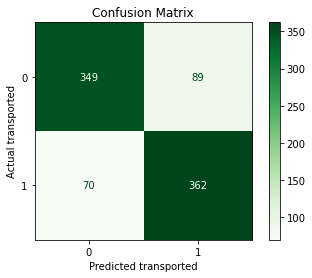

In [18]:
plot_confusion_matrix(final_model, X_val ,y_val, cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.xlabel('Predicted transported')
plt.ylabel('Actual transported')